## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (1096, 715)
Hypercube shape: (1096, 715, 102)


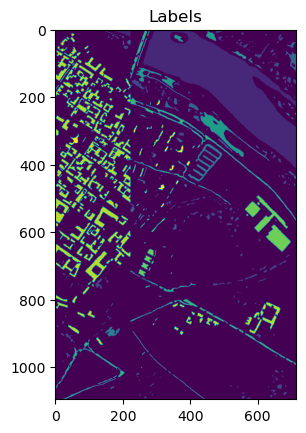

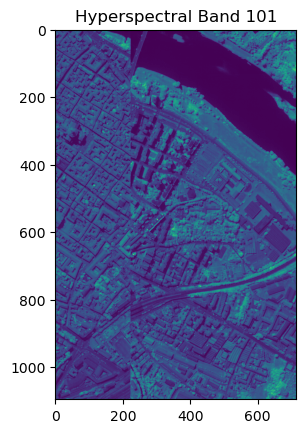

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Pavia_gt.mat'
data_files = 'Pavia.mat'
label_files = 'pavia_gt'
hypercube_files = 'pavia'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 148152
Extracted windows shape: (148152, 5, 5, 102)
Corresponding labels shape: (148152,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 5)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [1 2 3 4 5 6 7 8 9]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 65971 samples
Shuffled class indices for class '1'
Selected 5 training samples and 5 validation samples for class '1'

Class: 2: Found 7598 samples
Shuffled class indices for class '2'
Selected 5 training samples and 5 validation samples for class '2'

Class: 3: Found 3090 samples
Shuffled class indices for class '3'
Selected 5 training samples and 5 validation samples for class '3'

Class: 4: Found 2685 samples
Shuffled class indices for class '4'
Selected 5 training samples and 5 validation samples for class '4'

Class: 5: Found 6584 samples
Shuffled class indices for class '5'
Selected 5 training samples and 5 validation samples for class '5'

Class: 6: Found 9248 samples
Shuffled class indices for class '6'
Selected 5 training samples and 5 validation samples for class '6'

Class: 7: Found 7287 samples
Shuffled class indices for class '7'
Selected 5 training sam


 -- Test set created with: 
	148062 samples
	shape (148062, 5, 5, 102) --




All datasets saved to the 'indices' folder.
(45, 5, 5, 102)
(45, 5, 5, 102)
(148062, 5, 5, 102)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 45
Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (118521, 5, 5, 102)
Validation data shape: (29631, 5, 5, 102)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

102


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/1852], Loss: 0.1581, PSNR: 5.7649


	 Training Batch [200/1852], Loss: 0.0931, PSNR: 6.9726


	 Training Batch [400/1852], Loss: 0.0454, PSNR: 11.2613


	 Training Batch [600/1852], Loss: 0.0225, PSNR: 12.7510


	 Training Batch [800/1852], Loss: 0.0171, PSNR: 14.5288


	 Training Batch [1000/1852], Loss: 0.0116, PSNR: 15.3929


	 Training Batch [1200/1852], Loss: 0.0098, PSNR: 16.0158


	 Training Batch [1400/1852], Loss: 0.0090, PSNR: 17.6270


	 Training Batch [1600/1852], Loss: 0.0062, PSNR: 16.4289


	 Training Batch [1800/1852], Loss: 0.0052, PSNR: 19.2691


Epoch [1/50] Training Loss: 0.0307, PSNR: 13.8030
	[Val]   Batch [1/463] Loss: 0.0055, PSNR: 17.8311
	[Val]   Batch [10/463] Loss: 0.0052, PSNR: 18.9741
	[Val]   Batch [20/463] Loss: 0.0052, PSNR: 17.9727
	[Val]   Batch [30/463] Loss: 0.0062, PSNR: 18.5720
	[Val]   Batch [40/463] Loss: 0.0049, PSNR: 17.6740
	[Val]   Batch [50/463] Loss: 0.0052, PSNR: 17.8731
	[Val]   Batch [60/463] Loss: 0.0049, PSNR: 17.9293


	[Val]   Batch [70/463] Loss: 0.0070, PSNR: 18.2848
	[Val]   Batch [80/463] Loss: 0.0062, PSNR: 20.1988
	[Val]   Batch [90/463] Loss: 0.0060, PSNR: 19.2851
	[Val]   Batch [100/463] Loss: 0.0060, PSNR: 19.0202
	[Val]   Batch [110/463] Loss: 0.0070, PSNR: 18.4182
	[Val]   Batch [120/463] Loss: 0.0048, PSNR: 17.9028


	[Val]   Batch [130/463] Loss: 0.0056, PSNR: 19.3130
	[Val]   Batch [140/463] Loss: 0.0066, PSNR: 18.8805
	[Val]   Batch [150/463] Loss: 0.0075, PSNR: 18.8969
	[Val]   Batch [160/463] Loss: 0.0060, PSNR: 19.1633
	[Val]   Batch [170/463] Loss: 0.0077, PSNR: 18.1317
	[Val]   Batch [180/463] Loss: 0.0056, PSNR: 18.9022
	[Val]   Batch [190/463] Loss: 0.0061, PSNR: 19.2073


	[Val]   Batch [200/463] Loss: 0.0061, PSNR: 18.5982
	[Val]   Batch [210/463] Loss: 0.0059, PSNR: 18.2261
	[Val]   Batch [220/463] Loss: 0.0058, PSNR: 19.4638
	[Val]   Batch [230/463] Loss: 0.0069, PSNR: 19.2558
	[Val]   Batch [240/463] Loss: 0.0052, PSNR: 18.0391
	[Val]   Batch [250/463] Loss: 0.0067, PSNR: 17.2580


	[Val]   Batch [260/463] Loss: 0.0058, PSNR: 18.2643
	[Val]   Batch [270/463] Loss: 0.0045, PSNR: 17.4027
	[Val]   Batch [280/463] Loss: 0.0055, PSNR: 20.1305
	[Val]   Batch [290/463] Loss: 0.0061, PSNR: 17.1640
	[Val]   Batch [300/463] Loss: 0.0061, PSNR: 19.3813
	[Val]   Batch [310/463] Loss: 0.0056, PSNR: 19.2999
	[Val]   Batch [320/463] Loss: 0.0057, PSNR: 19.1553


	[Val]   Batch [330/463] Loss: 0.0067, PSNR: 18.5533
	[Val]   Batch [340/463] Loss: 0.0055, PSNR: 19.4922
	[Val]   Batch [350/463] Loss: 0.0071, PSNR: 19.4469
	[Val]   Batch [360/463] Loss: 0.0048, PSNR: 20.3673
	[Val]   Batch [370/463] Loss: 0.0070, PSNR: 18.5015
	[Val]   Batch [380/463] Loss: 0.0070, PSNR: 18.6155
	[Val]   Batch [390/463] Loss: 0.0064, PSNR: 18.4411


	[Val]   Batch [400/463] Loss: 0.0056, PSNR: 17.5221
	[Val]   Batch [410/463] Loss: 0.0055, PSNR: 19.8056
	[Val]   Batch [420/463] Loss: 0.0057, PSNR: 18.5948
	[Val]   Batch [430/463] Loss: 0.0055, PSNR: 18.0695
	[Val]   Batch [440/463] Loss: 0.0055, PSNR: 19.0340
	[Val]   Batch [450/463] Loss: 0.0042, PSNR: 16.3997
	[Val]   Batch [460/463] Loss: 0.0059, PSNR: 17.7560
Epoch [1/50] Validation Loss: 0.0059, PSNR: 18.5866

LOG: Epoch [2/50]


	 Training Batch [1/1852], Loss: 0.0050, PSNR: 20.2128


	 Training Batch [200/1852], Loss: 0.0056, PSNR: 18.2413


	 Training Batch [400/1852], Loss: 0.0062, PSNR: 18.7375


	 Training Batch [600/1852], Loss: 0.0051, PSNR: 18.4486


	 Training Batch [800/1852], Loss: 0.0040, PSNR: 18.7933


	 Training Batch [1000/1852], Loss: 0.0036, PSNR: 22.7594


	 Training Batch [1200/1852], Loss: 0.0035, PSNR: 21.5335


	 Training Batch [1400/1852], Loss: 0.0035, PSNR: 19.5483


	 Training Batch [1600/1852], Loss: 0.0029, PSNR: 20.8108


	 Training Batch [1800/1852], Loss: 0.0038, PSNR: 20.0210


Epoch [2/50] Training Loss: 0.0045, PSNR: 19.9620
	[Val]   Batch [1/463] Loss: 0.0029, PSNR: 20.6151
	[Val]   Batch [10/463] Loss: 0.0026, PSNR: 21.8849
	[Val]   Batch [20/463] Loss: 0.0026, PSNR: 21.0297
	[Val]   Batch [30/463] Loss: 0.0035, PSNR: 21.0726
	[Val]   Batch [40/463] Loss: 0.0025, PSNR: 20.6794
	[Val]   Batch [50/463] Loss: 0.0026, PSNR: 20.8228
	[Val]   Batch [60/463] Loss: 0.0025, PSNR: 20.9406


	[Val]   Batch [70/463] Loss: 0.0040, PSNR: 20.7040
	[Val]   Batch [80/463] Loss: 0.0035, PSNR: 22.6967
	[Val]   Batch [90/463] Loss: 0.0032, PSNR: 21.9871
	[Val]   Batch [100/463] Loss: 0.0035, PSNR: 21.4070
	[Val]   Batch [110/463] Loss: 0.0040, PSNR: 20.9060
	[Val]   Batch [120/463] Loss: 0.0024, PSNR: 20.9267
	[Val]   Batch [130/463] Loss: 0.0030, PSNR: 22.0864


	[Val]   Batch [140/463] Loss: 0.0036, PSNR: 21.4228
	[Val]   Batch [150/463] Loss: 0.0042, PSNR: 21.3834
	[Val]   Batch [160/463] Loss: 0.0033, PSNR: 21.7321
	[Val]   Batch [170/463] Loss: 0.0045, PSNR: 20.4518
	[Val]   Batch [180/463] Loss: 0.0032, PSNR: 21.3008
	[Val]   Batch [190/463] Loss: 0.0033, PSNR: 21.9415
	[Val]   Batch [200/463] Loss: 0.0033, PSNR: 21.3073


	[Val]   Batch [210/463] Loss: 0.0034, PSNR: 20.6245
	[Val]   Batch [220/463] Loss: 0.0032, PSNR: 22.0732
	[Val]   Batch [230/463] Loss: 0.0039, PSNR: 21.7316
	[Val]   Batch [240/463] Loss: 0.0028, PSNR: 20.8242
	[Val]   Batch [250/463] Loss: 0.0038, PSNR: 19.7620
	[Val]   Batch [260/463] Loss: 0.0032, PSNR: 20.8739
	[Val]   Batch [270/463] Loss: 0.0021, PSNR: 20.7356


	[Val]   Batch [280/463] Loss: 0.0029, PSNR: 22.9451
	[Val]   Batch [290/463] Loss: 0.0032, PSNR: 19.8759
	[Val]   Batch [300/463] Loss: 0.0033, PSNR: 22.1048
	[Val]   Batch [310/463] Loss: 0.0031, PSNR: 21.9602
	[Val]   Batch [320/463] Loss: 0.0031, PSNR: 21.8256
	[Val]   Batch [330/463] Loss: 0.0036, PSNR: 21.2276
	[Val]   Batch [340/463] Loss: 0.0029, PSNR: 22.2307


	[Val]   Batch [350/463] Loss: 0.0042, PSNR: 21.7159
	[Val]   Batch [360/463] Loss: 0.0025, PSNR: 23.1312
	[Val]   Batch [370/463] Loss: 0.0039, PSNR: 21.0414
	[Val]   Batch [380/463] Loss: 0.0037, PSNR: 21.3210
	[Val]   Batch [390/463] Loss: 0.0035, PSNR: 21.1035
	[Val]   Batch [400/463] Loss: 0.0030, PSNR: 20.1413
	[Val]   Batch [410/463] Loss: 0.0028, PSNR: 22.7500


	[Val]   Batch [420/463] Loss: 0.0030, PSNR: 21.3536
	[Val]   Batch [430/463] Loss: 0.0030, PSNR: 20.7401
	[Val]   Batch [440/463] Loss: 0.0030, PSNR: 21.6717
	[Val]   Batch [450/463] Loss: 0.0020, PSNR: 19.6144
	[Val]   Batch [460/463] Loss: 0.0031, PSNR: 20.5870
Epoch [2/50] Validation Loss: 0.0032, PSNR: 21.3096

LOG: Epoch [3/50]
	 Training Batch [1/1852], Loss: 0.0036, PSNR: 22.3414


	 Training Batch [200/1852], Loss: 0.0029, PSNR: 22.1106


	 Training Batch [400/1852], Loss: 0.0026, PSNR: 21.0986


	 Training Batch [600/1852], Loss: 0.0037, PSNR: 21.1784


	 Training Batch [800/1852], Loss: 0.0028, PSNR: 22.2534


	 Training Batch [1000/1852], Loss: 0.0021, PSNR: 21.2155


	 Training Batch [1200/1852], Loss: 0.0017, PSNR: 23.2753


	 Training Batch [1400/1852], Loss: 0.0022, PSNR: 22.6715


	 Training Batch [1600/1852], Loss: 0.0024, PSNR: 23.2917


	 Training Batch [1800/1852], Loss: 0.0032, PSNR: 25.0098


Epoch [3/50] Training Loss: 0.0025, PSNR: 22.3943
	[Val]   Batch [1/463] Loss: 0.0015, PSNR: 23.3747
	[Val]   Batch [10/463] Loss: 0.0015, PSNR: 24.4772
	[Val]   Batch [20/463] Loss: 0.0014, PSNR: 23.6763
	[Val]   Batch [30/463] Loss: 0.0017, PSNR: 24.2160
	[Val]   Batch [40/463] Loss: 0.0015, PSNR: 22.9021
	[Val]   Batch [50/463] Loss: 0.0015, PSNR: 23.1847
	[Val]   Batch [60/463] Loss: 0.0014, PSNR: 23.2552


	[Val]   Batch [70/463] Loss: 0.0020, PSNR: 23.7633
	[Val]   Batch [80/463] Loss: 0.0018, PSNR: 25.5289
	[Val]   Batch [90/463] Loss: 0.0017, PSNR: 24.7636
	[Val]   Batch [100/463] Loss: 0.0018, PSNR: 24.2767
	[Val]   Batch [110/463] Loss: 0.0020, PSNR: 23.9643
	[Val]   Batch [120/463] Loss: 0.0014, PSNR: 23.1540
	[Val]   Batch [130/463] Loss: 0.0015, PSNR: 25.1019
	[Val]   Batch [140/463] Loss: 0.0018, PSNR: 24.3938


	[Val]   Batch [150/463] Loss: 0.0020, PSNR: 24.7156
	[Val]   Batch [160/463] Loss: 0.0020, PSNR: 24.0186
	[Val]   Batch [170/463] Loss: 0.0023, PSNR: 23.3629
	[Val]   Batch [180/463] Loss: 0.0018, PSNR: 23.8511
	[Val]   Batch [190/463] Loss: 0.0017, PSNR: 24.8372
	[Val]   Batch [200/463] Loss: 0.0017, PSNR: 24.1055
	[Val]   Batch [210/463] Loss: 0.0019, PSNR: 23.0801
	[Val]   Batch [220/463] Loss: 0.0018, PSNR: 24.5822


	[Val]   Batch [230/463] Loss: 0.0017, PSNR: 25.3217
	[Val]   Batch [240/463] Loss: 0.0015, PSNR: 23.4736
	[Val]   Batch [250/463] Loss: 0.0020, PSNR: 22.4403
	[Val]   Batch [260/463] Loss: 0.0018, PSNR: 23.4473
	[Val]   Batch [270/463] Loss: 0.0013, PSNR: 22.8374
	[Val]   Batch [280/463] Loss: 0.0016, PSNR: 25.5546
	[Val]   Batch [290/463] Loss: 0.0017, PSNR: 22.7194
	[Val]   Batch [300/463] Loss: 0.0018, PSNR: 24.6573


	[Val]   Batch [310/463] Loss: 0.0019, PSNR: 24.0343
	[Val]   Batch [320/463] Loss: 0.0017, PSNR: 24.4863
	[Val]   Batch [330/463] Loss: 0.0018, PSNR: 24.3414
	[Val]   Batch [340/463] Loss: 0.0016, PSNR: 24.7996
	[Val]   Batch [350/463] Loss: 0.0022, PSNR: 24.4623
	[Val]   Batch [360/463] Loss: 0.0017, PSNR: 24.7882
	[Val]   Batch [370/463] Loss: 0.0019, PSNR: 24.2792
	[Val]   Batch [380/463] Loss: 0.0017, PSNR: 24.7363


	[Val]   Batch [390/463] Loss: 0.0017, PSNR: 24.3032
	[Val]   Batch [400/463] Loss: 0.0017, PSNR: 22.5772
	[Val]   Batch [410/463] Loss: 0.0015, PSNR: 25.3830
	[Val]   Batch [420/463] Loss: 0.0016, PSNR: 24.2086
	[Val]   Batch [430/463] Loss: 0.0018, PSNR: 23.0349
	[Val]   Batch [440/463] Loss: 0.0017, PSNR: 24.1418
	[Val]   Batch [450/463] Loss: 0.0013, PSNR: 21.3519
	[Val]   Batch [460/463] Loss: 0.0017, PSNR: 23.2569
Epoch [3/50] Validation Loss: 0.0017, PSNR: 24.0145

LOG: Epoch [4/50]
	 Training Batch [1/1852], Loss: 0.0017, PSNR: 22.8853


	 Training Batch [200/1852], Loss: 0.0018, PSNR: 23.7171


	 Training Batch [400/1852], Loss: 0.0017, PSNR: 22.5759


	 Training Batch [600/1852], Loss: 0.0018, PSNR: 25.3400


	 Training Batch [800/1852], Loss: 0.0014, PSNR: 24.6409


	 Training Batch [1000/1852], Loss: 0.0014, PSNR: 26.3638


	 Training Batch [1200/1852], Loss: 0.0015, PSNR: 23.4767


	 Training Batch [1400/1852], Loss: 0.0013, PSNR: 25.1050


	 Training Batch [1600/1852], Loss: 0.0012, PSNR: 24.1803


	 Training Batch [1800/1852], Loss: 0.0012, PSNR: 25.7180


Epoch [4/50] Training Loss: 0.0016, PSNR: 24.3986
	[Val]   Batch [1/463] Loss: 0.0011, PSNR: 24.8909
	[Val]   Batch [10/463] Loss: 0.0010, PSNR: 26.0901
	[Val]   Batch [20/463] Loss: 0.0010, PSNR: 25.3249
	[Val]   Batch [30/463] Loss: 0.0011, PSNR: 25.9143
	[Val]   Batch [40/463] Loss: 0.0011, PSNR: 24.3082


	[Val]   Batch [50/463] Loss: 0.0011, PSNR: 24.7003
	[Val]   Batch [60/463] Loss: 0.0010, PSNR: 24.6826
	[Val]   Batch [70/463] Loss: 0.0013, PSNR: 25.4842
	[Val]   Batch [80/463] Loss: 0.0012, PSNR: 27.4924
	[Val]   Batch [90/463] Loss: 0.0012, PSNR: 26.4349


	[Val]   Batch [100/463] Loss: 0.0012, PSNR: 25.9899
	[Val]   Batch [110/463] Loss: 0.0013, PSNR: 25.8215
	[Val]   Batch [120/463] Loss: 0.0010, PSNR: 24.6455
	[Val]   Batch [130/463] Loss: 0.0010, PSNR: 26.8118
	[Val]   Batch [140/463] Loss: 0.0012, PSNR: 26.1139


	[Val]   Batch [150/463] Loss: 0.0012, PSNR: 26.7026
	[Val]   Batch [160/463] Loss: 0.0014, PSNR: 25.4880
	[Val]   Batch [170/463] Loss: 0.0016, PSNR: 24.9340
	[Val]   Batch [180/463] Loss: 0.0012, PSNR: 25.4212
	[Val]   Batch [190/463] Loss: 0.0011, PSNR: 26.5077
	[Val]   Batch [200/463] Loss: 0.0011, PSNR: 26.0170


	[Val]   Batch [210/463] Loss: 0.0014, PSNR: 24.5348
	[Val]   Batch [220/463] Loss: 0.0013, PSNR: 26.1105
	[Val]   Batch [230/463] Loss: 0.0011, PSNR: 27.3835
	[Val]   Batch [240/463] Loss: 0.0010, PSNR: 25.1239
	[Val]   Batch [250/463] Loss: 0.0014, PSNR: 23.9404
	[Val]   Batch [260/463] Loss: 0.0013, PSNR: 24.8423


	[Val]   Batch [270/463] Loss: 0.0009, PSNR: 24.4098
	[Val]   Batch [280/463] Loss: 0.0011, PSNR: 27.1542
	[Val]   Batch [290/463] Loss: 0.0012, PSNR: 24.3418
	[Val]   Batch [300/463] Loss: 0.0013, PSNR: 26.0970
	[Val]   Batch [310/463] Loss: 0.0013, PSNR: 25.5437
	[Val]   Batch [320/463] Loss: 0.0011, PSNR: 26.1731


	[Val]   Batch [330/463] Loss: 0.0012, PSNR: 26.1650
	[Val]   Batch [340/463] Loss: 0.0011, PSNR: 26.4399
	[Val]   Batch [350/463] Loss: 0.0015, PSNR: 26.1589
	[Val]   Batch [360/463] Loss: 0.0013, PSNR: 25.8780
	[Val]   Batch [370/463] Loss: 0.0012, PSNR: 26.0408


	[Val]   Batch [380/463] Loss: 0.0011, PSNR: 26.7426
	[Val]   Batch [390/463] Loss: 0.0011, PSNR: 26.1835
	[Val]   Batch [400/463] Loss: 0.0013, PSNR: 23.9954
	[Val]   Batch [410/463] Loss: 0.0010, PSNR: 27.0542
	[Val]   Batch [420/463] Loss: 0.0011, PSNR: 25.8059


	[Val]   Batch [430/463] Loss: 0.0013, PSNR: 24.3849
	[Val]   Batch [440/463] Loss: 0.0012, PSNR: 25.6684
	[Val]   Batch [450/463] Loss: 0.0010, PSNR: 22.7113
	[Val]   Batch [460/463] Loss: 0.0012, PSNR: 24.8058
Epoch [4/50] Validation Loss: 0.0012, PSNR: 25.6689

LOG: Epoch [5/50]
	 Training Batch [1/1852], Loss: 0.0011, PSNR: 26.3905


	 Training Batch [200/1852], Loss: 0.0010, PSNR: 26.0889


	 Training Batch [400/1852], Loss: 0.0012, PSNR: 27.1257


	 Training Batch [600/1852], Loss: 0.0015, PSNR: 26.2622


	 Training Batch [800/1852], Loss: 0.0011, PSNR: 26.0734


	 Training Batch [1000/1852], Loss: 0.0010, PSNR: 27.4631


	 Training Batch [1200/1852], Loss: 0.0010, PSNR: 25.6552


	 Training Batch [1400/1852], Loss: 0.0012, PSNR: 26.5179


	 Training Batch [1600/1852], Loss: 0.0011, PSNR: 27.5197


	 Training Batch [1800/1852], Loss: 0.0009, PSNR: 27.0712


Epoch [5/50] Training Loss: 0.0012, PSNR: 25.5814
	[Val]   Batch [1/463] Loss: 0.0008, PSNR: 26.0253
	[Val]   Batch [10/463] Loss: 0.0008, PSNR: 27.3320
	[Val]   Batch [20/463] Loss: 0.0007, PSNR: 26.6051
	[Val]   Batch [30/463] Loss: 0.0009, PSNR: 27.0297
	[Val]   Batch [40/463] Loss: 0.0008, PSNR: 25.4296
	[Val]   Batch [50/463] Loss: 0.0008, PSNR: 25.9658


	[Val]   Batch [60/463] Loss: 0.0008, PSNR: 25.8041
	[Val]   Batch [70/463] Loss: 0.0010, PSNR: 26.6446
	[Val]   Batch [80/463] Loss: 0.0008, PSNR: 28.9151
	[Val]   Batch [90/463] Loss: 0.0009, PSNR: 27.6881
	[Val]   Batch [100/463] Loss: 0.0009, PSNR: 27.1746
	[Val]   Batch [110/463] Loss: 0.0010, PSNR: 27.0884
	[Val]   Batch [120/463] Loss: 0.0008, PSNR: 25.8676


	[Val]   Batch [130/463] Loss: 0.0008, PSNR: 28.0190
	[Val]   Batch [140/463] Loss: 0.0009, PSNR: 27.3030
	[Val]   Batch [150/463] Loss: 0.0009, PSNR: 28.0070
	[Val]   Batch [160/463] Loss: 0.0011, PSNR: 26.5869
	[Val]   Batch [170/463] Loss: 0.0013, PSNR: 25.9834
	[Val]   Batch [180/463] Loss: 0.0010, PSNR: 26.5730
	[Val]   Batch [190/463] Loss: 0.0009, PSNR: 27.7161


	[Val]   Batch [200/463] Loss: 0.0008, PSNR: 27.3957
	[Val]   Batch [210/463] Loss: 0.0011, PSNR: 25.6415
	[Val]   Batch [220/463] Loss: 0.0010, PSNR: 27.1823
	[Val]   Batch [230/463] Loss: 0.0008, PSNR: 28.7097
	[Val]   Batch [240/463] Loss: 0.0008, PSNR: 26.3741
	[Val]   Batch [250/463] Loss: 0.0011, PSNR: 25.0493


	[Val]   Batch [260/463] Loss: 0.0010, PSNR: 25.9017
	[Val]   Batch [270/463] Loss: 0.0007, PSNR: 25.7815
	[Val]   Batch [280/463] Loss: 0.0008, PSNR: 28.3635
	[Val]   Batch [290/463] Loss: 0.0009, PSNR: 25.5462
	[Val]   Batch [300/463] Loss: 0.0010, PSNR: 27.2279
	[Val]   Batch [310/463] Loss: 0.0010, PSNR: 26.7217
	[Val]   Batch [320/463] Loss: 0.0008, PSNR: 27.4622


	[Val]   Batch [330/463] Loss: 0.0009, PSNR: 27.4322
	[Val]   Batch [340/463] Loss: 0.0008, PSNR: 27.6865
	[Val]   Batch [350/463] Loss: 0.0012, PSNR: 27.2741
	[Val]   Batch [360/463] Loss: 0.0011, PSNR: 26.7774
	[Val]   Batch [370/463] Loss: 0.0009, PSNR: 27.2243
	[Val]   Batch [380/463] Loss: 0.0008, PSNR: 28.1503
	[Val]   Batch [390/463] Loss: 0.0008, PSNR: 27.4779


	[Val]   Batch [400/463] Loss: 0.0010, PSNR: 25.0750
	[Val]   Batch [410/463] Loss: 0.0008, PSNR: 28.3097
	[Val]   Batch [420/463] Loss: 0.0008, PSNR: 27.0100
	[Val]   Batch [430/463] Loss: 0.0010, PSNR: 25.4238
	[Val]   Batch [440/463] Loss: 0.0009, PSNR: 26.7674
	[Val]   Batch [450/463] Loss: 0.0008, PSNR: 23.8796
	[Val]   Batch [460/463] Loss: 0.0009, PSNR: 25.9706
Epoch [5/50] Validation Loss: 0.0009, PSNR: 26.8894

LOG: Epoch [6/50]


	 Training Batch [1/1852], Loss: 0.0011, PSNR: 26.9351


	 Training Batch [200/1852], Loss: 0.0013, PSNR: 26.5304


	 Training Batch [400/1852], Loss: 0.0011, PSNR: 27.5865


	 Training Batch [600/1852], Loss: 0.0013, PSNR: 25.7500


	 Training Batch [800/1852], Loss: 0.0010, PSNR: 27.7980


	 Training Batch [1000/1852], Loss: 0.0008, PSNR: 27.0685


	 Training Batch [1200/1852], Loss: 0.0007, PSNR: 26.7657


	 Training Batch [1400/1852], Loss: 0.0012, PSNR: 25.9783


	 Training Batch [1600/1852], Loss: 0.0010, PSNR: 25.5757


	 Training Batch [1800/1852], Loss: 0.0007, PSNR: 26.5619


Epoch [6/50] Training Loss: 0.0010, PSNR: 26.4556
	[Val]   Batch [1/463] Loss: 0.0007, PSNR: 26.9115
	[Val]   Batch [10/463] Loss: 0.0006, PSNR: 28.2205
	[Val]   Batch [20/463] Loss: 0.0006, PSNR: 27.5194
	[Val]   Batch [30/463] Loss: 0.0007, PSNR: 27.9528
	[Val]   Batch [40/463] Loss: 0.0007, PSNR: 26.2502
	[Val]   Batch [50/463] Loss: 0.0007, PSNR: 26.8831


	[Val]   Batch [60/463] Loss: 0.0007, PSNR: 26.5954
	[Val]   Batch [70/463] Loss: 0.0008, PSNR: 27.5948
	[Val]   Batch [80/463] Loss: 0.0006, PSNR: 30.0172
	[Val]   Batch [90/463] Loss: 0.0007, PSNR: 28.6490
	[Val]   Batch [100/463] Loss: 0.0007, PSNR: 28.1677
	[Val]   Batch [110/463] Loss: 0.0008, PSNR: 28.0973


	[Val]   Batch [120/463] Loss: 0.0006, PSNR: 26.7192
	[Val]   Batch [130/463] Loss: 0.0006, PSNR: 28.8946
	[Val]   Batch [140/463] Loss: 0.0008, PSNR: 28.2151
	[Val]   Batch [150/463] Loss: 0.0007, PSNR: 29.0260
	[Val]   Batch [160/463] Loss: 0.0009, PSNR: 27.4417
	[Val]   Batch [170/463] Loss: 0.0010, PSNR: 26.8652
	[Val]   Batch [180/463] Loss: 0.0008, PSNR: 27.4879


	[Val]   Batch [190/463] Loss: 0.0007, PSNR: 28.5649
	[Val]   Batch [200/463] Loss: 0.0006, PSNR: 28.3683
	[Val]   Batch [210/463] Loss: 0.0009, PSNR: 26.5357
	[Val]   Batch [220/463] Loss: 0.0008, PSNR: 28.0567
	[Val]   Batch [230/463] Loss: 0.0006, PSNR: 29.7642
	[Val]   Batch [240/463] Loss: 0.0006, PSNR: 27.2947
	[Val]   Batch [250/463] Loss: 0.0009, PSNR: 25.8986


	[Val]   Batch [260/463] Loss: 0.0008, PSNR: 26.7291
	[Val]   Batch [270/463] Loss: 0.0005, PSNR: 26.7291
	[Val]   Batch [280/463] Loss: 0.0007, PSNR: 29.2991
	[Val]   Batch [290/463] Loss: 0.0007, PSNR: 26.5230
	[Val]   Batch [300/463] Loss: 0.0008, PSNR: 27.9949
	[Val]   Batch [310/463] Loss: 0.0008, PSNR: 27.6052
	[Val]   Batch [320/463] Loss: 0.0007, PSNR: 28.4567


	[Val]   Batch [330/463] Loss: 0.0007, PSNR: 28.3753
	[Val]   Batch [340/463] Loss: 0.0007, PSNR: 28.6243
	[Val]   Batch [350/463] Loss: 0.0009, PSNR: 28.2043
	[Val]   Batch [360/463] Loss: 0.0010, PSNR: 27.3574
	[Val]   Batch [370/463] Loss: 0.0007, PSNR: 28.2287
	[Val]   Batch [380/463] Loss: 0.0006, PSNR: 29.1741
	[Val]   Batch [390/463] Loss: 0.0006, PSNR: 28.4846


	[Val]   Batch [400/463] Loss: 0.0008, PSNR: 25.9062
	[Val]   Batch [410/463] Loss: 0.0006, PSNR: 29.1753
	[Val]   Batch [420/463] Loss: 0.0007, PSNR: 27.8932
	[Val]   Batch [430/463] Loss: 0.0008, PSNR: 26.2066
	[Val]   Batch [440/463] Loss: 0.0007, PSNR: 27.6594
	[Val]   Batch [450/463] Loss: 0.0006, PSNR: 24.7466
	[Val]   Batch [460/463] Loss: 0.0007, PSNR: 26.8286


Epoch [6/50] Validation Loss: 0.0007, PSNR: 27.8106

LOG: Epoch [7/50]
	 Training Batch [1/1852], Loss: 0.0007, PSNR: 28.3181


	 Training Batch [200/1852], Loss: 0.0007, PSNR: 27.0117


	 Training Batch [400/1852], Loss: 0.0008, PSNR: 26.6729


	 Training Batch [600/1852], Loss: 0.0009, PSNR: 25.2691


	 Training Batch [800/1852], Loss: 0.0008, PSNR: 27.8386


	 Training Batch [1000/1852], Loss: 0.0009, PSNR: 28.2490


	 Training Batch [1200/1852], Loss: 0.0007, PSNR: 27.5280


	 Training Batch [1400/1852], Loss: 0.0007, PSNR: 27.3478


	 Training Batch [1600/1852], Loss: 0.0007, PSNR: 27.5588


	 Training Batch [1800/1852], Loss: 0.0007, PSNR: 28.7906


Epoch [7/50] Training Loss: 0.0008, PSNR: 27.1470
	[Val]   Batch [1/463] Loss: 0.0006, PSNR: 27.5544
	[Val]   Batch [10/463] Loss: 0.0005, PSNR: 28.9739
	[Val]   Batch [20/463] Loss: 0.0005, PSNR: 28.3009
	[Val]   Batch [30/463] Loss: 0.0006, PSNR: 28.6378
	[Val]   Batch [40/463] Loss: 0.0006, PSNR: 26.9499
	[Val]   Batch [50/463] Loss: 0.0005, PSNR: 27.6999


	[Val]   Batch [60/463] Loss: 0.0006, PSNR: 27.2453
	[Val]   Batch [70/463] Loss: 0.0007, PSNR: 28.2748
	[Val]   Batch [80/463] Loss: 0.0005, PSNR: 30.8491
	[Val]   Batch [90/463] Loss: 0.0006, PSNR: 29.3282
	[Val]   Batch [100/463] Loss: 0.0006, PSNR: 28.8903
	[Val]   Batch [110/463] Loss: 0.0006, PSNR: 28.7971
	[Val]   Batch [120/463] Loss: 0.0005, PSNR: 27.4574


	[Val]   Batch [130/463] Loss: 0.0005, PSNR: 29.5728
	[Val]   Batch [140/463] Loss: 0.0007, PSNR: 28.8850
	[Val]   Batch [150/463] Loss: 0.0006, PSNR: 29.7922
	[Val]   Batch [160/463] Loss: 0.0008, PSNR: 28.1498
	[Val]   Batch [170/463] Loss: 0.0009, PSNR: 27.5035
	[Val]   Batch [180/463] Loss: 0.0007, PSNR: 28.2509
	[Val]   Batch [190/463] Loss: 0.0006, PSNR: 29.3009


	[Val]   Batch [200/463] Loss: 0.0005, PSNR: 29.1993
	[Val]   Batch [210/463] Loss: 0.0007, PSNR: 27.2659
	[Val]   Batch [220/463] Loss: 0.0007, PSNR: 28.7002
	[Val]   Batch [230/463] Loss: 0.0005, PSNR: 30.4498
	[Val]   Batch [240/463] Loss: 0.0005, PSNR: 28.0378
	[Val]   Batch [250/463] Loss: 0.0008, PSNR: 26.6367


	[Val]   Batch [260/463] Loss: 0.0007, PSNR: 27.4405
	[Val]   Batch [270/463] Loss: 0.0004, PSNR: 27.5889
	[Val]   Batch [280/463] Loss: 0.0006, PSNR: 29.9872
	[Val]   Batch [290/463] Loss: 0.0006, PSNR: 27.1840
	[Val]   Batch [300/463] Loss: 0.0007, PSNR: 28.6409
	[Val]   Batch [310/463] Loss: 0.0007, PSNR: 28.3752
	[Val]   Batch [320/463] Loss: 0.0006, PSNR: 29.2869


	[Val]   Batch [330/463] Loss: 0.0006, PSNR: 29.0795
	[Val]   Batch [340/463] Loss: 0.0006, PSNR: 29.3832
	[Val]   Batch [350/463] Loss: 0.0008, PSNR: 28.8571
	[Val]   Batch [360/463] Loss: 0.0008, PSNR: 27.9136
	[Val]   Batch [370/463] Loss: 0.0006, PSNR: 28.8535
	[Val]   Batch [380/463] Loss: 0.0005, PSNR: 29.9563
	[Val]   Batch [390/463] Loss: 0.0005, PSNR: 29.1854


	[Val]   Batch [400/463] Loss: 0.0007, PSNR: 26.5458
	[Val]   Batch [410/463] Loss: 0.0005, PSNR: 29.8490
	[Val]   Batch [420/463] Loss: 0.0006, PSNR: 28.6198
	[Val]   Batch [430/463] Loss: 0.0007, PSNR: 26.9249
	[Val]   Batch [440/463] Loss: 0.0006, PSNR: 28.2795
	[Val]   Batch [450/463] Loss: 0.0005, PSNR: 25.5151
	[Val]   Batch [460/463] Loss: 0.0006, PSNR: 27.5479
Epoch [7/50] Validation Loss: 0.0006, PSNR: 28.5395

LOG: Epoch [8/50]
	 Training Batch [1/1852], Loss: 0.0006, PSNR: 27.3220


	 Training Batch [200/1852], Loss: 0.0009, PSNR: 26.2768


	 Training Batch [400/1852], Loss: 0.0006, PSNR: 28.6964


	 Training Batch [600/1852], Loss: 0.0008, PSNR: 27.6147


	 Training Batch [800/1852], Loss: 0.0008, PSNR: 27.0107


	 Training Batch [1000/1852], Loss: 0.0008, PSNR: 28.8362


	 Training Batch [1200/1852], Loss: 0.0007, PSNR: 26.4343


	 Training Batch [1400/1852], Loss: 0.0008, PSNR: 27.0859


	 Training Batch [1600/1852], Loss: 0.0007, PSNR: 27.2471


	 Training Batch [1800/1852], Loss: 0.0008, PSNR: 27.5165


Epoch [8/50] Training Loss: 0.0007, PSNR: 27.7091
	[Val]   Batch [1/463] Loss: 0.0005, PSNR: 28.2055
	[Val]   Batch [10/463] Loss: 0.0004, PSNR: 29.6767
	[Val]   Batch [20/463] Loss: 0.0004, PSNR: 28.9906
	[Val]   Batch [30/463] Loss: 0.0005, PSNR: 29.2949
	[Val]   Batch [40/463] Loss: 0.0005, PSNR: 27.5691


	[Val]   Batch [50/463] Loss: 0.0005, PSNR: 28.3765
	[Val]   Batch [60/463] Loss: 0.0005, PSNR: 27.8463
	[Val]   Batch [70/463] Loss: 0.0006, PSNR: 28.9956
	[Val]   Batch [80/463] Loss: 0.0004, PSNR: 31.6096
	[Val]   Batch [90/463] Loss: 0.0005, PSNR: 30.0298
	[Val]   Batch [100/463] Loss: 0.0005, PSNR: 29.5843
	[Val]   Batch [110/463] Loss: 0.0005, PSNR: 29.4972


	[Val]   Batch [120/463] Loss: 0.0005, PSNR: 28.0598
	[Val]   Batch [130/463] Loss: 0.0005, PSNR: 30.2517
	[Val]   Batch [140/463] Loss: 0.0006, PSNR: 29.5479
	[Val]   Batch [150/463] Loss: 0.0005, PSNR: 30.6243
	[Val]   Batch [160/463] Loss: 0.0006, PSNR: 28.8201
	[Val]   Batch [170/463] Loss: 0.0008, PSNR: 28.1726
	[Val]   Batch [180/463] Loss: 0.0006, PSNR: 28.8585


	[Val]   Batch [190/463] Loss: 0.0005, PSNR: 29.9008
	[Val]   Batch [200/463] Loss: 0.0005, PSNR: 29.8619
	[Val]   Batch [210/463] Loss: 0.0006, PSNR: 27.9855
	[Val]   Batch [220/463] Loss: 0.0006, PSNR: 29.3436
	[Val]   Batch [230/463] Loss: 0.0004, PSNR: 31.2128
	[Val]   Batch [240/463] Loss: 0.0004, PSNR: 28.7197
	[Val]   Batch [250/463] Loss: 0.0007, PSNR: 27.2767


	[Val]   Batch [260/463] Loss: 0.0006, PSNR: 28.0966
	[Val]   Batch [270/463] Loss: 0.0004, PSNR: 28.3031
	[Val]   Batch [280/463] Loss: 0.0005, PSNR: 30.6960
	[Val]   Batch [290/463] Loss: 0.0005, PSNR: 27.9306
	[Val]   Batch [300/463] Loss: 0.0006, PSNR: 29.2094
	[Val]   Batch [310/463] Loss: 0.0006, PSNR: 29.0066
	[Val]   Batch [320/463] Loss: 0.0005, PSNR: 29.9534


	[Val]   Batch [330/463] Loss: 0.0005, PSNR: 29.8581
	[Val]   Batch [340/463] Loss: 0.0005, PSNR: 30.0822
	[Val]   Batch [350/463] Loss: 0.0007, PSNR: 29.5778
	[Val]   Batch [360/463] Loss: 0.0008, PSNR: 28.3296
	[Val]   Batch [370/463] Loss: 0.0005, PSNR: 29.6074
	[Val]   Batch [380/463] Loss: 0.0004, PSNR: 30.7662
	[Val]   Batch [390/463] Loss: 0.0005, PSNR: 29.9528
	[Val]   Batch [400/463] Loss: 0.0006, PSNR: 27.1298


	[Val]   Batch [410/463] Loss: 0.0005, PSNR: 30.4851
	[Val]   Batch [420/463] Loss: 0.0005, PSNR: 29.3299
	[Val]   Batch [430/463] Loss: 0.0006, PSNR: 27.5351
	[Val]   Batch [440/463] Loss: 0.0006, PSNR: 28.8529
	[Val]   Batch [450/463] Loss: 0.0004, PSNR: 26.1543
	[Val]   Batch [460/463] Loss: 0.0005, PSNR: 28.2520
Epoch [8/50] Validation Loss: 0.0005, PSNR: 29.2226

LOG: Epoch [9/50]


	 Training Batch [1/1852], Loss: 0.0012, PSNR: 26.7384


	 Training Batch [200/1852], Loss: 0.0007, PSNR: 28.5212


	 Training Batch [400/1852], Loss: 0.0006, PSNR: 29.3905


	 Training Batch [600/1852], Loss: 0.0010, PSNR: 26.7612


	 Training Batch [800/1852], Loss: 0.0007, PSNR: 28.7602


	 Training Batch [1000/1852], Loss: 0.0006, PSNR: 28.6454


	 Training Batch [1200/1852], Loss: 0.0006, PSNR: 29.0811


	 Training Batch [1400/1852], Loss: 0.0007, PSNR: 29.4007


	 Training Batch [1600/1852], Loss: 0.0008, PSNR: 27.4205


	 Training Batch [1800/1852], Loss: 0.0005, PSNR: 29.4045


Epoch [9/50] Training Loss: 0.0007, PSNR: 28.1610
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 28.7312
	[Val]   Batch [10/463] Loss: 0.0004, PSNR: 30.3281
	[Val]   Batch [20/463] Loss: 0.0004, PSNR: 29.6166
	[Val]   Batch [30/463] Loss: 0.0005, PSNR: 29.8758
	[Val]   Batch [40/463] Loss: 0.0004, PSNR: 28.1191
	[Val]   Batch [50/463] Loss: 0.0004, PSNR: 29.0698
	[Val]   Batch [60/463] Loss: 0.0004, PSNR: 28.3876


	[Val]   Batch [70/463] Loss: 0.0005, PSNR: 29.6288
	[Val]   Batch [80/463] Loss: 0.0004, PSNR: 32.3014
	[Val]   Batch [90/463] Loss: 0.0004, PSNR: 30.6498
	[Val]   Batch [100/463] Loss: 0.0005, PSNR: 30.2023
	[Val]   Batch [110/463] Loss: 0.0005, PSNR: 30.1996
	[Val]   Batch [120/463] Loss: 0.0004, PSNR: 28.6197
	[Val]   Batch [130/463] Loss: 0.0004, PSNR: 30.8167
	[Val]   Batch [140/463] Loss: 0.0005, PSNR: 30.1711


	[Val]   Batch [150/463] Loss: 0.0004, PSNR: 31.3128
	[Val]   Batch [160/463] Loss: 0.0006, PSNR: 29.4900
	[Val]   Batch [170/463] Loss: 0.0007, PSNR: 28.7844
	[Val]   Batch [180/463] Loss: 0.0005, PSNR: 29.5081
	[Val]   Batch [190/463] Loss: 0.0005, PSNR: 30.4856
	[Val]   Batch [200/463] Loss: 0.0004, PSNR: 30.5204
	[Val]   Batch [210/463] Loss: 0.0005, PSNR: 28.6303


	[Val]   Batch [220/463] Loss: 0.0005, PSNR: 29.8793
	[Val]   Batch [230/463] Loss: 0.0004, PSNR: 31.8326
	[Val]   Batch [240/463] Loss: 0.0004, PSNR: 29.3241
	[Val]   Batch [250/463] Loss: 0.0006, PSNR: 27.9711
	[Val]   Batch [260/463] Loss: 0.0005, PSNR: 28.7875
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 28.9665
	[Val]   Batch [280/463] Loss: 0.0004, PSNR: 31.2801


	[Val]   Batch [290/463] Loss: 0.0004, PSNR: 28.5995
	[Val]   Batch [300/463] Loss: 0.0006, PSNR: 29.7906
	[Val]   Batch [310/463] Loss: 0.0005, PSNR: 29.6383
	[Val]   Batch [320/463] Loss: 0.0004, PSNR: 30.6047
	[Val]   Batch [330/463] Loss: 0.0004, PSNR: 30.4504
	[Val]   Batch [340/463] Loss: 0.0004, PSNR: 30.6923
	[Val]   Batch [350/463] Loss: 0.0006, PSNR: 30.2170


	[Val]   Batch [360/463] Loss: 0.0007, PSNR: 28.7240
	[Val]   Batch [370/463] Loss: 0.0005, PSNR: 30.2320
	[Val]   Batch [380/463] Loss: 0.0004, PSNR: 31.4497
	[Val]   Batch [390/463] Loss: 0.0004, PSNR: 30.5484
	[Val]   Batch [400/463] Loss: 0.0005, PSNR: 27.7203
	[Val]   Batch [410/463] Loss: 0.0004, PSNR: 31.0530
	[Val]   Batch [420/463] Loss: 0.0004, PSNR: 29.9364
	[Val]   Batch [430/463] Loss: 0.0005, PSNR: 28.2001


	[Val]   Batch [440/463] Loss: 0.0005, PSNR: 29.3737
	[Val]   Batch [450/463] Loss: 0.0004, PSNR: 26.8053
	[Val]   Batch [460/463] Loss: 0.0005, PSNR: 28.8985
Epoch [9/50] Validation Loss: 0.0004, PSNR: 29.8517

LOG: Epoch [10/50]
	 Training Batch [1/1852], Loss: 0.0007, PSNR: 27.4611


	 Training Batch [200/1852], Loss: 0.0006, PSNR: 28.6177


	 Training Batch [400/1852], Loss: 0.0005, PSNR: 27.6235


	 Training Batch [600/1852], Loss: 0.0006, PSNR: 28.6865


	 Training Batch [800/1852], Loss: 0.0006, PSNR: 28.5124


	 Training Batch [1000/1852], Loss: 0.0005, PSNR: 29.3688


	 Training Batch [1200/1852], Loss: 0.0007, PSNR: 28.9221


	 Training Batch [1400/1852], Loss: 0.0006, PSNR: 29.3330


	 Training Batch [1600/1852], Loss: 0.0007, PSNR: 26.2336


	 Training Batch [1800/1852], Loss: 0.0005, PSNR: 29.9684


Epoch [10/50] Training Loss: 0.0006, PSNR: 28.5978
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 29.1496
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 30.7151
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.0377
	[Val]   Batch [30/463] Loss: 0.0004, PSNR: 30.2802
	[Val]   Batch [40/463] Loss: 0.0004, PSNR: 28.4900
	[Val]   Batch [50/463] Loss: 0.0004, PSNR: 29.5622
	[Val]   Batch [60/463] Loss: 0.0004, PSNR: 28.8018


	[Val]   Batch [70/463] Loss: 0.0005, PSNR: 30.1077
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 32.7735
	[Val]   Batch [90/463] Loss: 0.0004, PSNR: 31.0865
	[Val]   Batch [100/463] Loss: 0.0004, PSNR: 30.6494
	[Val]   Batch [110/463] Loss: 0.0004, PSNR: 30.6437
	[Val]   Batch [120/463] Loss: 0.0004, PSNR: 29.0366
	[Val]   Batch [130/463] Loss: 0.0004, PSNR: 31.2754


	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 30.5921
	[Val]   Batch [150/463] Loss: 0.0004, PSNR: 31.8314
	[Val]   Batch [160/463] Loss: 0.0005, PSNR: 30.0094
	[Val]   Batch [170/463] Loss: 0.0006, PSNR: 29.2888
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 29.9768
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 30.7975
	[Val]   Batch [200/463] Loss: 0.0004, PSNR: 30.9417


	[Val]   Batch [210/463] Loss: 0.0005, PSNR: 29.1167
	[Val]   Batch [220/463] Loss: 0.0005, PSNR: 30.1819
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 32.2722
	[Val]   Batch [240/463] Loss: 0.0004, PSNR: 29.7636
	[Val]   Batch [250/463] Loss: 0.0005, PSNR: 28.5001
	[Val]   Batch [260/463] Loss: 0.0005, PSNR: 29.3361


	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 29.2503
	[Val]   Batch [280/463] Loss: 0.0004, PSNR: 31.6690
	[Val]   Batch [290/463] Loss: 0.0004, PSNR: 29.0981
	[Val]   Batch [300/463] Loss: 0.0005, PSNR: 30.1503
	[Val]   Batch [310/463] Loss: 0.0005, PSNR: 29.9714
	[Val]   Batch [320/463] Loss: 0.0004, PSNR: 31.1072


	[Val]   Batch [330/463] Loss: 0.0004, PSNR: 30.8860
	[Val]   Batch [340/463] Loss: 0.0004, PSNR: 31.1184
	[Val]   Batch [350/463] Loss: 0.0005, PSNR: 30.7040
	[Val]   Batch [360/463] Loss: 0.0007, PSNR: 28.9627
	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 30.7211
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 31.9915
	[Val]   Batch [390/463] Loss: 0.0004, PSNR: 30.9761


	[Val]   Batch [400/463] Loss: 0.0005, PSNR: 28.1280
	[Val]   Batch [410/463] Loss: 0.0004, PSNR: 31.4014
	[Val]   Batch [420/463] Loss: 0.0004, PSNR: 30.3056
	[Val]   Batch [430/463] Loss: 0.0005, PSNR: 28.6631
	[Val]   Batch [440/463] Loss: 0.0005, PSNR: 29.7595
	[Val]   Batch [450/463] Loss: 0.0004, PSNR: 27.1428
	[Val]   Batch [460/463] Loss: 0.0004, PSNR: 29.3407
Epoch [10/50] Validation Loss: 0.0004, PSNR: 30.2869

LOG: Epoch [11/50]
	 Training Batch [1/1852], Loss: 0.0007, PSNR: 26.2470


	 Training Batch [200/1852], Loss: 0.0007, PSNR: 27.8142


	 Training Batch [400/1852], Loss: 0.0005, PSNR: 29.3689


	 Training Batch [600/1852], Loss: 0.0006, PSNR: 28.9893


	 Training Batch [800/1852], Loss: 0.0005, PSNR: 29.7964


	 Training Batch [1000/1852], Loss: 0.0005, PSNR: 28.9538


	 Training Batch [1200/1852], Loss: 0.0006, PSNR: 29.2254


	 Training Batch [1400/1852], Loss: 0.0006, PSNR: 28.3602


	 Training Batch [1600/1852], Loss: 0.0004, PSNR: 30.6431


	 Training Batch [1800/1852], Loss: 0.0005, PSNR: 28.1212


Epoch [11/50] Training Loss: 0.0006, PSNR: 28.9287
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 29.6047
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.2988
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.5600
	[Val]   Batch [30/463] Loss: 0.0004, PSNR: 30.7542
	[Val]   Batch [40/463] Loss: 0.0004, PSNR: 29.0017
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.1563
	[Val]   Batch [60/463] Loss: 0.0004, PSNR: 29.3366


	[Val]   Batch [70/463] Loss: 0.0004, PSNR: 30.6429
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 33.3394
	[Val]   Batch [90/463] Loss: 0.0004, PSNR: 31.5725
	[Val]   Batch [100/463] Loss: 0.0004, PSNR: 31.1225
	[Val]   Batch [110/463] Loss: 0.0004, PSNR: 31.1897
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 29.4693


	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 31.7334
	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 31.1118
	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 32.4286
	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 30.5653
	[Val]   Batch [170/463] Loss: 0.0005, PSNR: 29.7304
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 30.4606
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 31.2935


	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 31.5197
	[Val]   Batch [210/463] Loss: 0.0004, PSNR: 29.6880
	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 30.5798
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 32.8001
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 30.3228
	[Val]   Batch [250/463] Loss: 0.0005, PSNR: 28.9654
	[Val]   Batch [260/463] Loss: 0.0004, PSNR: 29.8825


	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 29.9484
	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.1688
	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 29.6155
	[Val]   Batch [300/463] Loss: 0.0005, PSNR: 30.6485
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 30.5228
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 31.6680
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 31.4514


	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 31.6150
	[Val]   Batch [350/463] Loss: 0.0005, PSNR: 31.1848
	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.3167
	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 31.1712
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 32.5530
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 31.4723
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 28.5303


	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 31.8840
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 30.8317
	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.1256
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.1887
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 27.7045
	[Val]   Batch [460/463] Loss: 0.0004, PSNR: 29.9000
Epoch [11/50] Validation Loss: 0.0004, PSNR: 30.8039

LOG: Epoch [12/50]
	 Training Batch [1/1852], Loss: 0.0006, PSNR: 28.4113


	 Training Batch [200/1852], Loss: 0.0005, PSNR: 30.1051


	 Training Batch [400/1852], Loss: 0.0005, PSNR: 26.6485


	 Training Batch [600/1852], Loss: 0.0004, PSNR: 29.4807


	 Training Batch [800/1852], Loss: 0.0005, PSNR: 28.8817


	 Training Batch [1000/1852], Loss: 0.0006, PSNR: 27.6845


	 Training Batch [1200/1852], Loss: 0.0004, PSNR: 29.8699


	 Training Batch [1400/1852], Loss: 0.0005, PSNR: 28.4014


	 Training Batch [1600/1852], Loss: 0.0004, PSNR: 28.5004


	 Training Batch [1800/1852], Loss: 0.0005, PSNR: 29.9658


Epoch [12/50] Training Loss: 0.0005, PSNR: 29.2868
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 29.9572
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.6376
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.9180
	[Val]   Batch [30/463] Loss: 0.0003, PSNR: 31.0930
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 29.3538
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.5856


	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 29.6525
	[Val]   Batch [70/463] Loss: 0.0004, PSNR: 31.0843
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 33.7285
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 31.9845
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 31.4958
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 31.5565
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 29.8347
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 32.1223


	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 31.4520
	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 32.8677
	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 31.0774
	[Val]   Batch [170/463] Loss: 0.0005, PSNR: 30.1519
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 30.8851
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 31.5745
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 31.8771


	[Val]   Batch [210/463] Loss: 0.0004, PSNR: 30.1583
	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 30.9315
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 33.1722
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 30.6786
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 29.4200
	[Val]   Batch [260/463] Loss: 0.0004, PSNR: 30.3451
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.2485
	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.5188


	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 30.0098
	[Val]   Batch [300/463] Loss: 0.0004, PSNR: 31.0252
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 30.9031
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 32.0850
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 31.7843
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 32.0048
	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 31.6116


	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.5227
	[Val]   Batch [370/463] Loss: 0.0003, PSNR: 31.5382
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 32.9905
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 31.8542
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 28.8727
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.1861
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.2129


	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.5480
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.5290
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 28.0973
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.3064
Epoch [12/50] Validation Loss: 0.0003, PSNR: 31.1893

LOG: Epoch [13/50]
	 Training Batch [1/1852], Loss: 0.0005, PSNR: 31.0292


	 Training Batch [200/1852], Loss: 0.0007, PSNR: 29.5909


	 Training Batch [400/1852], Loss: 0.0005, PSNR: 29.8834


	 Training Batch [600/1852], Loss: 0.0005, PSNR: 29.2024


	 Training Batch [800/1852], Loss: 0.0005, PSNR: 29.3822


	 Training Batch [1000/1852], Loss: 0.0005, PSNR: 30.3460


	 Training Batch [1200/1852], Loss: 0.0007, PSNR: 28.5513


	 Training Batch [1400/1852], Loss: 0.0009, PSNR: 27.7633


	 Training Batch [1600/1852], Loss: 0.0004, PSNR: 31.0534


	 Training Batch [1800/1852], Loss: 0.0004, PSNR: 29.8735


Epoch [13/50] Training Loss: 0.0005, PSNR: 29.5079
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 30.2279
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.9832
	[Val]   Batch [20/463] Loss: 0.0002, PSNR: 31.1767
	[Val]   Batch [30/463] Loss: 0.0003, PSNR: 31.3992
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 29.6405
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.9005


	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 30.0467
	[Val]   Batch [70/463] Loss: 0.0003, PSNR: 31.4357
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 34.0533
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 32.3046
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 31.8891
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 31.9101
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 30.0517


	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 32.3792
	[Val]   Batch [140/463] Loss: 0.0003, PSNR: 31.7492
	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 33.2610
	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 31.4610
	[Val]   Batch [170/463] Loss: 0.0005, PSNR: 30.4324
	[Val]   Batch [180/463] Loss: 0.0003, PSNR: 31.2014
	[Val]   Batch [190/463] Loss: 0.0003, PSNR: 31.8484


	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 32.1942
	[Val]   Batch [210/463] Loss: 0.0003, PSNR: 30.4931
	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 31.1492
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 33.4421
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 31.0188
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 29.7518
	[Val]   Batch [260/463] Loss: 0.0003, PSNR: 30.8368


	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.5403
	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.7739
	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 30.3656
	[Val]   Batch [300/463] Loss: 0.0004, PSNR: 31.2222
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 31.2125
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 32.3669


	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 32.0950
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 32.3345
	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 31.9356
	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.7341
	[Val]   Batch [370/463] Loss: 0.0003, PSNR: 31.8087
	[Val]   Batch [380/463] Loss: 0.0002, PSNR: 33.3095
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 32.1227


	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 29.1500
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.4871
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.4453
	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.8131
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.7984
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 28.4030
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.6104
Epoch [13/50] Validation Loss: 0.0003, PSNR: 31.5014

LOG: Epoch [14/50]


	 Training Batch [1/1852], Loss: 0.0005, PSNR: 28.0931


	 Training Batch [200/1852], Loss: 0.0004, PSNR: 30.0115


	 Training Batch [400/1852], Loss: 0.0004, PSNR: 31.6066


	 Training Batch [600/1852], Loss: 0.0004, PSNR: 30.9692


	 Training Batch [800/1852], Loss: 0.0004, PSNR: 28.3555


	 Training Batch [1000/1852], Loss: 0.0005, PSNR: 28.7017


	 Training Batch [1200/1852], Loss: 0.0004, PSNR: 30.6860


	 Training Batch [1400/1852], Loss: 0.0004, PSNR: 29.9555


	 Training Batch [1600/1852], Loss: 0.0004, PSNR: 30.7007


	 Training Batch [1800/1852], Loss: 0.0004, PSNR: 29.0447


Epoch [14/50] Training Loss: 0.0005, PSNR: 29.7246
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 30.4581
	[Val]   Batch [10/463] Loss: 0.0002, PSNR: 32.1852
	[Val]   Batch [20/463] Loss: 0.0002, PSNR: 31.4008
	[Val]   Batch [30/463] Loss: 0.0003, PSNR: 31.6703
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 29.8805
	[Val]   Batch [50/463] Loss: 0.0002, PSNR: 31.1535
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 30.3356


	[Val]   Batch [70/463] Loss: 0.0003, PSNR: 31.7259
	[Val]   Batch [80/463] Loss: 0.0002, PSNR: 34.2635
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 32.5485
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 32.1685
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 32.2058
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 30.3038
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 32.7252
	[Val]   Batch [140/463] Loss: 0.0003, PSNR: 32.0485


	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 33.5438
	[Val]   Batch [160/463] Loss: 0.0003, PSNR: 31.7673
	[Val]   Batch [170/463] Loss: 0.0004, PSNR: 30.8050
	[Val]   Batch [180/463] Loss: 0.0003, PSNR: 31.4692
	[Val]   Batch [190/463] Loss: 0.0003, PSNR: 32.0209
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 32.3820
	[Val]   Batch [210/463] Loss: 0.0003, PSNR: 30.8238
	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 31.4474


	[Val]   Batch [230/463] Loss: 0.0002, PSNR: 33.7685
	[Val]   Batch [240/463] Loss: 0.0002, PSNR: 31.2525
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 30.0507
	[Val]   Batch [260/463] Loss: 0.0003, PSNR: 31.1586
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.7687
	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 33.0217
	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 30.6422


	[Val]   Batch [300/463] Loss: 0.0004, PSNR: 31.4443
	[Val]   Batch [310/463] Loss: 0.0003, PSNR: 31.4705
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 32.6669
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 32.3665
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 32.6032
	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 32.2296
	[Val]   Batch [360/463] Loss: 0.0005, PSNR: 29.8447
	[Val]   Batch [370/463] Loss: 0.0003, PSNR: 32.1826


	[Val]   Batch [380/463] Loss: 0.0002, PSNR: 33.5760
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 32.4333
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 29.4177
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.6535
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.7198
	[Val]   Batch [430/463] Loss: 0.0003, PSNR: 30.0858
	[Val]   Batch [440/463] Loss: 0.0003, PSNR: 31.1241


	[Val]   Batch [450/463] Loss: 0.0002, PSNR: 28.6852
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.8612
Epoch [14/50] Validation Loss: 0.0003, PSNR: 31.7686

LOG: Epoch [15/50]
	 Training Batch [1/1852], Loss: 0.0004, PSNR: 29.1357


	 Training Batch [200/1852], Loss: 0.0004, PSNR: 29.0116


	 Training Batch [400/1852], Loss: 0.0004, PSNR: 31.2654


	 Training Batch [600/1852], Loss: 0.0003, PSNR: 30.7298


	 Training Batch [800/1852], Loss: 0.0004, PSNR: 30.3056


	 Training Batch [1000/1852], Loss: 0.0003, PSNR: 30.1409


	 Training Batch [1200/1852], Loss: 0.0004, PSNR: 28.8977


	 Training Batch [1400/1852], Loss: 0.0004, PSNR: 30.3848


	 Training Batch [1600/1852], Loss: 0.0004, PSNR: 30.0366


	 Training Batch [1800/1852], Loss: 0.0005, PSNR: 28.9572


Epoch [15/50] Training Loss: 0.0004, PSNR: 29.9826
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 30.7662
	[Val]   Batch [10/463] Loss: 0.0002, PSNR: 32.4978
	[Val]   Batch [20/463] Loss: 0.0002, PSNR: 31.6920
	[Val]   Batch [30/463] Loss: 0.0003, PSNR: 31.9292
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 30.1484
	[Val]   Batch [50/463] Loss: 0.0002, PSNR: 31.5040
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 30.6628


	[Val]   Batch [70/463] Loss: 0.0003, PSNR: 32.0618
	[Val]   Batch [80/463] Loss: 0.0002, PSNR: 34.5575
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 32.8378
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 32.3939
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 32.4784
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 30.6156
	[Val]   Batch [130/463] Loss: 0.0002, PSNR: 32.9386
	[Val]   Batch [140/463] Loss: 0.0003, PSNR: 32.2955


	[Val]   Batch [150/463] Loss: 0.0002, PSNR: 33.8661
	[Val]   Batch [160/463] Loss: 0.0003, PSNR: 32.1693
	[Val]   Batch [170/463] Loss: 0.0004, PSNR: 31.0666
	[Val]   Batch [180/463] Loss: 0.0003, PSNR: 31.7614
	[Val]   Batch [190/463] Loss: 0.0003, PSNR: 32.2846
	[Val]   Batch [200/463] Loss: 0.0002, PSNR: 32.6848
	[Val]   Batch [210/463] Loss: 0.0003, PSNR: 31.1579
	[Val]   Batch [220/463] Loss: 0.0003, PSNR: 31.6480


	[Val]   Batch [230/463] Loss: 0.0002, PSNR: 33.9788
	[Val]   Batch [240/463] Loss: 0.0002, PSNR: 31.6095
	[Val]   Batch [250/463] Loss: 0.0003, PSNR: 30.3791
	[Val]   Batch [260/463] Loss: 0.0003, PSNR: 31.5459
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 31.0963
	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 33.3045
	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 30.9649
	[Val]   Batch [300/463] Loss: 0.0003, PSNR: 31.8432
	[Val]   Batch [310/463] Loss: 0.0003, PSNR: 31.7519


	[Val]   Batch [320/463] Loss: 0.0002, PSNR: 32.9440
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 32.6276
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 32.8811
	[Val]   Batch [350/463] Loss: 0.0003, PSNR: 32.5528
	[Val]   Batch [360/463] Loss: 0.0005, PSNR: 30.0626
	[Val]   Batch [370/463] Loss: 0.0003, PSNR: 32.4440
	[Val]   Batch [380/463] Loss: 0.0002, PSNR: 33.9334


	[Val]   Batch [390/463] Loss: 0.0002, PSNR: 32.6868
	[Val]   Batch [400/463] Loss: 0.0003, PSNR: 29.7043
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.9114
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 32.0169
	[Val]   Batch [430/463] Loss: 0.0003, PSNR: 30.3628
	[Val]   Batch [440/463] Loss: 0.0003, PSNR: 31.3566
	[Val]   Batch [450/463] Loss: 0.0002, PSNR: 28.9863


	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 31.2174
Epoch [15/50] Validation Loss: 0.0003, PSNR: 32.0609
Early stopping triggered at epoch 15. No improvement for 3 epochs.


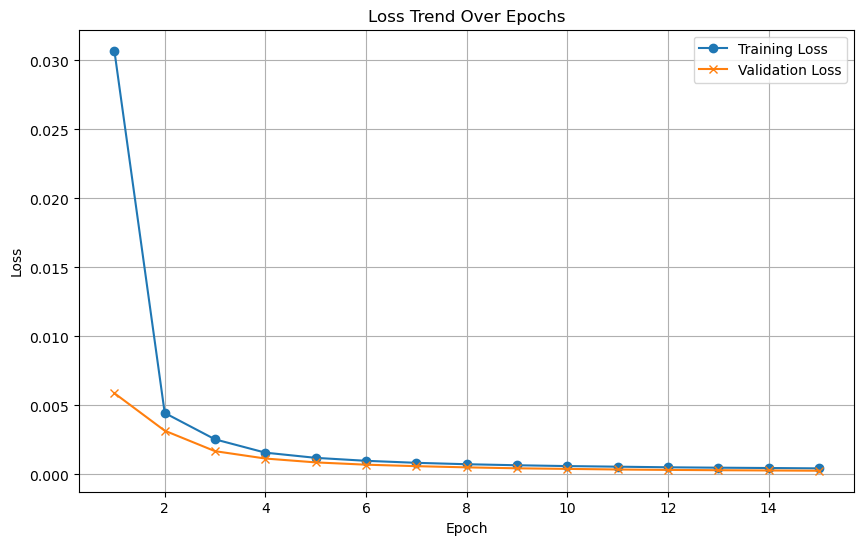

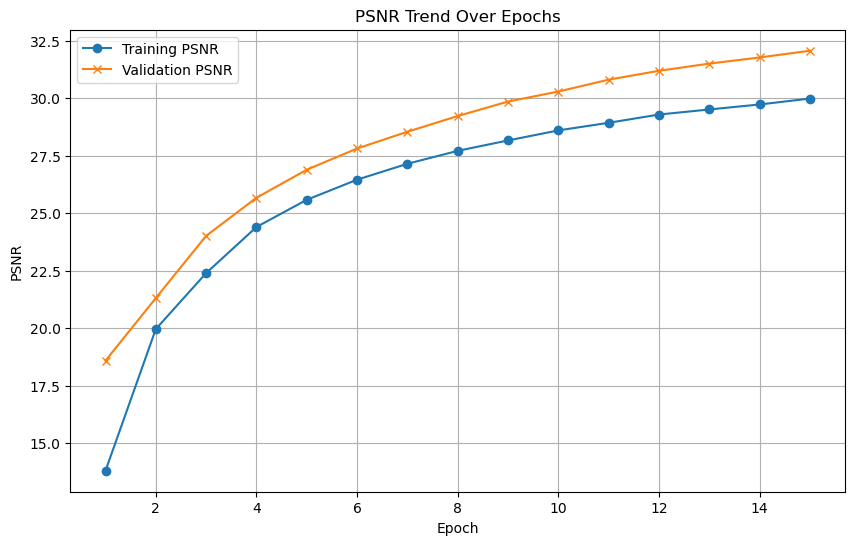

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/579 for test dataset.


    Processed batch 101/579 for test dataset.


    Processed batch 201/579 for test dataset.


    Processed batch 301/579 for test dataset.


    Processed batch 401/579 for test dataset.


    Processed batch 501/579 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.1925
    Validation Batch [1/1], Loss: 2.2016
Validation Loss: 2.2016, Validation Accuracy: 11.11%
Validation loss improved from inf to 2.2016. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.1783
    Validation Batch [1/1], Loss: 2.2015
Validation Loss: 2.2015, Validation Accuracy: 11.11%
Validation loss improved from 2.2016 to 2.2015. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.1463
    Validation Batch [1/1], Loss: 2.2015
Validation Loss: 2.2015, Validation Accuracy: 11.11%
Validation loss improved from 2.2015 to 2.2015. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.1159
    Validation Batch [1/1], Loss: 2.2015
Validation Loss: 2.2015, Validation Accuracy: 11.11%
Validation loss improved from 2.2015 to 2.2015. Saving model...

LOG: Epoch [5/1000

Epoch [7/1000] completed, Average Training Loss: 2.0766
    Validation Batch [1/1], Loss: 2.2014
Validation Loss: 2.2014, Validation Accuracy: 11.11%
Validation loss improved from 2.2014 to 2.2014. Saving model...

LOG: Epoch [8/1000] - Training
Epoch [8/1000] completed, Average Training Loss: 2.0378
    Validation Batch [1/1], Loss: 2.2014
Validation Loss: 2.2014, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [9/1000] - Training
Epoch [9/1000] completed, Average Training Loss: 2.0568
    Validation Batch [1/1], Loss: 2.2014
Validation Loss: 2.2014, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [10/1000] - Training
Epoch [10/1000] completed, Average Training Loss: 2.0332
    Validation Batch [1/1], Loss: 2.2014
Validation Loss: 2.2014, Validation Accuracy: 11.11%
Validation loss improved from 2.2014 to 2.2014. Saving model...

LOG: Epoch [11/1000] - Training
Epoch [11/1000] completed, Average Training

Epoch [41/1000] completed, Average Training Loss: 1.6875
    Validation Batch [1/1], Loss: 2.1015
Validation Loss: 2.1015, Validation Accuracy: 20.00%
Validation loss improved from 2.1150 to 2.1015. Saving model...

LOG: Epoch [42/1000] - Training
Epoch [42/1000] completed, Average Training Loss: 1.6377
    Validation Batch [1/1], Loss: 2.0864
Validation Loss: 2.0864, Validation Accuracy: 22.22%
Validation loss improved from 2.1015 to 2.0864. Saving model...

LOG: Epoch [43/1000] - Training
Epoch [43/1000] completed, Average Training Loss: 1.6487
    Validation Batch [1/1], Loss: 2.0707
Validation Loss: 2.0707, Validation Accuracy: 22.22%
Validation loss improved from 2.0864 to 2.0707. Saving model...

LOG: Epoch [44/1000] - Training
Epoch [44/1000] completed, Average Training Loss: 1.6498
    Validation Batch [1/1], Loss: 2.0543
Validation Loss: 2.0543, Validation Accuracy: 24.44%
Validation loss improved from 2.0707 to 2.0543. Saving model...

LOG: Epoch [45/1000] - Training
Epoch [4

    Validation Batch [1/1], Loss: 1.5626
Validation Loss: 1.5626, Validation Accuracy: 82.22%
Validation loss improved from 1.5745 to 1.5626. Saving model...

LOG: Epoch [74/1000] - Training
Epoch [74/1000] completed, Average Training Loss: 1.3676
    Validation Batch [1/1], Loss: 1.5469
Validation Loss: 1.5469, Validation Accuracy: 82.22%
Validation loss improved from 1.5626 to 1.5469. Saving model...

LOG: Epoch [75/1000] - Training
Epoch [75/1000] completed, Average Training Loss: 1.3320
    Validation Batch [1/1], Loss: 1.5317
Validation Loss: 1.5317, Validation Accuracy: 82.22%
Validation loss improved from 1.5469 to 1.5317. Saving model...

LOG: Epoch [76/1000] - Training
Epoch [76/1000] completed, Average Training Loss: 1.3668
    Validation Batch [1/1], Loss: 1.5142
Validation Loss: 1.5142, Validation Accuracy: 82.22%
Validation loss improved from 1.5317 to 1.5142. Saving model...

LOG: Epoch [77/1000] - Training
Epoch [77/1000] completed, Average Training Loss: 1.3373
    Vali

    Validation Batch [1/1], Loss: 1.2854
Validation Loss: 1.2854, Validation Accuracy: 88.89%
Validation loss improved from 1.2986 to 1.2854. Saving model...

LOG: Epoch [105/1000] - Training
Epoch [105/1000] completed, Average Training Loss: 1.0967
    Validation Batch [1/1], Loss: 1.2738
Validation Loss: 1.2738, Validation Accuracy: 91.11%
Validation loss improved from 1.2854 to 1.2738. Saving model...

LOG: Epoch [106/1000] - Training
Epoch [106/1000] completed, Average Training Loss: 1.1115
    Validation Batch [1/1], Loss: 1.2641
Validation Loss: 1.2641, Validation Accuracy: 88.89%
Validation loss improved from 1.2738 to 1.2641. Saving model...

LOG: Epoch [107/1000] - Training
Epoch [107/1000] completed, Average Training Loss: 1.0535
    Validation Batch [1/1], Loss: 1.2621
Validation Loss: 1.2621, Validation Accuracy: 88.89%
Validation loss improved from 1.2641 to 1.2621. Saving model...

LOG: Epoch [108/1000] - Training
Epoch [108/1000] completed, Average Training Loss: 1.1070


    Validation Batch [1/1], Loss: 1.0576
Validation Loss: 1.0576, Validation Accuracy: 93.33%
Validation loss improved from 1.0669 to 1.0576. Saving model...

LOG: Epoch [136/1000] - Training
Epoch [136/1000] completed, Average Training Loss: 0.8377
    Validation Batch [1/1], Loss: 1.0464
Validation Loss: 1.0464, Validation Accuracy: 93.33%
Validation loss improved from 1.0576 to 1.0464. Saving model...

LOG: Epoch [137/1000] - Training
Epoch [137/1000] completed, Average Training Loss: 0.7972
    Validation Batch [1/1], Loss: 1.0394
Validation Loss: 1.0394, Validation Accuracy: 93.33%
Validation loss improved from 1.0464 to 1.0394. Saving model...

LOG: Epoch [138/1000] - Training
Epoch [138/1000] completed, Average Training Loss: 0.8434
    Validation Batch [1/1], Loss: 1.0442
Validation Loss: 1.0442, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [139/1000] - Training
Epoch [139/1000] completed, Average Training Loss: 0.8810
    Validation 

Epoch [170/1000] completed, Average Training Loss: 0.6565
    Validation Batch [1/1], Loss: 0.8476
Validation Loss: 0.8476, Validation Accuracy: 93.33%
Validation loss improved from 0.8508 to 0.8476. Saving model...

LOG: Epoch [171/1000] - Training
Epoch [171/1000] completed, Average Training Loss: 0.6223
    Validation Batch [1/1], Loss: 0.8398
Validation Loss: 0.8398, Validation Accuracy: 93.33%
Validation loss improved from 0.8476 to 0.8398. Saving model...

LOG: Epoch [172/1000] - Training
Epoch [172/1000] completed, Average Training Loss: 0.6288
    Validation Batch [1/1], Loss: 0.8403
Validation Loss: 0.8403, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [173/1000] - Training
Epoch [173/1000] completed, Average Training Loss: 0.6308
    Validation Batch [1/1], Loss: 0.8441
Validation Loss: 0.8441, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [174/1000] - Training
Epoch [174/1000] completed, Av

Epoch [203/1000] completed, Average Training Loss: 0.5015
    Validation Batch [1/1], Loss: 0.6962
Validation Loss: 0.6962, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [204/1000] - Training
Epoch [204/1000] completed, Average Training Loss: 0.4593
    Validation Batch [1/1], Loss: 0.7114
Validation Loss: 0.7114, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [205/1000] - Training
Epoch [205/1000] completed, Average Training Loss: 0.4516
    Validation Batch [1/1], Loss: 0.7166
Validation Loss: 0.7166, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [206/1000] - Training
Epoch [206/1000] completed, Average Training Loss: 0.4298
    Validation Batch [1/1], Loss: 0.7057
Validation Loss: 0.7057, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [207/1000] - Training
Epoch [207/1000] completed, Average Training Loss: 0.4740
  

Epoch [235/1000] completed, Average Training Loss: 0.3667
    Validation Batch [1/1], Loss: 0.5643
Validation Loss: 0.5643, Validation Accuracy: 93.33%
Validation loss improved from 0.5717 to 0.5643. Saving model...

LOG: Epoch [236/1000] - Training
Epoch [236/1000] completed, Average Training Loss: 0.3752
    Validation Batch [1/1], Loss: 0.5754
Validation Loss: 0.5754, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [237/1000] - Training
Epoch [237/1000] completed, Average Training Loss: 0.3329
    Validation Batch [1/1], Loss: 0.5834
Validation Loss: 0.5834, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [238/1000] - Training
Epoch [238/1000] completed, Average Training Loss: 0.3068
    Validation Batch [1/1], Loss: 0.5851
Validation Loss: 0.5851, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [239/1000] - Training
Epoch [239/1000] completed, Average Training 

Validation Loss: 0.5072, Validation Accuracy: 95.56%
Validation loss improved from 0.5080 to 0.5072. Saving model...

LOG: Epoch [266/1000] - Training
Epoch [266/1000] completed, Average Training Loss: 0.2532
    Validation Batch [1/1], Loss: 0.5112
Validation Loss: 0.5112, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [267/1000] - Training
Epoch [267/1000] completed, Average Training Loss: 0.2359
    Validation Batch [1/1], Loss: 0.5171
Validation Loss: 0.5171, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [268/1000] - Training
Epoch [268/1000] completed, Average Training Loss: 0.2239
    Validation Batch [1/1], Loss: 0.5280
Validation Loss: 0.5280, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [269/1000] - Training
Epoch [269/1000] completed, Average Training Loss: 0.2153
    Validation Batch [1/1], Loss: 0.5298
Validation Loss: 0.5298, Validation Accuracy:

Epoch [295/1000] completed, Average Training Loss: 0.2165
    Validation Batch [1/1], Loss: 0.4283
Validation Loss: 0.4283, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [296/1000] - Training
Epoch [296/1000] completed, Average Training Loss: 0.2187
    Validation Batch [1/1], Loss: 0.4271
Validation Loss: 0.4271, Validation Accuracy: 95.56%
Validation loss improved from 0.4272 to 0.4271. Saving model...

LOG: Epoch [297/1000] - Training
Epoch [297/1000] completed, Average Training Loss: 0.2342
    Validation Batch [1/1], Loss: 0.4269
Validation Loss: 0.4269, Validation Accuracy: 95.56%
Validation loss improved from 0.4271 to 0.4269. Saving model...

LOG: Epoch [298/1000] - Training
Epoch [298/1000] completed, Average Training Loss: 0.2213
    Validation Batch [1/1], Loss: 0.4380
Validation Loss: 0.4380, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [299/1000] - Training
Epoch [299/1000] completed, Av

Epoch [328/1000] completed, Average Training Loss: 0.1635
    Validation Batch [1/1], Loss: 0.4578
Validation Loss: 0.4578, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [329/1000] - Training
Epoch [329/1000] completed, Average Training Loss: 0.1570
    Validation Batch [1/1], Loss: 0.4262
Validation Loss: 0.4262, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [330/1000] - Training
Epoch [330/1000] completed, Average Training Loss: 0.1207
    Validation Batch [1/1], Loss: 0.4017
Validation Loss: 0.4017, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [331/1000] - Training
Epoch [331/1000] completed, Average Training Loss: 0.1812
    Validation Batch [1/1], Loss: 0.3903
Validation Loss: 0.3903, Validation Accuracy: 93.33%
Validation loss improved from 0.3989 to 0.3903. Saving model...

LOG: Epoch [332/1000] - Training
Epoch [332/1000] completed, Average Training 

Epoch [359/1000] completed, Average Training Loss: 0.1394
    Validation Batch [1/1], Loss: 0.4396
Validation Loss: 0.4396, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [360/1000] - Training
Epoch [360/1000] completed, Average Training Loss: 0.1282
    Validation Batch [1/1], Loss: 0.4403
Validation Loss: 0.4403, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [361/1000] - Training
Epoch [361/1000] completed, Average Training Loss: 0.1378
    Validation Batch [1/1], Loss: 0.4323
Validation Loss: 0.4323, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [362/1000] - Training
Epoch [362/1000] completed, Average Training Loss: 0.1452
    Validation Batch [1/1], Loss: 0.4217
Validation Loss: 0.4217, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [363/1000] - Training
Epoch [363/1000] completed, Average Training Loss: 0.112

Epoch [389/1000] completed, Average Training Loss: 0.1404
    Validation Batch [1/1], Loss: 0.3866
Validation Loss: 0.3866, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [390/1000] - Training
Epoch [390/1000] completed, Average Training Loss: 0.0861
    Validation Batch [1/1], Loss: 0.4044
Validation Loss: 0.4044, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [391/1000] - Training
Epoch [391/1000] completed, Average Training Loss: 0.1206
    Validation Batch [1/1], Loss: 0.4127
Validation Loss: 0.4127, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 50/100

LOG: Epoch [392/1000] - Training
Epoch [392/1000] completed, Average Training Loss: 0.1060
    Validation Batch [1/1], Loss: 0.4114
Validation Loss: 0.4114, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 51/100

LOG: Epoch [393/1000] - Training
Epoch [393/1000] completed, Average Training Loss: 0.117

Epoch [422/1000] completed, Average Training Loss: 0.0977
    Validation Batch [1/1], Loss: 0.4169
Validation Loss: 0.4169, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [423/1000] - Training
Epoch [423/1000] completed, Average Training Loss: 0.0890
    Validation Batch [1/1], Loss: 0.4169
Validation Loss: 0.4169, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [424/1000] - Training
Epoch [424/1000] completed, Average Training Loss: 0.1090
    Validation Batch [1/1], Loss: 0.4203
Validation Loss: 0.4203, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [425/1000] - Training
Epoch [425/1000] completed, Average Training Loss: 0.0871
    Validation Batch [1/1], Loss: 0.4208
Validation Loss: 0.4208, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [426/1000] - Training
Epoch [426/1000] completed, Average Training Loss: 0.080

Epoch [457/1000] completed, Average Training Loss: 0.0608
    Validation Batch [1/1], Loss: 0.3783
Validation Loss: 0.3783, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [458/1000] - Training
Epoch [458/1000] completed, Average Training Loss: 0.0770
    Validation Batch [1/1], Loss: 0.3921
Validation Loss: 0.3921, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [459/1000] - Training
Epoch [459/1000] completed, Average Training Loss: 0.0668
    Validation Batch [1/1], Loss: 0.4120
Validation Loss: 0.4120, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [460/1000] - Training
Epoch [460/1000] completed, Average Training Loss: 0.0622
    Validation Batch [1/1], Loss: 0.4339
Validation Loss: 0.4339, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [461/1000] - Training
Epoch [461/1000] completed, Average Training Loss: 0.085

Epoch [492/1000] completed, Average Training Loss: 0.0717
    Validation Batch [1/1], Loss: 0.4046
Validation Loss: 0.4046, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 51/100

LOG: Epoch [493/1000] - Training
Epoch [493/1000] completed, Average Training Loss: 0.0643
    Validation Batch [1/1], Loss: 0.4053
Validation Loss: 0.4053, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 52/100

LOG: Epoch [494/1000] - Training
Epoch [494/1000] completed, Average Training Loss: 0.0404
    Validation Batch [1/1], Loss: 0.3963
Validation Loss: 0.3963, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 53/100

LOG: Epoch [495/1000] - Training
Epoch [495/1000] completed, Average Training Loss: 0.0654
    Validation Batch [1/1], Loss: 0.4049
Validation Loss: 0.4049, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 54/100

LOG: Epoch [496/1000] - Training
Epoch [496/1000] completed, Average Training Loss: 0.073

    Validation Batch [1/1], Loss: 0.3544
Validation Loss: 0.3544, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 84/100

LOG: Epoch [526/1000] - Training
Epoch [526/1000] completed, Average Training Loss: 0.0613
    Validation Batch [1/1], Loss: 0.3586
Validation Loss: 0.3586, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 85/100

LOG: Epoch [527/1000] - Training
Epoch [527/1000] completed, Average Training Loss: 0.0454
    Validation Batch [1/1], Loss: 0.3588
Validation Loss: 0.3588, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 86/100

LOG: Epoch [528/1000] - Training
Epoch [528/1000] completed, Average Training Loss: 0.0472
    Validation Batch [1/1], Loss: 0.3783
Validation Loss: 0.3783, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 87/100

LOG: Epoch [529/1000] - Training
Epoch [529/1000] completed, Average Training Loss: 0.0428
    Validation Batch [1/1], Loss: 0.3870
Validation Loss

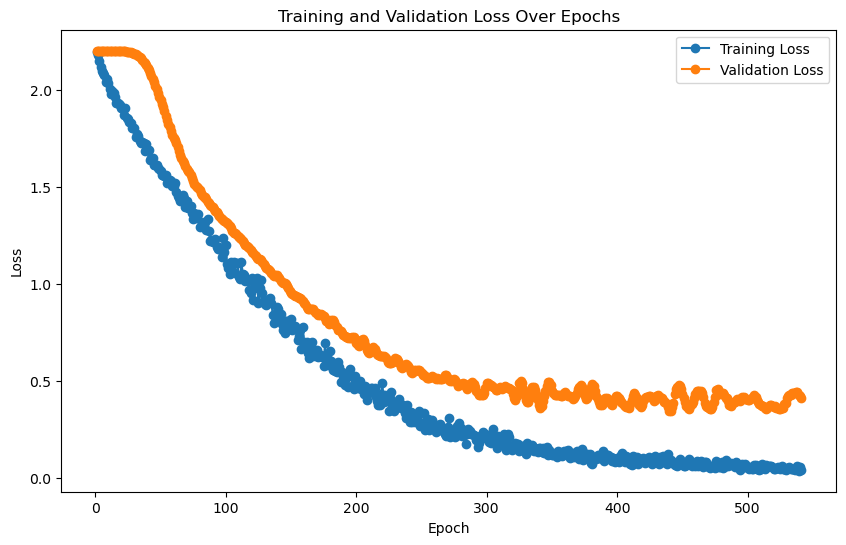

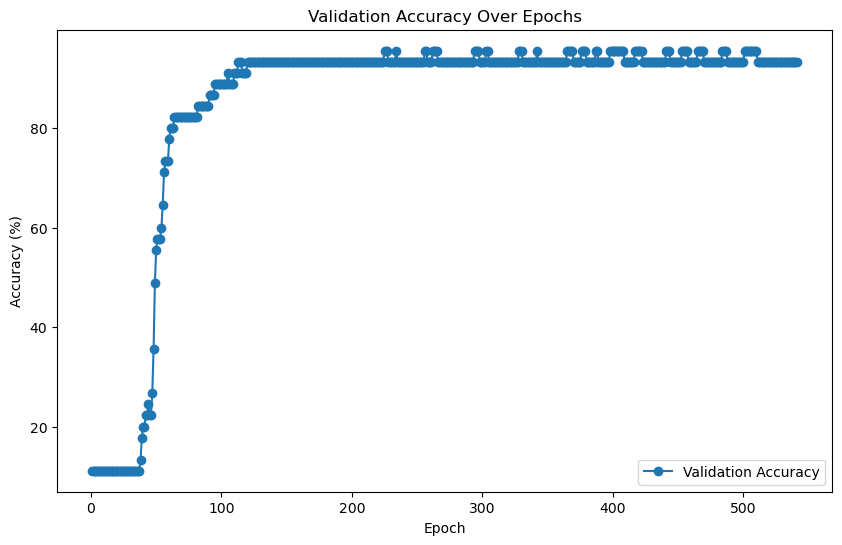


Evaluating on the test set...
    Test Batch [1/579], Loss: 0.2403



Final Test Loss: 0.1892, Test Accuracy: 96.55%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/579 for test dataset.
  Processed batch 20/579 for test dataset.
  Processed batch 30/579 for test dataset.


  Processed batch 40/579 for test dataset.


  Processed batch 50/579 for test dataset.
  Processed batch 60/579 for test dataset.
  Processed batch 70/579 for test dataset.
  Processed batch 80/579 for test dataset.


  Processed batch 90/579 for test dataset.


  Processed batch 100/579 for test dataset.
  Processed batch 110/579 for test dataset.
  Processed batch 120/579 for test dataset.
  Processed batch 130/579 for test dataset.


  Processed batch 140/579 for test dataset.


  Processed batch 150/579 for test dataset.
  Processed batch 160/579 for test dataset.
  Processed batch 170/579 for test dataset.
  Processed batch 180/579 for test dataset.


  Processed batch 190/579 for test dataset.
  Processed batch 200/579 for test dataset.


  Processed batch 210/579 for test dataset.
  Processed batch 220/579 for test dataset.
  Processed batch 230/579 for test dataset.


  Processed batch 240/579 for test dataset.
  Processed batch 250/579 for test dataset.


  Processed batch 260/579 for test dataset.
  Processed batch 270/579 for test dataset.
  Processed batch 280/579 for test dataset.
  Processed batch 290/579 for test dataset.


  Processed batch 300/579 for test dataset.


  Processed batch 310/579 for test dataset.
  Processed batch 320/579 for test dataset.
  Processed batch 330/579 for test dataset.
  Processed batch 340/579 for test dataset.


  Processed batch 350/579 for test dataset.


  Processed batch 360/579 for test dataset.
  Processed batch 370/579 for test dataset.
  Processed batch 380/579 for test dataset.
  Processed batch 390/579 for test dataset.


  Processed batch 400/579 for test dataset.


  Processed batch 410/579 for test dataset.
  Processed batch 420/579 for test dataset.
  Processed batch 430/579 for test dataset.
  Processed batch 440/579 for test dataset.


  Processed batch 450/579 for test dataset.


  Processed batch 460/579 for test dataset.
  Processed batch 470/579 for test dataset.
  Processed batch 480/579 for test dataset.
  Processed batch 490/579 for test dataset.


  Processed batch 500/579 for test dataset.


  Processed batch 510/579 for test dataset.
  Processed batch 520/579 for test dataset.
  Processed batch 530/579 for test dataset.
  Processed batch 540/579 for test dataset.


  Processed batch 550/579 for test dataset.


  Processed batch 560/579 for test dataset.
  Processed batch 570/579 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 148062 samples with 64 features each
LOG: Labels shape: (148062,)

LOG: Training features shape: (45, 64), Training labels shape: (45,)
LOG: Validation features shape: (45, 64), Validation labels shape: (45,)
LOG: Test features shape: (148062, 64), Test labels shape: (148062,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 88.89%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.80      0.89         5
           2       0.83      1.00      0.91         5
           3       0.62      1.00      0.77         5
           4       1.00      0.60      0.75         5
           5       1.00      0.80      0.89         5
           6       0.83      1.00      0.91         5
           7       1.00      0.80      0.89         5
           8       1.00      

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 148062 samples with 64 features each
LOG: Labels shape: (148062,)
Train reps shape: (45, 64)
Train labels shape: (45,)
Val reps shape: (45, 64)
Val labels shape: (45,)
Test reps shape: (148062, 64)
Test labels shape: (148062,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.2648  |  Val Loss: 2.1537
Validation loss improved from inf to 2.1537.
[Epoch 2/1000] Train Loss: 2.1426  |  Val Loss: 2.0719
Validation loss improved from 2.1537 to 2.0719.
[Epoch 3/1000] Train Loss: 2.0534  |  Val Loss: 2.0107
Validation loss improved from 2.0719 to 2.0107.
[Epoch 4/1000] Train Loss: 1.9896  |  Val Loss: 1.9565
Validation loss improved from 2.0107 to 1.9565.
[Epoch 5/1000] Train Loss: 1.9344  |  Val Loss: 1.9085
Validation loss improved from 1.9565 to 1.9085.
[Epoch 6/1000] Train Loss: 1.8858  |  Val Loss: 1.8671
Validation loss improved from 1.9085 to 1.8671.
[Epoch 7/1000] Train Loss: 1.8439  |  Val Loss: 1.8335
Validation loss improved from 1.8671 to 1.8335.
[Epoch 8/1000] Train Loss: 1.8072  |  Val Loss: 1.8032
Validation loss improved from 1.8335 to 1.8032.
[Epoch 9/1000] Train Loss: 1.7752  |  Val Loss: 1.7724
Validation loss improved from 1.8032 to 1.7724.
[Epoch 10/1000] Train Loss: 1.7433  |  Val Loss: 1.7430
Validation loss impr

[Epoch 15/1000] Train Loss: 1.5886  |  Val Loss: 1.6221
Validation loss improved from 1.6461 to 1.6221.
[Epoch 16/1000] Train Loss: 1.5548  |  Val Loss: 1.5973
Validation loss improved from 1.6221 to 1.5973.
[Epoch 17/1000] Train Loss: 1.5202  |  Val Loss: 1.5722
Validation loss improved from 1.5973 to 1.5722.
[Epoch 18/1000] Train Loss: 1.4853  |  Val Loss: 1.5467
Validation loss improved from 1.5722 to 1.5467.
[Epoch 19/1000] Train Loss: 1.4513  |  Val Loss: 1.5214
Validation loss improved from 1.5467 to 1.5214.
[Epoch 20/1000] Train Loss: 1.4175  |  Val Loss: 1.4964
Validation loss improved from 1.5214 to 1.4964.
[Epoch 21/1000] Train Loss: 1.3848  |  Val Loss: 1.4719
Validation loss improved from 1.4964 to 1.4719.
[Epoch 22/1000] Train Loss: 1.3527  |  Val Loss: 1.4483
Validation loss improved from 1.4719 to 1.4483.
[Epoch 23/1000] Train Loss: 1.3208  |  Val Loss: 1.4252
Validation loss improved from 1.4483 to 1.4252.
[Epoch 24/1000] Train Loss: 1.2894  |  Val Loss: 1.4002
Validati

[Epoch 73/1000] Train Loss: 0.1851  |  Val Loss: 0.6627
Validation loss improved from 0.6670 to 0.6627.
[Epoch 74/1000] Train Loss: 0.1748  |  Val Loss: 0.6593
Validation loss improved from 0.6627 to 0.6593.
[Epoch 75/1000] Train Loss: 0.1651  |  Val Loss: 0.6557
Validation loss improved from 0.6593 to 0.6557.
[Epoch 76/1000] Train Loss: 0.1560  |  Val Loss: 0.6516
Validation loss improved from 0.6557 to 0.6516.
[Epoch 77/1000] Train Loss: 0.1476  |  Val Loss: 0.6474
Validation loss improved from 0.6516 to 0.6474.
[Epoch 78/1000] Train Loss: 0.1396  |  Val Loss: 0.6430
Validation loss improved from 0.6474 to 0.6430.
[Epoch 79/1000] Train Loss: 0.1320  |  Val Loss: 0.6389
Validation loss improved from 0.6430 to 0.6389.
[Epoch 80/1000] Train Loss: 0.1249  |  Val Loss: 0.6353
Validation loss improved from 0.6389 to 0.6353.
[Epoch 81/1000] Train Loss: 0.1183  |  Val Loss: 0.6325
Validation loss improved from 0.6353 to 0.6325.
[Epoch 82/1000] Train Loss: 0.1121  |  Val Loss: 0.6307
Validati

[Epoch 85/1000] Train Loss: 0.0957  |  Val Loss: 0.6275
Validation loss improved from 0.6287 to 0.6275.
[Epoch 86/1000] Train Loss: 0.0909  |  Val Loss: 0.6260
Validation loss improved from 0.6275 to 0.6260.
[Epoch 87/1000] Train Loss: 0.0864  |  Val Loss: 0.6247
Validation loss improved from 0.6260 to 0.6247.
[Epoch 88/1000] Train Loss: 0.0822  |  Val Loss: 0.6236
Validation loss improved from 0.6247 to 0.6236.
[Epoch 89/1000] Train Loss: 0.0782  |  Val Loss: 0.6225
Validation loss improved from 0.6236 to 0.6225.
[Epoch 90/1000] Train Loss: 0.0744  |  Val Loss: 0.6213
Validation loss improved from 0.6225 to 0.6213.
[Epoch 91/1000] Train Loss: 0.0709  |  Val Loss: 0.6202
Validation loss improved from 0.6213 to 0.6202.
[Epoch 92/1000] Train Loss: 0.0675  |  Val Loss: 0.6194
Validation loss improved from 0.6202 to 0.6194.
[Epoch 93/1000] Train Loss: 0.0642  |  Val Loss: 0.6188
Validation loss improved from 0.6194 to 0.6188.
[Epoch 94/1000] Train Loss: 0.0611  |  Val Loss: 0.6182
Validati

[Epoch 150/1000] Train Loss: 0.0117  |  Val Loss: 0.6689
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 151/1000] Train Loss: 0.0115  |  Val Loss: 0.6699
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 152/1000] Train Loss: 0.0113  |  Val Loss: 0.6712
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 153/1000] Train Loss: 0.0111  |  Val Loss: 0.6722
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 154/1000] Train Loss: 0.0109  |  Val Loss: 0.6730
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 155/1000] Train Loss: 0.0107  |  Val Loss: 0.6740
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 156/1000] Train Loss: 0.0105  |  Val Loss: 0.6756
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 157/1000] Train Loss: 0.0103  |  Val Loss: 0.6772
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 158/1000] Train Loss: 0.0102  |  Val Loss: 0.6787
!! Validation loss did NOT improve !! Patience:

[Epoch 162/1000] Train Loss: 0.0095  |  Val Loss: 0.6817
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 163/1000] Train Loss: 0.0094  |  Val Loss: 0.6828
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 164/1000] Train Loss: 0.0092  |  Val Loss: 0.6839
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 165/1000] Train Loss: 0.0091  |  Val Loss: 0.6848
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 166/1000] Train Loss: 0.0089  |  Val Loss: 0.6857
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 167/1000] Train Loss: 0.0088  |  Val Loss: 0.6865
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 168/1000] Train Loss: 0.0086  |  Val Loss: 0.6877
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 169/1000] Train Loss: 0.0085  |  Val Loss: 0.6891
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 170/1000] Train Loss: 0.0084  |  Val Loss: 0.6902
!! Validation loss did NOT improve !! Patience:

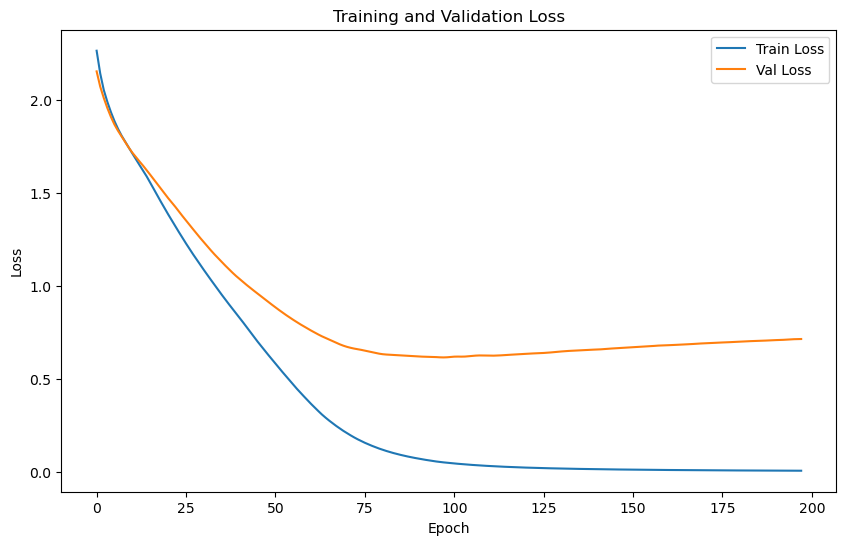

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 0.3639 | Test Accuracy: 87.56%


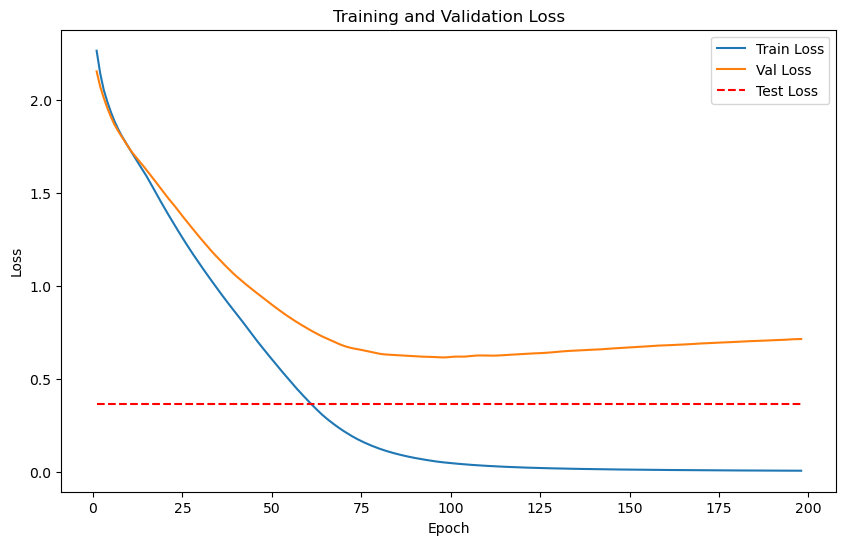

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 148062 samples with 64 features each
LOG: Labels shape: (148062,)


Train embeddings shape: (45, 64), 
Train labels shape: (45,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (148062, 64), 
Test labels shape: (148062,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5}
Training batch size: 45


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 9.2261
Epoch [1/2000], Avg Train Loss: 9.2261


Epoch [1/2000], Avg Val Loss: 4.1416
Validation loss improved from inf to 4.1416. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 9.0624
Epoch [2/2000], Avg Train Loss: 9.0624
Epoch [2/2000], Avg Val Loss: 4.0982
Validation loss improved from 4.1416 to 4.0982. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.5883
Epoch [3/2000], Avg Train Loss: 8.5883
Epoch [3/2000], Avg Val Loss: 4.0551
Validation loss improved from 4.0982 to 4.0551. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 8.5455
Epoch [4/2000], Avg Train Loss: 8.5455
Epoch [4/2000], Avg Val Loss: 4.0129
Validation loss improved from 4.0551 to 4.0129. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.1714
Epoch [5/2000], Avg Train Loss: 8.1714
Epoch [5/2000], Avg Val Loss: 3.9720
Validation loss improved from 4.0129 to 3.9720. Saving model...

LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 8.6132
Ep

    Batch [1/1], Train Loss: 7.6771
Epoch [16/2000], Avg Train Loss: 7.6771
Epoch [16/2000], Avg Val Loss: 3.5832
Validation loss improved from 3.6141 to 3.5832. Saving model...

LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 7.3687
Epoch [17/2000], Avg Train Loss: 7.3687
Epoch [17/2000], Avg Val Loss: 3.5532
Validation loss improved from 3.5832 to 3.5532. Saving model...

LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 7.8345
Epoch [18/2000], Avg Train Loss: 7.8345
Epoch [18/2000], Avg Val Loss: 3.5240
Validation loss improved from 3.5532 to 3.5240. Saving model...

LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 7.2652
Epoch [19/2000], Avg Train Loss: 7.2652
Epoch [19/2000], Avg Val Loss: 3.4958
Validation loss improved from 3.5240 to 3.4958. Saving model...

LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 7.2327
Epoch [20/2000], Avg Train Loss: 7.2327
Epoch [20/2000], Avg Val Loss: 3.4682
Validation loss improved from 3.4958 to 3.

    Batch [1/1], Train Loss: 5.8094
Epoch [54/2000], Avg Train Loss: 5.8094
Epoch [54/2000], Avg Val Loss: 2.8997
Validation loss improved from 2.9090 to 2.8997. Saving model...

LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 5.7153
Epoch [55/2000], Avg Train Loss: 5.7153
Epoch [55/2000], Avg Val Loss: 2.8906
Validation loss improved from 2.8997 to 2.8906. Saving model...

LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 5.1686
Epoch [56/2000], Avg Train Loss: 5.1686
Epoch [56/2000], Avg Val Loss: 2.8819
Validation loss improved from 2.8906 to 2.8819. Saving model...

LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 5.3909
Epoch [57/2000], Avg Train Loss: 5.3909
Epoch [57/2000], Avg Val Loss: 2.8734
Validation loss improved from 2.8819 to 2.8734. Saving model...

LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 5.2899
Epoch [58/2000], Avg Train Loss: 5.2899
Epoch [58/2000], Avg Val Loss: 2.8654
Validation loss improved from 2.8734 to 2.

    Batch [1/1], Train Loss: 4.8951
Epoch [71/2000], Avg Train Loss: 4.8951
Epoch [71/2000], Avg Val Loss: 2.7810
Validation loss improved from 2.7863 to 2.7810. Saving model...

LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 4.8791
Epoch [72/2000], Avg Train Loss: 4.8791
Epoch [72/2000], Avg Val Loss: 2.7760
Validation loss improved from 2.7810 to 2.7760. Saving model...

LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 4.8594
Epoch [73/2000], Avg Train Loss: 4.8594
Epoch [73/2000], Avg Val Loss: 2.7711
Validation loss improved from 2.7760 to 2.7711. Saving model...

LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 4.6738
Epoch [74/2000], Avg Train Loss: 4.6738
Epoch [74/2000], Avg Val Loss: 2.7664
Validation loss improved from 2.7711 to 2.7664. Saving model...

LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 4.9296
Epoch [75/2000], Avg Train Loss: 4.9296
Epoch [75/2000], Avg Val Loss: 2.7618
Validation loss improved from 2.7664 to 2.

Epoch [103/2000], Avg Val Loss: 2.6793
Validation loss improved from 2.6811 to 2.6793. Saving model...

LOG: Epoch [104/2000] - Training
    Batch [1/1], Train Loss: 4.1177
Epoch [104/2000], Avg Train Loss: 4.1177
Epoch [104/2000], Avg Val Loss: 2.6775
Validation loss improved from 2.6793 to 2.6775. Saving model...

LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 4.0267
Epoch [105/2000], Avg Train Loss: 4.0267
Epoch [105/2000], Avg Val Loss: 2.6757
Validation loss improved from 2.6775 to 2.6757. Saving model...

LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 4.0799
Epoch [106/2000], Avg Train Loss: 4.0799
Epoch [106/2000], Avg Val Loss: 2.6741
Validation loss improved from 2.6757 to 2.6741. Saving model...

LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 4.2992
Epoch [107/2000], Avg Train Loss: 4.2992
Epoch [107/2000], Avg Val Loss: 2.6725
Validation loss improved from 2.6741 to 2.6725. Saving model...

LOG: Epoch [108/2000] - Training
    Bat

Epoch [117/2000], Avg Val Loss: 2.6592
Validation loss improved from 2.6604 to 2.6592. Saving model...

LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 3.8672
Epoch [118/2000], Avg Train Loss: 3.8672
Epoch [118/2000], Avg Val Loss: 2.6580
Validation loss improved from 2.6592 to 2.6580. Saving model...

LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 4.0768
Epoch [119/2000], Avg Train Loss: 4.0768
Epoch [119/2000], Avg Val Loss: 2.6568
Validation loss improved from 2.6580 to 2.6568. Saving model...

LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 4.2566
Epoch [120/2000], Avg Train Loss: 4.2566
Epoch [120/2000], Avg Val Loss: 2.6557
Validation loss improved from 2.6568 to 2.6557. Saving model...

LOG: Epoch [121/2000] - Training
    Batch [1/1], Train Loss: 3.8193
Epoch [121/2000], Avg Train Loss: 3.8193
Epoch [121/2000], Avg Val Loss: 2.6546
Validation loss improved from 2.6557 to 2.6546. Saving model...

LOG: Epoch [122/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.7348
Epoch [151/2000], Avg Train Loss: 3.7348
Epoch [151/2000], Avg Val Loss: 2.6313
Validation loss improved from 2.6318 to 2.6313. Saving model...

LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 3.7658
Epoch [152/2000], Avg Train Loss: 3.7658
Epoch [152/2000], Avg Val Loss: 2.6307
Validation loss improved from 2.6313 to 2.6307. Saving model...

LOG: Epoch [153/2000] - Training
    Batch [1/1], Train Loss: 3.7796
Epoch [153/2000], Avg Train Loss: 3.7796
Epoch [153/2000], Avg Val Loss: 2.6302
Validation loss improved from 2.6307 to 2.6302. Saving model...

LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 3.4619
Epoch [154/2000], Avg Train Loss: 3.4619
Epoch [154/2000], Avg Val Loss: 2.6297
Validation loss improved from 2.6302 to 2.6297. Saving model...

LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 3.5602
Epoch [155/2000], Avg Train Loss: 3.5602
Epoch [155/2000], Avg Val Loss: 2.6291
Validation loss improved fro

    Batch [1/1], Train Loss: 3.6985
Epoch [162/2000], Avg Train Loss: 3.6985
Epoch [162/2000], Avg Val Loss: 2.6254
Validation loss improved from 2.6259 to 2.6254. Saving model...

LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 3.6751
Epoch [163/2000], Avg Train Loss: 3.6751
Epoch [163/2000], Avg Val Loss: 2.6249
Validation loss improved from 2.6254 to 2.6249. Saving model...

LOG: Epoch [164/2000] - Training
    Batch [1/1], Train Loss: 3.5405
Epoch [164/2000], Avg Train Loss: 3.5405
Epoch [164/2000], Avg Val Loss: 2.6245
Validation loss improved from 2.6249 to 2.6245. Saving model...

LOG: Epoch [165/2000] - Training
    Batch [1/1], Train Loss: 3.4035
Epoch [165/2000], Avg Train Loss: 3.4035
Epoch [165/2000], Avg Val Loss: 2.6240
Validation loss improved from 2.6245 to 2.6240. Saving model...

LOG: Epoch [166/2000] - Training
    Batch [1/1], Train Loss: 3.4209
Epoch [166/2000], Avg Train Loss: 3.4209
Epoch [166/2000], Avg Val Loss: 2.6236
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3137
Epoch [201/2000], Avg Train Loss: 3.3137
Epoch [201/2000], Avg Val Loss: 2.6059
Validation loss improved from 2.6064 to 2.6059. Saving model...

LOG: Epoch [202/2000] - Training
    Batch [1/1], Train Loss: 3.3102
Epoch [202/2000], Avg Train Loss: 3.3102
Epoch [202/2000], Avg Val Loss: 2.6053
Validation loss improved from 2.6059 to 2.6053. Saving model...

LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 3.4157
Epoch [203/2000], Avg Train Loss: 3.4157
Epoch [203/2000], Avg Val Loss: 2.6048
Validation loss improved from 2.6053 to 2.6048. Saving model...

LOG: Epoch [204/2000] - Training
    Batch [1/1], Train Loss: 3.3596
Epoch [204/2000], Avg Train Loss: 3.3596
Epoch [204/2000], Avg Val Loss: 2.6043
Validation loss improved from 2.6048 to 2.6043. Saving model...

LOG: Epoch [205/2000] - Training
    Batch [1/1], Train Loss: 3.2814
Epoch [205/2000], Avg Train Loss: 3.2814
Epoch [205/2000], Avg Val Loss: 2.6037
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3282
Epoch [212/2000], Avg Train Loss: 3.3282
Epoch [212/2000], Avg Val Loss: 2.6000
Validation loss improved from 2.6005 to 2.6000. Saving model...

LOG: Epoch [213/2000] - Training
    Batch [1/1], Train Loss: 3.1661
Epoch [213/2000], Avg Train Loss: 3.1661
Epoch [213/2000], Avg Val Loss: 2.5994
Validation loss improved from 2.6000 to 2.5994. Saving model...

LOG: Epoch [214/2000] - Training
    Batch [1/1], Train Loss: 3.2649
Epoch [214/2000], Avg Train Loss: 3.2649
Epoch [214/2000], Avg Val Loss: 2.5988
Validation loss improved from 2.5994 to 2.5988. Saving model...

LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 3.3063
Epoch [215/2000], Avg Train Loss: 3.3063
Epoch [215/2000], Avg Val Loss: 2.5982
Validation loss improved from 2.5988 to 2.5982. Saving model...

LOG: Epoch [216/2000] - Training
    Batch [1/1], Train Loss: 3.3781
Epoch [216/2000], Avg Train Loss: 3.3781
Epoch [216/2000], Avg Val Loss: 2.5977
Validation loss improved fro

Epoch [248/2000], Avg Val Loss: 2.5791
Validation loss improved from 2.5797 to 2.5791. Saving model...

LOG: Epoch [249/2000] - Training
    Batch [1/1], Train Loss: 3.2014
Epoch [249/2000], Avg Train Loss: 3.2014
Epoch [249/2000], Avg Val Loss: 2.5785
Validation loss improved from 2.5791 to 2.5785. Saving model...

LOG: Epoch [250/2000] - Training
    Batch [1/1], Train Loss: 3.1542
Epoch [250/2000], Avg Train Loss: 3.1542
Epoch [250/2000], Avg Val Loss: 2.5779
Validation loss improved from 2.5785 to 2.5779. Saving model...

LOG: Epoch [251/2000] - Training
    Batch [1/1], Train Loss: 3.2204
Epoch [251/2000], Avg Train Loss: 3.2204
Epoch [251/2000], Avg Val Loss: 2.5774
Validation loss improved from 2.5779 to 2.5774. Saving model...

LOG: Epoch [252/2000] - Training
    Batch [1/1], Train Loss: 3.1203
Epoch [252/2000], Avg Train Loss: 3.1203
Epoch [252/2000], Avg Val Loss: 2.5768
Validation loss improved from 2.5774 to 2.5768. Saving model...

LOG: Epoch [253/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.0555
Epoch [268/2000], Avg Train Loss: 3.0555
Epoch [268/2000], Avg Val Loss: 2.5674
Validation loss improved from 2.5681 to 2.5674. Saving model...

LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 3.0135
Epoch [269/2000], Avg Train Loss: 3.0135
Epoch [269/2000], Avg Val Loss: 2.5668
Validation loss improved from 2.5674 to 2.5668. Saving model...

LOG: Epoch [270/2000] - Training
    Batch [1/1], Train Loss: 3.1838
Epoch [270/2000], Avg Train Loss: 3.1838
Epoch [270/2000], Avg Val Loss: 2.5662
Validation loss improved from 2.5668 to 2.5662. Saving model...

LOG: Epoch [271/2000] - Training
    Batch [1/1], Train Loss: 3.2392
Epoch [271/2000], Avg Train Loss: 3.2392
Epoch [271/2000], Avg Val Loss: 2.5656
Validation loss improved from 2.5662 to 2.5656. Saving model...

LOG: Epoch [272/2000] - Training
    Batch [1/1], Train Loss: 3.1086
Epoch [272/2000], Avg Train Loss: 3.1086
Epoch [272/2000], Avg Val Loss: 2.5650
Validation loss improved fro

    Batch [1/1], Train Loss: 2.9944
Epoch [298/2000], Avg Train Loss: 2.9944
Epoch [298/2000], Avg Val Loss: 2.5482
Validation loss improved from 2.5488 to 2.5482. Saving model...

LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 3.1145
Epoch [299/2000], Avg Train Loss: 3.1145
Epoch [299/2000], Avg Val Loss: 2.5475
Validation loss improved from 2.5482 to 2.5475. Saving model...

LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 3.0072
Epoch [300/2000], Avg Train Loss: 3.0072
Epoch [300/2000], Avg Val Loss: 2.5469
Validation loss improved from 2.5475 to 2.5469. Saving model...

LOG: Epoch [301/2000] - Training
    Batch [1/1], Train Loss: 3.0292
Epoch [301/2000], Avg Train Loss: 3.0292
Epoch [301/2000], Avg Val Loss: 2.5462
Validation loss improved from 2.5469 to 2.5462. Saving model...

LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 3.1077
Epoch [302/2000], Avg Train Loss: 3.1077
Epoch [302/2000], Avg Val Loss: 2.5456
Validation loss improved fro

Epoch [316/2000], Avg Val Loss: 2.5364
Validation loss improved from 2.5371 to 2.5364. Saving model...

LOG: Epoch [317/2000] - Training
    Batch [1/1], Train Loss: 3.0321
Epoch [317/2000], Avg Train Loss: 3.0321
Epoch [317/2000], Avg Val Loss: 2.5358
Validation loss improved from 2.5364 to 2.5358. Saving model...

LOG: Epoch [318/2000] - Training
    Batch [1/1], Train Loss: 2.9770
Epoch [318/2000], Avg Train Loss: 2.9770
Epoch [318/2000], Avg Val Loss: 2.5351
Validation loss improved from 2.5358 to 2.5351. Saving model...

LOG: Epoch [319/2000] - Training
    Batch [1/1], Train Loss: 3.0029
Epoch [319/2000], Avg Train Loss: 3.0029
Epoch [319/2000], Avg Val Loss: 2.5344
Validation loss improved from 2.5351 to 2.5344. Saving model...

LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 2.9309
Epoch [320/2000], Avg Train Loss: 2.9309
Epoch [320/2000], Avg Val Loss: 2.5338
Validation loss improved from 2.5344 to 2.5338. Saving model...

LOG: Epoch [321/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.0338
Epoch [348/2000], Avg Train Loss: 3.0338
Epoch [348/2000], Avg Val Loss: 2.5154
Validation loss improved from 2.5160 to 2.5154. Saving model...

LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 2.9266
Epoch [349/2000], Avg Train Loss: 2.9266
Epoch [349/2000], Avg Val Loss: 2.5148
Validation loss improved from 2.5154 to 2.5148. Saving model...

LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 2.8652
Epoch [350/2000], Avg Train Loss: 2.8652
Epoch [350/2000], Avg Val Loss: 2.5143
Validation loss improved from 2.5148 to 2.5143. Saving model...

LOG: Epoch [351/2000] - Training
    Batch [1/1], Train Loss: 2.9226
Epoch [351/2000], Avg Train Loss: 2.9226
Epoch [351/2000], Avg Val Loss: 2.5137
Validation loss improved from 2.5143 to 2.5137. Saving model...

LOG: Epoch [352/2000] - Training
    Batch [1/1], Train Loss: 2.8664
Epoch [352/2000], Avg Train Loss: 2.8664
Epoch [352/2000], Avg Val Loss: 2.5130
Validation loss improved fro

Epoch [364/2000], Avg Val Loss: 2.5054
Validation loss improved from 2.5061 to 2.5054. Saving model...

LOG: Epoch [365/2000] - Training
    Batch [1/1], Train Loss: 2.9317
Epoch [365/2000], Avg Train Loss: 2.9317
Epoch [365/2000], Avg Val Loss: 2.5048
Validation loss improved from 2.5054 to 2.5048. Saving model...

LOG: Epoch [366/2000] - Training
    Batch [1/1], Train Loss: 2.8517
Epoch [366/2000], Avg Train Loss: 2.8517
Epoch [366/2000], Avg Val Loss: 2.5042
Validation loss improved from 2.5048 to 2.5042. Saving model...

LOG: Epoch [367/2000] - Training
    Batch [1/1], Train Loss: 2.8980
Epoch [367/2000], Avg Train Loss: 2.8980
Epoch [367/2000], Avg Val Loss: 2.5036
Validation loss improved from 2.5042 to 2.5036. Saving model...

LOG: Epoch [368/2000] - Training
    Batch [1/1], Train Loss: 2.9948
Epoch [368/2000], Avg Train Loss: 2.9948
Epoch [368/2000], Avg Val Loss: 2.5029
Validation loss improved from 2.5036 to 2.5029. Saving model...

LOG: Epoch [369/2000] - Training
    Bat

Epoch [398/2000], Avg Val Loss: 2.4850
Validation loss improved from 2.4856 to 2.4850. Saving model...

LOG: Epoch [399/2000] - Training
    Batch [1/1], Train Loss: 2.7375
Epoch [399/2000], Avg Train Loss: 2.7375
Epoch [399/2000], Avg Val Loss: 2.4845
Validation loss improved from 2.4850 to 2.4845. Saving model...

LOG: Epoch [400/2000] - Training
    Batch [1/1], Train Loss: 2.7631
Epoch [400/2000], Avg Train Loss: 2.7631
Epoch [400/2000], Avg Val Loss: 2.4839
Validation loss improved from 2.4845 to 2.4839. Saving model...

LOG: Epoch [401/2000] - Training
    Batch [1/1], Train Loss: 2.7269
Epoch [401/2000], Avg Train Loss: 2.7269
Epoch [401/2000], Avg Val Loss: 2.4833
Validation loss improved from 2.4839 to 2.4833. Saving model...

LOG: Epoch [402/2000] - Training
    Batch [1/1], Train Loss: 2.8442
Epoch [402/2000], Avg Train Loss: 2.8442
Epoch [402/2000], Avg Val Loss: 2.4827
Validation loss improved from 2.4833 to 2.4827. Saving model...

LOG: Epoch [403/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.8378
Epoch [412/2000], Avg Train Loss: 2.8378
Epoch [412/2000], Avg Val Loss: 2.4770
Validation loss improved from 2.4775 to 2.4770. Saving model...

LOG: Epoch [413/2000] - Training
    Batch [1/1], Train Loss: 2.8415
Epoch [413/2000], Avg Train Loss: 2.8415
Epoch [413/2000], Avg Val Loss: 2.4764
Validation loss improved from 2.4770 to 2.4764. Saving model...

LOG: Epoch [414/2000] - Training
    Batch [1/1], Train Loss: 2.8576
Epoch [414/2000], Avg Train Loss: 2.8576
Epoch [414/2000], Avg Val Loss: 2.4759
Validation loss improved from 2.4764 to 2.4759. Saving model...

LOG: Epoch [415/2000] - Training
    Batch [1/1], Train Loss: 2.7654
Epoch [415/2000], Avg Train Loss: 2.7654
Epoch [415/2000], Avg Val Loss: 2.4753
Validation loss improved from 2.4759 to 2.4753. Saving model...

LOG: Epoch [416/2000] - Training
    Batch [1/1], Train Loss: 2.7815
Epoch [416/2000], Avg Train Loss: 2.7815
Epoch [416/2000], Avg Val Loss: 2.4747
Validation loss improved fro

    Batch [1/1], Train Loss: 2.7875
Epoch [444/2000], Avg Train Loss: 2.7875
Epoch [444/2000], Avg Val Loss: 2.4597
Validation loss improved from 2.4602 to 2.4597. Saving model...

LOG: Epoch [445/2000] - Training
    Batch [1/1], Train Loss: 2.8539
Epoch [445/2000], Avg Train Loss: 2.8539
Epoch [445/2000], Avg Val Loss: 2.4592
Validation loss improved from 2.4597 to 2.4592. Saving model...

LOG: Epoch [446/2000] - Training
    Batch [1/1], Train Loss: 2.6920
Epoch [446/2000], Avg Train Loss: 2.6920
Epoch [446/2000], Avg Val Loss: 2.4587
Validation loss improved from 2.4592 to 2.4587. Saving model...

LOG: Epoch [447/2000] - Training
    Batch [1/1], Train Loss: 2.8676
Epoch [447/2000], Avg Train Loss: 2.8676
Epoch [447/2000], Avg Val Loss: 2.4581
Validation loss improved from 2.4587 to 2.4581. Saving model...

LOG: Epoch [448/2000] - Training
    Batch [1/1], Train Loss: 2.7758
Epoch [448/2000], Avg Train Loss: 2.7758
Epoch [448/2000], Avg Val Loss: 2.4577
Validation loss improved fro

    Batch [1/1], Train Loss: 2.7590
Epoch [461/2000], Avg Train Loss: 2.7590
Epoch [461/2000], Avg Val Loss: 2.4509
Validation loss improved from 2.4514 to 2.4509. Saving model...

LOG: Epoch [462/2000] - Training
    Batch [1/1], Train Loss: 2.7739
Epoch [462/2000], Avg Train Loss: 2.7739
Epoch [462/2000], Avg Val Loss: 2.4504
Validation loss improved from 2.4509 to 2.4504. Saving model...

LOG: Epoch [463/2000] - Training
    Batch [1/1], Train Loss: 2.7399
Epoch [463/2000], Avg Train Loss: 2.7399
Epoch [463/2000], Avg Val Loss: 2.4498
Validation loss improved from 2.4504 to 2.4498. Saving model...

LOG: Epoch [464/2000] - Training
    Batch [1/1], Train Loss: 2.7362
Epoch [464/2000], Avg Train Loss: 2.7362
Epoch [464/2000], Avg Val Loss: 2.4493
Validation loss improved from 2.4498 to 2.4493. Saving model...

LOG: Epoch [465/2000] - Training
    Batch [1/1], Train Loss: 2.8107
Epoch [465/2000], Avg Train Loss: 2.8107
Epoch [465/2000], Avg Val Loss: 2.4488
Validation loss improved fro

    Batch [1/1], Train Loss: 2.7889
Epoch [491/2000], Avg Train Loss: 2.7889
Epoch [491/2000], Avg Val Loss: 2.4358
Validation loss improved from 2.4363 to 2.4358. Saving model...

LOG: Epoch [492/2000] - Training
    Batch [1/1], Train Loss: 2.6891
Epoch [492/2000], Avg Train Loss: 2.6891
Epoch [492/2000], Avg Val Loss: 2.4353
Validation loss improved from 2.4358 to 2.4353. Saving model...

LOG: Epoch [493/2000] - Training
    Batch [1/1], Train Loss: 2.7205
Epoch [493/2000], Avg Train Loss: 2.7205
Epoch [493/2000], Avg Val Loss: 2.4349
Validation loss improved from 2.4353 to 2.4349. Saving model...

LOG: Epoch [494/2000] - Training
    Batch [1/1], Train Loss: 2.7197
Epoch [494/2000], Avg Train Loss: 2.7197
Epoch [494/2000], Avg Val Loss: 2.4344
Validation loss improved from 2.4349 to 2.4344. Saving model...

LOG: Epoch [495/2000] - Training
    Batch [1/1], Train Loss: 2.7194
Epoch [495/2000], Avg Train Loss: 2.7194
Epoch [495/2000], Avg Val Loss: 2.4339
Validation loss improved fro

Epoch [508/2000], Avg Val Loss: 2.4277
Validation loss improved from 2.4282 to 2.4277. Saving model...

LOG: Epoch [509/2000] - Training
    Batch [1/1], Train Loss: 2.6712
Epoch [509/2000], Avg Train Loss: 2.6712
Epoch [509/2000], Avg Val Loss: 2.4272
Validation loss improved from 2.4277 to 2.4272. Saving model...

LOG: Epoch [510/2000] - Training
    Batch [1/1], Train Loss: 2.6357
Epoch [510/2000], Avg Train Loss: 2.6357
Epoch [510/2000], Avg Val Loss: 2.4267
Validation loss improved from 2.4272 to 2.4267. Saving model...

LOG: Epoch [511/2000] - Training
    Batch [1/1], Train Loss: 2.6452
Epoch [511/2000], Avg Train Loss: 2.6452
Epoch [511/2000], Avg Val Loss: 2.4262
Validation loss improved from 2.4267 to 2.4262. Saving model...

LOG: Epoch [512/2000] - Training
    Batch [1/1], Train Loss: 2.6316
Epoch [512/2000], Avg Train Loss: 2.6316
Epoch [512/2000], Avg Val Loss: 2.4257
Validation loss improved from 2.4262 to 2.4257. Saving model...

LOG: Epoch [513/2000] - Training
    Bat

Epoch [539/2000], Avg Val Loss: 2.4131
Validation loss improved from 2.4135 to 2.4131. Saving model...

LOG: Epoch [540/2000] - Training
    Batch [1/1], Train Loss: 2.7866
Epoch [540/2000], Avg Train Loss: 2.7866
Epoch [540/2000], Avg Val Loss: 2.4126
Validation loss improved from 2.4131 to 2.4126. Saving model...

LOG: Epoch [541/2000] - Training
    Batch [1/1], Train Loss: 2.7329
Epoch [541/2000], Avg Train Loss: 2.7329
Epoch [541/2000], Avg Val Loss: 2.4122
Validation loss improved from 2.4126 to 2.4122. Saving model...

LOG: Epoch [542/2000] - Training
    Batch [1/1], Train Loss: 2.6629
Epoch [542/2000], Avg Train Loss: 2.6629
Epoch [542/2000], Avg Val Loss: 2.4117
Validation loss improved from 2.4122 to 2.4117. Saving model...

LOG: Epoch [543/2000] - Training
    Batch [1/1], Train Loss: 2.6238
Epoch [543/2000], Avg Train Loss: 2.6238
Epoch [543/2000], Avg Val Loss: 2.4113
Validation loss improved from 2.4117 to 2.4113. Saving model...

LOG: Epoch [544/2000] - Training
    Bat

Epoch [556/2000], Avg Val Loss: 2.4057
Validation loss improved from 2.4061 to 2.4057. Saving model...

LOG: Epoch [557/2000] - Training
    Batch [1/1], Train Loss: 2.6006
Epoch [557/2000], Avg Train Loss: 2.6006
Epoch [557/2000], Avg Val Loss: 2.4053
Validation loss improved from 2.4057 to 2.4053. Saving model...

LOG: Epoch [558/2000] - Training
    Batch [1/1], Train Loss: 2.6899
Epoch [558/2000], Avg Train Loss: 2.6899
Epoch [558/2000], Avg Val Loss: 2.4050
Validation loss improved from 2.4053 to 2.4050. Saving model...

LOG: Epoch [559/2000] - Training
    Batch [1/1], Train Loss: 2.6328
Epoch [559/2000], Avg Train Loss: 2.6328
Epoch [559/2000], Avg Val Loss: 2.4046
Validation loss improved from 2.4050 to 2.4046. Saving model...

LOG: Epoch [560/2000] - Training
    Batch [1/1], Train Loss: 2.6374
Epoch [560/2000], Avg Train Loss: 2.6374
Epoch [560/2000], Avg Val Loss: 2.4042
Validation loss improved from 2.4046 to 2.4042. Saving model...

LOG: Epoch [561/2000] - Training
    Bat

Epoch [584/2000], Avg Val Loss: 2.3940
Validation loss improved from 2.3944 to 2.3940. Saving model...

LOG: Epoch [585/2000] - Training
    Batch [1/1], Train Loss: 2.6615
Epoch [585/2000], Avg Train Loss: 2.6615
Epoch [585/2000], Avg Val Loss: 2.3935
Validation loss improved from 2.3940 to 2.3935. Saving model...

LOG: Epoch [586/2000] - Training
    Batch [1/1], Train Loss: 2.5765
Epoch [586/2000], Avg Train Loss: 2.5765
Epoch [586/2000], Avg Val Loss: 2.3931
Validation loss improved from 2.3935 to 2.3931. Saving model...

LOG: Epoch [587/2000] - Training
    Batch [1/1], Train Loss: 2.6526
Epoch [587/2000], Avg Train Loss: 2.6526
Epoch [587/2000], Avg Val Loss: 2.3927
Validation loss improved from 2.3931 to 2.3927. Saving model...

LOG: Epoch [588/2000] - Training
    Batch [1/1], Train Loss: 2.5705
Epoch [588/2000], Avg Train Loss: 2.5705
Epoch [588/2000], Avg Val Loss: 2.3922
Validation loss improved from 2.3927 to 2.3922. Saving model...

LOG: Epoch [589/2000] - Training
    Bat

Epoch [609/2000], Avg Val Loss: 2.3836
Validation loss improved from 2.3840 to 2.3836. Saving model...

LOG: Epoch [610/2000] - Training
    Batch [1/1], Train Loss: 2.5927
Epoch [610/2000], Avg Train Loss: 2.5927
Epoch [610/2000], Avg Val Loss: 2.3832
Validation loss improved from 2.3836 to 2.3832. Saving model...

LOG: Epoch [611/2000] - Training
    Batch [1/1], Train Loss: 2.5334
Epoch [611/2000], Avg Train Loss: 2.5334
Epoch [611/2000], Avg Val Loss: 2.3828
Validation loss improved from 2.3832 to 2.3828. Saving model...

LOG: Epoch [612/2000] - Training
    Batch [1/1], Train Loss: 2.5636
Epoch [612/2000], Avg Train Loss: 2.5636
Epoch [612/2000], Avg Val Loss: 2.3824
Validation loss improved from 2.3828 to 2.3824. Saving model...

LOG: Epoch [613/2000] - Training
    Batch [1/1], Train Loss: 2.5541
Epoch [613/2000], Avg Train Loss: 2.5541
Epoch [613/2000], Avg Val Loss: 2.3820
Validation loss improved from 2.3824 to 2.3820. Saving model...

LOG: Epoch [614/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.5703
Epoch [634/2000], Avg Train Loss: 2.5703
Epoch [634/2000], Avg Val Loss: 2.3743
Validation loss improved from 2.3746 to 2.3743. Saving model...

LOG: Epoch [635/2000] - Training
    Batch [1/1], Train Loss: 2.5611
Epoch [635/2000], Avg Train Loss: 2.5611
Epoch [635/2000], Avg Val Loss: 2.3739
Validation loss improved from 2.3743 to 2.3739. Saving model...

LOG: Epoch [636/2000] - Training
    Batch [1/1], Train Loss: 2.5959
Epoch [636/2000], Avg Train Loss: 2.5959
Epoch [636/2000], Avg Val Loss: 2.3736
Validation loss improved from 2.3739 to 2.3736. Saving model...

LOG: Epoch [637/2000] - Training
    Batch [1/1], Train Loss: 2.5505
Epoch [637/2000], Avg Train Loss: 2.5505
Epoch [637/2000], Avg Val Loss: 2.3732
Validation loss improved from 2.3736 to 2.3732. Saving model...

LOG: Epoch [638/2000] - Training
    Batch [1/1], Train Loss: 2.5353
Epoch [638/2000], Avg Train Loss: 2.5353
Epoch [638/2000], Avg Val Loss: 2.3729
Validation loss improved fro

    Batch [1/1], Train Loss: 2.5641
Epoch [665/2000], Avg Train Loss: 2.5641
Epoch [665/2000], Avg Val Loss: 2.3632
Validation loss improved from 2.3635 to 2.3632. Saving model...

LOG: Epoch [666/2000] - Training
    Batch [1/1], Train Loss: 2.5838
Epoch [666/2000], Avg Train Loss: 2.5838
Epoch [666/2000], Avg Val Loss: 2.3629
Validation loss improved from 2.3632 to 2.3629. Saving model...

LOG: Epoch [667/2000] - Training
    Batch [1/1], Train Loss: 2.5139
Epoch [667/2000], Avg Train Loss: 2.5139
Epoch [667/2000], Avg Val Loss: 2.3626
Validation loss improved from 2.3629 to 2.3626. Saving model...

LOG: Epoch [668/2000] - Training
    Batch [1/1], Train Loss: 2.5157
Epoch [668/2000], Avg Train Loss: 2.5157
Epoch [668/2000], Avg Val Loss: 2.3622
Validation loss improved from 2.3626 to 2.3622. Saving model...

LOG: Epoch [669/2000] - Training
    Batch [1/1], Train Loss: 2.5962
Epoch [669/2000], Avg Train Loss: 2.5962
Epoch [669/2000], Avg Val Loss: 2.3619
Validation loss improved fro

    Batch [1/1], Train Loss: 2.5204
Epoch [687/2000], Avg Train Loss: 2.5204
Epoch [687/2000], Avg Val Loss: 2.3564
Validation loss improved from 2.3567 to 2.3564. Saving model...

LOG: Epoch [688/2000] - Training
    Batch [1/1], Train Loss: 2.5131
Epoch [688/2000], Avg Train Loss: 2.5131
Epoch [688/2000], Avg Val Loss: 2.3561
Validation loss improved from 2.3564 to 2.3561. Saving model...

LOG: Epoch [689/2000] - Training
    Batch [1/1], Train Loss: 2.5715
Epoch [689/2000], Avg Train Loss: 2.5715
Epoch [689/2000], Avg Val Loss: 2.3558
Validation loss improved from 2.3561 to 2.3558. Saving model...

LOG: Epoch [690/2000] - Training
    Batch [1/1], Train Loss: 2.5076
Epoch [690/2000], Avg Train Loss: 2.5076
Epoch [690/2000], Avg Val Loss: 2.3555
Validation loss improved from 2.3558 to 2.3555. Saving model...

LOG: Epoch [691/2000] - Training
    Batch [1/1], Train Loss: 2.4642
Epoch [691/2000], Avg Train Loss: 2.4642
Epoch [691/2000], Avg Val Loss: 2.3552
Validation loss improved fro

Epoch [716/2000], Avg Val Loss: 2.3478
Validation loss improved from 2.3481 to 2.3478. Saving model...

LOG: Epoch [717/2000] - Training
    Batch [1/1], Train Loss: 2.4736
Epoch [717/2000], Avg Train Loss: 2.4736
Epoch [717/2000], Avg Val Loss: 2.3475
Validation loss improved from 2.3478 to 2.3475. Saving model...

LOG: Epoch [718/2000] - Training
    Batch [1/1], Train Loss: 2.4831
Epoch [718/2000], Avg Train Loss: 2.4831
Epoch [718/2000], Avg Val Loss: 2.3472
Validation loss improved from 2.3475 to 2.3472. Saving model...

LOG: Epoch [719/2000] - Training
    Batch [1/1], Train Loss: 2.5051
Epoch [719/2000], Avg Train Loss: 2.5051
Epoch [719/2000], Avg Val Loss: 2.3468
Validation loss improved from 2.3472 to 2.3468. Saving model...

LOG: Epoch [720/2000] - Training
    Batch [1/1], Train Loss: 2.4823
Epoch [720/2000], Avg Train Loss: 2.4823
Epoch [720/2000], Avg Val Loss: 2.3465
Validation loss improved from 2.3468 to 2.3465. Saving model...

LOG: Epoch [721/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.4998
Epoch [737/2000], Avg Train Loss: 2.4998
Epoch [737/2000], Avg Val Loss: 2.3411
Validation loss improved from 2.3414 to 2.3411. Saving model...

LOG: Epoch [738/2000] - Training
    Batch [1/1], Train Loss: 2.4643
Epoch [738/2000], Avg Train Loss: 2.4643
Epoch [738/2000], Avg Val Loss: 2.3408
Validation loss improved from 2.3411 to 2.3408. Saving model...

LOG: Epoch [739/2000] - Training
    Batch [1/1], Train Loss: 2.4477
Epoch [739/2000], Avg Train Loss: 2.4477
Epoch [739/2000], Avg Val Loss: 2.3404
Validation loss improved from 2.3408 to 2.3404. Saving model...

LOG: Epoch [740/2000] - Training
    Batch [1/1], Train Loss: 2.5248
Epoch [740/2000], Avg Train Loss: 2.5248
Epoch [740/2000], Avg Val Loss: 2.3402
Validation loss improved from 2.3404 to 2.3402. Saving model...

LOG: Epoch [741/2000] - Training
    Batch [1/1], Train Loss: 2.5262
Epoch [741/2000], Avg Train Loss: 2.5262
Epoch [741/2000], Avg Val Loss: 2.3399
Validation loss improved fro

    Batch [1/1], Train Loss: 2.4502
Epoch [763/2000], Avg Train Loss: 2.4502
Epoch [763/2000], Avg Val Loss: 2.3343
Validation loss improved from 2.3345 to 2.3343. Saving model...

LOG: Epoch [764/2000] - Training
    Batch [1/1], Train Loss: 2.5097
Epoch [764/2000], Avg Train Loss: 2.5097
Epoch [764/2000], Avg Val Loss: 2.3340
Validation loss improved from 2.3343 to 2.3340. Saving model...

LOG: Epoch [765/2000] - Training
    Batch [1/1], Train Loss: 2.4638
Epoch [765/2000], Avg Train Loss: 2.4638
Epoch [765/2000], Avg Val Loss: 2.3337
Validation loss improved from 2.3340 to 2.3337. Saving model...

LOG: Epoch [766/2000] - Training
    Batch [1/1], Train Loss: 2.4811
Epoch [766/2000], Avg Train Loss: 2.4811
Epoch [766/2000], Avg Val Loss: 2.3334
Validation loss improved from 2.3337 to 2.3334. Saving model...

LOG: Epoch [767/2000] - Training
    Batch [1/1], Train Loss: 2.4553
Epoch [767/2000], Avg Train Loss: 2.4553
Epoch [767/2000], Avg Val Loss: 2.3331
Validation loss improved fro

    Batch [1/1], Train Loss: 2.4799
Epoch [788/2000], Avg Train Loss: 2.4799
Epoch [788/2000], Avg Val Loss: 2.3277
Validation loss improved from 2.3279 to 2.3277. Saving model...

LOG: Epoch [789/2000] - Training
    Batch [1/1], Train Loss: 2.4498
Epoch [789/2000], Avg Train Loss: 2.4498
Epoch [789/2000], Avg Val Loss: 2.3275
Validation loss improved from 2.3277 to 2.3275. Saving model...

LOG: Epoch [790/2000] - Training
    Batch [1/1], Train Loss: 2.4403
Epoch [790/2000], Avg Train Loss: 2.4403
Epoch [790/2000], Avg Val Loss: 2.3272
Validation loss improved from 2.3275 to 2.3272. Saving model...

LOG: Epoch [791/2000] - Training
    Batch [1/1], Train Loss: 2.4757
Epoch [791/2000], Avg Train Loss: 2.4757
Epoch [791/2000], Avg Val Loss: 2.3269
Validation loss improved from 2.3272 to 2.3269. Saving model...

LOG: Epoch [792/2000] - Training
    Batch [1/1], Train Loss: 2.4836
Epoch [792/2000], Avg Train Loss: 2.4836
Epoch [792/2000], Avg Val Loss: 2.3266
Validation loss improved fro

    Batch [1/1], Train Loss: 2.3819
Epoch [812/2000], Avg Train Loss: 2.3819
Epoch [812/2000], Avg Val Loss: 2.3216
Validation loss improved from 2.3219 to 2.3216. Saving model...

LOG: Epoch [813/2000] - Training
    Batch [1/1], Train Loss: 2.4664
Epoch [813/2000], Avg Train Loss: 2.4664
Epoch [813/2000], Avg Val Loss: 2.3214
Validation loss improved from 2.3216 to 2.3214. Saving model...

LOG: Epoch [814/2000] - Training
    Batch [1/1], Train Loss: 2.4140
Epoch [814/2000], Avg Train Loss: 2.4140
Epoch [814/2000], Avg Val Loss: 2.3211
Validation loss improved from 2.3214 to 2.3211. Saving model...

LOG: Epoch [815/2000] - Training
    Batch [1/1], Train Loss: 2.4568
Epoch [815/2000], Avg Train Loss: 2.4568
Epoch [815/2000], Avg Val Loss: 2.3208
Validation loss improved from 2.3211 to 2.3208. Saving model...

LOG: Epoch [816/2000] - Training
    Batch [1/1], Train Loss: 2.4238
Epoch [816/2000], Avg Train Loss: 2.4238
Epoch [816/2000], Avg Val Loss: 2.3206
Validation loss improved fro

Epoch [836/2000], Avg Val Loss: 2.3155
Validation loss improved from 2.3157 to 2.3155. Saving model...

LOG: Epoch [837/2000] - Training
    Batch [1/1], Train Loss: 2.3885
Epoch [837/2000], Avg Train Loss: 2.3885
Epoch [837/2000], Avg Val Loss: 2.3153
Validation loss improved from 2.3155 to 2.3153. Saving model...

LOG: Epoch [838/2000] - Training
    Batch [1/1], Train Loss: 2.4273
Epoch [838/2000], Avg Train Loss: 2.4273
Epoch [838/2000], Avg Val Loss: 2.3151
Validation loss improved from 2.3153 to 2.3151. Saving model...

LOG: Epoch [839/2000] - Training
    Batch [1/1], Train Loss: 2.3596
Epoch [839/2000], Avg Train Loss: 2.3596
Epoch [839/2000], Avg Val Loss: 2.3149
Validation loss improved from 2.3151 to 2.3149. Saving model...

LOG: Epoch [840/2000] - Training
    Batch [1/1], Train Loss: 2.4292
Epoch [840/2000], Avg Train Loss: 2.4292
Epoch [840/2000], Avg Val Loss: 2.3146
Validation loss improved from 2.3149 to 2.3146. Saving model...

LOG: Epoch [841/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.3864
Epoch [857/2000], Avg Train Loss: 2.3864
Epoch [857/2000], Avg Val Loss: 2.3113
Validation loss improved from 2.3115 to 2.3113. Saving model...

LOG: Epoch [858/2000] - Training
    Batch [1/1], Train Loss: 2.3547
Epoch [858/2000], Avg Train Loss: 2.3547
Epoch [858/2000], Avg Val Loss: 2.3112
Validation loss improved from 2.3113 to 2.3112. Saving model...

LOG: Epoch [859/2000] - Training
    Batch [1/1], Train Loss: 2.4102
Epoch [859/2000], Avg Train Loss: 2.4102
Epoch [859/2000], Avg Val Loss: 2.3110
Validation loss improved from 2.3112 to 2.3110. Saving model...

LOG: Epoch [860/2000] - Training
    Batch [1/1], Train Loss: 2.4345
Epoch [860/2000], Avg Train Loss: 2.4345
Epoch [860/2000], Avg Val Loss: 2.3108
Validation loss improved from 2.3110 to 2.3108. Saving model...

LOG: Epoch [861/2000] - Training
    Batch [1/1], Train Loss: 2.3435
Epoch [861/2000], Avg Train Loss: 2.3435
Epoch [861/2000], Avg Val Loss: 2.3107
Validation loss improved fro

    Batch [1/1], Train Loss: 2.4053
Epoch [885/2000], Avg Train Loss: 2.4053
Epoch [885/2000], Avg Val Loss: 2.3050
Validation loss improved from 2.3053 to 2.3050. Saving model...

LOG: Epoch [886/2000] - Training
    Batch [1/1], Train Loss: 2.4258
Epoch [886/2000], Avg Train Loss: 2.4258
Epoch [886/2000], Avg Val Loss: 2.3048
Validation loss improved from 2.3050 to 2.3048. Saving model...

LOG: Epoch [887/2000] - Training
    Batch [1/1], Train Loss: 2.4109
Epoch [887/2000], Avg Train Loss: 2.4109
Epoch [887/2000], Avg Val Loss: 2.3046
Validation loss improved from 2.3048 to 2.3046. Saving model...

LOG: Epoch [888/2000] - Training
    Batch [1/1], Train Loss: 2.3531
Epoch [888/2000], Avg Train Loss: 2.3531
Epoch [888/2000], Avg Val Loss: 2.3043
Validation loss improved from 2.3046 to 2.3043. Saving model...

LOG: Epoch [889/2000] - Training
    Batch [1/1], Train Loss: 2.3912
Epoch [889/2000], Avg Train Loss: 2.3912
Epoch [889/2000], Avg Val Loss: 2.3041
Validation loss improved fro

    Batch [1/1], Train Loss: 2.4251
Epoch [907/2000], Avg Train Loss: 2.4251
Epoch [907/2000], Avg Val Loss: 2.3012
Validation loss improved from 2.3014 to 2.3012. Saving model...

LOG: Epoch [908/2000] - Training
    Batch [1/1], Train Loss: 2.3807
Epoch [908/2000], Avg Train Loss: 2.3807
Epoch [908/2000], Avg Val Loss: 2.3011
Validation loss improved from 2.3012 to 2.3011. Saving model...

LOG: Epoch [909/2000] - Training
    Batch [1/1], Train Loss: 2.4125
Epoch [909/2000], Avg Train Loss: 2.4125
Epoch [909/2000], Avg Val Loss: 2.3009
Validation loss improved from 2.3011 to 2.3009. Saving model...

LOG: Epoch [910/2000] - Training
    Batch [1/1], Train Loss: 2.3831
Epoch [910/2000], Avg Train Loss: 2.3831
Epoch [910/2000], Avg Val Loss: 2.3008
Validation loss improved from 2.3009 to 2.3008. Saving model...

LOG: Epoch [911/2000] - Training
    Batch [1/1], Train Loss: 2.4148
Epoch [911/2000], Avg Train Loss: 2.4148
Epoch [911/2000], Avg Val Loss: 2.3006
Validation loss improved fro

    Batch [1/1], Train Loss: 2.4248
Epoch [932/2000], Avg Train Loss: 2.4248
Epoch [932/2000], Avg Val Loss: 2.2971
Validation loss improved from 2.2972 to 2.2971. Saving model...

LOG: Epoch [933/2000] - Training
    Batch [1/1], Train Loss: 2.3603
Epoch [933/2000], Avg Train Loss: 2.3603
Epoch [933/2000], Avg Val Loss: 2.2969
Validation loss improved from 2.2971 to 2.2969. Saving model...

LOG: Epoch [934/2000] - Training
    Batch [1/1], Train Loss: 2.3214
Epoch [934/2000], Avg Train Loss: 2.3214
Epoch [934/2000], Avg Val Loss: 2.2967
Validation loss improved from 2.2969 to 2.2967. Saving model...

LOG: Epoch [935/2000] - Training
    Batch [1/1], Train Loss: 2.3323
Epoch [935/2000], Avg Train Loss: 2.3323
Epoch [935/2000], Avg Val Loss: 2.2965
Validation loss improved from 2.2967 to 2.2965. Saving model...

LOG: Epoch [936/2000] - Training
    Batch [1/1], Train Loss: 2.4533
Epoch [936/2000], Avg Train Loss: 2.4533
Epoch [936/2000], Avg Val Loss: 2.2964
Validation loss improved fro

    Batch [1/1], Train Loss: 2.3620
Epoch [954/2000], Avg Train Loss: 2.3620
Epoch [954/2000], Avg Val Loss: 2.2927
Validation loss improved from 2.2929 to 2.2927. Saving model...

LOG: Epoch [955/2000] - Training
    Batch [1/1], Train Loss: 2.3279
Epoch [955/2000], Avg Train Loss: 2.3279
Epoch [955/2000], Avg Val Loss: 2.2924
Validation loss improved from 2.2927 to 2.2924. Saving model...

LOG: Epoch [956/2000] - Training
    Batch [1/1], Train Loss: 2.3846
Epoch [956/2000], Avg Train Loss: 2.3846
Epoch [956/2000], Avg Val Loss: 2.2922
Validation loss improved from 2.2924 to 2.2922. Saving model...

LOG: Epoch [957/2000] - Training
    Batch [1/1], Train Loss: 2.3839
Epoch [957/2000], Avg Train Loss: 2.3839
Epoch [957/2000], Avg Val Loss: 2.2920
Validation loss improved from 2.2922 to 2.2920. Saving model...

LOG: Epoch [958/2000] - Training
    Batch [1/1], Train Loss: 2.3628
Epoch [958/2000], Avg Train Loss: 2.3628
Epoch [958/2000], Avg Val Loss: 2.2918
Validation loss improved fro

    Batch [1/1], Train Loss: 2.3432
Epoch [981/2000], Avg Train Loss: 2.3432
Epoch [981/2000], Avg Val Loss: 2.2880
Validation loss improved from 2.2881 to 2.2880. Saving model...

LOG: Epoch [982/2000] - Training
    Batch [1/1], Train Loss: 2.3510
Epoch [982/2000], Avg Train Loss: 2.3510
Epoch [982/2000], Avg Val Loss: 2.2880
Validation loss improved from 2.2880 to 2.2880. Saving model...

LOG: Epoch [983/2000] - Training
    Batch [1/1], Train Loss: 2.3629
Epoch [983/2000], Avg Train Loss: 2.3629
Epoch [983/2000], Avg Val Loss: 2.2880
Validation loss improved from 2.2880 to 2.2880. Saving model...

LOG: Epoch [984/2000] - Training
    Batch [1/1], Train Loss: 2.3236
Epoch [984/2000], Avg Train Loss: 2.3236
Epoch [984/2000], Avg Val Loss: 2.2880
Validation loss improved from 2.2880 to 2.2880. Saving model...

LOG: Epoch [985/2000] - Training
    Batch [1/1], Train Loss: 2.3354
Epoch [985/2000], Avg Train Loss: 2.3354
Epoch [985/2000], Avg Val Loss: 2.2879
Validation loss improved fro

    Batch [1/1], Train Loss: 2.3020
Epoch [1005/2000], Avg Train Loss: 2.3020
Epoch [1005/2000], Avg Val Loss: 2.2853
Validation loss improved from 2.2855 to 2.2853. Saving model...

LOG: Epoch [1006/2000] - Training
    Batch [1/1], Train Loss: 2.3421
Epoch [1006/2000], Avg Train Loss: 2.3421
Epoch [1006/2000], Avg Val Loss: 2.2851
Validation loss improved from 2.2853 to 2.2851. Saving model...

LOG: Epoch [1007/2000] - Training
    Batch [1/1], Train Loss: 2.2772
Epoch [1007/2000], Avg Train Loss: 2.2772
Epoch [1007/2000], Avg Val Loss: 2.2849
Validation loss improved from 2.2851 to 2.2849. Saving model...

LOG: Epoch [1008/2000] - Training
    Batch [1/1], Train Loss: 2.3599
Epoch [1008/2000], Avg Train Loss: 2.3599
Epoch [1008/2000], Avg Val Loss: 2.2846
Validation loss improved from 2.2849 to 2.2846. Saving model...

LOG: Epoch [1009/2000] - Training
    Batch [1/1], Train Loss: 2.3786
Epoch [1009/2000], Avg Train Loss: 2.3786
Epoch [1009/2000], Avg Val Loss: 2.2844
Validation los

    Batch [1/1], Train Loss: 2.3450
Epoch [1030/2000], Avg Train Loss: 2.3450
Epoch [1030/2000], Avg Val Loss: 2.2818
Validation loss improved from 2.2819 to 2.2818. Saving model...

LOG: Epoch [1031/2000] - Training
    Batch [1/1], Train Loss: 2.3280
Epoch [1031/2000], Avg Train Loss: 2.3280
Epoch [1031/2000], Avg Val Loss: 2.2817
Validation loss improved from 2.2818 to 2.2817. Saving model...

LOG: Epoch [1032/2000] - Training
    Batch [1/1], Train Loss: 2.3022
Epoch [1032/2000], Avg Train Loss: 2.3022
Epoch [1032/2000], Avg Val Loss: 2.2816
Validation loss improved from 2.2817 to 2.2816. Saving model...

LOG: Epoch [1033/2000] - Training
    Batch [1/1], Train Loss: 2.2860
Epoch [1033/2000], Avg Train Loss: 2.2860
Epoch [1033/2000], Avg Val Loss: 2.2814
Validation loss improved from 2.2816 to 2.2814. Saving model...

LOG: Epoch [1034/2000] - Training
    Batch [1/1], Train Loss: 2.2416
Epoch [1034/2000], Avg Train Loss: 2.2416
Epoch [1034/2000], Avg Val Loss: 2.2813
Validation los

    Batch [1/1], Train Loss: 2.3033
Epoch [1053/2000], Avg Train Loss: 2.3033
Epoch [1053/2000], Avg Val Loss: 2.2783
Validation loss improved from 2.2785 to 2.2783. Saving model...

LOG: Epoch [1054/2000] - Training
    Batch [1/1], Train Loss: 2.2956
Epoch [1054/2000], Avg Train Loss: 2.2956
Epoch [1054/2000], Avg Val Loss: 2.2782
Validation loss improved from 2.2783 to 2.2782. Saving model...

LOG: Epoch [1055/2000] - Training
    Batch [1/1], Train Loss: 2.3089
Epoch [1055/2000], Avg Train Loss: 2.3089
Epoch [1055/2000], Avg Val Loss: 2.2780
Validation loss improved from 2.2782 to 2.2780. Saving model...

LOG: Epoch [1056/2000] - Training
    Batch [1/1], Train Loss: 2.3370
Epoch [1056/2000], Avg Train Loss: 2.3370
Epoch [1056/2000], Avg Val Loss: 2.2779
Validation loss improved from 2.2780 to 2.2779. Saving model...

LOG: Epoch [1057/2000] - Training
    Batch [1/1], Train Loss: 2.3209
Epoch [1057/2000], Avg Train Loss: 2.3209
Epoch [1057/2000], Avg Val Loss: 2.2777
Validation los

    Batch [1/1], Train Loss: 2.3153
Epoch [1077/2000], Avg Train Loss: 2.3153
Epoch [1077/2000], Avg Val Loss: 2.2735
Validation loss improved from 2.2737 to 2.2735. Saving model...

LOG: Epoch [1078/2000] - Training
    Batch [1/1], Train Loss: 2.2684
Epoch [1078/2000], Avg Train Loss: 2.2684
Epoch [1078/2000], Avg Val Loss: 2.2733
Validation loss improved from 2.2735 to 2.2733. Saving model...

LOG: Epoch [1079/2000] - Training
    Batch [1/1], Train Loss: 2.2845
Epoch [1079/2000], Avg Train Loss: 2.2845
Epoch [1079/2000], Avg Val Loss: 2.2731
Validation loss improved from 2.2733 to 2.2731. Saving model...

LOG: Epoch [1080/2000] - Training
    Batch [1/1], Train Loss: 2.2694
Epoch [1080/2000], Avg Train Loss: 2.2694
Epoch [1080/2000], Avg Val Loss: 2.2729
Validation loss improved from 2.2731 to 2.2729. Saving model...

LOG: Epoch [1081/2000] - Training
    Batch [1/1], Train Loss: 2.3333
Epoch [1081/2000], Avg Train Loss: 2.3333
Epoch [1081/2000], Avg Val Loss: 2.2727
Validation los

Epoch [1103/2000], Avg Val Loss: 2.2687
Validation loss improved from 2.2689 to 2.2687. Saving model...

LOG: Epoch [1104/2000] - Training
    Batch [1/1], Train Loss: 2.3161
Epoch [1104/2000], Avg Train Loss: 2.3161
Epoch [1104/2000], Avg Val Loss: 2.2686
Validation loss improved from 2.2687 to 2.2686. Saving model...

LOG: Epoch [1105/2000] - Training
    Batch [1/1], Train Loss: 2.2403
Epoch [1105/2000], Avg Train Loss: 2.2403
Epoch [1105/2000], Avg Val Loss: 2.2684
Validation loss improved from 2.2686 to 2.2684. Saving model...

LOG: Epoch [1106/2000] - Training
    Batch [1/1], Train Loss: 2.3163
Epoch [1106/2000], Avg Train Loss: 2.3163
Epoch [1106/2000], Avg Val Loss: 2.2683
Validation loss improved from 2.2684 to 2.2683. Saving model...

LOG: Epoch [1107/2000] - Training
    Batch [1/1], Train Loss: 2.3578
Epoch [1107/2000], Avg Train Loss: 2.3578
Epoch [1107/2000], Avg Val Loss: 2.2682
Validation loss improved from 2.2683 to 2.2682. Saving model...

LOG: Epoch [1108/2000] - Tr

Epoch [1129/2000], Avg Val Loss: 2.2653
Validation loss improved from 2.2655 to 2.2653. Saving model...

LOG: Epoch [1130/2000] - Training
    Batch [1/1], Train Loss: 2.2321
Epoch [1130/2000], Avg Train Loss: 2.2321
Epoch [1130/2000], Avg Val Loss: 2.2651
Validation loss improved from 2.2653 to 2.2651. Saving model...

LOG: Epoch [1131/2000] - Training
    Batch [1/1], Train Loss: 2.2590
Epoch [1131/2000], Avg Train Loss: 2.2590
Epoch [1131/2000], Avg Val Loss: 2.2649
Validation loss improved from 2.2651 to 2.2649. Saving model...

LOG: Epoch [1132/2000] - Training
    Batch [1/1], Train Loss: 2.2315
Epoch [1132/2000], Avg Train Loss: 2.2315
Epoch [1132/2000], Avg Val Loss: 2.2648
Validation loss improved from 2.2649 to 2.2648. Saving model...

LOG: Epoch [1133/2000] - Training
    Batch [1/1], Train Loss: 2.2397
Epoch [1133/2000], Avg Train Loss: 2.2397
Epoch [1133/2000], Avg Val Loss: 2.2648
Validation loss improved from 2.2648 to 2.2648. Saving model...

LOG: Epoch [1134/2000] - Tr

Epoch [1153/2000], Avg Val Loss: 2.2641
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1154/2000] - Training
    Batch [1/1], Train Loss: 2.2788
Epoch [1154/2000], Avg Train Loss: 2.2788
Epoch [1154/2000], Avg Val Loss: 2.2640
Validation loss improved from 2.2640 to 2.2640. Saving model...

LOG: Epoch [1155/2000] - Training
    Batch [1/1], Train Loss: 2.2331
Epoch [1155/2000], Avg Train Loss: 2.2331
Epoch [1155/2000], Avg Val Loss: 2.2639
Validation loss improved from 2.2640 to 2.2639. Saving model...

LOG: Epoch [1156/2000] - Training
    Batch [1/1], Train Loss: 2.2622
Epoch [1156/2000], Avg Train Loss: 2.2622
Epoch [1156/2000], Avg Val Loss: 2.2638
Validation loss improved from 2.2639 to 2.2638. Saving model...

LOG: Epoch [1157/2000] - Training
    Batch [1/1], Train Loss: 2.2855
Epoch [1157/2000], Avg Train Loss: 2.2855
Epoch [1157/2000], Avg Val Loss: 2.2637
Validation loss improved from 2.2638 to 2.2637. Saving model...

LOG: Epoch [1158/2000] - Training
    Batc

Epoch [1178/2000], Avg Val Loss: 2.2605
Validation loss improved from 2.2606 to 2.2605. Saving model...

LOG: Epoch [1179/2000] - Training
    Batch [1/1], Train Loss: 2.2593
Epoch [1179/2000], Avg Train Loss: 2.2593
Epoch [1179/2000], Avg Val Loss: 2.2603
Validation loss improved from 2.2605 to 2.2603. Saving model...

LOG: Epoch [1180/2000] - Training
    Batch [1/1], Train Loss: 2.2917
Epoch [1180/2000], Avg Train Loss: 2.2917
Epoch [1180/2000], Avg Val Loss: 2.2602
Validation loss improved from 2.2603 to 2.2602. Saving model...

LOG: Epoch [1181/2000] - Training
    Batch [1/1], Train Loss: 2.2580
Epoch [1181/2000], Avg Train Loss: 2.2580
Epoch [1181/2000], Avg Val Loss: 2.2600
Validation loss improved from 2.2602 to 2.2600. Saving model...

LOG: Epoch [1182/2000] - Training
    Batch [1/1], Train Loss: 2.2334
Epoch [1182/2000], Avg Train Loss: 2.2334
Epoch [1182/2000], Avg Val Loss: 2.2599
Validation loss improved from 2.2600 to 2.2599. Saving model...

LOG: Epoch [1183/2000] - Tr

    Batch [1/1], Train Loss: 2.2419
Epoch [1205/2000], Avg Train Loss: 2.2419
Epoch [1205/2000], Avg Val Loss: 2.2574
Validation loss improved from 2.2575 to 2.2574. Saving model...

LOG: Epoch [1206/2000] - Training
    Batch [1/1], Train Loss: 2.2283
Epoch [1206/2000], Avg Train Loss: 2.2283
Epoch [1206/2000], Avg Val Loss: 2.2572
Validation loss improved from 2.2574 to 2.2572. Saving model...

LOG: Epoch [1207/2000] - Training
    Batch [1/1], Train Loss: 2.2624
Epoch [1207/2000], Avg Train Loss: 2.2624
Epoch [1207/2000], Avg Val Loss: 2.2571
Validation loss improved from 2.2572 to 2.2571. Saving model...

LOG: Epoch [1208/2000] - Training
    Batch [1/1], Train Loss: 2.2599
Epoch [1208/2000], Avg Train Loss: 2.2599
Epoch [1208/2000], Avg Val Loss: 2.2568
Validation loss improved from 2.2571 to 2.2568. Saving model...

LOG: Epoch [1209/2000] - Training
    Batch [1/1], Train Loss: 2.2300
Epoch [1209/2000], Avg Train Loss: 2.2300
Epoch [1209/2000], Avg Val Loss: 2.2565
Validation los

Epoch [1230/2000], Avg Val Loss: 2.2532
Validation loss improved from 2.2533 to 2.2532. Saving model...

LOG: Epoch [1231/2000] - Training
    Batch [1/1], Train Loss: 2.1988
Epoch [1231/2000], Avg Train Loss: 2.1988
Epoch [1231/2000], Avg Val Loss: 2.2533
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1232/2000] - Training
    Batch [1/1], Train Loss: 2.2105
Epoch [1232/2000], Avg Train Loss: 2.2105
Epoch [1232/2000], Avg Val Loss: 2.2533
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1233/2000] - Training
    Batch [1/1], Train Loss: 2.2430
Epoch [1233/2000], Avg Train Loss: 2.2430
Epoch [1233/2000], Avg Val Loss: 2.2532
Validation loss improved from 2.2532 to 2.2532. Saving model...

LOG: Epoch [1234/2000] - Training
    Batch [1/1], Train Loss: 2.2224
Epoch [1234/2000], Avg Train Loss: 2.2224
Epoch [1234/2000], Avg Val Loss: 2.2531
Validation loss improved from 2.2532 to 2.2531. Saving model...

LOG: Epoch [1235/2000] - Training
    Batch [1/1], Train 

    Batch [1/1], Train Loss: 2.2311
Epoch [1257/2000], Avg Train Loss: 2.2311
Epoch [1257/2000], Avg Val Loss: 2.2517
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1258/2000] - Training
    Batch [1/1], Train Loss: 2.2859
Epoch [1258/2000], Avg Train Loss: 2.2859
Epoch [1258/2000], Avg Val Loss: 2.2517
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1259/2000] - Training
    Batch [1/1], Train Loss: 2.2695
Epoch [1259/2000], Avg Train Loss: 2.2695
Epoch [1259/2000], Avg Val Loss: 2.2517
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1260/2000] - Training
    Batch [1/1], Train Loss: 2.2310
Epoch [1260/2000], Avg Train Loss: 2.2310
Epoch [1260/2000], Avg Val Loss: 2.2518
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1261/2000] - Training
    Batch [1/1], Train Loss: 2.2290
Epoch [1261/2000], Avg Train Loss: 2.2290
Epoch [1261/2000], Avg Val Loss: 2.2518
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1262/2000] 

    Batch [1/1], Train Loss: 2.1881
Epoch [1282/2000], Avg Train Loss: 2.1881
Epoch [1282/2000], Avg Val Loss: 2.2534
Validation loss did not improve. Patience: 31/100

LOG: Epoch [1283/2000] - Training
    Batch [1/1], Train Loss: 2.1871
Epoch [1283/2000], Avg Train Loss: 2.1871
Epoch [1283/2000], Avg Val Loss: 2.2534
Validation loss did not improve. Patience: 32/100

LOG: Epoch [1284/2000] - Training
    Batch [1/1], Train Loss: 2.1792
Epoch [1284/2000], Avg Train Loss: 2.1792
Epoch [1284/2000], Avg Val Loss: 2.2535
Validation loss did not improve. Patience: 33/100

LOG: Epoch [1285/2000] - Training
    Batch [1/1], Train Loss: 2.1911
Epoch [1285/2000], Avg Train Loss: 2.1911
Epoch [1285/2000], Avg Val Loss: 2.2535
Validation loss did not improve. Patience: 34/100

LOG: Epoch [1286/2000] - Training
    Batch [1/1], Train Loss: 2.2474
Epoch [1286/2000], Avg Train Loss: 2.2474
Epoch [1286/2000], Avg Val Loss: 2.2535
Validation loss did not improve. Patience: 35/100

LOG: Epoch [1287/20

    Batch [1/1], Train Loss: 2.2029
Epoch [1303/2000], Avg Train Loss: 2.2029
Epoch [1303/2000], Avg Val Loss: 2.2552
Validation loss did not improve. Patience: 52/100

LOG: Epoch [1304/2000] - Training
    Batch [1/1], Train Loss: 2.2050
Epoch [1304/2000], Avg Train Loss: 2.2050
Epoch [1304/2000], Avg Val Loss: 2.2553
Validation loss did not improve. Patience: 53/100

LOG: Epoch [1305/2000] - Training
    Batch [1/1], Train Loss: 2.2666
Epoch [1305/2000], Avg Train Loss: 2.2666
Epoch [1305/2000], Avg Val Loss: 2.2552
Validation loss did not improve. Patience: 54/100

LOG: Epoch [1306/2000] - Training
    Batch [1/1], Train Loss: 2.1950
Epoch [1306/2000], Avg Train Loss: 2.1950
Epoch [1306/2000], Avg Val Loss: 2.2553
Validation loss did not improve. Patience: 55/100

LOG: Epoch [1307/2000] - Training
    Batch [1/1], Train Loss: 2.1504
Epoch [1307/2000], Avg Train Loss: 2.1504
Epoch [1307/2000], Avg Val Loss: 2.2553
Validation loss did not improve. Patience: 56/100

LOG: Epoch [1308/20

    Batch [1/1], Train Loss: 2.1955
Epoch [1331/2000], Avg Train Loss: 2.1955
Epoch [1331/2000], Avg Val Loss: 2.2559
Validation loss did not improve. Patience: 80/100

LOG: Epoch [1332/2000] - Training
    Batch [1/1], Train Loss: 2.1629
Epoch [1332/2000], Avg Train Loss: 2.1629
Epoch [1332/2000], Avg Val Loss: 2.2559
Validation loss did not improve. Patience: 81/100

LOG: Epoch [1333/2000] - Training
    Batch [1/1], Train Loss: 2.1867
Epoch [1333/2000], Avg Train Loss: 2.1867
Epoch [1333/2000], Avg Val Loss: 2.2559
Validation loss did not improve. Patience: 82/100

LOG: Epoch [1334/2000] - Training
    Batch [1/1], Train Loss: 2.1797
Epoch [1334/2000], Avg Train Loss: 2.1797
Epoch [1334/2000], Avg Val Loss: 2.2559
Validation loss did not improve. Patience: 83/100

LOG: Epoch [1335/2000] - Training
    Batch [1/1], Train Loss: 2.1412
Epoch [1335/2000], Avg Train Loss: 2.1412
Epoch [1335/2000], Avg Val Loss: 2.2559
Validation loss did not improve. Patience: 84/100

LOG: Epoch [1336/20

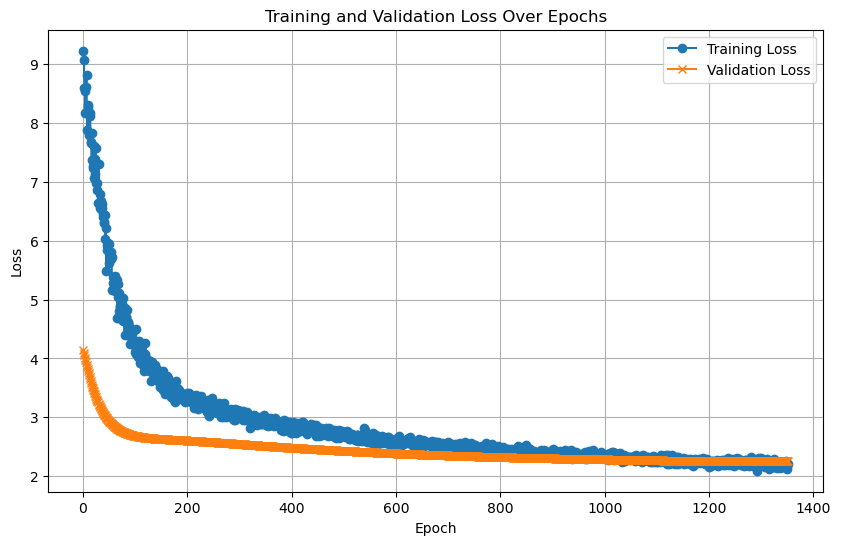

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/579], Loss: 4.5829


Test Batch [20/579], Loss: 4.4969
Test Batch [30/579], Loss: 4.5847
Test Batch [40/579], Loss: 4.7551
Test Batch [50/579], Loss: 4.5949
Test Batch [60/579], Loss: 4.7027
Test Batch [70/579], Loss: 4.7609
Test Batch [80/579], Loss: 4.5977
Test Batch [90/579], Loss: 4.4098
Test Batch [100/579], Loss: 4.5560
Test Batch [110/579], Loss: 4.4330
Test Batch [120/579], Loss: 4.5397
Test Batch [130/579], Loss: 4.5697
Test Batch [140/579], Loss: 4.5336
Test Batch [150/579], Loss: 4.4985


Test Batch [160/579], Loss: 4.6607
Test Batch [170/579], Loss: 4.6818
Test Batch [180/579], Loss: 4.3862
Test Batch [190/579], Loss: 4.6804
Test Batch [200/579], Loss: 4.8763
Test Batch [210/579], Loss: 4.8093
Test Batch [220/579], Loss: 4.9366
Test Batch [230/579], Loss: 4.8838
Test Batch [240/579], Loss: 5.0871
Test Batch [250/579], Loss: 4.7633
Test Batch [260/579], Loss: 4.9189
Test Batch [270/579], Loss: 4.7680
Test Batch [280/579], Loss: 4.3752
Test Batch [290/579], Loss: 4.9359
Test Batch [300/579], Loss: 4.9225
Test Batch [310/579], Loss: 5.2915


Test Batch [320/579], Loss: 5.1698
Test Batch [330/579], Loss: 5.0776
Test Batch [340/579], Loss: 5.3174
Test Batch [350/579], Loss: 5.3220
Test Batch [360/579], Loss: 5.2393
Test Batch [370/579], Loss: 5.5334
Test Batch [380/579], Loss: 4.4745
Test Batch [390/579], Loss: 5.4958
Test Batch [400/579], Loss: 5.1220
Test Batch [410/579], Loss: 5.0409
Test Batch [420/579], Loss: 5.0683
Test Batch [430/579], Loss: 5.5221
Test Batch [440/579], Loss: 5.4256
Test Batch [450/579], Loss: 5.3701
Test Batch [460/579], Loss: 5.3356


Test Batch [470/579], Loss: 5.3426
Test Batch [480/579], Loss: 4.4726
Test Batch [490/579], Loss: 5.0622
Test Batch [500/579], Loss: 5.1001
Test Batch [510/579], Loss: 5.3377
Test Batch [520/579], Loss: 5.4161
Test Batch [530/579], Loss: 4.3413
Test Batch [540/579], Loss: 4.4840


Test Batch [550/579], Loss: 4.5048
Test Batch [560/579], Loss: 4.4655
Test Batch [570/579], Loss: 4.5513

Test Loss: 4.8454


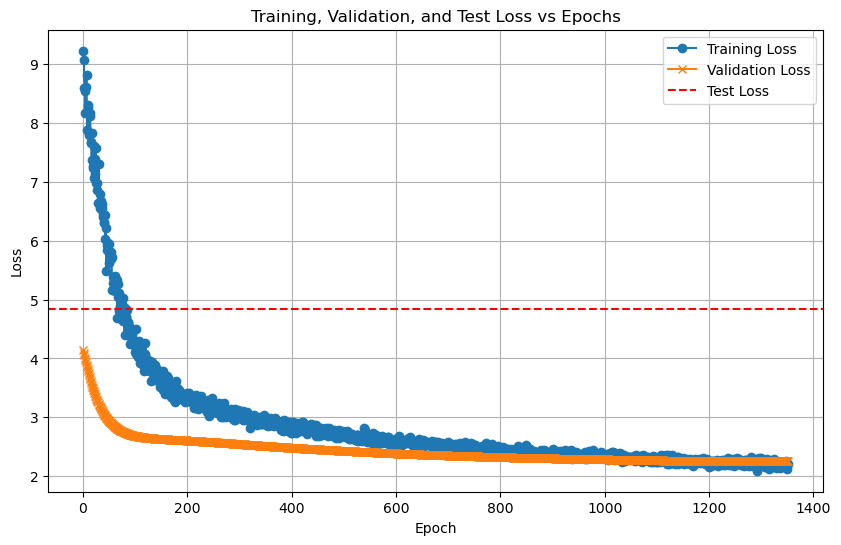

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/579 for test dataset.


  Processed batch 20/579 for test dataset.
  Processed batch 30/579 for test dataset.
  Processed batch 40/579 for test dataset.
  Processed batch 50/579 for test dataset.


  Processed batch 60/579 for test dataset.
  Processed batch 70/579 for test dataset.


  Processed batch 80/579 for test dataset.
  Processed batch 90/579 for test dataset.
  Processed batch 100/579 for test dataset.
  Processed batch 110/579 for test dataset.


  Processed batch 120/579 for test dataset.
  Processed batch 130/579 for test dataset.
  Processed batch 140/579 for test dataset.


  Processed batch 150/579 for test dataset.
  Processed batch 160/579 for test dataset.
  Processed batch 170/579 for test dataset.


  Processed batch 180/579 for test dataset.
  Processed batch 190/579 for test dataset.
  Processed batch 200/579 for test dataset.
  Processed batch 210/579 for test dataset.


  Processed batch 220/579 for test dataset.
  Processed batch 230/579 for test dataset.
  Processed batch 240/579 for test dataset.


  Processed batch 250/579 for test dataset.
  Processed batch 260/579 for test dataset.
  Processed batch 270/579 for test dataset.
  Processed batch 280/579 for test dataset.


  Processed batch 290/579 for test dataset.
  Processed batch 300/579 for test dataset.


  Processed batch 310/579 for test dataset.
  Processed batch 320/579 for test dataset.
  Processed batch 330/579 for test dataset.
  Processed batch 340/579 for test dataset.


  Processed batch 350/579 for test dataset.
  Processed batch 360/579 for test dataset.
  Processed batch 370/579 for test dataset.


  Processed batch 380/579 for test dataset.
  Processed batch 390/579 for test dataset.
  Processed batch 400/579 for test dataset.


  Processed batch 410/579 for test dataset.
  Processed batch 420/579 for test dataset.
  Processed batch 430/579 for test dataset.
  Processed batch 440/579 for test dataset.


  Processed batch 450/579 for test dataset.
  Processed batch 460/579 for test dataset.
  Processed batch 470/579 for test dataset.


  Processed batch 480/579 for test dataset.
  Processed batch 490/579 for test dataset.
  Processed batch 500/579 for test dataset.
  Processed batch 510/579 for test dataset.


  Processed batch 520/579 for test dataset.
  Processed batch 530/579 for test dataset.
  Processed batch 540/579 for test dataset.


  Processed batch 550/579 for test dataset.
  Processed batch 560/579 for test dataset.
  Processed batch 570/579 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (45, 128)
Train labels shape: (45,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (148062, 128)
Test labels shape: (148062,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 86.67%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.62      1.00      0.77         5
           4       0.75      0.60      0.67         5
           5       0.67      0.80      0.73         5
           6       1.00      1.00      1.00         5
           7       1.00      0.60      0.75         5
           8       1.00      1.00      1.00         5

    accuracy                           0.87        45
   macro avg       0.89      0.87      0.87        45
weighted avg       0.89      0.87      0.87        45


LOG: Evaluating on the test set...
Test Accuracy: 90.47%



Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     65961
           1       0.99      0.81      0.89      7588
           2       0.66      0.94      0.77      3080
           3       0.52      0.88      0.66      2675
           4       0.46      0.78      0.58      6574
           5       0.71      0.99      0.82      9238
           6       0.94      0.75      0.83      7277
           7       1.00      0.81      0.90     42816
           8       1.00      1.00      1.00      2853

    accuracy                           0.90    148062
   macro avg       0.81      0.88      0.83    148062
weighted avg       0.94      0.90      0.91    148062

Saved CAE+LRM predictions and true labels to model_predictions


### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (45, 128)
Train labels shape: (45,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (148062, 128)
Test labels shape: (148062,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.5869  |  Val Loss: 2.5423
Validation loss improved from inf to 2.5423.
[Epoch 2/1000] Train Loss: 2.5663  |  Val Loss: 2.5237
Validation loss improved from 2.5423 to 2.5237.
[Epoch 3/1000] Train Loss: 2.5458  |  Val Loss: 2.5054
Validation loss improved from 2.5237 to 2.5054.
[Epoch 4/1000] Train Loss: 2.5257  |  Val Loss: 2.4873
Validation loss improved from 2.5054 to 2.4873.
[Epoch 5/1000] Train Loss: 2.5061  |  Val Loss: 2.4695
Validation loss improved from 2.4873 to 2.4695.
[Epoch 6/1000] Train Loss: 2.4869  |  Val Loss: 2.4520
Validation loss improved from 2.4695 to 2.4520.
[Epoch 7/1000] Train Loss: 2.4679  |  Val Loss: 2.4349
Validation loss improved from 2.4520 to 2.4349.
[Epoch 8/1000] Train Loss: 2.4493  |  Val Loss: 2.4184
Validation loss improved from 2.4349 to 2.4184.
[Epoch 9/1000] Train Loss: 2.4310  |  Val Loss: 2.4021
Validation loss improved from 2.4184 to 2.4021.
[Epoch 10/1000] Train Loss: 2.4133  |  Val Loss: 2.3862
Validation loss impr

[Epoch 65/1000] Train Loss: 1.8067  |  Val Loss: 1.8334
Validation loss improved from 1.8415 to 1.8334.
[Epoch 66/1000] Train Loss: 1.7980  |  Val Loss: 1.8254
Validation loss improved from 1.8334 to 1.8254.
[Epoch 67/1000] Train Loss: 1.7894  |  Val Loss: 1.8174
Validation loss improved from 1.8254 to 1.8174.
[Epoch 68/1000] Train Loss: 1.7808  |  Val Loss: 1.8095
Validation loss improved from 1.8174 to 1.8095.
[Epoch 69/1000] Train Loss: 1.7722  |  Val Loss: 1.8016
Validation loss improved from 1.8095 to 1.8016.
[Epoch 70/1000] Train Loss: 1.7637  |  Val Loss: 1.7937
Validation loss improved from 1.8016 to 1.7937.
[Epoch 71/1000] Train Loss: 1.7552  |  Val Loss: 1.7858
Validation loss improved from 1.7937 to 1.7858.
[Epoch 72/1000] Train Loss: 1.7466  |  Val Loss: 1.7780
Validation loss improved from 1.7858 to 1.7780.
[Epoch 73/1000] Train Loss: 1.7380  |  Val Loss: 1.7702
Validation loss improved from 1.7780 to 1.7702.
[Epoch 74/1000] Train Loss: 1.7295  |  Val Loss: 1.7623
Validati

[Epoch 82/1000] Train Loss: 1.6619  |  Val Loss: 1.6999
Validation loss improved from 1.7077 to 1.6999.
[Epoch 83/1000] Train Loss: 1.6536  |  Val Loss: 1.6923
Validation loss improved from 1.6999 to 1.6923.
[Epoch 84/1000] Train Loss: 1.6453  |  Val Loss: 1.6846
Validation loss improved from 1.6923 to 1.6846.
[Epoch 85/1000] Train Loss: 1.6371  |  Val Loss: 1.6770
Validation loss improved from 1.6846 to 1.6770.
[Epoch 86/1000] Train Loss: 1.6289  |  Val Loss: 1.6694
Validation loss improved from 1.6770 to 1.6694.
[Epoch 87/1000] Train Loss: 1.6208  |  Val Loss: 1.6619
Validation loss improved from 1.6694 to 1.6619.
[Epoch 88/1000] Train Loss: 1.6129  |  Val Loss: 1.6545
Validation loss improved from 1.6619 to 1.6545.
[Epoch 89/1000] Train Loss: 1.6051  |  Val Loss: 1.6471
Validation loss improved from 1.6545 to 1.6471.
[Epoch 90/1000] Train Loss: 1.5973  |  Val Loss: 1.6399
Validation loss improved from 1.6471 to 1.6399.
[Epoch 91/1000] Train Loss: 1.5895  |  Val Loss: 1.6327
Validati

[Epoch 143/1000] Train Loss: 1.2012  |  Val Loss: 1.2791
Validation loss improved from 1.2852 to 1.2791.
[Epoch 144/1000] Train Loss: 1.1945  |  Val Loss: 1.2731
Validation loss improved from 1.2791 to 1.2731.
[Epoch 145/1000] Train Loss: 1.1879  |  Val Loss: 1.2671
Validation loss improved from 1.2731 to 1.2671.
[Epoch 146/1000] Train Loss: 1.1814  |  Val Loss: 1.2611
Validation loss improved from 1.2671 to 1.2611.
[Epoch 147/1000] Train Loss: 1.1749  |  Val Loss: 1.2552
Validation loss improved from 1.2611 to 1.2552.
[Epoch 148/1000] Train Loss: 1.1683  |  Val Loss: 1.2493
Validation loss improved from 1.2552 to 1.2493.
[Epoch 149/1000] Train Loss: 1.1619  |  Val Loss: 1.2434
Validation loss improved from 1.2493 to 1.2434.
[Epoch 150/1000] Train Loss: 1.1554  |  Val Loss: 1.2376
Validation loss improved from 1.2434 to 1.2376.
[Epoch 151/1000] Train Loss: 1.1490  |  Val Loss: 1.2317
Validation loss improved from 1.2376 to 1.2317.
[Epoch 152/1000] Train Loss: 1.1426  |  Val Loss: 1.225

[Epoch 156/1000] Train Loss: 1.1171  |  Val Loss: 1.2027
Validation loss improved from 1.2085 to 1.2027.
[Epoch 157/1000] Train Loss: 1.1108  |  Val Loss: 1.1970
Validation loss improved from 1.2027 to 1.1970.
[Epoch 158/1000] Train Loss: 1.1045  |  Val Loss: 1.1913
Validation loss improved from 1.1970 to 1.1913.
[Epoch 159/1000] Train Loss: 1.0982  |  Val Loss: 1.1856
Validation loss improved from 1.1913 to 1.1856.
[Epoch 160/1000] Train Loss: 1.0919  |  Val Loss: 1.1799
Validation loss improved from 1.1856 to 1.1799.
[Epoch 161/1000] Train Loss: 1.0856  |  Val Loss: 1.1743
Validation loss improved from 1.1799 to 1.1743.
[Epoch 162/1000] Train Loss: 1.0794  |  Val Loss: 1.1687
Validation loss improved from 1.1743 to 1.1687.
[Epoch 163/1000] Train Loss: 1.0732  |  Val Loss: 1.1632
Validation loss improved from 1.1687 to 1.1632.
[Epoch 164/1000] Train Loss: 1.0670  |  Val Loss: 1.1577
Validation loss improved from 1.1632 to 1.1577.
[Epoch 165/1000] Train Loss: 1.0609  |  Val Loss: 1.152

[Epoch 218/1000] Train Loss: 0.7734  |  Val Loss: 0.9065
Validation loss improved from 0.9103 to 0.9065.
[Epoch 219/1000] Train Loss: 0.7689  |  Val Loss: 0.9027
Validation loss improved from 0.9065 to 0.9027.
[Epoch 220/1000] Train Loss: 0.7644  |  Val Loss: 0.8990
Validation loss improved from 0.9027 to 0.8990.
[Epoch 221/1000] Train Loss: 0.7600  |  Val Loss: 0.8952
Validation loss improved from 0.8990 to 0.8952.
[Epoch 222/1000] Train Loss: 0.7556  |  Val Loss: 0.8915
Validation loss improved from 0.8952 to 0.8915.
[Epoch 223/1000] Train Loss: 0.7512  |  Val Loss: 0.8878
Validation loss improved from 0.8915 to 0.8878.
[Epoch 224/1000] Train Loss: 0.7469  |  Val Loss: 0.8841
Validation loss improved from 0.8878 to 0.8841.
[Epoch 225/1000] Train Loss: 0.7426  |  Val Loss: 0.8805
Validation loss improved from 0.8841 to 0.8805.
[Epoch 226/1000] Train Loss: 0.7383  |  Val Loss: 0.8769
Validation loss improved from 0.8805 to 0.8769.
[Epoch 227/1000] Train Loss: 0.7341  |  Val Loss: 0.873

[Epoch 239/1000] Train Loss: 0.6852  |  Val Loss: 0.8316
Validation loss improved from 0.8349 to 0.8316.
[Epoch 240/1000] Train Loss: 0.6813  |  Val Loss: 0.8284
Validation loss improved from 0.8316 to 0.8284.
[Epoch 241/1000] Train Loss: 0.6774  |  Val Loss: 0.8252
Validation loss improved from 0.8284 to 0.8252.
[Epoch 242/1000] Train Loss: 0.6736  |  Val Loss: 0.8219
Validation loss improved from 0.8252 to 0.8219.
[Epoch 243/1000] Train Loss: 0.6698  |  Val Loss: 0.8187
Validation loss improved from 0.8219 to 0.8187.
[Epoch 244/1000] Train Loss: 0.6660  |  Val Loss: 0.8155
Validation loss improved from 0.8187 to 0.8155.
[Epoch 245/1000] Train Loss: 0.6623  |  Val Loss: 0.8124
Validation loss improved from 0.8155 to 0.8124.
[Epoch 246/1000] Train Loss: 0.6586  |  Val Loss: 0.8092
Validation loss improved from 0.8124 to 0.8092.
[Epoch 247/1000] Train Loss: 0.6549  |  Val Loss: 0.8061
Validation loss improved from 0.8092 to 0.8061.
[Epoch 248/1000] Train Loss: 0.6512  |  Val Loss: 0.803

[Epoch 294/1000] Train Loss: 0.5025  |  Val Loss: 0.6818
Validation loss improved from 0.6841 to 0.6818.
[Epoch 295/1000] Train Loss: 0.4997  |  Val Loss: 0.6795
Validation loss improved from 0.6818 to 0.6795.
[Epoch 296/1000] Train Loss: 0.4968  |  Val Loss: 0.6773
Validation loss improved from 0.6795 to 0.6773.
[Epoch 297/1000] Train Loss: 0.4940  |  Val Loss: 0.6750
Validation loss improved from 0.6773 to 0.6750.
[Epoch 298/1000] Train Loss: 0.4913  |  Val Loss: 0.6728
Validation loss improved from 0.6750 to 0.6728.
[Epoch 299/1000] Train Loss: 0.4885  |  Val Loss: 0.6706
Validation loss improved from 0.6728 to 0.6706.
[Epoch 300/1000] Train Loss: 0.4857  |  Val Loss: 0.6684
Validation loss improved from 0.6706 to 0.6684.
[Epoch 301/1000] Train Loss: 0.4830  |  Val Loss: 0.6663
Validation loss improved from 0.6684 to 0.6663.
[Epoch 302/1000] Train Loss: 0.4802  |  Val Loss: 0.6641
Validation loss improved from 0.6663 to 0.6641.
[Epoch 303/1000] Train Loss: 0.4775  |  Val Loss: 0.661

[Epoch 316/1000] Train Loss: 0.4431  |  Val Loss: 0.6347
Validation loss improved from 0.6367 to 0.6347.
[Epoch 317/1000] Train Loss: 0.4406  |  Val Loss: 0.6327
Validation loss improved from 0.6347 to 0.6327.
[Epoch 318/1000] Train Loss: 0.4380  |  Val Loss: 0.6307
Validation loss improved from 0.6327 to 0.6307.
[Epoch 319/1000] Train Loss: 0.4355  |  Val Loss: 0.6288
Validation loss improved from 0.6307 to 0.6288.
[Epoch 320/1000] Train Loss: 0.4330  |  Val Loss: 0.6269
Validation loss improved from 0.6288 to 0.6269.
[Epoch 321/1000] Train Loss: 0.4306  |  Val Loss: 0.6250
Validation loss improved from 0.6269 to 0.6250.
[Epoch 322/1000] Train Loss: 0.4281  |  Val Loss: 0.6231
Validation loss improved from 0.6250 to 0.6231.
[Epoch 323/1000] Train Loss: 0.4256  |  Val Loss: 0.6211
Validation loss improved from 0.6231 to 0.6211.
[Epoch 324/1000] Train Loss: 0.4232  |  Val Loss: 0.6192
Validation loss improved from 0.6211 to 0.6192.
[Epoch 325/1000] Train Loss: 0.4207  |  Val Loss: 0.617

[Epoch 368/1000] Train Loss: 0.3248  |  Val Loss: 0.5469
Validation loss improved from 0.5485 to 0.5469.
[Epoch 369/1000] Train Loss: 0.3228  |  Val Loss: 0.5453
Validation loss improved from 0.5469 to 0.5453.
[Epoch 370/1000] Train Loss: 0.3208  |  Val Loss: 0.5436
Validation loss improved from 0.5453 to 0.5436.
[Epoch 371/1000] Train Loss: 0.3188  |  Val Loss: 0.5420
Validation loss improved from 0.5436 to 0.5420.
[Epoch 372/1000] Train Loss: 0.3169  |  Val Loss: 0.5403
Validation loss improved from 0.5420 to 0.5403.
[Epoch 373/1000] Train Loss: 0.3149  |  Val Loss: 0.5386
Validation loss improved from 0.5403 to 0.5386.
[Epoch 374/1000] Train Loss: 0.3130  |  Val Loss: 0.5370
Validation loss improved from 0.5386 to 0.5370.
[Epoch 375/1000] Train Loss: 0.3110  |  Val Loss: 0.5354
Validation loss improved from 0.5370 to 0.5354.
[Epoch 376/1000] Train Loss: 0.3091  |  Val Loss: 0.5338
Validation loss improved from 0.5354 to 0.5338.
[Epoch 377/1000] Train Loss: 0.3072  |  Val Loss: 0.532

[Epoch 393/1000] Train Loss: 0.2787  |  Val Loss: 0.5120
Validation loss improved from 0.5132 to 0.5120.
[Epoch 394/1000] Train Loss: 0.2770  |  Val Loss: 0.5108
Validation loss improved from 0.5120 to 0.5108.
[Epoch 395/1000] Train Loss: 0.2753  |  Val Loss: 0.5095
Validation loss improved from 0.5108 to 0.5095.
[Epoch 396/1000] Train Loss: 0.2737  |  Val Loss: 0.5083
Validation loss improved from 0.5095 to 0.5083.
[Epoch 397/1000] Train Loss: 0.2721  |  Val Loss: 0.5070
Validation loss improved from 0.5083 to 0.5070.
[Epoch 398/1000] Train Loss: 0.2704  |  Val Loss: 0.5058
Validation loss improved from 0.5070 to 0.5058.
[Epoch 399/1000] Train Loss: 0.2688  |  Val Loss: 0.5046
Validation loss improved from 0.5058 to 0.5046.
[Epoch 400/1000] Train Loss: 0.2672  |  Val Loss: 0.5034
Validation loss improved from 0.5046 to 0.5034.
[Epoch 401/1000] Train Loss: 0.2656  |  Val Loss: 0.5023
Validation loss improved from 0.5034 to 0.5023.
[Epoch 402/1000] Train Loss: 0.2640  |  Val Loss: 0.501

[Epoch 442/1000] Train Loss: 0.2083  |  Val Loss: 0.4596
Validation loss improved from 0.4605 to 0.4596.
[Epoch 443/1000] Train Loss: 0.2070  |  Val Loss: 0.4587
Validation loss improved from 0.4596 to 0.4587.
[Epoch 444/1000] Train Loss: 0.2058  |  Val Loss: 0.4577
Validation loss improved from 0.4587 to 0.4577.
[Epoch 445/1000] Train Loss: 0.2046  |  Val Loss: 0.4568
Validation loss improved from 0.4577 to 0.4568.
[Epoch 446/1000] Train Loss: 0.2034  |  Val Loss: 0.4559
Validation loss improved from 0.4568 to 0.4559.
[Epoch 447/1000] Train Loss: 0.2022  |  Val Loss: 0.4551
Validation loss improved from 0.4559 to 0.4551.
[Epoch 448/1000] Train Loss: 0.2010  |  Val Loss: 0.4542
Validation loss improved from 0.4551 to 0.4542.
[Epoch 449/1000] Train Loss: 0.1998  |  Val Loss: 0.4533
Validation loss improved from 0.4542 to 0.4533.
[Epoch 450/1000] Train Loss: 0.1986  |  Val Loss: 0.4525
Validation loss improved from 0.4533 to 0.4525.
[Epoch 451/1000] Train Loss: 0.1974  |  Val Loss: 0.451

[Epoch 471/1000] Train Loss: 0.1758  |  Val Loss: 0.4360
Validation loss improved from 0.4367 to 0.4360.
[Epoch 472/1000] Train Loss: 0.1748  |  Val Loss: 0.4352
Validation loss improved from 0.4360 to 0.4352.
[Epoch 473/1000] Train Loss: 0.1738  |  Val Loss: 0.4345
Validation loss improved from 0.4352 to 0.4345.
[Epoch 474/1000] Train Loss: 0.1728  |  Val Loss: 0.4337
Validation loss improved from 0.4345 to 0.4337.
[Epoch 475/1000] Train Loss: 0.1718  |  Val Loss: 0.4329
Validation loss improved from 0.4337 to 0.4329.
[Epoch 476/1000] Train Loss: 0.1709  |  Val Loss: 0.4322
Validation loss improved from 0.4329 to 0.4322.
[Epoch 477/1000] Train Loss: 0.1699  |  Val Loss: 0.4314
Validation loss improved from 0.4322 to 0.4314.
[Epoch 478/1000] Train Loss: 0.1689  |  Val Loss: 0.4307
Validation loss improved from 0.4314 to 0.4307.
[Epoch 479/1000] Train Loss: 0.1680  |  Val Loss: 0.4299
Validation loss improved from 0.4307 to 0.4299.
[Epoch 480/1000] Train Loss: 0.1670  |  Val Loss: 0.429

[Epoch 517/1000] Train Loss: 0.1358  |  Val Loss: 0.4067
Validation loss improved from 0.4072 to 0.4067.
[Epoch 518/1000] Train Loss: 0.1350  |  Val Loss: 0.4062
Validation loss improved from 0.4067 to 0.4062.
[Epoch 519/1000] Train Loss: 0.1343  |  Val Loss: 0.4056
Validation loss improved from 0.4062 to 0.4056.
[Epoch 520/1000] Train Loss: 0.1335  |  Val Loss: 0.4051
Validation loss improved from 0.4056 to 0.4051.
[Epoch 521/1000] Train Loss: 0.1328  |  Val Loss: 0.4045
Validation loss improved from 0.4051 to 0.4045.
[Epoch 522/1000] Train Loss: 0.1321  |  Val Loss: 0.4040
Validation loss improved from 0.4045 to 0.4040.
[Epoch 523/1000] Train Loss: 0.1314  |  Val Loss: 0.4035
Validation loss improved from 0.4040 to 0.4035.
[Epoch 524/1000] Train Loss: 0.1307  |  Val Loss: 0.4031
Validation loss improved from 0.4035 to 0.4031.
[Epoch 525/1000] Train Loss: 0.1300  |  Val Loss: 0.4026
Validation loss improved from 0.4031 to 0.4026.
[Epoch 526/1000] Train Loss: 0.1293  |  Val Loss: 0.402

[Epoch 541/1000] Train Loss: 0.1190  |  Val Loss: 0.3941
Validation loss improved from 0.3946 to 0.3941.
[Epoch 542/1000] Train Loss: 0.1184  |  Val Loss: 0.3936
Validation loss improved from 0.3941 to 0.3936.
[Epoch 543/1000] Train Loss: 0.1177  |  Val Loss: 0.3930
Validation loss improved from 0.3936 to 0.3930.
[Epoch 544/1000] Train Loss: 0.1171  |  Val Loss: 0.3925
Validation loss improved from 0.3930 to 0.3925.
[Epoch 545/1000] Train Loss: 0.1164  |  Val Loss: 0.3919
Validation loss improved from 0.3925 to 0.3919.
[Epoch 546/1000] Train Loss: 0.1158  |  Val Loss: 0.3914
Validation loss improved from 0.3919 to 0.3914.
[Epoch 547/1000] Train Loss: 0.1152  |  Val Loss: 0.3909
Validation loss improved from 0.3914 to 0.3909.
[Epoch 548/1000] Train Loss: 0.1145  |  Val Loss: 0.3905
Validation loss improved from 0.3909 to 0.3905.
[Epoch 549/1000] Train Loss: 0.1139  |  Val Loss: 0.3900
Validation loss improved from 0.3905 to 0.3900.
[Epoch 550/1000] Train Loss: 0.1133  |  Val Loss: 0.389

[Epoch 593/1000] Train Loss: 0.0902  |  Val Loss: 0.3723
Validation loss improved from 0.3726 to 0.3723.
[Epoch 594/1000] Train Loss: 0.0897  |  Val Loss: 0.3720
Validation loss improved from 0.3723 to 0.3720.
[Epoch 595/1000] Train Loss: 0.0893  |  Val Loss: 0.3717
Validation loss improved from 0.3720 to 0.3717.
[Epoch 596/1000] Train Loss: 0.0888  |  Val Loss: 0.3714
Validation loss improved from 0.3717 to 0.3714.
[Epoch 597/1000] Train Loss: 0.0884  |  Val Loss: 0.3712
Validation loss improved from 0.3714 to 0.3712.
[Epoch 598/1000] Train Loss: 0.0879  |  Val Loss: 0.3709
Validation loss improved from 0.3712 to 0.3709.
[Epoch 599/1000] Train Loss: 0.0875  |  Val Loss: 0.3707
Validation loss improved from 0.3709 to 0.3707.
[Epoch 600/1000] Train Loss: 0.0871  |  Val Loss: 0.3704
Validation loss improved from 0.3707 to 0.3704.
[Epoch 601/1000] Train Loss: 0.0866  |  Val Loss: 0.3701
Validation loss improved from 0.3704 to 0.3701.
[Epoch 602/1000] Train Loss: 0.0862  |  Val Loss: 0.369

[Epoch 624/1000] Train Loss: 0.0775  |  Val Loss: 0.3634
Validation loss improved from 0.3637 to 0.3634.
[Epoch 625/1000] Train Loss: 0.0772  |  Val Loss: 0.3631
Validation loss improved from 0.3634 to 0.3631.
[Epoch 626/1000] Train Loss: 0.0768  |  Val Loss: 0.3629
Validation loss improved from 0.3631 to 0.3629.
[Epoch 627/1000] Train Loss: 0.0765  |  Val Loss: 0.3626
Validation loss improved from 0.3629 to 0.3626.
[Epoch 628/1000] Train Loss: 0.0761  |  Val Loss: 0.3624
Validation loss improved from 0.3626 to 0.3624.
[Epoch 629/1000] Train Loss: 0.0757  |  Val Loss: 0.3621
Validation loss improved from 0.3624 to 0.3621.
[Epoch 630/1000] Train Loss: 0.0754  |  Val Loss: 0.3619
Validation loss improved from 0.3621 to 0.3619.
[Epoch 631/1000] Train Loss: 0.0750  |  Val Loss: 0.3616
Validation loss improved from 0.3619 to 0.3616.
[Epoch 632/1000] Train Loss: 0.0747  |  Val Loss: 0.3613
Validation loss improved from 0.3616 to 0.3613.
[Epoch 633/1000] Train Loss: 0.0743  |  Val Loss: 0.361

[Epoch 678/1000] Train Loss: 0.0608  |  Val Loss: 0.3537
Validation loss improved from 0.3539 to 0.3537.
[Epoch 679/1000] Train Loss: 0.0605  |  Val Loss: 0.3536
Validation loss improved from 0.3537 to 0.3536.
[Epoch 680/1000] Train Loss: 0.0602  |  Val Loss: 0.3535
Validation loss improved from 0.3536 to 0.3535.
[Epoch 681/1000] Train Loss: 0.0600  |  Val Loss: 0.3534
Validation loss improved from 0.3535 to 0.3534.
[Epoch 682/1000] Train Loss: 0.0597  |  Val Loss: 0.3532
Validation loss improved from 0.3534 to 0.3532.
[Epoch 683/1000] Train Loss: 0.0595  |  Val Loss: 0.3532
Validation loss improved from 0.3532 to 0.3532.
[Epoch 684/1000] Train Loss: 0.0592  |  Val Loss: 0.3531
Validation loss improved from 0.3532 to 0.3531.
[Epoch 685/1000] Train Loss: 0.0589  |  Val Loss: 0.3529
Validation loss improved from 0.3531 to 0.3529.
[Epoch 686/1000] Train Loss: 0.0587  |  Val Loss: 0.3528
Validation loss improved from 0.3529 to 0.3528.
[Epoch 687/1000] Train Loss: 0.0584  |  Val Loss: 0.352

[Epoch 707/1000] Train Loss: 0.0537  |  Val Loss: 0.3506
Validation loss improved from 0.3506 to 0.3506.
[Epoch 708/1000] Train Loss: 0.0535  |  Val Loss: 0.3505
Validation loss improved from 0.3506 to 0.3505.
[Epoch 709/1000] Train Loss: 0.0533  |  Val Loss: 0.3504
Validation loss improved from 0.3505 to 0.3504.
[Epoch 710/1000] Train Loss: 0.0530  |  Val Loss: 0.3503
Validation loss improved from 0.3504 to 0.3503.
[Epoch 711/1000] Train Loss: 0.0528  |  Val Loss: 0.3502
Validation loss improved from 0.3503 to 0.3502.
[Epoch 712/1000] Train Loss: 0.0526  |  Val Loss: 0.3501
Validation loss improved from 0.3502 to 0.3501.
[Epoch 713/1000] Train Loss: 0.0524  |  Val Loss: 0.3500
Validation loss improved from 0.3501 to 0.3500.
[Epoch 714/1000] Train Loss: 0.0522  |  Val Loss: 0.3499
Validation loss improved from 0.3500 to 0.3499.
[Epoch 715/1000] Train Loss: 0.0520  |  Val Loss: 0.3499
Validation loss improved from 0.3499 to 0.3499.
[Epoch 716/1000] Train Loss: 0.0517  |  Val Loss: 0.349

[Epoch 757/1000] Train Loss: 0.0439  |  Val Loss: 0.3474
Validation loss improved from 0.3475 to 0.3474.
[Epoch 758/1000] Train Loss: 0.0438  |  Val Loss: 0.3474
Validation loss improved from 0.3474 to 0.3474.
[Epoch 759/1000] Train Loss: 0.0436  |  Val Loss: 0.3474
Validation loss improved from 0.3474 to 0.3474.
[Epoch 760/1000] Train Loss: 0.0434  |  Val Loss: 0.3474
Validation loss improved from 0.3474 to 0.3474.
[Epoch 761/1000] Train Loss: 0.0433  |  Val Loss: 0.3474
Validation loss improved from 0.3474 to 0.3474.
[Epoch 762/1000] Train Loss: 0.0431  |  Val Loss: 0.3473
Validation loss improved from 0.3474 to 0.3473.
[Epoch 763/1000] Train Loss: 0.0429  |  Val Loss: 0.3473
Validation loss improved from 0.3473 to 0.3473.
[Epoch 764/1000] Train Loss: 0.0428  |  Val Loss: 0.3472
Validation loss improved from 0.3473 to 0.3472.
[Epoch 765/1000] Train Loss: 0.0426  |  Val Loss: 0.3472
Validation loss improved from 0.3472 to 0.3472.
[Epoch 766/1000] Train Loss: 0.0424  |  Val Loss: 0.347

[Epoch 787/1000] Train Loss: 0.0392  |  Val Loss: 0.3464
Validation loss improved from 0.3464 to 0.3464.
[Epoch 788/1000] Train Loss: 0.0391  |  Val Loss: 0.3463
Validation loss improved from 0.3464 to 0.3463.
[Epoch 789/1000] Train Loss: 0.0389  |  Val Loss: 0.3463
Validation loss improved from 0.3463 to 0.3463.
[Epoch 790/1000] Train Loss: 0.0388  |  Val Loss: 0.3463
Validation loss improved from 0.3463 to 0.3463.
[Epoch 791/1000] Train Loss: 0.0387  |  Val Loss: 0.3463
Validation loss improved from 0.3463 to 0.3463.
[Epoch 792/1000] Train Loss: 0.0385  |  Val Loss: 0.3463
Validation loss improved from 0.3463 to 0.3463.
[Epoch 793/1000] Train Loss: 0.0384  |  Val Loss: 0.3462
Validation loss improved from 0.3463 to 0.3462.
[Epoch 794/1000] Train Loss: 0.0382  |  Val Loss: 0.3462
Validation loss improved from 0.3462 to 0.3462.
[Epoch 795/1000] Train Loss: 0.0381  |  Val Loss: 0.3462
Validation loss improved from 0.3462 to 0.3462.
[Epoch 796/1000] Train Loss: 0.0380  |  Val Loss: 0.346

[Epoch 831/1000] Train Loss: 0.0335  |  Val Loss: 0.3455
Validation loss improved from 0.3455 to 0.3455.
[Epoch 832/1000] Train Loss: 0.0334  |  Val Loss: 0.3456
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 833/1000] Train Loss: 0.0333  |  Val Loss: 0.3456
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 834/1000] Train Loss: 0.0332  |  Val Loss: 0.3456
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 835/1000] Train Loss: 0.0331  |  Val Loss: 0.3456
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 836/1000] Train Loss: 0.0330  |  Val Loss: 0.3455
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 837/1000] Train Loss: 0.0329  |  Val Loss: 0.3455
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 838/1000] Train Loss: 0.0327  |  Val Loss: 0.3456
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 839/1000] Train Loss: 0.0326  |  Val Loss: 0.3456
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 867/1000] Train Loss: 0.0297  |  Val Loss: 0.3458
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 868/1000] Train Loss: 0.0296  |  Val Loss: 0.3458
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 869/1000] Train Loss: 0.0295  |  Val Loss: 0.3458
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 870/1000] Train Loss: 0.0294  |  Val Loss: 0.3459
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 871/1000] Train Loss: 0.0293  |  Val Loss: 0.3459
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 872/1000] Train Loss: 0.0292  |  Val Loss: 0.3459
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 873/1000] Train Loss: 0.0291  |  Val Loss: 0.3459
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 874/1000] Train Loss: 0.0290  |  Val Loss: 0.3459
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 875/1000] Train Loss: 0.0289  |  Val Loss: 0.3460
!! Validation loss did NOT improve !! Patience:

[Epoch 904/1000] Train Loss: 0.0263  |  Val Loss: 0.3468
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 905/1000] Train Loss: 0.0262  |  Val Loss: 0.3469
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 906/1000] Train Loss: 0.0262  |  Val Loss: 0.3469
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 907/1000] Train Loss: 0.0261  |  Val Loss: 0.3469
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 908/1000] Train Loss: 0.0260  |  Val Loss: 0.3469
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 909/1000] Train Loss: 0.0259  |  Val Loss: 0.3469
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 910/1000] Train Loss: 0.0258  |  Val Loss: 0.3470
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 911/1000] Train Loss: 0.0258  |  Val Loss: 0.3470
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 912/1000] Train Loss: 0.0257  |  Val Loss: 0.3470
!! Validation loss did NOT improve !! Patience:

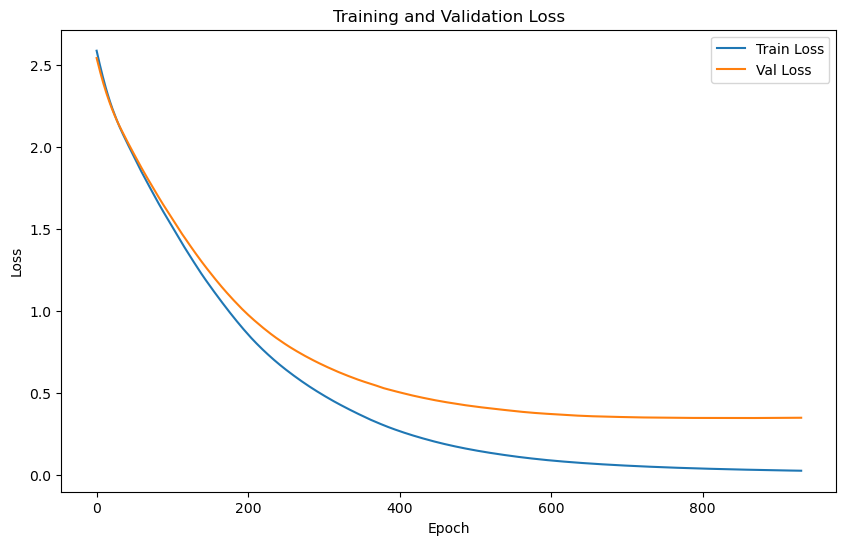

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.3188 | Test Accuracy: 89.73%


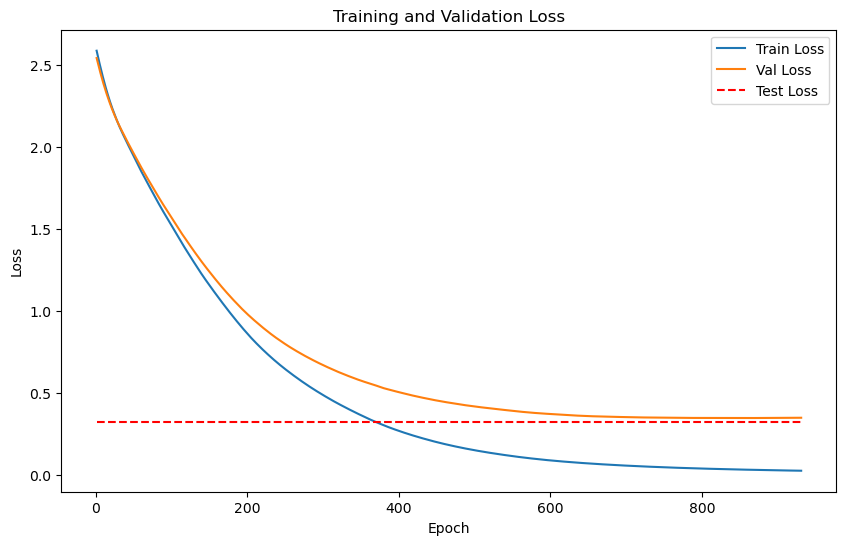

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 148062 samples with 64 features each
LOG: Labels shape: (148062,)


Train embeddings shape: (45, 64), 
Train labels shape: (45,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (148062, 64), 
Test labels shape: (148062,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5}
Training batch size: 45


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4493
LOG: Epoch [1/2000] - Validation
    Batch [1/1], Val Loss: 0.4014
Epoch [1/2000], Avg Train Loss: 0.4493, Avg Val Loss: 0.4014

Validation loss improved from inf to 0.4014. Saving model...
LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 0.4407
LOG: Epoch [2/2000] - Validation
    Batch [1/1], Val Loss: 0.4036
Epoch [2/2000], Avg Train Loss: 0.4407, Avg Val Loss: 0.4036

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 0.4463
LOG: Epoch [3/2000] - Validation


    Batch [1/1], Val Loss: 0.4052
Epoch [3/2000], Avg Train Loss: 0.4463, Avg Val Loss: 0.4052

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 0.4463
LOG: Epoch [4/2000] - Validation
    Batch [1/1], Val Loss: 0.4059
Epoch [4/2000], Avg Train Loss: 0.4463, Avg Val Loss: 0.4059

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 0.4368
LOG: Epoch [5/2000] - Validation
    Batch [1/1], Val Loss: 0.4064
Epoch [5/2000], Avg Train Loss: 0.4368, Avg Val Loss: 0.4064

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4454
LOG: Epoch [6/2000] - Validation
    Batch [1/1], Val Loss: 0.4064
Epoch [6/2000], Avg Train Loss: 0.4454, Avg Val Loss: 0.4064

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 0.4481
LOG: Epoch [7/2000] - Validation
    Batch [1/1], Val Loss: 0.4060
Epoch [7/2000], Avg Train Loss: 0.4481, Avg Val Loss: 0.4060

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [8/2000] - Training
    Batch [1/1], Train Loss: 0.4434
LOG: Epoch [8/2000] - Validation


    Batch [1/1], Val Loss: 0.4051
Epoch [8/2000], Avg Train Loss: 0.4434, Avg Val Loss: 0.4051

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [9/2000] - Training
    Batch [1/1], Train Loss: 0.4436
LOG: Epoch [9/2000] - Validation
    Batch [1/1], Val Loss: 0.4042
Epoch [9/2000], Avg Train Loss: 0.4436, Avg Val Loss: 0.4042

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [10/2000] - Training
    Batch [1/1], Train Loss: 0.4407
LOG: Epoch [10/2000] - Validation


    Batch [1/1], Val Loss: 0.4036
Epoch [10/2000], Avg Train Loss: 0.4407, Avg Val Loss: 0.4036

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [11/2000] - Training
    Batch [1/1], Train Loss: 0.4207
LOG: Epoch [11/2000] - Validation
    Batch [1/1], Val Loss: 0.4034
Epoch [11/2000], Avg Train Loss: 0.4207, Avg Val Loss: 0.4034

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [12/2000] - Training
    Batch [1/1], Train Loss: 0.4336
LOG: Epoch [12/2000] - Validation


    Batch [1/1], Val Loss: 0.4031
Epoch [12/2000], Avg Train Loss: 0.4336, Avg Val Loss: 0.4031

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 0.4319
LOG: Epoch [13/2000] - Validation
    Batch [1/1], Val Loss: 0.4028
Epoch [13/2000], Avg Train Loss: 0.4319, Avg Val Loss: 0.4028

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 0.4327
LOG: Epoch [14/2000] - Validation
    Batch [1/1], Val Loss: 0.4025
Epoch [14/2000], Avg Train Loss: 0.4327, Avg Val Loss: 0.4025

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4383
LOG: Epoch [15/2000] - Validation
    Batch [1/1], Val Loss: 0.4022
Epoch [15/2000], Avg Train Loss: 0.4383, Avg Val Loss: 0.4022

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 0.4209
LOG: Epoch [16/2000] - Validation
    Batch [1/1], Val Loss: 0.4019
Epoch [16/2000], Avg Train Loss: 0.4209, Avg Val Loss: 0.4019

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 0.4292
LOG: Epoch [17/2000] - Validation


    Batch [1/1], Val Loss: 0.4015
Epoch [17/2000], Avg Train Loss: 0.4292, Avg Val Loss: 0.4015

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 0.4253
LOG: Epoch [18/2000] - Validation
    Batch [1/1], Val Loss: 0.4012
Epoch [18/2000], Avg Train Loss: 0.4253, Avg Val Loss: 0.4012

Validation loss improved from 0.4014 to 0.4012. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4252
LOG: Epoch [19/2000] - Validation
    Batch [1/1], Val Loss: 0.4007
Epoch [19/2000], Avg Train Loss: 0.4252, Avg Val Loss: 0.4007

Validation loss improved from 0.4012 to 0.4007. Saving model...
LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 0.4250
LOG: Epoch [20/2000] - Validation
    Batch [1/1], Val Loss: 0.4004
Epoch [20/2000], Avg Train Loss: 0.4250, Avg Val Loss: 0.4004

Validation loss improved from 0.4007 to 0.4004. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4303
LOG: Epoch [21/2000] - Validation
    Batch [1/1], Val Loss: 0.4001
Epoch [21/2000], Avg Train Loss: 0.4303, Avg Val Loss: 0.4001

Validation loss improved from 0.4004 to 0.4001. Saving model...
LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 0.4311
LOG: Epoch [22/2000] - Validation
    Batch [1/1], Val Loss: 0.3997
Epoch [22/2000], Avg Train Loss: 0.4311, Avg Val Loss: 0.3997

Validation loss improved from 0.4001 to 0.3997. Saving model...
LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 0.4283
LOG: Epoch [23/2000] - Validation
    Batch [1/1], Val Loss: 0.3992
Epoch [23/2000], Avg Train Loss: 0.4283, Avg Val Loss: 0.3992

Validation loss improved from 0.3997 to 0.3992. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4169
LOG: Epoch [24/2000] - Validation
    Batch [1/1], Val Loss: 0.3988
Epoch [24/2000], Avg Train Loss: 0.4169, Avg Val Loss: 0.3988

Validation loss improved from 0.3992 to 0.3988. Saving model...
LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 0.4203
LOG: Epoch [25/2000] - Validation
    Batch [1/1], Val Loss: 0.3984
Epoch [25/2000], Avg Train Loss: 0.4203, Avg Val Loss: 0.3984

Validation loss improved from 0.3988 to 0.3984. Saving model...
LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 0.4223
LOG: Epoch [26/2000] - Validation


    Batch [1/1], Val Loss: 0.3980
Epoch [26/2000], Avg Train Loss: 0.4223, Avg Val Loss: 0.3980

Validation loss improved from 0.3984 to 0.3980. Saving model...
LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 0.4148
LOG: Epoch [27/2000] - Validation
    Batch [1/1], Val Loss: 0.3975
Epoch [27/2000], Avg Train Loss: 0.4148, Avg Val Loss: 0.3975

Validation loss improved from 0.3980 to 0.3975. Saving model...
LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 0.4194
LOG: Epoch [28/2000] - Validation
    Batch [1/1], Val Loss: 0.3971
Epoch [28/2000], Avg Train Loss: 0.4194, Avg Val Loss: 0.3971

Validation loss improved from 0.3975 to 0.3971. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.4098
LOG: Epoch [29/2000] - Validation
    Batch [1/1], Val Loss: 0.3966
Epoch [29/2000], Avg Train Loss: 0.4098, Avg Val Loss: 0.3966

Validation loss improved from 0.3971 to 0.3966. Saving model...
LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 0.4149
LOG: Epoch [30/2000] - Validation
    Batch [1/1], Val Loss: 0.3962
Epoch [30/2000], Avg Train Loss: 0.4149, Avg Val Loss: 0.3962

Validation loss improved from 0.3966 to 0.3962. Saving model...
LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 0.4160
LOG: Epoch [31/2000] - Validation


    Batch [1/1], Val Loss: 0.3957
Epoch [31/2000], Avg Train Loss: 0.4160, Avg Val Loss: 0.3957

Validation loss improved from 0.3962 to 0.3957. Saving model...
LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 0.4279
LOG: Epoch [32/2000] - Validation
    Batch [1/1], Val Loss: 0.3952
Epoch [32/2000], Avg Train Loss: 0.4279, Avg Val Loss: 0.3952

Validation loss improved from 0.3957 to 0.3952. Saving model...
LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 0.4076
LOG: Epoch [33/2000] - Validation


    Batch [1/1], Val Loss: 0.3946
Epoch [33/2000], Avg Train Loss: 0.4076, Avg Val Loss: 0.3946

Validation loss improved from 0.3952 to 0.3946. Saving model...
LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [34/2000] - Validation
    Batch [1/1], Val Loss: 0.3941
Epoch [34/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.3941

Validation loss improved from 0.3946 to 0.3941. Saving model...
LOG: Epoch [35/2000] - Training
    Batch [1/1], Train Loss: 0.4097
LOG: Epoch [35/2000] - Validation


    Batch [1/1], Val Loss: 0.3936
Epoch [35/2000], Avg Train Loss: 0.4097, Avg Val Loss: 0.3936

Validation loss improved from 0.3941 to 0.3936. Saving model...
LOG: Epoch [36/2000] - Training
    Batch [1/1], Train Loss: 0.4059
LOG: Epoch [36/2000] - Validation
    Batch [1/1], Val Loss: 0.3931
Epoch [36/2000], Avg Train Loss: 0.4059, Avg Val Loss: 0.3931

Validation loss improved from 0.3936 to 0.3931. Saving model...
LOG: Epoch [37/2000] - Training
    Batch [1/1], Train Loss: 0.4005
LOG: Epoch [37/2000] - Validation


    Batch [1/1], Val Loss: 0.3925
Epoch [37/2000], Avg Train Loss: 0.4005, Avg Val Loss: 0.3925

Validation loss improved from 0.3931 to 0.3925. Saving model...
LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 0.4023
LOG: Epoch [38/2000] - Validation
    Batch [1/1], Val Loss: 0.3920
Epoch [38/2000], Avg Train Loss: 0.4023, Avg Val Loss: 0.3920

Validation loss improved from 0.3925 to 0.3920. Saving model...
LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 0.4072
LOG: Epoch [39/2000] - Validation


    Batch [1/1], Val Loss: 0.3915
Epoch [39/2000], Avg Train Loss: 0.4072, Avg Val Loss: 0.3915

Validation loss improved from 0.3920 to 0.3915. Saving model...
LOG: Epoch [40/2000] - Training
    Batch [1/1], Train Loss: 0.4028
LOG: Epoch [40/2000] - Validation
    Batch [1/1], Val Loss: 0.3910
Epoch [40/2000], Avg Train Loss: 0.4028, Avg Val Loss: 0.3910

Validation loss improved from 0.3915 to 0.3910. Saving model...
LOG: Epoch [41/2000] - Training
    Batch [1/1], Train Loss: 0.4032
LOG: Epoch [41/2000] - Validation
    Batch [1/1], Val Loss: 0.3905
Epoch [41/2000], Avg Train Loss: 0.4032, Avg Val Loss: 0.3905

Validation loss improved from 0.3910 to 0.3905. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.3996
LOG: Epoch [42/2000] - Validation
    Batch [1/1], Val Loss: 0.3899
Epoch [42/2000], Avg Train Loss: 0.3996, Avg Val Loss: 0.3899

Validation loss improved from 0.3905 to 0.3899. Saving model...
LOG: Epoch [43/2000] - Training
    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [43/2000] - Validation
    Batch [1/1], Val Loss: 0.3894
Epoch [43/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.3894

Validation loss improved from 0.3899 to 0.3894. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [44/2000] - Validation
    Batch [1/1], Val Loss: 0.3889
Epoch [44/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.3889

Validation loss improved from 0.3894 to 0.3889. Saving model...
LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 0.3861
LOG: Epoch [45/2000] - Validation
    Batch [1/1], Val Loss: 0.3884
Epoch [45/2000], Avg Train Loss: 0.3861, Avg Val Loss: 0.3884

Validation loss improved from 0.3889 to 0.3884. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [46/2000] - Validation
    Batch [1/1], Val Loss: 0.3879
Epoch [46/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.3879

Validation loss improved from 0.3884 to 0.3879. Saving model...
LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 0.4005
LOG: Epoch [47/2000] - Validation
    Batch [1/1], Val Loss: 0.3874
Epoch [47/2000], Avg Train Loss: 0.4005, Avg Val Loss: 0.3874

Validation loss improved from 0.3879 to 0.3874. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.3982
LOG: Epoch [48/2000] - Validation
    Batch [1/1], Val Loss: 0.3868
Epoch [48/2000], Avg Train Loss: 0.3982, Avg Val Loss: 0.3868

Validation loss improved from 0.3874 to 0.3868. Saving model...
LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [49/2000] - Validation
    Batch [1/1], Val Loss: 0.3863
Epoch [49/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.3863

Validation loss improved from 0.3868 to 0.3863. Saving model...
LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 0.4125
LOG: Epoch [50/2000] - Validation
    Batch [1/1], Val Loss: 0.3858
Epoch [50/2000], Avg Train Loss: 0.4125, Avg Val Loss: 0.3858

Validation loss improved from 0.3863 to 0.3858. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [51/2000] - Validation
    Batch [1/1], Val Loss: 0.3852
Epoch [51/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.3852

Validation loss improved from 0.3858 to 0.3852. Saving model...
LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 0.3872
LOG: Epoch [52/2000] - Validation
    Batch [1/1], Val Loss: 0.3847
Epoch [52/2000], Avg Train Loss: 0.3872, Avg Val Loss: 0.3847

Validation loss improved from 0.3852 to 0.3847. Saving model...
LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 0.3879
LOG: Epoch [53/2000] - Validation


    Batch [1/1], Val Loss: 0.3842
Epoch [53/2000], Avg Train Loss: 0.3879, Avg Val Loss: 0.3842

Validation loss improved from 0.3847 to 0.3842. Saving model...
LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 0.3891
LOG: Epoch [54/2000] - Validation
    Batch [1/1], Val Loss: 0.3837
Epoch [54/2000], Avg Train Loss: 0.3891, Avg Val Loss: 0.3837

Validation loss improved from 0.3842 to 0.3837. Saving model...
LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 0.3952
LOG: Epoch [55/2000] - Validation
    Batch [1/1], Val Loss: 0.3832
Epoch [55/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.3832

Validation loss improved from 0.3837 to 0.3832. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.3896
LOG: Epoch [56/2000] - Validation
    Batch [1/1], Val Loss: 0.3827
Epoch [56/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.3827

Validation loss improved from 0.3832 to 0.3827. Saving model...
LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 0.4030
LOG: Epoch [57/2000] - Validation
    Batch [1/1], Val Loss: 0.3822
Epoch [57/2000], Avg Train Loss: 0.4030, Avg Val Loss: 0.3822

Validation loss improved from 0.3827 to 0.3822. Saving model...
LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 0.3839
LOG: Epoch [58/2000] - Validation


    Batch [1/1], Val Loss: 0.3817
Epoch [58/2000], Avg Train Loss: 0.3839, Avg Val Loss: 0.3817

Validation loss improved from 0.3822 to 0.3817. Saving model...
LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 0.3827
LOG: Epoch [59/2000] - Validation
    Batch [1/1], Val Loss: 0.3812
Epoch [59/2000], Avg Train Loss: 0.3827, Avg Val Loss: 0.3812

Validation loss improved from 0.3817 to 0.3812. Saving model...
LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 0.3822
LOG: Epoch [60/2000] - Validation
    Batch [1/1], Val Loss: 0.3807
Epoch [60/2000], Avg Train Loss: 0.3822, Avg Val Loss: 0.3807

Validation loss improved from 0.3812 to 0.3807. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.3766
LOG: Epoch [61/2000] - Validation
    Batch [1/1], Val Loss: 0.3803
Epoch [61/2000], Avg Train Loss: 0.3766, Avg Val Loss: 0.3803

Validation loss improved from 0.3807 to 0.3803. Saving model...
LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 0.3834
LOG: Epoch [62/2000] - Validation
    Batch [1/1], Val Loss: 0.3798
Epoch [62/2000], Avg Train Loss: 0.3834, Avg Val Loss: 0.3798

Validation loss improved from 0.3803 to 0.3798. Saving model...
LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 0.3839
LOG: Epoch [63/2000] - Validation


    Batch [1/1], Val Loss: 0.3793
Epoch [63/2000], Avg Train Loss: 0.3839, Avg Val Loss: 0.3793

Validation loss improved from 0.3798 to 0.3793. Saving model...
LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 0.3843
LOG: Epoch [64/2000] - Validation
    Batch [1/1], Val Loss: 0.3789
Epoch [64/2000], Avg Train Loss: 0.3843, Avg Val Loss: 0.3789

Validation loss improved from 0.3793 to 0.3789. Saving model...
LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 0.3793
LOG: Epoch [65/2000] - Validation
    Batch [1/1], Val Loss: 0.3784
Epoch [65/2000], Avg Train Loss: 0.3793, Avg Val Loss: 0.3784

Validation loss improved from 0.3789 to 0.3784. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.3795
LOG: Epoch [66/2000] - Validation
    Batch [1/1], Val Loss: 0.3780
Epoch [66/2000], Avg Train Loss: 0.3795, Avg Val Loss: 0.3780

Validation loss improved from 0.3784 to 0.3780. Saving model...
LOG: Epoch [67/2000] - Training
    Batch [1/1], Train Loss: 0.3787
LOG: Epoch [67/2000] - Validation
    Batch [1/1], Val Loss: 0.3775
Epoch [67/2000], Avg Train Loss: 0.3787, Avg Val Loss: 0.3775

Validation loss improved from 0.3780 to 0.3775. Saving model...
LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 0.3872
LOG: Epoch [68/2000] - Validation


    Batch [1/1], Val Loss: 0.3770
Epoch [68/2000], Avg Train Loss: 0.3872, Avg Val Loss: 0.3770

Validation loss improved from 0.3775 to 0.3770. Saving model...
LOG: Epoch [69/2000] - Training
    Batch [1/1], Train Loss: 0.3789
LOG: Epoch [69/2000] - Validation
    Batch [1/1], Val Loss: 0.3766
Epoch [69/2000], Avg Train Loss: 0.3789, Avg Val Loss: 0.3766

Validation loss improved from 0.3770 to 0.3766. Saving model...
LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 0.3820
LOG: Epoch [70/2000] - Validation
    Batch [1/1], Val Loss: 0.3761
Epoch [70/2000], Avg Train Loss: 0.3820, Avg Val Loss: 0.3761

Validation loss improved from 0.3766 to 0.3761. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.3682
LOG: Epoch [71/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [71/2000], Avg Train Loss: 0.3682, Avg Val Loss: 0.3757

Validation loss improved from 0.3761 to 0.3757. Saving model...
LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 0.3887
LOG: Epoch [72/2000] - Validation
    Batch [1/1], Val Loss: 0.3753
Epoch [72/2000], Avg Train Loss: 0.3887, Avg Val Loss: 0.3753

Validation loss improved from 0.3757 to 0.3753. Saving model...
LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 0.3755
LOG: Epoch [73/2000] - Validation


    Batch [1/1], Val Loss: 0.3748
Epoch [73/2000], Avg Train Loss: 0.3755, Avg Val Loss: 0.3748

Validation loss improved from 0.3753 to 0.3748. Saving model...
LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 0.3659
LOG: Epoch [74/2000] - Validation
    Batch [1/1], Val Loss: 0.3744
Epoch [74/2000], Avg Train Loss: 0.3659, Avg Val Loss: 0.3744

Validation loss improved from 0.3748 to 0.3744. Saving model...
LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 0.3701
LOG: Epoch [75/2000] - Validation


    Batch [1/1], Val Loss: 0.3739
Epoch [75/2000], Avg Train Loss: 0.3701, Avg Val Loss: 0.3739

Validation loss improved from 0.3744 to 0.3739. Saving model...
LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 0.3723
LOG: Epoch [76/2000] - Validation
    Batch [1/1], Val Loss: 0.3735
Epoch [76/2000], Avg Train Loss: 0.3723, Avg Val Loss: 0.3735

Validation loss improved from 0.3739 to 0.3735. Saving model...
LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 0.3817
LOG: Epoch [77/2000] - Validation
    Batch [1/1], Val Loss: 0.3730
Epoch [77/2000], Avg Train Loss: 0.3817, Avg Val Loss: 0.3730

Validation loss improved from 0.3735 to 0.3730. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.3624
LOG: Epoch [78/2000] - Validation
    Batch [1/1], Val Loss: 0.3726
Epoch [78/2000], Avg Train Loss: 0.3624, Avg Val Loss: 0.3726

Validation loss improved from 0.3730 to 0.3726. Saving model...
LOG: Epoch [79/2000] - Training
    Batch [1/1], Train Loss: 0.3679
LOG: Epoch [79/2000] - Validation
    Batch [1/1], Val Loss: 0.3722
Epoch [79/2000], Avg Train Loss: 0.3679, Avg Val Loss: 0.3722

Validation loss improved from 0.3726 to 0.3722. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.3616
LOG: Epoch [80/2000] - Validation
    Batch [1/1], Val Loss: 0.3717
Epoch [80/2000], Avg Train Loss: 0.3616, Avg Val Loss: 0.3717

Validation loss improved from 0.3722 to 0.3717. Saving model...
LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 0.3661
LOG: Epoch [81/2000] - Validation
    Batch [1/1], Val Loss: 0.3713
Epoch [81/2000], Avg Train Loss: 0.3661, Avg Val Loss: 0.3713

Validation loss improved from 0.3717 to 0.3713. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.3661
LOG: Epoch [82/2000] - Validation
    Batch [1/1], Val Loss: 0.3709
Epoch [82/2000], Avg Train Loss: 0.3661, Avg Val Loss: 0.3709

Validation loss improved from 0.3713 to 0.3709. Saving model...
LOG: Epoch [83/2000] - Training
    Batch [1/1], Train Loss: 0.3635
LOG: Epoch [83/2000] - Validation
    Batch [1/1], Val Loss: 0.3704
Epoch [83/2000], Avg Train Loss: 0.3635, Avg Val Loss: 0.3704

Validation loss improved from 0.3709 to 0.3704. Saving model...
LOG: Epoch [84/2000] - Training
    Batch [1/1], Train Loss: 0.3758
LOG: Epoch [84/2000] - Validation


    Batch [1/1], Val Loss: 0.3700
Epoch [84/2000], Avg Train Loss: 0.3758, Avg Val Loss: 0.3700

Validation loss improved from 0.3704 to 0.3700. Saving model...
LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 0.3661
LOG: Epoch [85/2000] - Validation
    Batch [1/1], Val Loss: 0.3695
Epoch [85/2000], Avg Train Loss: 0.3661, Avg Val Loss: 0.3695

Validation loss improved from 0.3700 to 0.3695. Saving model...
LOG: Epoch [86/2000] - Training
    Batch [1/1], Train Loss: 0.3490
LOG: Epoch [86/2000] - Validation
    Batch [1/1], Val Loss: 0.3690
Epoch [86/2000], Avg Train Loss: 0.3490, Avg Val Loss: 0.3690

Validation loss improved from 0.3695 to 0.3690. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.3731
LOG: Epoch [87/2000] - Validation
    Batch [1/1], Val Loss: 0.3685
Epoch [87/2000], Avg Train Loss: 0.3731, Avg Val Loss: 0.3685

Validation loss improved from 0.3690 to 0.3685. Saving model...
LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 0.3535
LOG: Epoch [88/2000] - Validation
    Batch [1/1], Val Loss: 0.3680
Epoch [88/2000], Avg Train Loss: 0.3535, Avg Val Loss: 0.3680

Validation loss improved from 0.3685 to 0.3680. Saving model...
LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 0.3640
LOG: Epoch [89/2000] - Validation


    Batch [1/1], Val Loss: 0.3675
Epoch [89/2000], Avg Train Loss: 0.3640, Avg Val Loss: 0.3675

Validation loss improved from 0.3680 to 0.3675. Saving model...
LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 0.3527
LOG: Epoch [90/2000] - Validation
    Batch [1/1], Val Loss: 0.3670
Epoch [90/2000], Avg Train Loss: 0.3527, Avg Val Loss: 0.3670

Validation loss improved from 0.3675 to 0.3670. Saving model...
LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 0.3546
LOG: Epoch [91/2000] - Validation
    Batch [1/1], Val Loss: 0.3665
Epoch [91/2000], Avg Train Loss: 0.3546, Avg Val Loss: 0.3665

Validation loss improved from 0.3670 to 0.3665. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.3527
LOG: Epoch [92/2000] - Validation
    Batch [1/1], Val Loss: 0.3660
Epoch [92/2000], Avg Train Loss: 0.3527, Avg Val Loss: 0.3660

Validation loss improved from 0.3665 to 0.3660. Saving model...
LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 0.3441
LOG: Epoch [93/2000] - Validation
    Batch [1/1], Val Loss: 0.3655
Epoch [93/2000], Avg Train Loss: 0.3441, Avg Val Loss: 0.3655

Validation loss improved from 0.3660 to 0.3655. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.3561
LOG: Epoch [94/2000] - Validation
    Batch [1/1], Val Loss: 0.3650
Epoch [94/2000], Avg Train Loss: 0.3561, Avg Val Loss: 0.3650

Validation loss improved from 0.3655 to 0.3650. Saving model...
LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 0.3402
LOG: Epoch [95/2000] - Validation
    Batch [1/1], Val Loss: 0.3646
Epoch [95/2000], Avg Train Loss: 0.3402, Avg Val Loss: 0.3646

Validation loss improved from 0.3650 to 0.3646. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.3571
LOG: Epoch [96/2000] - Validation
    Batch [1/1], Val Loss: 0.3642
Epoch [96/2000], Avg Train Loss: 0.3571, Avg Val Loss: 0.3642

Validation loss improved from 0.3646 to 0.3642. Saving model...
LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 0.3530
LOG: Epoch [97/2000] - Validation
    Batch [1/1], Val Loss: 0.3637
Epoch [97/2000], Avg Train Loss: 0.3530, Avg Val Loss: 0.3637

Validation loss improved from 0.3642 to 0.3637. Saving model...
LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 0.3517
LOG: Epoch [98/2000] - Validation


    Batch [1/1], Val Loss: 0.3633
Epoch [98/2000], Avg Train Loss: 0.3517, Avg Val Loss: 0.3633

Validation loss improved from 0.3637 to 0.3633. Saving model...
LOG: Epoch [99/2000] - Training
    Batch [1/1], Train Loss: 0.3474
LOG: Epoch [99/2000] - Validation
    Batch [1/1], Val Loss: 0.3629
Epoch [99/2000], Avg Train Loss: 0.3474, Avg Val Loss: 0.3629

Validation loss improved from 0.3633 to 0.3629. Saving model...
LOG: Epoch [100/2000] - Training
    Batch [1/1], Train Loss: 0.3542
LOG: Epoch [100/2000] - Validation


    Batch [1/1], Val Loss: 0.3624
Epoch [100/2000], Avg Train Loss: 0.3542, Avg Val Loss: 0.3624

Validation loss improved from 0.3629 to 0.3624. Saving model...
LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 0.3470
LOG: Epoch [101/2000] - Validation
    Batch [1/1], Val Loss: 0.3619
Epoch [101/2000], Avg Train Loss: 0.3470, Avg Val Loss: 0.3619

Validation loss improved from 0.3624 to 0.3619. Saving model...
LOG: Epoch [102/2000] - Training
    Batch [1/1], Train Loss: 0.3434
LOG: Epoch [102/2000] - Validation
    Batch [1/1], Val Loss: 0.3614
Epoch [102/2000], Avg Train Loss: 0.3434, Avg Val Loss: 0.3614

Validation loss improved from 0.3619 to 0.3614. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.3622
LOG: Epoch [103/2000] - Validation
    Batch [1/1], Val Loss: 0.3609
Epoch [103/2000], Avg Train Loss: 0.3622, Avg Val Loss: 0.3609

Validation loss improved from 0.3614 to 0.3609. Saving model...
LOG: Epoch [104/2000] - Training
    Batch [1/1], Train Loss: 0.3403
LOG: Epoch [104/2000] - Validation
    Batch [1/1], Val Loss: 0.3605
Epoch [104/2000], Avg Train Loss: 0.3403, Avg Val Loss: 0.3605

Validation loss improved from 0.3609 to 0.3605. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.3491
LOG: Epoch [105/2000] - Validation
    Batch [1/1], Val Loss: 0.3600
Epoch [105/2000], Avg Train Loss: 0.3491, Avg Val Loss: 0.3600

Validation loss improved from 0.3605 to 0.3600. Saving model...
LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 0.3543
LOG: Epoch [106/2000] - Validation
    Batch [1/1], Val Loss: 0.3596
Epoch [106/2000], Avg Train Loss: 0.3543, Avg Val Loss: 0.3596

Validation loss improved from 0.3600 to 0.3596. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.3462
LOG: Epoch [107/2000] - Validation
    Batch [1/1], Val Loss: 0.3592
Epoch [107/2000], Avg Train Loss: 0.3462, Avg Val Loss: 0.3592

Validation loss improved from 0.3596 to 0.3592. Saving model...
LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 0.3392
LOG: Epoch [108/2000] - Validation
    Batch [1/1], Val Loss: 0.3588
Epoch [108/2000], Avg Train Loss: 0.3392, Avg Val Loss: 0.3588

Validation loss improved from 0.3592 to 0.3588. Saving model...
LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 0.3301
LOG: Epoch [109/2000] - Validation


    Batch [1/1], Val Loss: 0.3583
Epoch [109/2000], Avg Train Loss: 0.3301, Avg Val Loss: 0.3583

Validation loss improved from 0.3588 to 0.3583. Saving model...
LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 0.3487
LOG: Epoch [110/2000] - Validation
    Batch [1/1], Val Loss: 0.3579
Epoch [110/2000], Avg Train Loss: 0.3487, Avg Val Loss: 0.3579

Validation loss improved from 0.3583 to 0.3579. Saving model...
LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 0.3375
LOG: Epoch [111/2000] - Validation
    Batch [1/1], Val Loss: 0.3575
Epoch [111/2000], Avg Train Loss: 0.3375, Avg Val Loss: 0.3575

Validation loss improved from 0.3579 to 0.3575. Saving model...
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.3336
LOG: Epoch [112/2000] - Validation
    Batch [1/1], Val Loss: 0.3571
Epoch [112/2000], Avg Train Loss: 0.3336, Avg Val Loss: 0.3571

Validation loss improved from 0.3575 to 0.3571. Saving model...
LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 0.3388
LOG: Epoch [113/2000] - Validation
    Batch [1/1], Val Loss: 0.3567
Epoch [113/2000], Avg Train Loss: 0.3388, Avg Val Loss: 0.3567

Validation loss improved from 0.3571 to 0.3567. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.3481
LOG: Epoch [114/2000] - Validation
    Batch [1/1], Val Loss: 0.3563
Epoch [114/2000], Avg Train Loss: 0.3481, Avg Val Loss: 0.3563

Validation loss improved from 0.3567 to 0.3563. Saving model...
LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 0.3357
LOG: Epoch [115/2000] - Validation
    Batch [1/1], Val Loss: 0.3558
Epoch [115/2000], Avg Train Loss: 0.3357, Avg Val Loss: 0.3558

Validation loss improved from 0.3563 to 0.3558. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 0.3478
LOG: Epoch [116/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [116/2000], Avg Train Loss: 0.3478, Avg Val Loss: 0.3554

Validation loss improved from 0.3558 to 0.3554. Saving model...
LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 0.3346
LOG: Epoch [117/2000] - Validation
    Batch [1/1], Val Loss: 0.3550
Epoch [117/2000], Avg Train Loss: 0.3346, Avg Val Loss: 0.3550

Validation loss improved from 0.3554 to 0.3550. Saving model...
LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 0.3322
LOG: Epoch [118/2000] - Validation


    Batch [1/1], Val Loss: 0.3545
Epoch [118/2000], Avg Train Loss: 0.3322, Avg Val Loss: 0.3545

Validation loss improved from 0.3550 to 0.3545. Saving model...
LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 0.3361
LOG: Epoch [119/2000] - Validation
    Batch [1/1], Val Loss: 0.3541
Epoch [119/2000], Avg Train Loss: 0.3361, Avg Val Loss: 0.3541

Validation loss improved from 0.3545 to 0.3541. Saving model...
LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 0.3394
LOG: Epoch [120/2000] - Validation


    Batch [1/1], Val Loss: 0.3537
Epoch [120/2000], Avg Train Loss: 0.3394, Avg Val Loss: 0.3537

Validation loss improved from 0.3541 to 0.3537. Saving model...
LOG: Epoch [121/2000] - Training
    Batch [1/1], Train Loss: 0.3293
LOG: Epoch [121/2000] - Validation
    Batch [1/1], Val Loss: 0.3532
Epoch [121/2000], Avg Train Loss: 0.3293, Avg Val Loss: 0.3532

Validation loss improved from 0.3537 to 0.3532. Saving model...
LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 0.3309
LOG: Epoch [122/2000] - Validation
    Batch [1/1], Val Loss: 0.3528
Epoch [122/2000], Avg Train Loss: 0.3309, Avg Val Loss: 0.3528

Validation loss improved from 0.3532 to 0.3528. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.3308
LOG: Epoch [123/2000] - Validation
    Batch [1/1], Val Loss: 0.3524
Epoch [123/2000], Avg Train Loss: 0.3308, Avg Val Loss: 0.3524

Validation loss improved from 0.3528 to 0.3524. Saving model...
LOG: Epoch [124/2000] - Training
    Batch [1/1], Train Loss: 0.3348
LOG: Epoch [124/2000] - Validation
    Batch [1/1], Val Loss: 0.3520
Epoch [124/2000], Avg Train Loss: 0.3348, Avg Val Loss: 0.3520

Validation loss improved from 0.3524 to 0.3520. Saving model...
LOG: Epoch [125/2000] - Training


    Batch [1/1], Train Loss: 0.3404
LOG: Epoch [125/2000] - Validation
    Batch [1/1], Val Loss: 0.3516
Epoch [125/2000], Avg Train Loss: 0.3404, Avg Val Loss: 0.3516

Validation loss improved from 0.3520 to 0.3516. Saving model...
LOG: Epoch [126/2000] - Training
    Batch [1/1], Train Loss: 0.3207
LOG: Epoch [126/2000] - Validation
    Batch [1/1], Val Loss: 0.3511
Epoch [126/2000], Avg Train Loss: 0.3207, Avg Val Loss: 0.3511

Validation loss improved from 0.3516 to 0.3511. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.3242
LOG: Epoch [127/2000] - Validation
    Batch [1/1], Val Loss: 0.3507
Epoch [127/2000], Avg Train Loss: 0.3242, Avg Val Loss: 0.3507

Validation loss improved from 0.3511 to 0.3507. Saving model...
LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 0.3243
LOG: Epoch [128/2000] - Validation
    Batch [1/1], Val Loss: 0.3503
Epoch [128/2000], Avg Train Loss: 0.3243, Avg Val Loss: 0.3503

Validation loss improved from 0.3507 to 0.3503. Saving model...
LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 0.3187
LOG: Epoch [129/2000] - Validation


    Batch [1/1], Val Loss: 0.3498
Epoch [129/2000], Avg Train Loss: 0.3187, Avg Val Loss: 0.3498

Validation loss improved from 0.3503 to 0.3498. Saving model...
LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 0.3269
LOG: Epoch [130/2000] - Validation
    Batch [1/1], Val Loss: 0.3494
Epoch [130/2000], Avg Train Loss: 0.3269, Avg Val Loss: 0.3494

Validation loss improved from 0.3498 to 0.3494. Saving model...
LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 0.3358
LOG: Epoch [131/2000] - Validation
    Batch [1/1], Val Loss: 0.3489
Epoch [131/2000], Avg Train Loss: 0.3358, Avg Val Loss: 0.3489

Validation loss improved from 0.3494 to 0.3489. Saving model...
LOG: Epoch [132/2000] - Training


    Batch [1/1], Train Loss: 0.3209
LOG: Epoch [132/2000] - Validation
    Batch [1/1], Val Loss: 0.3485
Epoch [132/2000], Avg Train Loss: 0.3209, Avg Val Loss: 0.3485

Validation loss improved from 0.3489 to 0.3485. Saving model...
LOG: Epoch [133/2000] - Training
    Batch [1/1], Train Loss: 0.3295
LOG: Epoch [133/2000] - Validation
    Batch [1/1], Val Loss: 0.3481
Epoch [133/2000], Avg Train Loss: 0.3295, Avg Val Loss: 0.3481

Validation loss improved from 0.3485 to 0.3481. Saving model...
LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 0.3229
LOG: Epoch [134/2000] - Validation


    Batch [1/1], Val Loss: 0.3477
Epoch [134/2000], Avg Train Loss: 0.3229, Avg Val Loss: 0.3477

Validation loss improved from 0.3481 to 0.3477. Saving model...
LOG: Epoch [135/2000] - Training
    Batch [1/1], Train Loss: 0.3279
LOG: Epoch [135/2000] - Validation
    Batch [1/1], Val Loss: 0.3473
Epoch [135/2000], Avg Train Loss: 0.3279, Avg Val Loss: 0.3473

Validation loss improved from 0.3477 to 0.3473. Saving model...
LOG: Epoch [136/2000] - Training
    Batch [1/1], Train Loss: 0.3228
LOG: Epoch [136/2000] - Validation
    Batch [1/1], Val Loss: 0.3468
Epoch [136/2000], Avg Train Loss: 0.3228, Avg Val Loss: 0.3468

Validation loss improved from 0.3473 to 0.3468. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.3219
LOG: Epoch [137/2000] - Validation
    Batch [1/1], Val Loss: 0.3464
Epoch [137/2000], Avg Train Loss: 0.3219, Avg Val Loss: 0.3464

Validation loss improved from 0.3468 to 0.3464. Saving model...
LOG: Epoch [138/2000] - Training
    Batch [1/1], Train Loss: 0.3288
LOG: Epoch [138/2000] - Validation
    Batch [1/1], Val Loss: 0.3460
Epoch [138/2000], Avg Train Loss: 0.3288, Avg Val Loss: 0.3460

Validation loss improved from 0.3464 to 0.3460. Saving model...
LOG: Epoch [139/2000] - Training
    Batch [1/1], Train Loss: 0.3215
LOG: Epoch [139/2000] - Validation


    Batch [1/1], Val Loss: 0.3456
Epoch [139/2000], Avg Train Loss: 0.3215, Avg Val Loss: 0.3456

Validation loss improved from 0.3460 to 0.3456. Saving model...
LOG: Epoch [140/2000] - Training
    Batch [1/1], Train Loss: 0.3108
LOG: Epoch [140/2000] - Validation
    Batch [1/1], Val Loss: 0.3452
Epoch [140/2000], Avg Train Loss: 0.3108, Avg Val Loss: 0.3452

Validation loss improved from 0.3456 to 0.3452. Saving model...
LOG: Epoch [141/2000] - Training
    Batch [1/1], Train Loss: 0.3133
LOG: Epoch [141/2000] - Validation


    Batch [1/1], Val Loss: 0.3447
Epoch [141/2000], Avg Train Loss: 0.3133, Avg Val Loss: 0.3447

Validation loss improved from 0.3452 to 0.3447. Saving model...
LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 0.3098
LOG: Epoch [142/2000] - Validation
    Batch [1/1], Val Loss: 0.3443
Epoch [142/2000], Avg Train Loss: 0.3098, Avg Val Loss: 0.3443

Validation loss improved from 0.3447 to 0.3443. Saving model...
LOG: Epoch [143/2000] - Training
    Batch [1/1], Train Loss: 0.3227
LOG: Epoch [143/2000] - Validation


    Batch [1/1], Val Loss: 0.3439
Epoch [143/2000], Avg Train Loss: 0.3227, Avg Val Loss: 0.3439

Validation loss improved from 0.3443 to 0.3439. Saving model...
LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 0.3205
LOG: Epoch [144/2000] - Validation
    Batch [1/1], Val Loss: 0.3434
Epoch [144/2000], Avg Train Loss: 0.3205, Avg Val Loss: 0.3434

Validation loss improved from 0.3439 to 0.3434. Saving model...
LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 0.3239
LOG: Epoch [145/2000] - Validation
    Batch [1/1], Val Loss: 0.3430
Epoch [145/2000], Avg Train Loss: 0.3239, Avg Val Loss: 0.3430

Validation loss improved from 0.3434 to 0.3430. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.3156
LOG: Epoch [146/2000] - Validation
    Batch [1/1], Val Loss: 0.3425
Epoch [146/2000], Avg Train Loss: 0.3156, Avg Val Loss: 0.3425

Validation loss improved from 0.3430 to 0.3425. Saving model...
LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 0.3055
LOG: Epoch [147/2000] - Validation
    Batch [1/1], Val Loss: 0.3421
Epoch [147/2000], Avg Train Loss: 0.3055, Avg Val Loss: 0.3421

Validation loss improved from 0.3425 to 0.3421. Saving model...
LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 0.3145
LOG: Epoch [148/2000] - Validation


    Batch [1/1], Val Loss: 0.3416
Epoch [148/2000], Avg Train Loss: 0.3145, Avg Val Loss: 0.3416

Validation loss improved from 0.3421 to 0.3416. Saving model...
LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 0.3154
LOG: Epoch [149/2000] - Validation
    Batch [1/1], Val Loss: 0.3412
Epoch [149/2000], Avg Train Loss: 0.3154, Avg Val Loss: 0.3412

Validation loss improved from 0.3416 to 0.3412. Saving model...
LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 0.3097
LOG: Epoch [150/2000] - Validation


    Batch [1/1], Val Loss: 0.3407
Epoch [150/2000], Avg Train Loss: 0.3097, Avg Val Loss: 0.3407

Validation loss improved from 0.3412 to 0.3407. Saving model...
LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 0.3084
LOG: Epoch [151/2000] - Validation
    Batch [1/1], Val Loss: 0.3403
Epoch [151/2000], Avg Train Loss: 0.3084, Avg Val Loss: 0.3403

Validation loss improved from 0.3407 to 0.3403. Saving model...
LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 0.3156
LOG: Epoch [152/2000] - Validation


    Batch [1/1], Val Loss: 0.3399
Epoch [152/2000], Avg Train Loss: 0.3156, Avg Val Loss: 0.3399

Validation loss improved from 0.3403 to 0.3399. Saving model...
LOG: Epoch [153/2000] - Training
    Batch [1/1], Train Loss: 0.3131
LOG: Epoch [153/2000] - Validation
    Batch [1/1], Val Loss: 0.3394
Epoch [153/2000], Avg Train Loss: 0.3131, Avg Val Loss: 0.3394

Validation loss improved from 0.3399 to 0.3394. Saving model...
LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 0.3095
LOG: Epoch [154/2000] - Validation


    Batch [1/1], Val Loss: 0.3390
Epoch [154/2000], Avg Train Loss: 0.3095, Avg Val Loss: 0.3390

Validation loss improved from 0.3394 to 0.3390. Saving model...
LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 0.3099
LOG: Epoch [155/2000] - Validation
    Batch [1/1], Val Loss: 0.3385
Epoch [155/2000], Avg Train Loss: 0.3099, Avg Val Loss: 0.3385

Validation loss improved from 0.3390 to 0.3385. Saving model...
LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 0.3135
LOG: Epoch [156/2000] - Validation
    Batch [1/1], Val Loss: 0.3381
Epoch [156/2000], Avg Train Loss: 0.3135, Avg Val Loss: 0.3381

Validation loss improved from 0.3385 to 0.3381. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/1], Train Loss: 0.2987
LOG: Epoch [157/2000] - Validation
    Batch [1/1], Val Loss: 0.3376
Epoch [157/2000], Avg Train Loss: 0.2987, Avg Val Loss: 0.3376

Validation loss improved from 0.3381 to 0.3376. Saving model...
LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 0.3073
LOG: Epoch [158/2000] - Validation
    Batch [1/1], Val Loss: 0.3372
Epoch [158/2000], Avg Train Loss: 0.3073, Avg Val Loss: 0.3372

Validation loss improved from 0.3376 to 0.3372. Saving model...
LOG: Epoch [159/2000] - Training


    Batch [1/1], Train Loss: 0.3048
LOG: Epoch [159/2000] - Validation
    Batch [1/1], Val Loss: 0.3368
Epoch [159/2000], Avg Train Loss: 0.3048, Avg Val Loss: 0.3368

Validation loss improved from 0.3372 to 0.3368. Saving model...
LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 0.3208
LOG: Epoch [160/2000] - Validation
    Batch [1/1], Val Loss: 0.3364
Epoch [160/2000], Avg Train Loss: 0.3208, Avg Val Loss: 0.3364

Validation loss improved from 0.3368 to 0.3364. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/1], Train Loss: 0.3099
LOG: Epoch [161/2000] - Validation
    Batch [1/1], Val Loss: 0.3361
Epoch [161/2000], Avg Train Loss: 0.3099, Avg Val Loss: 0.3361

Validation loss improved from 0.3364 to 0.3361. Saving model...
LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 0.3068
LOG: Epoch [162/2000] - Validation
    Batch [1/1], Val Loss: 0.3357
Epoch [162/2000], Avg Train Loss: 0.3068, Avg Val Loss: 0.3357

Validation loss improved from 0.3361 to 0.3357. Saving model...
LOG: Epoch [163/2000] - Training


    Batch [1/1], Train Loss: 0.2998
LOG: Epoch [163/2000] - Validation
    Batch [1/1], Val Loss: 0.3353
Epoch [163/2000], Avg Train Loss: 0.2998, Avg Val Loss: 0.3353

Validation loss improved from 0.3357 to 0.3353. Saving model...
LOG: Epoch [164/2000] - Training
    Batch [1/1], Train Loss: 0.3093
LOG: Epoch [164/2000] - Validation
    Batch [1/1], Val Loss: 0.3348
Epoch [164/2000], Avg Train Loss: 0.3093, Avg Val Loss: 0.3348

Validation loss improved from 0.3353 to 0.3348. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.2947
LOG: Epoch [165/2000] - Validation
    Batch [1/1], Val Loss: 0.3344
Epoch [165/2000], Avg Train Loss: 0.2947, Avg Val Loss: 0.3344

Validation loss improved from 0.3348 to 0.3344. Saving model...
LOG: Epoch [166/2000] - Training
    Batch [1/1], Train Loss: 0.3127
LOG: Epoch [166/2000] - Validation
    Batch [1/1], Val Loss: 0.3340
Epoch [166/2000], Avg Train Loss: 0.3127, Avg Val Loss: 0.3340

Validation loss improved from 0.3344 to 0.3340. Saving model...
LOG: Epoch [167/2000] - Training
    Batch [1/1], Train Loss: 0.3095
LOG: Epoch [167/2000] - Validation


    Batch [1/1], Val Loss: 0.3336
Epoch [167/2000], Avg Train Loss: 0.3095, Avg Val Loss: 0.3336

Validation loss improved from 0.3340 to 0.3336. Saving model...
LOG: Epoch [168/2000] - Training
    Batch [1/1], Train Loss: 0.2887
LOG: Epoch [168/2000] - Validation
    Batch [1/1], Val Loss: 0.3332
Epoch [168/2000], Avg Train Loss: 0.2887, Avg Val Loss: 0.3332

Validation loss improved from 0.3336 to 0.3332. Saving model...
LOG: Epoch [169/2000] - Training
    Batch [1/1], Train Loss: 0.3000
LOG: Epoch [169/2000] - Validation
    Batch [1/1], Val Loss: 0.3328
Epoch [169/2000], Avg Train Loss: 0.3000, Avg Val Loss: 0.3328

Validation loss improved from 0.3332 to 0.3328. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.2984
LOG: Epoch [170/2000] - Validation
    Batch [1/1], Val Loss: 0.3324
Epoch [170/2000], Avg Train Loss: 0.2984, Avg Val Loss: 0.3324

Validation loss improved from 0.3328 to 0.3324. Saving model...
LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 0.2930
LOG: Epoch [171/2000] - Validation
    Batch [1/1], Val Loss: 0.3320
Epoch [171/2000], Avg Train Loss: 0.2930, Avg Val Loss: 0.3320

Validation loss improved from 0.3324 to 0.3320. Saving model...
LOG: Epoch [172/2000] - Training
    Batch [1/1], Train Loss: 0.3086
LOG: Epoch [172/2000] - Validation


    Batch [1/1], Val Loss: 0.3317
Epoch [172/2000], Avg Train Loss: 0.3086, Avg Val Loss: 0.3317

Validation loss improved from 0.3320 to 0.3317. Saving model...
LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 0.2978
LOG: Epoch [173/2000] - Validation
    Batch [1/1], Val Loss: 0.3313
Epoch [173/2000], Avg Train Loss: 0.2978, Avg Val Loss: 0.3313

Validation loss improved from 0.3317 to 0.3313. Saving model...
LOG: Epoch [174/2000] - Training
    Batch [1/1], Train Loss: 0.3065
LOG: Epoch [174/2000] - Validation


    Batch [1/1], Val Loss: 0.3309
Epoch [174/2000], Avg Train Loss: 0.3065, Avg Val Loss: 0.3309

Validation loss improved from 0.3313 to 0.3309. Saving model...
LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 0.2852
LOG: Epoch [175/2000] - Validation
    Batch [1/1], Val Loss: 0.3306
Epoch [175/2000], Avg Train Loss: 0.2852, Avg Val Loss: 0.3306

Validation loss improved from 0.3309 to 0.3306. Saving model...
LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 0.2893
LOG: Epoch [176/2000] - Validation
    Batch [1/1], Val Loss: 0.3302
Epoch [176/2000], Avg Train Loss: 0.2893, Avg Val Loss: 0.3302

Validation loss improved from 0.3306 to 0.3302. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.2795
LOG: Epoch [177/2000] - Validation
    Batch [1/1], Val Loss: 0.3298
Epoch [177/2000], Avg Train Loss: 0.2795, Avg Val Loss: 0.3298

Validation loss improved from 0.3302 to 0.3298. Saving model...
LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 0.2919
LOG: Epoch [178/2000] - Validation
    Batch [1/1], Val Loss: 0.3294
Epoch [178/2000], Avg Train Loss: 0.2919, Avg Val Loss: 0.3294

Validation loss improved from 0.3298 to 0.3294. Saving model...
LOG: Epoch [179/2000] - Training
    Batch [1/1], Train Loss: 0.2976
LOG: Epoch [179/2000] - Validation


    Batch [1/1], Val Loss: 0.3290
Epoch [179/2000], Avg Train Loss: 0.2976, Avg Val Loss: 0.3290

Validation loss improved from 0.3294 to 0.3290. Saving model...
LOG: Epoch [180/2000] - Training
    Batch [1/1], Train Loss: 0.2911
LOG: Epoch [180/2000] - Validation
    Batch [1/1], Val Loss: 0.3286
Epoch [180/2000], Avg Train Loss: 0.2911, Avg Val Loss: 0.3286

Validation loss improved from 0.3290 to 0.3286. Saving model...
LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 0.2927
LOG: Epoch [181/2000] - Validation
    Batch [1/1], Val Loss: 0.3282
Epoch [181/2000], Avg Train Loss: 0.2927, Avg Val Loss: 0.3282

Validation loss improved from 0.3286 to 0.3282. Saving model...
LOG: Epoch [182/2000] - Training


    Batch [1/1], Train Loss: 0.2901
LOG: Epoch [182/2000] - Validation
    Batch [1/1], Val Loss: 0.3277
Epoch [182/2000], Avg Train Loss: 0.2901, Avg Val Loss: 0.3277

Validation loss improved from 0.3282 to 0.3277. Saving model...
LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 0.2899
LOG: Epoch [183/2000] - Validation
    Batch [1/1], Val Loss: 0.3273
Epoch [183/2000], Avg Train Loss: 0.2899, Avg Val Loss: 0.3273

Validation loss improved from 0.3277 to 0.3273. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/1], Train Loss: 0.2892
LOG: Epoch [184/2000] - Validation
    Batch [1/1], Val Loss: 0.3269
Epoch [184/2000], Avg Train Loss: 0.2892, Avg Val Loss: 0.3269

Validation loss improved from 0.3273 to 0.3269. Saving model...
LOG: Epoch [185/2000] - Training
    Batch [1/1], Train Loss: 0.2891
LOG: Epoch [185/2000] - Validation
    Batch [1/1], Val Loss: 0.3264
Epoch [185/2000], Avg Train Loss: 0.2891, Avg Val Loss: 0.3264

Validation loss improved from 0.3269 to 0.3264. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/1], Train Loss: 0.2893
LOG: Epoch [186/2000] - Validation
    Batch [1/1], Val Loss: 0.3260
Epoch [186/2000], Avg Train Loss: 0.2893, Avg Val Loss: 0.3260

Validation loss improved from 0.3264 to 0.3260. Saving model...
LOG: Epoch [187/2000] - Training
    Batch [1/1], Train Loss: 0.2905
LOG: Epoch [187/2000] - Validation
    Batch [1/1], Val Loss: 0.3257
Epoch [187/2000], Avg Train Loss: 0.2905, Avg Val Loss: 0.3257

Validation loss improved from 0.3260 to 0.3257. Saving model...
LOG: Epoch [188/2000] - Training
    Batch [1/1], Train Loss: 0.2812
LOG: Epoch [188/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [188/2000], Avg Train Loss: 0.2812, Avg Val Loss: 0.3253

Validation loss improved from 0.3257 to 0.3253. Saving model...
LOG: Epoch [189/2000] - Training
    Batch [1/1], Train Loss: 0.2991
LOG: Epoch [189/2000] - Validation
    Batch [1/1], Val Loss: 0.3249
Epoch [189/2000], Avg Train Loss: 0.2991, Avg Val Loss: 0.3249

Validation loss improved from 0.3253 to 0.3249. Saving model...
LOG: Epoch [190/2000] - Training
    Batch [1/1], Train Loss: 0.2703
LOG: Epoch [190/2000] - Validation
    Batch [1/1], Val Loss: 0.3244
Epoch [190/2000], Avg Train Loss: 0.2703, Avg Val Loss: 0.3244

Validation loss improved from 0.3249 to 0.3244. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.2850
LOG: Epoch [191/2000] - Validation
    Batch [1/1], Val Loss: 0.3240
Epoch [191/2000], Avg Train Loss: 0.2850, Avg Val Loss: 0.3240

Validation loss improved from 0.3244 to 0.3240. Saving model...
LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 0.2831
LOG: Epoch [192/2000] - Validation
    Batch [1/1], Val Loss: 0.3236
Epoch [192/2000], Avg Train Loss: 0.2831, Avg Val Loss: 0.3236

Validation loss improved from 0.3240 to 0.3236. Saving model...
LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 0.2868
LOG: Epoch [193/2000] - Validation


    Batch [1/1], Val Loss: 0.3232
Epoch [193/2000], Avg Train Loss: 0.2868, Avg Val Loss: 0.3232

Validation loss improved from 0.3236 to 0.3232. Saving model...
LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 0.2814
LOG: Epoch [194/2000] - Validation
    Batch [1/1], Val Loss: 0.3227
Epoch [194/2000], Avg Train Loss: 0.2814, Avg Val Loss: 0.3227

Validation loss improved from 0.3232 to 0.3227. Saving model...
LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 0.2907
LOG: Epoch [195/2000] - Validation


    Batch [1/1], Val Loss: 0.3223
Epoch [195/2000], Avg Train Loss: 0.2907, Avg Val Loss: 0.3223

Validation loss improved from 0.3227 to 0.3223. Saving model...
LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 0.2864
LOG: Epoch [196/2000] - Validation
    Batch [1/1], Val Loss: 0.3219
Epoch [196/2000], Avg Train Loss: 0.2864, Avg Val Loss: 0.3219

Validation loss improved from 0.3223 to 0.3219. Saving model...
LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 0.2734
LOG: Epoch [197/2000] - Validation


    Batch [1/1], Val Loss: 0.3215
Epoch [197/2000], Avg Train Loss: 0.2734, Avg Val Loss: 0.3215

Validation loss improved from 0.3219 to 0.3215. Saving model...
LOG: Epoch [198/2000] - Training
    Batch [1/1], Train Loss: 0.2849
LOG: Epoch [198/2000] - Validation
    Batch [1/1], Val Loss: 0.3211
Epoch [198/2000], Avg Train Loss: 0.2849, Avg Val Loss: 0.3211

Validation loss improved from 0.3215 to 0.3211. Saving model...
LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 0.2689
LOG: Epoch [199/2000] - Validation
    Batch [1/1], Val Loss: 0.3207
Epoch [199/2000], Avg Train Loss: 0.2689, Avg Val Loss: 0.3207

Validation loss improved from 0.3211 to 0.3207. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.2816
LOG: Epoch [200/2000] - Validation
    Batch [1/1], Val Loss: 0.3204
Epoch [200/2000], Avg Train Loss: 0.2816, Avg Val Loss: 0.3204

Validation loss improved from 0.3207 to 0.3204. Saving model...
LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 0.2719
LOG: Epoch [201/2000] - Validation
    Batch [1/1], Val Loss: 0.3201
Epoch [201/2000], Avg Train Loss: 0.2719, Avg Val Loss: 0.3201

Validation loss improved from 0.3204 to 0.3201. Saving model...
LOG: Epoch [202/2000] - Training
    Batch [1/1], Train Loss: 0.2746
LOG: Epoch [202/2000] - Validation


    Batch [1/1], Val Loss: 0.3198
Epoch [202/2000], Avg Train Loss: 0.2746, Avg Val Loss: 0.3198

Validation loss improved from 0.3201 to 0.3198. Saving model...
LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 0.2781
LOG: Epoch [203/2000] - Validation
    Batch [1/1], Val Loss: 0.3194
Epoch [203/2000], Avg Train Loss: 0.2781, Avg Val Loss: 0.3194

Validation loss improved from 0.3198 to 0.3194. Saving model...
LOG: Epoch [204/2000] - Training
    Batch [1/1], Train Loss: 0.2753
LOG: Epoch [204/2000] - Validation
    Batch [1/1], Val Loss: 0.3191
Epoch [204/2000], Avg Train Loss: 0.2753, Avg Val Loss: 0.3191

Validation loss improved from 0.3194 to 0.3191. Saving model...
LOG: Epoch [205/2000] - Training


    Batch [1/1], Train Loss: 0.2701
LOG: Epoch [205/2000] - Validation
    Batch [1/1], Val Loss: 0.3188
Epoch [205/2000], Avg Train Loss: 0.2701, Avg Val Loss: 0.3188

Validation loss improved from 0.3191 to 0.3188. Saving model...
LOG: Epoch [206/2000] - Training
    Batch [1/1], Train Loss: 0.2772
LOG: Epoch [206/2000] - Validation
    Batch [1/1], Val Loss: 0.3185
Epoch [206/2000], Avg Train Loss: 0.2772, Avg Val Loss: 0.3185

Validation loss improved from 0.3188 to 0.3185. Saving model...
LOG: Epoch [207/2000] - Training
    Batch [1/1], Train Loss: 0.2628
LOG: Epoch [207/2000] - Validation


    Batch [1/1], Val Loss: 0.3181
Epoch [207/2000], Avg Train Loss: 0.2628, Avg Val Loss: 0.3181

Validation loss improved from 0.3185 to 0.3181. Saving model...
LOG: Epoch [208/2000] - Training
    Batch [1/1], Train Loss: 0.2745
LOG: Epoch [208/2000] - Validation
    Batch [1/1], Val Loss: 0.3177
Epoch [208/2000], Avg Train Loss: 0.2745, Avg Val Loss: 0.3177

Validation loss improved from 0.3181 to 0.3177. Saving model...
LOG: Epoch [209/2000] - Training
    Batch [1/1], Train Loss: 0.2824
LOG: Epoch [209/2000] - Validation


    Batch [1/1], Val Loss: 0.3173
Epoch [209/2000], Avg Train Loss: 0.2824, Avg Val Loss: 0.3173

Validation loss improved from 0.3177 to 0.3173. Saving model...
LOG: Epoch [210/2000] - Training
    Batch [1/1], Train Loss: 0.2758
LOG: Epoch [210/2000] - Validation
    Batch [1/1], Val Loss: 0.3169
Epoch [210/2000], Avg Train Loss: 0.2758, Avg Val Loss: 0.3169

Validation loss improved from 0.3173 to 0.3169. Saving model...
LOG: Epoch [211/2000] - Training
    Batch [1/1], Train Loss: 0.2712
LOG: Epoch [211/2000] - Validation
    Batch [1/1], Val Loss: 0.3165
Epoch [211/2000], Avg Train Loss: 0.2712, Avg Val Loss: 0.3165

Validation loss improved from 0.3169 to 0.3165. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/1], Train Loss: 0.2876
LOG: Epoch [212/2000] - Validation
    Batch [1/1], Val Loss: 0.3162
Epoch [212/2000], Avg Train Loss: 0.2876, Avg Val Loss: 0.3162

Validation loss improved from 0.3165 to 0.3162. Saving model...
LOG: Epoch [213/2000] - Training
    Batch [1/1], Train Loss: 0.2580
LOG: Epoch [213/2000] - Validation
    Batch [1/1], Val Loss: 0.3158
Epoch [213/2000], Avg Train Loss: 0.2580, Avg Val Loss: 0.3158

Validation loss improved from 0.3162 to 0.3158. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/1], Train Loss: 0.2799
LOG: Epoch [214/2000] - Validation
    Batch [1/1], Val Loss: 0.3154
Epoch [214/2000], Avg Train Loss: 0.2799, Avg Val Loss: 0.3154

Validation loss improved from 0.3158 to 0.3154. Saving model...
LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 0.2733
LOG: Epoch [215/2000] - Validation
    Batch [1/1], Val Loss: 0.3150
Epoch [215/2000], Avg Train Loss: 0.2733, Avg Val Loss: 0.3150

Validation loss improved from 0.3154 to 0.3150. Saving model...
LOG: Epoch [216/2000] - Training
    Batch [1/1], Train Loss: 0.2685
LOG: Epoch [216/2000] - Validation


    Batch [1/1], Val Loss: 0.3147
Epoch [216/2000], Avg Train Loss: 0.2685, Avg Val Loss: 0.3147

Validation loss improved from 0.3150 to 0.3147. Saving model...
LOG: Epoch [217/2000] - Training
    Batch [1/1], Train Loss: 0.2692
LOG: Epoch [217/2000] - Validation
    Batch [1/1], Val Loss: 0.3143
Epoch [217/2000], Avg Train Loss: 0.2692, Avg Val Loss: 0.3143

Validation loss improved from 0.3147 to 0.3143. Saving model...
LOG: Epoch [218/2000] - Training
    Batch [1/1], Train Loss: 0.2730
LOG: Epoch [218/2000] - Validation
    Batch [1/1], Val Loss: 0.3139
Epoch [218/2000], Avg Train Loss: 0.2730, Avg Val Loss: 0.3139

Validation loss improved from 0.3143 to 0.3139. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/1], Train Loss: 0.2717
LOG: Epoch [219/2000] - Validation
    Batch [1/1], Val Loss: 0.3136
Epoch [219/2000], Avg Train Loss: 0.2717, Avg Val Loss: 0.3136

Validation loss improved from 0.3139 to 0.3136. Saving model...
LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 0.2447
LOG: Epoch [220/2000] - Validation
    Batch [1/1], Val Loss: 0.3132
Epoch [220/2000], Avg Train Loss: 0.2447, Avg Val Loss: 0.3132

Validation loss improved from 0.3136 to 0.3132. Saving model...
LOG: Epoch [221/2000] - Training
    Batch [1/1], Train Loss: 0.2680
LOG: Epoch [221/2000] - Validation


    Batch [1/1], Val Loss: 0.3129
Epoch [221/2000], Avg Train Loss: 0.2680, Avg Val Loss: 0.3129

Validation loss improved from 0.3132 to 0.3129. Saving model...
LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 0.2611
LOG: Epoch [222/2000] - Validation
    Batch [1/1], Val Loss: 0.3125
Epoch [222/2000], Avg Train Loss: 0.2611, Avg Val Loss: 0.3125

Validation loss improved from 0.3129 to 0.3125. Saving model...
LOG: Epoch [223/2000] - Training


    Batch [1/1], Train Loss: 0.2618
LOG: Epoch [223/2000] - Validation
    Batch [1/1], Val Loss: 0.3122
Epoch [223/2000], Avg Train Loss: 0.2618, Avg Val Loss: 0.3122

Validation loss improved from 0.3125 to 0.3122. Saving model...
LOG: Epoch [224/2000] - Training
    Batch [1/1], Train Loss: 0.2498
LOG: Epoch [224/2000] - Validation
    Batch [1/1], Val Loss: 0.3119
Epoch [224/2000], Avg Train Loss: 0.2498, Avg Val Loss: 0.3119

Validation loss improved from 0.3122 to 0.3119. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/1], Train Loss: 0.2638
LOG: Epoch [225/2000] - Validation
    Batch [1/1], Val Loss: 0.3115
Epoch [225/2000], Avg Train Loss: 0.2638, Avg Val Loss: 0.3115

Validation loss improved from 0.3119 to 0.3115. Saving model...
LOG: Epoch [226/2000] - Training
    Batch [1/1], Train Loss: 0.2706
LOG: Epoch [226/2000] - Validation
    Batch [1/1], Val Loss: 0.3112
Epoch [226/2000], Avg Train Loss: 0.2706, Avg Val Loss: 0.3112

Validation loss improved from 0.3115 to 0.3112. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/1], Train Loss: 0.2674
LOG: Epoch [227/2000] - Validation
    Batch [1/1], Val Loss: 0.3109
Epoch [227/2000], Avg Train Loss: 0.2674, Avg Val Loss: 0.3109

Validation loss improved from 0.3112 to 0.3109. Saving model...
LOG: Epoch [228/2000] - Training
    Batch [1/1], Train Loss: 0.2695
LOG: Epoch [228/2000] - Validation
    Batch [1/1], Val Loss: 0.3106
Epoch [228/2000], Avg Train Loss: 0.2695, Avg Val Loss: 0.3106

Validation loss improved from 0.3109 to 0.3106. Saving model...
LOG: Epoch [229/2000] - Training
    Batch [1/1], Train Loss: 0.2653
LOG: Epoch [229/2000] - Validation


    Batch [1/1], Val Loss: 0.3103
Epoch [229/2000], Avg Train Loss: 0.2653, Avg Val Loss: 0.3103

Validation loss improved from 0.3106 to 0.3103. Saving model...
LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 0.2621
LOG: Epoch [230/2000] - Validation
    Batch [1/1], Val Loss: 0.3099
Epoch [230/2000], Avg Train Loss: 0.2621, Avg Val Loss: 0.3099

Validation loss improved from 0.3103 to 0.3099. Saving model...
LOG: Epoch [231/2000] - Training
    Batch [1/1], Train Loss: 0.2557
LOG: Epoch [231/2000] - Validation
    Batch [1/1], Val Loss: 0.3095
Epoch [231/2000], Avg Train Loss: 0.2557, Avg Val Loss: 0.3095

Validation loss improved from 0.3099 to 0.3095. Saving model...
LOG: Epoch [232/2000] - Training


    Batch [1/1], Train Loss: 0.2516
LOG: Epoch [232/2000] - Validation
    Batch [1/1], Val Loss: 0.3092
Epoch [232/2000], Avg Train Loss: 0.2516, Avg Val Loss: 0.3092

Validation loss improved from 0.3095 to 0.3092. Saving model...
LOG: Epoch [233/2000] - Training
    Batch [1/1], Train Loss: 0.2544
LOG: Epoch [233/2000] - Validation
    Batch [1/1], Val Loss: 0.3088
Epoch [233/2000], Avg Train Loss: 0.2544, Avg Val Loss: 0.3088

Validation loss improved from 0.3092 to 0.3088. Saving model...
LOG: Epoch [234/2000] - Training


    Batch [1/1], Train Loss: 0.2575
LOG: Epoch [234/2000] - Validation
    Batch [1/1], Val Loss: 0.3084
Epoch [234/2000], Avg Train Loss: 0.2575, Avg Val Loss: 0.3084

Validation loss improved from 0.3088 to 0.3084. Saving model...
LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 0.2526
LOG: Epoch [235/2000] - Validation
    Batch [1/1], Val Loss: 0.3080
Epoch [235/2000], Avg Train Loss: 0.2526, Avg Val Loss: 0.3080

Validation loss improved from 0.3084 to 0.3080. Saving model...
LOG: Epoch [236/2000] - Training


    Batch [1/1], Train Loss: 0.2536
LOG: Epoch [236/2000] - Validation
    Batch [1/1], Val Loss: 0.3076
Epoch [236/2000], Avg Train Loss: 0.2536, Avg Val Loss: 0.3076

Validation loss improved from 0.3080 to 0.3076. Saving model...
LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 0.2643
LOG: Epoch [237/2000] - Validation
    Batch [1/1], Val Loss: 0.3072
Epoch [237/2000], Avg Train Loss: 0.2643, Avg Val Loss: 0.3072

Validation loss improved from 0.3076 to 0.3072. Saving model...
LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 0.2586
LOG: Epoch [238/2000] - Validation


    Batch [1/1], Val Loss: 0.3069
Epoch [238/2000], Avg Train Loss: 0.2586, Avg Val Loss: 0.3069

Validation loss improved from 0.3072 to 0.3069. Saving model...
LOG: Epoch [239/2000] - Training
    Batch [1/1], Train Loss: 0.2556
LOG: Epoch [239/2000] - Validation
    Batch [1/1], Val Loss: 0.3065
Epoch [239/2000], Avg Train Loss: 0.2556, Avg Val Loss: 0.3065

Validation loss improved from 0.3069 to 0.3065. Saving model...
LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 0.2536
LOG: Epoch [240/2000] - Validation
    Batch [1/1], Val Loss: 0.3061
Epoch [240/2000], Avg Train Loss: 0.2536, Avg Val Loss: 0.3061

Validation loss improved from 0.3065 to 0.3061. Saving model...
LOG: Epoch [241/2000] - Training


    Batch [1/1], Train Loss: 0.2568
LOG: Epoch [241/2000] - Validation
    Batch [1/1], Val Loss: 0.3058
Epoch [241/2000], Avg Train Loss: 0.2568, Avg Val Loss: 0.3058

Validation loss improved from 0.3061 to 0.3058. Saving model...
LOG: Epoch [242/2000] - Training
    Batch [1/1], Train Loss: 0.2607
LOG: Epoch [242/2000] - Validation
    Batch [1/1], Val Loss: 0.3054
Epoch [242/2000], Avg Train Loss: 0.2607, Avg Val Loss: 0.3054

Validation loss improved from 0.3058 to 0.3054. Saving model...
LOG: Epoch [243/2000] - Training


    Batch [1/1], Train Loss: 0.2581
LOG: Epoch [243/2000] - Validation
    Batch [1/1], Val Loss: 0.3051
Epoch [243/2000], Avg Train Loss: 0.2581, Avg Val Loss: 0.3051

Validation loss improved from 0.3054 to 0.3051. Saving model...
LOG: Epoch [244/2000] - Training
    Batch [1/1], Train Loss: 0.2477
LOG: Epoch [244/2000] - Validation
    Batch [1/1], Val Loss: 0.3047
Epoch [244/2000], Avg Train Loss: 0.2477, Avg Val Loss: 0.3047

Validation loss improved from 0.3051 to 0.3047. Saving model...
LOG: Epoch [245/2000] - Training
    Batch [1/1], Train Loss: 0.2440
LOG: Epoch [245/2000] - Validation


    Batch [1/1], Val Loss: 0.3044
Epoch [245/2000], Avg Train Loss: 0.2440, Avg Val Loss: 0.3044

Validation loss improved from 0.3047 to 0.3044. Saving model...
LOG: Epoch [246/2000] - Training
    Batch [1/1], Train Loss: 0.2469
LOG: Epoch [246/2000] - Validation
    Batch [1/1], Val Loss: 0.3041
Epoch [246/2000], Avg Train Loss: 0.2469, Avg Val Loss: 0.3041

Validation loss improved from 0.3044 to 0.3041. Saving model...
LOG: Epoch [247/2000] - Training
    Batch [1/1], Train Loss: 0.2486
LOG: Epoch [247/2000] - Validation
    Batch [1/1], Val Loss: 0.3037
Epoch [247/2000], Avg Train Loss: 0.2486, Avg Val Loss: 0.3037

Validation loss improved from 0.3041 to 0.3037. Saving model...
LOG: Epoch [248/2000] - Training


    Batch [1/1], Train Loss: 0.2513
LOG: Epoch [248/2000] - Validation
    Batch [1/1], Val Loss: 0.3034
Epoch [248/2000], Avg Train Loss: 0.2513, Avg Val Loss: 0.3034

Validation loss improved from 0.3037 to 0.3034. Saving model...
LOG: Epoch [249/2000] - Training
    Batch [1/1], Train Loss: 0.2604
LOG: Epoch [249/2000] - Validation
    Batch [1/1], Val Loss: 0.3030
Epoch [249/2000], Avg Train Loss: 0.2604, Avg Val Loss: 0.3030

Validation loss improved from 0.3034 to 0.3030. Saving model...
LOG: Epoch [250/2000] - Training
    Batch [1/1], Train Loss: 0.2524
LOG: Epoch [250/2000] - Validation


    Batch [1/1], Val Loss: 0.3027
Epoch [250/2000], Avg Train Loss: 0.2524, Avg Val Loss: 0.3027

Validation loss improved from 0.3030 to 0.3027. Saving model...
LOG: Epoch [251/2000] - Training
    Batch [1/1], Train Loss: 0.2540
LOG: Epoch [251/2000] - Validation
    Batch [1/1], Val Loss: 0.3024
Epoch [251/2000], Avg Train Loss: 0.2540, Avg Val Loss: 0.3024

Validation loss improved from 0.3027 to 0.3024. Saving model...
LOG: Epoch [252/2000] - Training
    Batch [1/1], Train Loss: 0.2504
LOG: Epoch [252/2000] - Validation


    Batch [1/1], Val Loss: 0.3020
Epoch [252/2000], Avg Train Loss: 0.2504, Avg Val Loss: 0.3020

Validation loss improved from 0.3024 to 0.3020. Saving model...
LOG: Epoch [253/2000] - Training
    Batch [1/1], Train Loss: 0.2467
LOG: Epoch [253/2000] - Validation
    Batch [1/1], Val Loss: 0.3017
Epoch [253/2000], Avg Train Loss: 0.2467, Avg Val Loss: 0.3017

Validation loss improved from 0.3020 to 0.3017. Saving model...
LOG: Epoch [254/2000] - Training


    Batch [1/1], Train Loss: 0.2404
LOG: Epoch [254/2000] - Validation
    Batch [1/1], Val Loss: 0.3014
Epoch [254/2000], Avg Train Loss: 0.2404, Avg Val Loss: 0.3014

Validation loss improved from 0.3017 to 0.3014. Saving model...
LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 0.2529
LOG: Epoch [255/2000] - Validation
    Batch [1/1], Val Loss: 0.3011
Epoch [255/2000], Avg Train Loss: 0.2529, Avg Val Loss: 0.3011

Validation loss improved from 0.3014 to 0.3011. Saving model...
LOG: Epoch [256/2000] - Training
    Batch [1/1], Train Loss: 0.2417
LOG: Epoch [256/2000] - Validation


    Batch [1/1], Val Loss: 0.3009
Epoch [256/2000], Avg Train Loss: 0.2417, Avg Val Loss: 0.3009

Validation loss improved from 0.3011 to 0.3009. Saving model...
LOG: Epoch [257/2000] - Training
    Batch [1/1], Train Loss: 0.2598
LOG: Epoch [257/2000] - Validation
    Batch [1/1], Val Loss: 0.3006
Epoch [257/2000], Avg Train Loss: 0.2598, Avg Val Loss: 0.3006

Validation loss improved from 0.3009 to 0.3006. Saving model...
LOG: Epoch [258/2000] - Training
    Batch [1/1], Train Loss: 0.2549
LOG: Epoch [258/2000] - Validation


    Batch [1/1], Val Loss: 0.3003
Epoch [258/2000], Avg Train Loss: 0.2549, Avg Val Loss: 0.3003

Validation loss improved from 0.3006 to 0.3003. Saving model...
LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 0.2315
LOG: Epoch [259/2000] - Validation
    Batch [1/1], Val Loss: 0.3001
Epoch [259/2000], Avg Train Loss: 0.2315, Avg Val Loss: 0.3001

Validation loss improved from 0.3003 to 0.3001. Saving model...
LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 0.2466
LOG: Epoch [260/2000] - Validation


    Batch [1/1], Val Loss: 0.2998
Epoch [260/2000], Avg Train Loss: 0.2466, Avg Val Loss: 0.2998

Validation loss improved from 0.3001 to 0.2998. Saving model...
LOG: Epoch [261/2000] - Training
    Batch [1/1], Train Loss: 0.2350
LOG: Epoch [261/2000] - Validation
    Batch [1/1], Val Loss: 0.2996
Epoch [261/2000], Avg Train Loss: 0.2350, Avg Val Loss: 0.2996

Validation loss improved from 0.2998 to 0.2996. Saving model...
LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 0.2416
LOG: Epoch [262/2000] - Validation
    Batch [1/1], Val Loss: 0.2993
Epoch [262/2000], Avg Train Loss: 0.2416, Avg Val Loss: 0.2993

Validation loss improved from 0.2996 to 0.2993. Saving model...
LOG: Epoch [263/2000] - Training


    Batch [1/1], Train Loss: 0.2333
LOG: Epoch [263/2000] - Validation
    Batch [1/1], Val Loss: 0.2991
Epoch [263/2000], Avg Train Loss: 0.2333, Avg Val Loss: 0.2991

Validation loss improved from 0.2993 to 0.2991. Saving model...
LOG: Epoch [264/2000] - Training
    Batch [1/1], Train Loss: 0.2517
LOG: Epoch [264/2000] - Validation
    Batch [1/1], Val Loss: 0.2989
Epoch [264/2000], Avg Train Loss: 0.2517, Avg Val Loss: 0.2989

Validation loss improved from 0.2991 to 0.2989. Saving model...
LOG: Epoch [265/2000] - Training


    Batch [1/1], Train Loss: 0.2424
LOG: Epoch [265/2000] - Validation
    Batch [1/1], Val Loss: 0.2986
Epoch [265/2000], Avg Train Loss: 0.2424, Avg Val Loss: 0.2986

Validation loss improved from 0.2989 to 0.2986. Saving model...
LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 0.2390
LOG: Epoch [266/2000] - Validation
    Batch [1/1], Val Loss: 0.2984
Epoch [266/2000], Avg Train Loss: 0.2390, Avg Val Loss: 0.2984

Validation loss improved from 0.2986 to 0.2984. Saving model...
LOG: Epoch [267/2000] - Training
    Batch [1/1], Train Loss: 0.2411
LOG: Epoch [267/2000] - Validation


    Batch [1/1], Val Loss: 0.2982
Epoch [267/2000], Avg Train Loss: 0.2411, Avg Val Loss: 0.2982

Validation loss improved from 0.2984 to 0.2982. Saving model...
LOG: Epoch [268/2000] - Training
    Batch [1/1], Train Loss: 0.2435
LOG: Epoch [268/2000] - Validation
    Batch [1/1], Val Loss: 0.2980
Epoch [268/2000], Avg Train Loss: 0.2435, Avg Val Loss: 0.2980

Validation loss improved from 0.2982 to 0.2980. Saving model...
LOG: Epoch [269/2000] - Training


    Batch [1/1], Train Loss: 0.2445
LOG: Epoch [269/2000] - Validation
    Batch [1/1], Val Loss: 0.2978
Epoch [269/2000], Avg Train Loss: 0.2445, Avg Val Loss: 0.2978

Validation loss improved from 0.2980 to 0.2978. Saving model...
LOG: Epoch [270/2000] - Training
    Batch [1/1], Train Loss: 0.2456
LOG: Epoch [270/2000] - Validation
    Batch [1/1], Val Loss: 0.2976
Epoch [270/2000], Avg Train Loss: 0.2456, Avg Val Loss: 0.2976

Validation loss improved from 0.2978 to 0.2976. Saving model...
LOG: Epoch [271/2000] - Training
    Batch [1/1], Train Loss: 0.2384
LOG: Epoch [271/2000] - Validation


    Batch [1/1], Val Loss: 0.2973
Epoch [271/2000], Avg Train Loss: 0.2384, Avg Val Loss: 0.2973

Validation loss improved from 0.2976 to 0.2973. Saving model...
LOG: Epoch [272/2000] - Training
    Batch [1/1], Train Loss: 0.2423
LOG: Epoch [272/2000] - Validation
    Batch [1/1], Val Loss: 0.2971
Epoch [272/2000], Avg Train Loss: 0.2423, Avg Val Loss: 0.2971

Validation loss improved from 0.2973 to 0.2971. Saving model...
LOG: Epoch [273/2000] - Training
    Batch [1/1], Train Loss: 0.2349
LOG: Epoch [273/2000] - Validation
    Batch [1/1], Val Loss: 0.2969
Epoch [273/2000], Avg Train Loss: 0.2349, Avg Val Loss: 0.2969

Validation loss improved from 0.2971 to 0.2969. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/1], Train Loss: 0.2489
LOG: Epoch [274/2000] - Validation
    Batch [1/1], Val Loss: 0.2967
Epoch [274/2000], Avg Train Loss: 0.2489, Avg Val Loss: 0.2967

Validation loss improved from 0.2969 to 0.2967. Saving model...
LOG: Epoch [275/2000] - Training
    Batch [1/1], Train Loss: 0.2499
LOG: Epoch [275/2000] - Validation
    Batch [1/1], Val Loss: 0.2964
Epoch [275/2000], Avg Train Loss: 0.2499, Avg Val Loss: 0.2964

Validation loss improved from 0.2967 to 0.2964. Saving model...
LOG: Epoch [276/2000] - Training
    Batch [1/1], Train Loss: 0.2314
LOG: Epoch [276/2000] - Validation


    Batch [1/1], Val Loss: 0.2962
Epoch [276/2000], Avg Train Loss: 0.2314, Avg Val Loss: 0.2962

Validation loss improved from 0.2964 to 0.2962. Saving model...
LOG: Epoch [277/2000] - Training
    Batch [1/1], Train Loss: 0.2316
LOG: Epoch [277/2000] - Validation
    Batch [1/1], Val Loss: 0.2959
Epoch [277/2000], Avg Train Loss: 0.2316, Avg Val Loss: 0.2959

Validation loss improved from 0.2962 to 0.2959. Saving model...
LOG: Epoch [278/2000] - Training
    Batch [1/1], Train Loss: 0.2463
LOG: Epoch [278/2000] - Validation


    Batch [1/1], Val Loss: 0.2956
Epoch [278/2000], Avg Train Loss: 0.2463, Avg Val Loss: 0.2956

Validation loss improved from 0.2959 to 0.2956. Saving model...
LOG: Epoch [279/2000] - Training
    Batch [1/1], Train Loss: 0.2382
LOG: Epoch [279/2000] - Validation
    Batch [1/1], Val Loss: 0.2952
Epoch [279/2000], Avg Train Loss: 0.2382, Avg Val Loss: 0.2952

Validation loss improved from 0.2956 to 0.2952. Saving model...
LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 0.2359
LOG: Epoch [280/2000] - Validation


    Batch [1/1], Val Loss: 0.2949
Epoch [280/2000], Avg Train Loss: 0.2359, Avg Val Loss: 0.2949

Validation loss improved from 0.2952 to 0.2949. Saving model...
LOG: Epoch [281/2000] - Training
    Batch [1/1], Train Loss: 0.2341
LOG: Epoch [281/2000] - Validation
    Batch [1/1], Val Loss: 0.2946
Epoch [281/2000], Avg Train Loss: 0.2341, Avg Val Loss: 0.2946

Validation loss improved from 0.2949 to 0.2946. Saving model...
LOG: Epoch [282/2000] - Training
    Batch [1/1], Train Loss: 0.2420
LOG: Epoch [282/2000] - Validation


    Batch [1/1], Val Loss: 0.2944
Epoch [282/2000], Avg Train Loss: 0.2420, Avg Val Loss: 0.2944

Validation loss improved from 0.2946 to 0.2944. Saving model...
LOG: Epoch [283/2000] - Training
    Batch [1/1], Train Loss: 0.2307
LOG: Epoch [283/2000] - Validation
    Batch [1/1], Val Loss: 0.2941
Epoch [283/2000], Avg Train Loss: 0.2307, Avg Val Loss: 0.2941

Validation loss improved from 0.2944 to 0.2941. Saving model...
LOG: Epoch [284/2000] - Training
    Batch [1/1], Train Loss: 0.2286
LOG: Epoch [284/2000] - Validation
    Batch [1/1], Val Loss: 0.2938
Epoch [284/2000], Avg Train Loss: 0.2286, Avg Val Loss: 0.2938

Validation loss improved from 0.2941 to 0.2938. Saving model...
LOG: Epoch [285/2000] - Training


    Batch [1/1], Train Loss: 0.2500
LOG: Epoch [285/2000] - Validation
    Batch [1/1], Val Loss: 0.2935
Epoch [285/2000], Avg Train Loss: 0.2500, Avg Val Loss: 0.2935

Validation loss improved from 0.2938 to 0.2935. Saving model...
LOG: Epoch [286/2000] - Training
    Batch [1/1], Train Loss: 0.2354
LOG: Epoch [286/2000] - Validation
    Batch [1/1], Val Loss: 0.2933
Epoch [286/2000], Avg Train Loss: 0.2354, Avg Val Loss: 0.2933

Validation loss improved from 0.2935 to 0.2933. Saving model...
LOG: Epoch [287/2000] - Training
    Batch [1/1], Train Loss: 0.2235
LOG: Epoch [287/2000] - Validation


    Batch [1/1], Val Loss: 0.2930
Epoch [287/2000], Avg Train Loss: 0.2235, Avg Val Loss: 0.2930

Validation loss improved from 0.2933 to 0.2930. Saving model...
LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 0.2291
LOG: Epoch [288/2000] - Validation
    Batch [1/1], Val Loss: 0.2928
Epoch [288/2000], Avg Train Loss: 0.2291, Avg Val Loss: 0.2928

Validation loss improved from 0.2930 to 0.2928. Saving model...
LOG: Epoch [289/2000] - Training
    Batch [1/1], Train Loss: 0.2215
LOG: Epoch [289/2000] - Validation
    Batch [1/1], Val Loss: 0.2925
Epoch [289/2000], Avg Train Loss: 0.2215, Avg Val Loss: 0.2925

Validation loss improved from 0.2928 to 0.2925. Saving model...
LOG: Epoch [290/2000] - Training


    Batch [1/1], Train Loss: 0.2218
LOG: Epoch [290/2000] - Validation
    Batch [1/1], Val Loss: 0.2922
Epoch [290/2000], Avg Train Loss: 0.2218, Avg Val Loss: 0.2922

Validation loss improved from 0.2925 to 0.2922. Saving model...
LOG: Epoch [291/2000] - Training
    Batch [1/1], Train Loss: 0.2225
LOG: Epoch [291/2000] - Validation
    Batch [1/1], Val Loss: 0.2919
Epoch [291/2000], Avg Train Loss: 0.2225, Avg Val Loss: 0.2919

Validation loss improved from 0.2922 to 0.2919. Saving model...
LOG: Epoch [292/2000] - Training


    Batch [1/1], Train Loss: 0.2172
LOG: Epoch [292/2000] - Validation
    Batch [1/1], Val Loss: 0.2916
Epoch [292/2000], Avg Train Loss: 0.2172, Avg Val Loss: 0.2916

Validation loss improved from 0.2919 to 0.2916. Saving model...
LOG: Epoch [293/2000] - Training
    Batch [1/1], Train Loss: 0.2258
LOG: Epoch [293/2000] - Validation
    Batch [1/1], Val Loss: 0.2913
Epoch [293/2000], Avg Train Loss: 0.2258, Avg Val Loss: 0.2913

Validation loss improved from 0.2916 to 0.2913. Saving model...
LOG: Epoch [294/2000] - Training
    Batch [1/1], Train Loss: 0.2428
LOG: Epoch [294/2000] - Validation


    Batch [1/1], Val Loss: 0.2910
Epoch [294/2000], Avg Train Loss: 0.2428, Avg Val Loss: 0.2910

Validation loss improved from 0.2913 to 0.2910. Saving model...
LOG: Epoch [295/2000] - Training
    Batch [1/1], Train Loss: 0.2215
LOG: Epoch [295/2000] - Validation
    Batch [1/1], Val Loss: 0.2908
Epoch [295/2000], Avg Train Loss: 0.2215, Avg Val Loss: 0.2908

Validation loss improved from 0.2910 to 0.2908. Saving model...
LOG: Epoch [296/2000] - Training
    Batch [1/1], Train Loss: 0.2272
LOG: Epoch [296/2000] - Validation
    Batch [1/1], Val Loss: 0.2905
Epoch [296/2000], Avg Train Loss: 0.2272, Avg Val Loss: 0.2905

Validation loss improved from 0.2908 to 0.2905. Saving model...
LOG: Epoch [297/2000] - Training


    Batch [1/1], Train Loss: 0.2197
LOG: Epoch [297/2000] - Validation
    Batch [1/1], Val Loss: 0.2902
Epoch [297/2000], Avg Train Loss: 0.2197, Avg Val Loss: 0.2902

Validation loss improved from 0.2905 to 0.2902. Saving model...
LOG: Epoch [298/2000] - Training
    Batch [1/1], Train Loss: 0.2200
LOG: Epoch [298/2000] - Validation
    Batch [1/1], Val Loss: 0.2899
Epoch [298/2000], Avg Train Loss: 0.2200, Avg Val Loss: 0.2899

Validation loss improved from 0.2902 to 0.2899. Saving model...
LOG: Epoch [299/2000] - Training


    Batch [1/1], Train Loss: 0.2220
LOG: Epoch [299/2000] - Validation
    Batch [1/1], Val Loss: 0.2896
Epoch [299/2000], Avg Train Loss: 0.2220, Avg Val Loss: 0.2896

Validation loss improved from 0.2899 to 0.2896. Saving model...
LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 0.2264
LOG: Epoch [300/2000] - Validation
    Batch [1/1], Val Loss: 0.2894
Epoch [300/2000], Avg Train Loss: 0.2264, Avg Val Loss: 0.2894

Validation loss improved from 0.2896 to 0.2894. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.2251
LOG: Epoch [301/2000] - Validation
    Batch [1/1], Val Loss: 0.2892
Epoch [301/2000], Avg Train Loss: 0.2251, Avg Val Loss: 0.2892

Validation loss improved from 0.2894 to 0.2892. Saving model...
LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 0.2201
LOG: Epoch [302/2000] - Validation
    Batch [1/1], Val Loss: 0.2890
Epoch [302/2000], Avg Train Loss: 0.2201, Avg Val Loss: 0.2890

Validation loss improved from 0.2892 to 0.2890. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.2287
LOG: Epoch [303/2000] - Validation
    Batch [1/1], Val Loss: 0.2888
Epoch [303/2000], Avg Train Loss: 0.2287, Avg Val Loss: 0.2888

Validation loss improved from 0.2890 to 0.2888. Saving model...
LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 0.2234
LOG: Epoch [304/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [304/2000], Avg Train Loss: 0.2234, Avg Val Loss: 0.2886

Validation loss improved from 0.2888 to 0.2886. Saving model...
LOG: Epoch [305/2000] - Training


    Batch [1/1], Train Loss: 0.2205
LOG: Epoch [305/2000] - Validation
    Batch [1/1], Val Loss: 0.2885
Epoch [305/2000], Avg Train Loss: 0.2205, Avg Val Loss: 0.2885

Validation loss improved from 0.2886 to 0.2885. Saving model...
LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 0.2230
LOG: Epoch [306/2000] - Validation
    Batch [1/1], Val Loss: 0.2883
Epoch [306/2000], Avg Train Loss: 0.2230, Avg Val Loss: 0.2883

Validation loss improved from 0.2885 to 0.2883. Saving model...
LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 0.2243
LOG: Epoch [307/2000] - Validation
    Batch [1/1], Val Loss: 0.2881
Epoch [307/2000], Avg Train Loss: 0.2243, Avg Val Loss: 0.2881

Validation loss improved from 0.2883 to 0.2881. Saving model...
LOG: Epoch [308/2000] - Training


    Batch [1/1], Train Loss: 0.2152
LOG: Epoch [308/2000] - Validation
    Batch [1/1], Val Loss: 0.2879
Epoch [308/2000], Avg Train Loss: 0.2152, Avg Val Loss: 0.2879

Validation loss improved from 0.2881 to 0.2879. Saving model...
LOG: Epoch [309/2000] - Training
    Batch [1/1], Train Loss: 0.2260
LOG: Epoch [309/2000] - Validation
    Batch [1/1], Val Loss: 0.2877
Epoch [309/2000], Avg Train Loss: 0.2260, Avg Val Loss: 0.2877

Validation loss improved from 0.2879 to 0.2877. Saving model...
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.2338
LOG: Epoch [310/2000] - Validation
    Batch [1/1], Val Loss: 0.2875
Epoch [310/2000], Avg Train Loss: 0.2338, Avg Val Loss: 0.2875

Validation loss improved from 0.2877 to 0.2875. Saving model...
LOG: Epoch [311/2000] - Training
    Batch [1/1], Train Loss: 0.2112
LOG: Epoch [311/2000] - Validation
    Batch [1/1], Val Loss: 0.2873
Epoch [311/2000], Avg Train Loss: 0.2112, Avg Val Loss: 0.2873

Validation loss improved from 0.2875 to 0.2873. Saving model...
LOG: Epoch [312/2000] - Training
    Batch [1/1], Train Loss: 0.2215
LOG: Epoch [312/2000] - Validation


    Batch [1/1], Val Loss: 0.2872
Epoch [312/2000], Avg Train Loss: 0.2215, Avg Val Loss: 0.2872

Validation loss improved from 0.2873 to 0.2872. Saving model...
LOG: Epoch [313/2000] - Training
    Batch [1/1], Train Loss: 0.2174
LOG: Epoch [313/2000] - Validation
    Batch [1/1], Val Loss: 0.2869
Epoch [313/2000], Avg Train Loss: 0.2174, Avg Val Loss: 0.2869

Validation loss improved from 0.2872 to 0.2869. Saving model...
LOG: Epoch [314/2000] - Training
    Batch [1/1], Train Loss: 0.2246
LOG: Epoch [314/2000] - Validation


    Batch [1/1], Val Loss: 0.2866
Epoch [314/2000], Avg Train Loss: 0.2246, Avg Val Loss: 0.2866

Validation loss improved from 0.2869 to 0.2866. Saving model...
LOG: Epoch [315/2000] - Training
    Batch [1/1], Train Loss: 0.2313
LOG: Epoch [315/2000] - Validation
    Batch [1/1], Val Loss: 0.2863
Epoch [315/2000], Avg Train Loss: 0.2313, Avg Val Loss: 0.2863

Validation loss improved from 0.2866 to 0.2863. Saving model...
LOG: Epoch [316/2000] - Training
    Batch [1/1], Train Loss: 0.2206
LOG: Epoch [316/2000] - Validation


    Batch [1/1], Val Loss: 0.2861
Epoch [316/2000], Avg Train Loss: 0.2206, Avg Val Loss: 0.2861

Validation loss improved from 0.2863 to 0.2861. Saving model...
LOG: Epoch [317/2000] - Training
    Batch [1/1], Train Loss: 0.2231
LOG: Epoch [317/2000] - Validation
    Batch [1/1], Val Loss: 0.2858
Epoch [317/2000], Avg Train Loss: 0.2231, Avg Val Loss: 0.2858

Validation loss improved from 0.2861 to 0.2858. Saving model...
LOG: Epoch [318/2000] - Training
    Batch [1/1], Train Loss: 0.2230
LOG: Epoch [318/2000] - Validation


    Batch [1/1], Val Loss: 0.2856
Epoch [318/2000], Avg Train Loss: 0.2230, Avg Val Loss: 0.2856

Validation loss improved from 0.2858 to 0.2856. Saving model...
LOG: Epoch [319/2000] - Training
    Batch [1/1], Train Loss: 0.2075
LOG: Epoch [319/2000] - Validation
    Batch [1/1], Val Loss: 0.2854
Epoch [319/2000], Avg Train Loss: 0.2075, Avg Val Loss: 0.2854

Validation loss improved from 0.2856 to 0.2854. Saving model...
LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 0.2277
LOG: Epoch [320/2000] - Validation


    Batch [1/1], Val Loss: 0.2852
Epoch [320/2000], Avg Train Loss: 0.2277, Avg Val Loss: 0.2852

Validation loss improved from 0.2854 to 0.2852. Saving model...
LOG: Epoch [321/2000] - Training
    Batch [1/1], Train Loss: 0.2251
LOG: Epoch [321/2000] - Validation
    Batch [1/1], Val Loss: 0.2850
Epoch [321/2000], Avg Train Loss: 0.2251, Avg Val Loss: 0.2850

Validation loss improved from 0.2852 to 0.2850. Saving model...
LOG: Epoch [322/2000] - Training
    Batch [1/1], Train Loss: 0.2125
LOG: Epoch [322/2000] - Validation
    Batch [1/1], Val Loss: 0.2848
Epoch [322/2000], Avg Train Loss: 0.2125, Avg Val Loss: 0.2848

Validation loss improved from 0.2850 to 0.2848. Saving model...
LOG: Epoch [323/2000] - Training


    Batch [1/1], Train Loss: 0.2243
LOG: Epoch [323/2000] - Validation
    Batch [1/1], Val Loss: 0.2847
Epoch [323/2000], Avg Train Loss: 0.2243, Avg Val Loss: 0.2847

Validation loss improved from 0.2848 to 0.2847. Saving model...
LOG: Epoch [324/2000] - Training
    Batch [1/1], Train Loss: 0.2165
LOG: Epoch [324/2000] - Validation
    Batch [1/1], Val Loss: 0.2846
Epoch [324/2000], Avg Train Loss: 0.2165, Avg Val Loss: 0.2846

Validation loss improved from 0.2847 to 0.2846. Saving model...
LOG: Epoch [325/2000] - Training
    Batch [1/1], Train Loss: 0.2061
LOG: Epoch [325/2000] - Validation


    Batch [1/1], Val Loss: 0.2845
Epoch [325/2000], Avg Train Loss: 0.2061, Avg Val Loss: 0.2845

Validation loss improved from 0.2846 to 0.2845. Saving model...
LOG: Epoch [326/2000] - Training
    Batch [1/1], Train Loss: 0.2160
LOG: Epoch [326/2000] - Validation
    Batch [1/1], Val Loss: 0.2844
Epoch [326/2000], Avg Train Loss: 0.2160, Avg Val Loss: 0.2844

Validation loss improved from 0.2845 to 0.2844. Saving model...
LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 0.2244
LOG: Epoch [327/2000] - Validation


    Batch [1/1], Val Loss: 0.2843
Epoch [327/2000], Avg Train Loss: 0.2244, Avg Val Loss: 0.2843

Validation loss improved from 0.2844 to 0.2843. Saving model...
LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 0.2158
LOG: Epoch [328/2000] - Validation
    Batch [1/1], Val Loss: 0.2842
Epoch [328/2000], Avg Train Loss: 0.2158, Avg Val Loss: 0.2842

Validation loss improved from 0.2843 to 0.2842. Saving model...
LOG: Epoch [329/2000] - Training
    Batch [1/1], Train Loss: 0.2177
LOG: Epoch [329/2000] - Validation


    Batch [1/1], Val Loss: 0.2842
Epoch [329/2000], Avg Train Loss: 0.2177, Avg Val Loss: 0.2842

Validation loss improved from 0.2842 to 0.2842. Saving model...
LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 0.2119
LOG: Epoch [330/2000] - Validation
    Batch [1/1], Val Loss: 0.2841
Epoch [330/2000], Avg Train Loss: 0.2119, Avg Val Loss: 0.2841

Validation loss improved from 0.2842 to 0.2841. Saving model...
LOG: Epoch [331/2000] - Training
    Batch [1/1], Train Loss: 0.2215
LOG: Epoch [331/2000] - Validation
    Batch [1/1], Val Loss: 0.2841
Epoch [331/2000], Avg Train Loss: 0.2215, Avg Val Loss: 0.2841

Validation loss improved from 0.2841 to 0.2841. Saving model...
LOG: Epoch [332/2000] - Training


    Batch [1/1], Train Loss: 0.2165
LOG: Epoch [332/2000] - Validation
    Batch [1/1], Val Loss: 0.2840
Epoch [332/2000], Avg Train Loss: 0.2165, Avg Val Loss: 0.2840

Validation loss improved from 0.2841 to 0.2840. Saving model...
LOG: Epoch [333/2000] - Training
    Batch [1/1], Train Loss: 0.2120
LOG: Epoch [333/2000] - Validation
    Batch [1/1], Val Loss: 0.2838
Epoch [333/2000], Avg Train Loss: 0.2120, Avg Val Loss: 0.2838

Validation loss improved from 0.2840 to 0.2838. Saving model...
LOG: Epoch [334/2000] - Training


    Batch [1/1], Train Loss: 0.2243
LOG: Epoch [334/2000] - Validation
    Batch [1/1], Val Loss: 0.2837
Epoch [334/2000], Avg Train Loss: 0.2243, Avg Val Loss: 0.2837

Validation loss improved from 0.2838 to 0.2837. Saving model...
LOG: Epoch [335/2000] - Training
    Batch [1/1], Train Loss: 0.2050
LOG: Epoch [335/2000] - Validation
    Batch [1/1], Val Loss: 0.2836
Epoch [335/2000], Avg Train Loss: 0.2050, Avg Val Loss: 0.2836

Validation loss improved from 0.2837 to 0.2836. Saving model...
LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 0.2213
LOG: Epoch [336/2000] - Validation


    Batch [1/1], Val Loss: 0.2834
Epoch [336/2000], Avg Train Loss: 0.2213, Avg Val Loss: 0.2834

Validation loss improved from 0.2836 to 0.2834. Saving model...
LOG: Epoch [337/2000] - Training
    Batch [1/1], Train Loss: 0.2093
LOG: Epoch [337/2000] - Validation
    Batch [1/1], Val Loss: 0.2833
Epoch [337/2000], Avg Train Loss: 0.2093, Avg Val Loss: 0.2833

Validation loss improved from 0.2834 to 0.2833. Saving model...
LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 0.2029
LOG: Epoch [338/2000] - Validation


    Batch [1/1], Val Loss: 0.2831
Epoch [338/2000], Avg Train Loss: 0.2029, Avg Val Loss: 0.2831

Validation loss improved from 0.2833 to 0.2831. Saving model...
LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 0.2045
LOG: Epoch [339/2000] - Validation
    Batch [1/1], Val Loss: 0.2829
Epoch [339/2000], Avg Train Loss: 0.2045, Avg Val Loss: 0.2829

Validation loss improved from 0.2831 to 0.2829. Saving model...
LOG: Epoch [340/2000] - Training
    Batch [1/1], Train Loss: 0.2032
LOG: Epoch [340/2000] - Validation


    Batch [1/1], Val Loss: 0.2828
Epoch [340/2000], Avg Train Loss: 0.2032, Avg Val Loss: 0.2828

Validation loss improved from 0.2829 to 0.2828. Saving model...
LOG: Epoch [341/2000] - Training
    Batch [1/1], Train Loss: 0.1997
LOG: Epoch [341/2000] - Validation
    Batch [1/1], Val Loss: 0.2826
Epoch [341/2000], Avg Train Loss: 0.1997, Avg Val Loss: 0.2826

Validation loss improved from 0.2828 to 0.2826. Saving model...
LOG: Epoch [342/2000] - Training
    Batch [1/1], Train Loss: 0.2012
LOG: Epoch [342/2000] - Validation
    Batch [1/1], Val Loss: 0.2823
Epoch [342/2000], Avg Train Loss: 0.2012, Avg Val Loss: 0.2823

Validation loss improved from 0.2826 to 0.2823. Saving model...
LOG: Epoch [343/2000] - Training


    Batch [1/1], Train Loss: 0.2033
LOG: Epoch [343/2000] - Validation
    Batch [1/1], Val Loss: 0.2821
Epoch [343/2000], Avg Train Loss: 0.2033, Avg Val Loss: 0.2821

Validation loss improved from 0.2823 to 0.2821. Saving model...
LOG: Epoch [344/2000] - Training
    Batch [1/1], Train Loss: 0.1938
LOG: Epoch [344/2000] - Validation
    Batch [1/1], Val Loss: 0.2818
Epoch [344/2000], Avg Train Loss: 0.1938, Avg Val Loss: 0.2818

Validation loss improved from 0.2821 to 0.2818. Saving model...
LOG: Epoch [345/2000] - Training
    Batch [1/1], Train Loss: 0.2028
LOG: Epoch [345/2000] - Validation


    Batch [1/1], Val Loss: 0.2815
Epoch [345/2000], Avg Train Loss: 0.2028, Avg Val Loss: 0.2815

Validation loss improved from 0.2818 to 0.2815. Saving model...
LOG: Epoch [346/2000] - Training
    Batch [1/1], Train Loss: 0.1943
LOG: Epoch [346/2000] - Validation
    Batch [1/1], Val Loss: 0.2812
Epoch [346/2000], Avg Train Loss: 0.1943, Avg Val Loss: 0.2812

Validation loss improved from 0.2815 to 0.2812. Saving model...
LOG: Epoch [347/2000] - Training


    Batch [1/1], Train Loss: 0.2089
LOG: Epoch [347/2000] - Validation
    Batch [1/1], Val Loss: 0.2809
Epoch [347/2000], Avg Train Loss: 0.2089, Avg Val Loss: 0.2809

Validation loss improved from 0.2812 to 0.2809. Saving model...
LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 0.2046
LOG: Epoch [348/2000] - Validation
    Batch [1/1], Val Loss: 0.2806
Epoch [348/2000], Avg Train Loss: 0.2046, Avg Val Loss: 0.2806

Validation loss improved from 0.2809 to 0.2806. Saving model...
LOG: Epoch [349/2000] - Training


    Batch [1/1], Train Loss: 0.2067
LOG: Epoch [349/2000] - Validation
    Batch [1/1], Val Loss: 0.2803
Epoch [349/2000], Avg Train Loss: 0.2067, Avg Val Loss: 0.2803

Validation loss improved from 0.2806 to 0.2803. Saving model...
LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 0.2101
LOG: Epoch [350/2000] - Validation
    Batch [1/1], Val Loss: 0.2800
Epoch [350/2000], Avg Train Loss: 0.2101, Avg Val Loss: 0.2800

Validation loss improved from 0.2803 to 0.2800. Saving model...
LOG: Epoch [351/2000] - Training
    Batch [1/1], Train Loss: 0.2187
LOG: Epoch [351/2000] - Validation


    Batch [1/1], Val Loss: 0.2796
Epoch [351/2000], Avg Train Loss: 0.2187, Avg Val Loss: 0.2796

Validation loss improved from 0.2800 to 0.2796. Saving model...
LOG: Epoch [352/2000] - Training
    Batch [1/1], Train Loss: 0.1994
LOG: Epoch [352/2000] - Validation
    Batch [1/1], Val Loss: 0.2793
Epoch [352/2000], Avg Train Loss: 0.1994, Avg Val Loss: 0.2793

Validation loss improved from 0.2796 to 0.2793. Saving model...
LOG: Epoch [353/2000] - Training
    Batch [1/1], Train Loss: 0.2083
LOG: Epoch [353/2000] - Validation


    Batch [1/1], Val Loss: 0.2790
Epoch [353/2000], Avg Train Loss: 0.2083, Avg Val Loss: 0.2790

Validation loss improved from 0.2793 to 0.2790. Saving model...
LOG: Epoch [354/2000] - Training
    Batch [1/1], Train Loss: 0.2032
LOG: Epoch [354/2000] - Validation
    Batch [1/1], Val Loss: 0.2787
Epoch [354/2000], Avg Train Loss: 0.2032, Avg Val Loss: 0.2787

Validation loss improved from 0.2790 to 0.2787. Saving model...
LOG: Epoch [355/2000] - Training
    Batch [1/1], Train Loss: 0.1963
LOG: Epoch [355/2000] - Validation
    Batch [1/1], Val Loss: 0.2784
Epoch [355/2000], Avg Train Loss: 0.1963, Avg Val Loss: 0.2784

Validation loss improved from 0.2787 to 0.2784. Saving model...
LOG: Epoch [356/2000] - Training


    Batch [1/1], Train Loss: 0.1883
LOG: Epoch [356/2000] - Validation
    Batch [1/1], Val Loss: 0.2781
Epoch [356/2000], Avg Train Loss: 0.1883, Avg Val Loss: 0.2781

Validation loss improved from 0.2784 to 0.2781. Saving model...
LOG: Epoch [357/2000] - Training
    Batch [1/1], Train Loss: 0.1955
LOG: Epoch [357/2000] - Validation
    Batch [1/1], Val Loss: 0.2779
Epoch [357/2000], Avg Train Loss: 0.1955, Avg Val Loss: 0.2779

Validation loss improved from 0.2781 to 0.2779. Saving model...
LOG: Epoch [358/2000] - Training


    Batch [1/1], Train Loss: 0.1996
LOG: Epoch [358/2000] - Validation
    Batch [1/1], Val Loss: 0.2776
Epoch [358/2000], Avg Train Loss: 0.1996, Avg Val Loss: 0.2776

Validation loss improved from 0.2779 to 0.2776. Saving model...
LOG: Epoch [359/2000] - Training
    Batch [1/1], Train Loss: 0.1968
LOG: Epoch [359/2000] - Validation
    Batch [1/1], Val Loss: 0.2774
Epoch [359/2000], Avg Train Loss: 0.1968, Avg Val Loss: 0.2774

Validation loss improved from 0.2776 to 0.2774. Saving model...
LOG: Epoch [360/2000] - Training
    Batch [1/1], Train Loss: 0.2102
LOG: Epoch [360/2000] - Validation


    Batch [1/1], Val Loss: 0.2772
Epoch [360/2000], Avg Train Loss: 0.2102, Avg Val Loss: 0.2772

Validation loss improved from 0.2774 to 0.2772. Saving model...
LOG: Epoch [361/2000] - Training
    Batch [1/1], Train Loss: 0.2021
LOG: Epoch [361/2000] - Validation
    Batch [1/1], Val Loss: 0.2770
Epoch [361/2000], Avg Train Loss: 0.2021, Avg Val Loss: 0.2770

Validation loss improved from 0.2772 to 0.2770. Saving model...
LOG: Epoch [362/2000] - Training
    Batch [1/1], Train Loss: 0.1927
LOG: Epoch [362/2000] - Validation


    Batch [1/1], Val Loss: 0.2768
Epoch [362/2000], Avg Train Loss: 0.1927, Avg Val Loss: 0.2768

Validation loss improved from 0.2770 to 0.2768. Saving model...
LOG: Epoch [363/2000] - Training
    Batch [1/1], Train Loss: 0.1977
LOG: Epoch [363/2000] - Validation
    Batch [1/1], Val Loss: 0.2766
Epoch [363/2000], Avg Train Loss: 0.1977, Avg Val Loss: 0.2766

Validation loss improved from 0.2768 to 0.2766. Saving model...
LOG: Epoch [364/2000] - Training
    Batch [1/1], Train Loss: 0.2030
LOG: Epoch [364/2000] - Validation
    Batch [1/1], Val Loss: 0.2764
Epoch [364/2000], Avg Train Loss: 0.2030, Avg Val Loss: 0.2764

Validation loss improved from 0.2766 to 0.2764. Saving model...
LOG: Epoch [365/2000] - Training


    Batch [1/1], Train Loss: 0.1951
LOG: Epoch [365/2000] - Validation
    Batch [1/1], Val Loss: 0.2762
Epoch [365/2000], Avg Train Loss: 0.1951, Avg Val Loss: 0.2762

Validation loss improved from 0.2764 to 0.2762. Saving model...
LOG: Epoch [366/2000] - Training
    Batch [1/1], Train Loss: 0.1956
LOG: Epoch [366/2000] - Validation
    Batch [1/1], Val Loss: 0.2760
Epoch [366/2000], Avg Train Loss: 0.1956, Avg Val Loss: 0.2760

Validation loss improved from 0.2762 to 0.2760. Saving model...
LOG: Epoch [367/2000] - Training


    Batch [1/1], Train Loss: 0.2067
LOG: Epoch [367/2000] - Validation
    Batch [1/1], Val Loss: 0.2758
Epoch [367/2000], Avg Train Loss: 0.2067, Avg Val Loss: 0.2758

Validation loss improved from 0.2760 to 0.2758. Saving model...
LOG: Epoch [368/2000] - Training
    Batch [1/1], Train Loss: 0.2041
LOG: Epoch [368/2000] - Validation
    Batch [1/1], Val Loss: 0.2756
Epoch [368/2000], Avg Train Loss: 0.2041, Avg Val Loss: 0.2756

Validation loss improved from 0.2758 to 0.2756. Saving model...
LOG: Epoch [369/2000] - Training
    Batch [1/1], Train Loss: 0.1980
LOG: Epoch [369/2000] - Validation


    Batch [1/1], Val Loss: 0.2754
Epoch [369/2000], Avg Train Loss: 0.1980, Avg Val Loss: 0.2754

Validation loss improved from 0.2756 to 0.2754. Saving model...
LOG: Epoch [370/2000] - Training
    Batch [1/1], Train Loss: 0.2062
LOG: Epoch [370/2000] - Validation
    Batch [1/1], Val Loss: 0.2752
Epoch [370/2000], Avg Train Loss: 0.2062, Avg Val Loss: 0.2752

Validation loss improved from 0.2754 to 0.2752. Saving model...
LOG: Epoch [371/2000] - Training
    Batch [1/1], Train Loss: 0.2061
LOG: Epoch [371/2000] - Validation
    Batch [1/1], Val Loss: 0.2750
Epoch [371/2000], Avg Train Loss: 0.2061, Avg Val Loss: 0.2750

Validation loss improved from 0.2752 to 0.2750. Saving model...
LOG: Epoch [372/2000] - Training


    Batch [1/1], Train Loss: 0.2031
LOG: Epoch [372/2000] - Validation
    Batch [1/1], Val Loss: 0.2748
Epoch [372/2000], Avg Train Loss: 0.2031, Avg Val Loss: 0.2748

Validation loss improved from 0.2750 to 0.2748. Saving model...
LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 0.2033
LOG: Epoch [373/2000] - Validation
    Batch [1/1], Val Loss: 0.2746
Epoch [373/2000], Avg Train Loss: 0.2033, Avg Val Loss: 0.2746

Validation loss improved from 0.2748 to 0.2746. Saving model...
LOG: Epoch [374/2000] - Training
    Batch [1/1], Train Loss: 0.2008
LOG: Epoch [374/2000] - Validation


    Batch [1/1], Val Loss: 0.2745
Epoch [374/2000], Avg Train Loss: 0.2008, Avg Val Loss: 0.2745

Validation loss improved from 0.2746 to 0.2745. Saving model...
LOG: Epoch [375/2000] - Training
    Batch [1/1], Train Loss: 0.1908
LOG: Epoch [375/2000] - Validation
    Batch [1/1], Val Loss: 0.2744
Epoch [375/2000], Avg Train Loss: 0.1908, Avg Val Loss: 0.2744

Validation loss improved from 0.2745 to 0.2744. Saving model...
LOG: Epoch [376/2000] - Training
    Batch [1/1], Train Loss: 0.1997
LOG: Epoch [376/2000] - Validation
    Batch [1/1], Val Loss: 0.2743
Epoch [376/2000], Avg Train Loss: 0.1997, Avg Val Loss: 0.2743

Validation loss improved from 0.2744 to 0.2743. Saving model...
LOG: Epoch [377/2000] - Training


    Batch [1/1], Train Loss: 0.1964
LOG: Epoch [377/2000] - Validation
    Batch [1/1], Val Loss: 0.2741
Epoch [377/2000], Avg Train Loss: 0.1964, Avg Val Loss: 0.2741

Validation loss improved from 0.2743 to 0.2741. Saving model...
LOG: Epoch [378/2000] - Training
    Batch [1/1], Train Loss: 0.1971
LOG: Epoch [378/2000] - Validation
    Batch [1/1], Val Loss: 0.2740
Epoch [378/2000], Avg Train Loss: 0.1971, Avg Val Loss: 0.2740

Validation loss improved from 0.2741 to 0.2740. Saving model...
LOG: Epoch [379/2000] - Training


    Batch [1/1], Train Loss: 0.1988
LOG: Epoch [379/2000] - Validation
    Batch [1/1], Val Loss: 0.2738
Epoch [379/2000], Avg Train Loss: 0.1988, Avg Val Loss: 0.2738

Validation loss improved from 0.2740 to 0.2738. Saving model...
LOG: Epoch [380/2000] - Training
    Batch [1/1], Train Loss: 0.2119
LOG: Epoch [380/2000] - Validation
    Batch [1/1], Val Loss: 0.2737
Epoch [380/2000], Avg Train Loss: 0.2119, Avg Val Loss: 0.2737

Validation loss improved from 0.2738 to 0.2737. Saving model...
LOG: Epoch [381/2000] - Training
    Batch [1/1], Train Loss: 0.1921
LOG: Epoch [381/2000] - Validation
    Batch [1/1], Val Loss: 0.2736
Epoch [381/2000], Avg Train Loss: 0.1921, Avg Val Loss: 0.2736

Validation loss improved from 0.2737 to 0.2736. Saving model...
LOG: Epoch [382/2000] - Training


    Batch [1/1], Train Loss: 0.1860
LOG: Epoch [382/2000] - Validation
    Batch [1/1], Val Loss: 0.2736
Epoch [382/2000], Avg Train Loss: 0.1860, Avg Val Loss: 0.2736

Validation loss improved from 0.2736 to 0.2736. Saving model...
LOG: Epoch [383/2000] - Training
    Batch [1/1], Train Loss: 0.2000
LOG: Epoch [383/2000] - Validation
    Batch [1/1], Val Loss: 0.2735
Epoch [383/2000], Avg Train Loss: 0.2000, Avg Val Loss: 0.2735

Validation loss improved from 0.2736 to 0.2735. Saving model...
LOG: Epoch [384/2000] - Training


    Batch [1/1], Train Loss: 0.1954
LOG: Epoch [384/2000] - Validation
    Batch [1/1], Val Loss: 0.2733
Epoch [384/2000], Avg Train Loss: 0.1954, Avg Val Loss: 0.2733

Validation loss improved from 0.2735 to 0.2733. Saving model...
LOG: Epoch [385/2000] - Training
    Batch [1/1], Train Loss: 0.1922
LOG: Epoch [385/2000] - Validation
    Batch [1/1], Val Loss: 0.2732
Epoch [385/2000], Avg Train Loss: 0.1922, Avg Val Loss: 0.2732

Validation loss improved from 0.2733 to 0.2732. Saving model...
LOG: Epoch [386/2000] - Training


    Batch [1/1], Train Loss: 0.2042
LOG: Epoch [386/2000] - Validation
    Batch [1/1], Val Loss: 0.2730
Epoch [386/2000], Avg Train Loss: 0.2042, Avg Val Loss: 0.2730

Validation loss improved from 0.2732 to 0.2730. Saving model...
LOG: Epoch [387/2000] - Training
    Batch [1/1], Train Loss: 0.1932
LOG: Epoch [387/2000] - Validation
    Batch [1/1], Val Loss: 0.2729
Epoch [387/2000], Avg Train Loss: 0.1932, Avg Val Loss: 0.2729

Validation loss improved from 0.2730 to 0.2729. Saving model...
LOG: Epoch [388/2000] - Training
    Batch [1/1], Train Loss: 0.1907
LOG: Epoch [388/2000] - Validation


    Batch [1/1], Val Loss: 0.2727
Epoch [388/2000], Avg Train Loss: 0.1907, Avg Val Loss: 0.2727

Validation loss improved from 0.2729 to 0.2727. Saving model...
LOG: Epoch [389/2000] - Training
    Batch [1/1], Train Loss: 0.1874
LOG: Epoch [389/2000] - Validation
    Batch [1/1], Val Loss: 0.2725
Epoch [389/2000], Avg Train Loss: 0.1874, Avg Val Loss: 0.2725

Validation loss improved from 0.2727 to 0.2725. Saving model...
LOG: Epoch [390/2000] - Training
    Batch [1/1], Train Loss: 0.1961
LOG: Epoch [390/2000] - Validation


    Batch [1/1], Val Loss: 0.2723
Epoch [390/2000], Avg Train Loss: 0.1961, Avg Val Loss: 0.2723

Validation loss improved from 0.2725 to 0.2723. Saving model...
LOG: Epoch [391/2000] - Training
    Batch [1/1], Train Loss: 0.1945
LOG: Epoch [391/2000] - Validation
    Batch [1/1], Val Loss: 0.2722
Epoch [391/2000], Avg Train Loss: 0.1945, Avg Val Loss: 0.2722

Validation loss improved from 0.2723 to 0.2722. Saving model...
LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 0.1874
LOG: Epoch [392/2000] - Validation


    Batch [1/1], Val Loss: 0.2720
Epoch [392/2000], Avg Train Loss: 0.1874, Avg Val Loss: 0.2720

Validation loss improved from 0.2722 to 0.2720. Saving model...
LOG: Epoch [393/2000] - Training
    Batch [1/1], Train Loss: 0.1805
LOG: Epoch [393/2000] - Validation
    Batch [1/1], Val Loss: 0.2719
Epoch [393/2000], Avg Train Loss: 0.1805, Avg Val Loss: 0.2719

Validation loss improved from 0.2720 to 0.2719. Saving model...
LOG: Epoch [394/2000] - Training
    Batch [1/1], Train Loss: 0.1935
LOG: Epoch [394/2000] - Validation
    Batch [1/1], Val Loss: 0.2717
Epoch [394/2000], Avg Train Loss: 0.1935, Avg Val Loss: 0.2717

Validation loss improved from 0.2719 to 0.2717. Saving model...
LOG: Epoch [395/2000] - Training


    Batch [1/1], Train Loss: 0.1941
LOG: Epoch [395/2000] - Validation
    Batch [1/1], Val Loss: 0.2716
Epoch [395/2000], Avg Train Loss: 0.1941, Avg Val Loss: 0.2716

Validation loss improved from 0.2717 to 0.2716. Saving model...
LOG: Epoch [396/2000] - Training
    Batch [1/1], Train Loss: 0.1880
LOG: Epoch [396/2000] - Validation
    Batch [1/1], Val Loss: 0.2714
Epoch [396/2000], Avg Train Loss: 0.1880, Avg Val Loss: 0.2714

Validation loss improved from 0.2716 to 0.2714. Saving model...
LOG: Epoch [397/2000] - Training


    Batch [1/1], Train Loss: 0.1919
LOG: Epoch [397/2000] - Validation
    Batch [1/1], Val Loss: 0.2713
Epoch [397/2000], Avg Train Loss: 0.1919, Avg Val Loss: 0.2713

Validation loss improved from 0.2714 to 0.2713. Saving model...
LOG: Epoch [398/2000] - Training
    Batch [1/1], Train Loss: 0.1772
LOG: Epoch [398/2000] - Validation
    Batch [1/1], Val Loss: 0.2712
Epoch [398/2000], Avg Train Loss: 0.1772, Avg Val Loss: 0.2712

Validation loss improved from 0.2713 to 0.2712. Saving model...
LOG: Epoch [399/2000] - Training
    Batch [1/1], Train Loss: 0.1825
LOG: Epoch [399/2000] - Validation


    Batch [1/1], Val Loss: 0.2711
Epoch [399/2000], Avg Train Loss: 0.1825, Avg Val Loss: 0.2711

Validation loss improved from 0.2712 to 0.2711. Saving model...
LOG: Epoch [400/2000] - Training
    Batch [1/1], Train Loss: 0.1794
LOG: Epoch [400/2000] - Validation
    Batch [1/1], Val Loss: 0.2710
Epoch [400/2000], Avg Train Loss: 0.1794, Avg Val Loss: 0.2710

Validation loss improved from 0.2711 to 0.2710. Saving model...
LOG: Epoch [401/2000] - Training
    Batch [1/1], Train Loss: 0.1892
LOG: Epoch [401/2000] - Validation


    Batch [1/1], Val Loss: 0.2708
Epoch [401/2000], Avg Train Loss: 0.1892, Avg Val Loss: 0.2708

Validation loss improved from 0.2710 to 0.2708. Saving model...
LOG: Epoch [402/2000] - Training
    Batch [1/1], Train Loss: 0.1783
LOG: Epoch [402/2000] - Validation
    Batch [1/1], Val Loss: 0.2706
Epoch [402/2000], Avg Train Loss: 0.1783, Avg Val Loss: 0.2706

Validation loss improved from 0.2708 to 0.2706. Saving model...
LOG: Epoch [403/2000] - Training
    Batch [1/1], Train Loss: 0.1838
LOG: Epoch [403/2000] - Validation


    Batch [1/1], Val Loss: 0.2705
Epoch [403/2000], Avg Train Loss: 0.1838, Avg Val Loss: 0.2705

Validation loss improved from 0.2706 to 0.2705. Saving model...
LOG: Epoch [404/2000] - Training
    Batch [1/1], Train Loss: 0.1930
LOG: Epoch [404/2000] - Validation
    Batch [1/1], Val Loss: 0.2703
Epoch [404/2000], Avg Train Loss: 0.1930, Avg Val Loss: 0.2703

Validation loss improved from 0.2705 to 0.2703. Saving model...
LOG: Epoch [405/2000] - Training
    Batch [1/1], Train Loss: 0.1803
LOG: Epoch [405/2000] - Validation
    Batch [1/1], Val Loss: 0.2702
Epoch [405/2000], Avg Train Loss: 0.1803, Avg Val Loss: 0.2702

Validation loss improved from 0.2703 to 0.2702. Saving model...
LOG: Epoch [406/2000] - Training


    Batch [1/1], Train Loss: 0.2069
LOG: Epoch [406/2000] - Validation
    Batch [1/1], Val Loss: 0.2700
Epoch [406/2000], Avg Train Loss: 0.2069, Avg Val Loss: 0.2700

Validation loss improved from 0.2702 to 0.2700. Saving model...
LOG: Epoch [407/2000] - Training
    Batch [1/1], Train Loss: 0.1923
LOG: Epoch [407/2000] - Validation
    Batch [1/1], Val Loss: 0.2699
Epoch [407/2000], Avg Train Loss: 0.1923, Avg Val Loss: 0.2699

Validation loss improved from 0.2700 to 0.2699. Saving model...
LOG: Epoch [408/2000] - Training


    Batch [1/1], Train Loss: 0.1905
LOG: Epoch [408/2000] - Validation
    Batch [1/1], Val Loss: 0.2697
Epoch [408/2000], Avg Train Loss: 0.1905, Avg Val Loss: 0.2697

Validation loss improved from 0.2699 to 0.2697. Saving model...
LOG: Epoch [409/2000] - Training
    Batch [1/1], Train Loss: 0.1900
LOG: Epoch [409/2000] - Validation
    Batch [1/1], Val Loss: 0.2696
Epoch [409/2000], Avg Train Loss: 0.1900, Avg Val Loss: 0.2696

Validation loss improved from 0.2697 to 0.2696. Saving model...
LOG: Epoch [410/2000] - Training
    Batch [1/1], Train Loss: 0.1952
LOG: Epoch [410/2000] - Validation


    Batch [1/1], Val Loss: 0.2694
Epoch [410/2000], Avg Train Loss: 0.1952, Avg Val Loss: 0.2694

Validation loss improved from 0.2696 to 0.2694. Saving model...
LOG: Epoch [411/2000] - Training
    Batch [1/1], Train Loss: 0.1929
LOG: Epoch [411/2000] - Validation
    Batch [1/1], Val Loss: 0.2693
Epoch [411/2000], Avg Train Loss: 0.1929, Avg Val Loss: 0.2693

Validation loss improved from 0.2694 to 0.2693. Saving model...
LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 0.1904
LOG: Epoch [412/2000] - Validation


    Batch [1/1], Val Loss: 0.2691
Epoch [412/2000], Avg Train Loss: 0.1904, Avg Val Loss: 0.2691

Validation loss improved from 0.2693 to 0.2691. Saving model...
LOG: Epoch [413/2000] - Training
    Batch [1/1], Train Loss: 0.1844
LOG: Epoch [413/2000] - Validation
    Batch [1/1], Val Loss: 0.2688
Epoch [413/2000], Avg Train Loss: 0.1844, Avg Val Loss: 0.2688

Validation loss improved from 0.2691 to 0.2688. Saving model...
LOG: Epoch [414/2000] - Training
    Batch [1/1], Train Loss: 0.2024
LOG: Epoch [414/2000] - Validation
    Batch [1/1], Val Loss: 0.2686
Epoch [414/2000], Avg Train Loss: 0.2024, Avg Val Loss: 0.2686

Validation loss improved from 0.2688 to 0.2686. Saving model...
LOG: Epoch [415/2000] - Training


    Batch [1/1], Train Loss: 0.1929
LOG: Epoch [415/2000] - Validation
    Batch [1/1], Val Loss: 0.2684
Epoch [415/2000], Avg Train Loss: 0.1929, Avg Val Loss: 0.2684

Validation loss improved from 0.2686 to 0.2684. Saving model...
LOG: Epoch [416/2000] - Training
    Batch [1/1], Train Loss: 0.1770
LOG: Epoch [416/2000] - Validation
    Batch [1/1], Val Loss: 0.2681
Epoch [416/2000], Avg Train Loss: 0.1770, Avg Val Loss: 0.2681

Validation loss improved from 0.2684 to 0.2681. Saving model...
LOG: Epoch [417/2000] - Training
    Batch [1/1], Train Loss: 0.1725
LOG: Epoch [417/2000] - Validation


    Batch [1/1], Val Loss: 0.2679
Epoch [417/2000], Avg Train Loss: 0.1725, Avg Val Loss: 0.2679

Validation loss improved from 0.2681 to 0.2679. Saving model...
LOG: Epoch [418/2000] - Training
    Batch [1/1], Train Loss: 0.1845
LOG: Epoch [418/2000] - Validation
    Batch [1/1], Val Loss: 0.2676
Epoch [418/2000], Avg Train Loss: 0.1845, Avg Val Loss: 0.2676

Validation loss improved from 0.2679 to 0.2676. Saving model...
LOG: Epoch [419/2000] - Training
    Batch [1/1], Train Loss: 0.1794
LOG: Epoch [419/2000] - Validation
    Batch [1/1], Val Loss: 0.2674
Epoch [419/2000], Avg Train Loss: 0.1794, Avg Val Loss: 0.2674

Validation loss improved from 0.2676 to 0.2674. Saving model...
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.1823
LOG: Epoch [420/2000] - Validation
    Batch [1/1], Val Loss: 0.2672
Epoch [420/2000], Avg Train Loss: 0.1823, Avg Val Loss: 0.2672

Validation loss improved from 0.2674 to 0.2672. Saving model...
LOG: Epoch [421/2000] - Training
    Batch [1/1], Train Loss: 0.1837
LOG: Epoch [421/2000] - Validation
    Batch [1/1], Val Loss: 0.2669
Epoch [421/2000], Avg Train Loss: 0.1837, Avg Val Loss: 0.2669

Validation loss improved from 0.2672 to 0.2669. Saving model...
LOG: Epoch [422/2000] - Training


    Batch [1/1], Train Loss: 0.1775
LOG: Epoch [422/2000] - Validation
    Batch [1/1], Val Loss: 0.2668
Epoch [422/2000], Avg Train Loss: 0.1775, Avg Val Loss: 0.2668

Validation loss improved from 0.2669 to 0.2668. Saving model...
LOG: Epoch [423/2000] - Training
    Batch [1/1], Train Loss: 0.1823
LOG: Epoch [423/2000] - Validation
    Batch [1/1], Val Loss: 0.2665
Epoch [423/2000], Avg Train Loss: 0.1823, Avg Val Loss: 0.2665

Validation loss improved from 0.2668 to 0.2665. Saving model...
LOG: Epoch [424/2000] - Training


    Batch [1/1], Train Loss: 0.1898
LOG: Epoch [424/2000] - Validation
    Batch [1/1], Val Loss: 0.2663
Epoch [424/2000], Avg Train Loss: 0.1898, Avg Val Loss: 0.2663

Validation loss improved from 0.2665 to 0.2663. Saving model...
LOG: Epoch [425/2000] - Training
    Batch [1/1], Train Loss: 0.1858
LOG: Epoch [425/2000] - Validation
    Batch [1/1], Val Loss: 0.2662
Epoch [425/2000], Avg Train Loss: 0.1858, Avg Val Loss: 0.2662

Validation loss improved from 0.2663 to 0.2662. Saving model...
LOG: Epoch [426/2000] - Training
    Batch [1/1], Train Loss: 0.1811
LOG: Epoch [426/2000] - Validation


    Batch [1/1], Val Loss: 0.2660
Epoch [426/2000], Avg Train Loss: 0.1811, Avg Val Loss: 0.2660

Validation loss improved from 0.2662 to 0.2660. Saving model...
LOG: Epoch [427/2000] - Training
    Batch [1/1], Train Loss: 0.1865
LOG: Epoch [427/2000] - Validation
    Batch [1/1], Val Loss: 0.2658
Epoch [427/2000], Avg Train Loss: 0.1865, Avg Val Loss: 0.2658

Validation loss improved from 0.2660 to 0.2658. Saving model...
LOG: Epoch [428/2000] - Training
    Batch [1/1], Train Loss: 0.1814
LOG: Epoch [428/2000] - Validation


    Batch [1/1], Val Loss: 0.2656
Epoch [428/2000], Avg Train Loss: 0.1814, Avg Val Loss: 0.2656

Validation loss improved from 0.2658 to 0.2656. Saving model...
LOG: Epoch [429/2000] - Training
    Batch [1/1], Train Loss: 0.1702
LOG: Epoch [429/2000] - Validation
    Batch [1/1], Val Loss: 0.2655
Epoch [429/2000], Avg Train Loss: 0.1702, Avg Val Loss: 0.2655

Validation loss improved from 0.2656 to 0.2655. Saving model...
LOG: Epoch [430/2000] - Training
    Batch [1/1], Train Loss: 0.1883
LOG: Epoch [430/2000] - Validation
    Batch [1/1], Val Loss: 0.2654
Epoch [430/2000], Avg Train Loss: 0.1883, Avg Val Loss: 0.2654

Validation loss improved from 0.2655 to 0.2654. Saving model...
LOG: Epoch [431/2000] - Training


    Batch [1/1], Train Loss: 0.1908
LOG: Epoch [431/2000] - Validation
    Batch [1/1], Val Loss: 0.2653
Epoch [431/2000], Avg Train Loss: 0.1908, Avg Val Loss: 0.2653

Validation loss improved from 0.2654 to 0.2653. Saving model...
LOG: Epoch [432/2000] - Training
    Batch [1/1], Train Loss: 0.1779
LOG: Epoch [432/2000] - Validation
    Batch [1/1], Val Loss: 0.2651
Epoch [432/2000], Avg Train Loss: 0.1779, Avg Val Loss: 0.2651

Validation loss improved from 0.2653 to 0.2651. Saving model...
LOG: Epoch [433/2000] - Training
    Batch [1/1], Train Loss: 0.1863
LOG: Epoch [433/2000] - Validation


    Batch [1/1], Val Loss: 0.2650
Epoch [433/2000], Avg Train Loss: 0.1863, Avg Val Loss: 0.2650

Validation loss improved from 0.2651 to 0.2650. Saving model...
LOG: Epoch [434/2000] - Training
    Batch [1/1], Train Loss: 0.1825
LOG: Epoch [434/2000] - Validation
    Batch [1/1], Val Loss: 0.2648
Epoch [434/2000], Avg Train Loss: 0.1825, Avg Val Loss: 0.2648

Validation loss improved from 0.2650 to 0.2648. Saving model...
LOG: Epoch [435/2000] - Training
    Batch [1/1], Train Loss: 0.1747
LOG: Epoch [435/2000] - Validation


    Batch [1/1], Val Loss: 0.2646
Epoch [435/2000], Avg Train Loss: 0.1747, Avg Val Loss: 0.2646

Validation loss improved from 0.2648 to 0.2646. Saving model...
LOG: Epoch [436/2000] - Training
    Batch [1/1], Train Loss: 0.1785
LOG: Epoch [436/2000] - Validation
    Batch [1/1], Val Loss: 0.2644
Epoch [436/2000], Avg Train Loss: 0.1785, Avg Val Loss: 0.2644

Validation loss improved from 0.2646 to 0.2644. Saving model...
LOG: Epoch [437/2000] - Training
    Batch [1/1], Train Loss: 0.1916
LOG: Epoch [437/2000] - Validation
    Batch [1/1], Val Loss: 0.2644
Epoch [437/2000], Avg Train Loss: 0.1916, Avg Val Loss: 0.2644

Validation loss improved from 0.2644 to 0.2644. Saving model...
LOG: Epoch [438/2000] - Training


    Batch [1/1], Train Loss: 0.1865
LOG: Epoch [438/2000] - Validation
    Batch [1/1], Val Loss: 0.2643
Epoch [438/2000], Avg Train Loss: 0.1865, Avg Val Loss: 0.2643

Validation loss improved from 0.2644 to 0.2643. Saving model...
LOG: Epoch [439/2000] - Training
    Batch [1/1], Train Loss: 0.1712
LOG: Epoch [439/2000] - Validation
    Batch [1/1], Val Loss: 0.2642
Epoch [439/2000], Avg Train Loss: 0.1712, Avg Val Loss: 0.2642

Validation loss improved from 0.2643 to 0.2642. Saving model...
LOG: Epoch [440/2000] - Training
    Batch [1/1], Train Loss: 0.1890
LOG: Epoch [440/2000] - Validation


    Batch [1/1], Val Loss: 0.2641
Epoch [440/2000], Avg Train Loss: 0.1890, Avg Val Loss: 0.2641

Validation loss improved from 0.2642 to 0.2641. Saving model...
LOG: Epoch [441/2000] - Training
    Batch [1/1], Train Loss: 0.1828
LOG: Epoch [441/2000] - Validation
    Batch [1/1], Val Loss: 0.2640
Epoch [441/2000], Avg Train Loss: 0.1828, Avg Val Loss: 0.2640

Validation loss improved from 0.2641 to 0.2640. Saving model...
LOG: Epoch [442/2000] - Training
    Batch [1/1], Train Loss: 0.1671
LOG: Epoch [442/2000] - Validation
    Batch [1/1], Val Loss: 0.2639
Epoch [442/2000], Avg Train Loss: 0.1671, Avg Val Loss: 0.2639

Validation loss improved from 0.2640 to 0.2639. Saving model...
LOG: Epoch [443/2000] - Training


    Batch [1/1], Train Loss: 0.1727
LOG: Epoch [443/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [443/2000], Avg Train Loss: 0.1727, Avg Val Loss: 0.2638

Validation loss improved from 0.2639 to 0.2638. Saving model...
LOG: Epoch [444/2000] - Training
    Batch [1/1], Train Loss: 0.1748
LOG: Epoch [444/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [444/2000], Avg Train Loss: 0.1748, Avg Val Loss: 0.2638

Validation loss improved from 0.2638 to 0.2638. Saving model...
LOG: Epoch [445/2000] - Training


    Batch [1/1], Train Loss: 0.1795
LOG: Epoch [445/2000] - Validation
    Batch [1/1], Val Loss: 0.2637
Epoch [445/2000], Avg Train Loss: 0.1795, Avg Val Loss: 0.2637

Validation loss improved from 0.2638 to 0.2637. Saving model...
LOG: Epoch [446/2000] - Training
    Batch [1/1], Train Loss: 0.1745
LOG: Epoch [446/2000] - Validation
    Batch [1/1], Val Loss: 0.2637
Epoch [446/2000], Avg Train Loss: 0.1745, Avg Val Loss: 0.2637

Validation loss improved from 0.2637 to 0.2637. Saving model...
LOG: Epoch [447/2000] - Training
    Batch [1/1], Train Loss: 0.1804
LOG: Epoch [447/2000] - Validation


    Batch [1/1], Val Loss: 0.2638
Epoch [447/2000], Avg Train Loss: 0.1804, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [448/2000] - Training
    Batch [1/1], Train Loss: 0.1822
LOG: Epoch [448/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [448/2000], Avg Train Loss: 0.1822, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [449/2000] - Training
    Batch [1/1], Train Loss: 0.1727
LOG: Epoch [449/2000] - Validation
    Batch [1/1], Val Loss: 0.2639
Epoch [449/2000], Avg Train Loss: 0.1727, Avg Val Loss: 0.2639

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [450/2000] - Training


    Batch [1/1], Train Loss: 0.1603
LOG: Epoch [450/2000] - Validation
    Batch [1/1], Val Loss: 0.2639
Epoch [450/2000], Avg Train Loss: 0.1603, Avg Val Loss: 0.2639

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [451/2000] - Training
    Batch [1/1], Train Loss: 0.1776
LOG: Epoch [451/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [451/2000], Avg Train Loss: 0.1776, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [452/2000] - Training
    Batch [1/1], Train Loss: 0.1789
LOG: Epoch [452/2000] - Validation


    Batch [1/1], Val Loss: 0.2638
Epoch [452/2000], Avg Train Loss: 0.1789, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [453/2000] - Training
    Batch [1/1], Train Loss: 0.1759
LOG: Epoch [453/2000] - Validation
    Batch [1/1], Val Loss: 0.2637
Epoch [453/2000], Avg Train Loss: 0.1759, Avg Val Loss: 0.2637

Validation loss improved from 0.2637 to 0.2637. Saving model...
LOG: Epoch [454/2000] - Training
    Batch [1/1], Train Loss: 0.1676
LOG: Epoch [454/2000] - Validation
    Batch [1/1], Val Loss: 0.2636
Epoch [454/2000], Avg Train Loss: 0.1676, Avg Val Loss: 0.2636

Validation loss improved from 0.2637 to 0.2636. Saving model...
LOG: Epoch [455/2000] - Training


    Batch [1/1], Train Loss: 0.1759
LOG: Epoch [455/2000] - Validation
    Batch [1/1], Val Loss: 0.2635
Epoch [455/2000], Avg Train Loss: 0.1759, Avg Val Loss: 0.2635

Validation loss improved from 0.2636 to 0.2635. Saving model...
LOG: Epoch [456/2000] - Training
    Batch [1/1], Train Loss: 0.1805
LOG: Epoch [456/2000] - Validation
    Batch [1/1], Val Loss: 0.2635
Epoch [456/2000], Avg Train Loss: 0.1805, Avg Val Loss: 0.2635

Validation loss improved from 0.2635 to 0.2635. Saving model...
LOG: Epoch [457/2000] - Training


    Batch [1/1], Train Loss: 0.1765
LOG: Epoch [457/2000] - Validation
    Batch [1/1], Val Loss: 0.2634
Epoch [457/2000], Avg Train Loss: 0.1765, Avg Val Loss: 0.2634

Validation loss improved from 0.2635 to 0.2634. Saving model...
LOG: Epoch [458/2000] - Training
    Batch [1/1], Train Loss: 0.1698
LOG: Epoch [458/2000] - Validation
    Batch [1/1], Val Loss: 0.2633
Epoch [458/2000], Avg Train Loss: 0.1698, Avg Val Loss: 0.2633

Validation loss improved from 0.2634 to 0.2633. Saving model...
LOG: Epoch [459/2000] - Training
    Batch [1/1], Train Loss: 0.1672
LOG: Epoch [459/2000] - Validation


    Batch [1/1], Val Loss: 0.2633
Epoch [459/2000], Avg Train Loss: 0.1672, Avg Val Loss: 0.2633

Validation loss improved from 0.2633 to 0.2633. Saving model...
LOG: Epoch [460/2000] - Training
    Batch [1/1], Train Loss: 0.1782
LOG: Epoch [460/2000] - Validation
    Batch [1/1], Val Loss: 0.2633
Epoch [460/2000], Avg Train Loss: 0.1782, Avg Val Loss: 0.2633

Validation loss improved from 0.2633 to 0.2633. Saving model...
LOG: Epoch [461/2000] - Training
    Batch [1/1], Train Loss: 0.1711
LOG: Epoch [461/2000] - Validation
    Batch [1/1], Val Loss: 0.2633
Epoch [461/2000], Avg Train Loss: 0.1711, Avg Val Loss: 0.2633

Validation loss improved from 0.2633 to 0.2633. Saving model...
LOG: Epoch [462/2000] - Training


    Batch [1/1], Train Loss: 0.1730
LOG: Epoch [462/2000] - Validation
    Batch [1/1], Val Loss: 0.2633
Epoch [462/2000], Avg Train Loss: 0.1730, Avg Val Loss: 0.2633

Validation loss improved from 0.2633 to 0.2633. Saving model...
LOG: Epoch [463/2000] - Training
    Batch [1/1], Train Loss: 0.1801
LOG: Epoch [463/2000] - Validation
    Batch [1/1], Val Loss: 0.2632
Epoch [463/2000], Avg Train Loss: 0.1801, Avg Val Loss: 0.2632

Validation loss improved from 0.2633 to 0.2632. Saving model...
LOG: Epoch [464/2000] - Training
    Batch [1/1], Train Loss: 0.1699
LOG: Epoch [464/2000] - Validation


    Batch [1/1], Val Loss: 0.2631
Epoch [464/2000], Avg Train Loss: 0.1699, Avg Val Loss: 0.2631

Validation loss improved from 0.2632 to 0.2631. Saving model...
LOG: Epoch [465/2000] - Training
    Batch [1/1], Train Loss: 0.1672
LOG: Epoch [465/2000] - Validation
    Batch [1/1], Val Loss: 0.2631
Epoch [465/2000], Avg Train Loss: 0.1672, Avg Val Loss: 0.2631

Validation loss improved from 0.2631 to 0.2631. Saving model...
LOG: Epoch [466/2000] - Training
    Batch [1/1], Train Loss: 0.1834
LOG: Epoch [466/2000] - Validation
    Batch [1/1], Val Loss: 0.2630
Epoch [466/2000], Avg Train Loss: 0.1834, Avg Val Loss: 0.2630

Validation loss improved from 0.2631 to 0.2630. Saving model...
LOG: Epoch [467/2000] - Training


    Batch [1/1], Train Loss: 0.1727
LOG: Epoch [467/2000] - Validation
    Batch [1/1], Val Loss: 0.2629
Epoch [467/2000], Avg Train Loss: 0.1727, Avg Val Loss: 0.2629

Validation loss improved from 0.2630 to 0.2629. Saving model...
LOG: Epoch [468/2000] - Training
    Batch [1/1], Train Loss: 0.1709
LOG: Epoch [468/2000] - Validation
    Batch [1/1], Val Loss: 0.2627
Epoch [468/2000], Avg Train Loss: 0.1709, Avg Val Loss: 0.2627

Validation loss improved from 0.2629 to 0.2627. Saving model...
LOG: Epoch [469/2000] - Training
    Batch [1/1], Train Loss: 0.1650
LOG: Epoch [469/2000] - Validation
    Batch [1/1], Val Loss: 0.2626
Epoch [469/2000], Avg Train Loss: 0.1650, Avg Val Loss: 0.2626

Validation loss improved from 0.2627 to 0.2626. Saving model...
LOG: Epoch [470/2000] - Training


    Batch [1/1], Train Loss: 0.1734
LOG: Epoch [470/2000] - Validation
    Batch [1/1], Val Loss: 0.2624
Epoch [470/2000], Avg Train Loss: 0.1734, Avg Val Loss: 0.2624

Validation loss improved from 0.2626 to 0.2624. Saving model...
LOG: Epoch [471/2000] - Training
    Batch [1/1], Train Loss: 0.1696
LOG: Epoch [471/2000] - Validation
    Batch [1/1], Val Loss: 0.2622
Epoch [471/2000], Avg Train Loss: 0.1696, Avg Val Loss: 0.2622

Validation loss improved from 0.2624 to 0.2622. Saving model...
LOG: Epoch [472/2000] - Training


    Batch [1/1], Train Loss: 0.1775
LOG: Epoch [472/2000] - Validation
    Batch [1/1], Val Loss: 0.2621
Epoch [472/2000], Avg Train Loss: 0.1775, Avg Val Loss: 0.2621

Validation loss improved from 0.2622 to 0.2621. Saving model...
LOG: Epoch [473/2000] - Training
    Batch [1/1], Train Loss: 0.1704
LOG: Epoch [473/2000] - Validation
    Batch [1/1], Val Loss: 0.2618
Epoch [473/2000], Avg Train Loss: 0.1704, Avg Val Loss: 0.2618

Validation loss improved from 0.2621 to 0.2618. Saving model...
LOG: Epoch [474/2000] - Training
    Batch [1/1], Train Loss: 0.1828
LOG: Epoch [474/2000] - Validation


    Batch [1/1], Val Loss: 0.2617
Epoch [474/2000], Avg Train Loss: 0.1828, Avg Val Loss: 0.2617

Validation loss improved from 0.2618 to 0.2617. Saving model...
LOG: Epoch [475/2000] - Training
    Batch [1/1], Train Loss: 0.1745
LOG: Epoch [475/2000] - Validation
    Batch [1/1], Val Loss: 0.2615
Epoch [475/2000], Avg Train Loss: 0.1745, Avg Val Loss: 0.2615

Validation loss improved from 0.2617 to 0.2615. Saving model...
LOG: Epoch [476/2000] - Training
    Batch [1/1], Train Loss: 0.1676
LOG: Epoch [476/2000] - Validation


    Batch [1/1], Val Loss: 0.2614
Epoch [476/2000], Avg Train Loss: 0.1676, Avg Val Loss: 0.2614

Validation loss improved from 0.2615 to 0.2614. Saving model...
LOG: Epoch [477/2000] - Training
    Batch [1/1], Train Loss: 0.1650
LOG: Epoch [477/2000] - Validation
    Batch [1/1], Val Loss: 0.2613
Epoch [477/2000], Avg Train Loss: 0.1650, Avg Val Loss: 0.2613

Validation loss improved from 0.2614 to 0.2613. Saving model...
LOG: Epoch [478/2000] - Training
    Batch [1/1], Train Loss: 0.1661
LOG: Epoch [478/2000] - Validation


    Batch [1/1], Val Loss: 0.2612
Epoch [478/2000], Avg Train Loss: 0.1661, Avg Val Loss: 0.2612

Validation loss improved from 0.2613 to 0.2612. Saving model...
LOG: Epoch [479/2000] - Training
    Batch [1/1], Train Loss: 0.1666
LOG: Epoch [479/2000] - Validation
    Batch [1/1], Val Loss: 0.2611
Epoch [479/2000], Avg Train Loss: 0.1666, Avg Val Loss: 0.2611

Validation loss improved from 0.2612 to 0.2611. Saving model...
LOG: Epoch [480/2000] - Training
    Batch [1/1], Train Loss: 0.1694
LOG: Epoch [480/2000] - Validation
    Batch [1/1], Val Loss: 0.2609
Epoch [480/2000], Avg Train Loss: 0.1694, Avg Val Loss: 0.2609

Validation loss improved from 0.2611 to 0.2609. Saving model...
LOG: Epoch [481/2000] - Training


    Batch [1/1], Train Loss: 0.1667
LOG: Epoch [481/2000] - Validation
    Batch [1/1], Val Loss: 0.2608
Epoch [481/2000], Avg Train Loss: 0.1667, Avg Val Loss: 0.2608

Validation loss improved from 0.2609 to 0.2608. Saving model...
LOG: Epoch [482/2000] - Training
    Batch [1/1], Train Loss: 0.1678
LOG: Epoch [482/2000] - Validation
    Batch [1/1], Val Loss: 0.2608
Epoch [482/2000], Avg Train Loss: 0.1678, Avg Val Loss: 0.2608

Validation loss improved from 0.2608 to 0.2608. Saving model...
LOG: Epoch [483/2000] - Training


    Batch [1/1], Train Loss: 0.1841
LOG: Epoch [483/2000] - Validation
    Batch [1/1], Val Loss: 0.2608
Epoch [483/2000], Avg Train Loss: 0.1841, Avg Val Loss: 0.2608

Validation loss improved from 0.2608 to 0.2608. Saving model...
LOG: Epoch [484/2000] - Training
    Batch [1/1], Train Loss: 0.1769
LOG: Epoch [484/2000] - Validation
    Batch [1/1], Val Loss: 0.2608
Epoch [484/2000], Avg Train Loss: 0.1769, Avg Val Loss: 0.2608

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [485/2000] - Training
    Batch [1/1], Train Loss: 0.1638
LOG: Epoch [485/2000] - Validation


    Batch [1/1], Val Loss: 0.2608
Epoch [485/2000], Avg Train Loss: 0.1638, Avg Val Loss: 0.2608

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [486/2000] - Training
    Batch [1/1], Train Loss: 0.1652
LOG: Epoch [486/2000] - Validation
    Batch [1/1], Val Loss: 0.2608
Epoch [486/2000], Avg Train Loss: 0.1652, Avg Val Loss: 0.2608

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [487/2000] - Training
    Batch [1/1], Train Loss: 0.1713
LOG: Epoch [487/2000] - Validation


    Batch [1/1], Val Loss: 0.2608
Epoch [487/2000], Avg Train Loss: 0.1713, Avg Val Loss: 0.2608

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [488/2000] - Training
    Batch [1/1], Train Loss: 0.1653
LOG: Epoch [488/2000] - Validation
    Batch [1/1], Val Loss: 0.2608
Epoch [488/2000], Avg Train Loss: 0.1653, Avg Val Loss: 0.2608

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [489/2000] - Training
    Batch [1/1], Train Loss: 0.1615
LOG: Epoch [489/2000] - Validation


    Batch [1/1], Val Loss: 0.2609
Epoch [489/2000], Avg Train Loss: 0.1615, Avg Val Loss: 0.2609

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [490/2000] - Training
    Batch [1/1], Train Loss: 0.1675
LOG: Epoch [490/2000] - Validation
    Batch [1/1], Val Loss: 0.2608
Epoch [490/2000], Avg Train Loss: 0.1675, Avg Val Loss: 0.2608

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [491/2000] - Training
    Batch [1/1], Train Loss: 0.1571
LOG: Epoch [491/2000] - Validation


    Batch [1/1], Val Loss: 0.2608
Epoch [491/2000], Avg Train Loss: 0.1571, Avg Val Loss: 0.2608

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [492/2000] - Training
    Batch [1/1], Train Loss: 0.1564
LOG: Epoch [492/2000] - Validation
    Batch [1/1], Val Loss: 0.2606
Epoch [492/2000], Avg Train Loss: 0.1564, Avg Val Loss: 0.2606

Validation loss improved from 0.2608 to 0.2606. Saving model...
LOG: Epoch [493/2000] - Training
    Batch [1/1], Train Loss: 0.1702
LOG: Epoch [493/2000] - Validation
    Batch [1/1], Val Loss: 0.2604
Epoch [493/2000], Avg Train Loss: 0.1702, Avg Val Loss: 0.2604

Validation loss improved from 0.2606 to 0.2604. Saving model...
LOG: Epoch [494/2000] - Training


    Batch [1/1], Train Loss: 0.1622
LOG: Epoch [494/2000] - Validation
    Batch [1/1], Val Loss: 0.2602
Epoch [494/2000], Avg Train Loss: 0.1622, Avg Val Loss: 0.2602

Validation loss improved from 0.2604 to 0.2602. Saving model...
LOG: Epoch [495/2000] - Training
    Batch [1/1], Train Loss: 0.1670
LOG: Epoch [495/2000] - Validation
    Batch [1/1], Val Loss: 0.2601
Epoch [495/2000], Avg Train Loss: 0.1670, Avg Val Loss: 0.2601

Validation loss improved from 0.2602 to 0.2601. Saving model...
LOG: Epoch [496/2000] - Training
    Batch [1/1], Train Loss: 0.1668
LOG: Epoch [496/2000] - Validation


    Batch [1/1], Val Loss: 0.2599
Epoch [496/2000], Avg Train Loss: 0.1668, Avg Val Loss: 0.2599

Validation loss improved from 0.2601 to 0.2599. Saving model...
LOG: Epoch [497/2000] - Training
    Batch [1/1], Train Loss: 0.1549
LOG: Epoch [497/2000] - Validation
    Batch [1/1], Val Loss: 0.2597
Epoch [497/2000], Avg Train Loss: 0.1549, Avg Val Loss: 0.2597

Validation loss improved from 0.2599 to 0.2597. Saving model...
LOG: Epoch [498/2000] - Training
    Batch [1/1], Train Loss: 0.1513
LOG: Epoch [498/2000] - Validation
    Batch [1/1], Val Loss: 0.2596
Epoch [498/2000], Avg Train Loss: 0.1513, Avg Val Loss: 0.2596

Validation loss improved from 0.2597 to 0.2596. Saving model...
LOG: Epoch [499/2000] - Training


    Batch [1/1], Train Loss: 0.1644
LOG: Epoch [499/2000] - Validation
    Batch [1/1], Val Loss: 0.2594
Epoch [499/2000], Avg Train Loss: 0.1644, Avg Val Loss: 0.2594

Validation loss improved from 0.2596 to 0.2594. Saving model...
LOG: Epoch [500/2000] - Training
    Batch [1/1], Train Loss: 0.1619
LOG: Epoch [500/2000] - Validation
    Batch [1/1], Val Loss: 0.2593
Epoch [500/2000], Avg Train Loss: 0.1619, Avg Val Loss: 0.2593

Validation loss improved from 0.2594 to 0.2593. Saving model...
LOG: Epoch [501/2000] - Training


    Batch [1/1], Train Loss: 0.1636
LOG: Epoch [501/2000] - Validation
    Batch [1/1], Val Loss: 0.2591
Epoch [501/2000], Avg Train Loss: 0.1636, Avg Val Loss: 0.2591

Validation loss improved from 0.2593 to 0.2591. Saving model...
LOG: Epoch [502/2000] - Training
    Batch [1/1], Train Loss: 0.1565
LOG: Epoch [502/2000] - Validation
    Batch [1/1], Val Loss: 0.2590
Epoch [502/2000], Avg Train Loss: 0.1565, Avg Val Loss: 0.2590

Validation loss improved from 0.2591 to 0.2590. Saving model...
LOG: Epoch [503/2000] - Training
    Batch [1/1], Train Loss: 0.1526
LOG: Epoch [503/2000] - Validation


    Batch [1/1], Val Loss: 0.2589
Epoch [503/2000], Avg Train Loss: 0.1526, Avg Val Loss: 0.2589

Validation loss improved from 0.2590 to 0.2589. Saving model...
LOG: Epoch [504/2000] - Training
    Batch [1/1], Train Loss: 0.1670
LOG: Epoch [504/2000] - Validation
    Batch [1/1], Val Loss: 0.2587
Epoch [504/2000], Avg Train Loss: 0.1670, Avg Val Loss: 0.2587

Validation loss improved from 0.2589 to 0.2587. Saving model...
LOG: Epoch [505/2000] - Training
    Batch [1/1], Train Loss: 0.1664
LOG: Epoch [505/2000] - Validation


    Batch [1/1], Val Loss: 0.2586
Epoch [505/2000], Avg Train Loss: 0.1664, Avg Val Loss: 0.2586

Validation loss improved from 0.2587 to 0.2586. Saving model...
LOG: Epoch [506/2000] - Training
    Batch [1/1], Train Loss: 0.1634
LOG: Epoch [506/2000] - Validation
    Batch [1/1], Val Loss: 0.2584
Epoch [506/2000], Avg Train Loss: 0.1634, Avg Val Loss: 0.2584

Validation loss improved from 0.2586 to 0.2584. Saving model...
LOG: Epoch [507/2000] - Training
    Batch [1/1], Train Loss: 0.1594
LOG: Epoch [507/2000] - Validation
    Batch [1/1], Val Loss: 0.2583
Epoch [507/2000], Avg Train Loss: 0.1594, Avg Val Loss: 0.2583

Validation loss improved from 0.2584 to 0.2583. Saving model...
LOG: Epoch [508/2000] - Training


    Batch [1/1], Train Loss: 0.1701
LOG: Epoch [508/2000] - Validation
    Batch [1/1], Val Loss: 0.2581
Epoch [508/2000], Avg Train Loss: 0.1701, Avg Val Loss: 0.2581

Validation loss improved from 0.2583 to 0.2581. Saving model...
LOG: Epoch [509/2000] - Training
    Batch [1/1], Train Loss: 0.1682
LOG: Epoch [509/2000] - Validation
    Batch [1/1], Val Loss: 0.2580
Epoch [509/2000], Avg Train Loss: 0.1682, Avg Val Loss: 0.2580

Validation loss improved from 0.2581 to 0.2580. Saving model...
LOG: Epoch [510/2000] - Training


    Batch [1/1], Train Loss: 0.1569
LOG: Epoch [510/2000] - Validation
    Batch [1/1], Val Loss: 0.2579
Epoch [510/2000], Avg Train Loss: 0.1569, Avg Val Loss: 0.2579

Validation loss improved from 0.2580 to 0.2579. Saving model...
LOG: Epoch [511/2000] - Training
    Batch [1/1], Train Loss: 0.1573
LOG: Epoch [511/2000] - Validation
    Batch [1/1], Val Loss: 0.2578
Epoch [511/2000], Avg Train Loss: 0.1573, Avg Val Loss: 0.2578

Validation loss improved from 0.2579 to 0.2578. Saving model...
LOG: Epoch [512/2000] - Training


    Batch [1/1], Train Loss: 0.1619
LOG: Epoch [512/2000] - Validation
    Batch [1/1], Val Loss: 0.2577
Epoch [512/2000], Avg Train Loss: 0.1619, Avg Val Loss: 0.2577

Validation loss improved from 0.2578 to 0.2577. Saving model...
LOG: Epoch [513/2000] - Training
    Batch [1/1], Train Loss: 0.1566
LOG: Epoch [513/2000] - Validation
    Batch [1/1], Val Loss: 0.2576
Epoch [513/2000], Avg Train Loss: 0.1566, Avg Val Loss: 0.2576

Validation loss improved from 0.2577 to 0.2576. Saving model...
LOG: Epoch [514/2000] - Training
    Batch [1/1], Train Loss: 0.1517
LOG: Epoch [514/2000] - Validation
    Batch [1/1], Val Loss: 0.2576
Epoch [514/2000], Avg Train Loss: 0.1517, Avg Val Loss: 0.2576

Validation loss improved from 0.2576 to 0.2576. Saving model...
LOG: Epoch [515/2000] - Training


    Batch [1/1], Train Loss: 0.1637
LOG: Epoch [515/2000] - Validation
    Batch [1/1], Val Loss: 0.2575
Epoch [515/2000], Avg Train Loss: 0.1637, Avg Val Loss: 0.2575

Validation loss improved from 0.2576 to 0.2575. Saving model...
LOG: Epoch [516/2000] - Training
    Batch [1/1], Train Loss: 0.1508
LOG: Epoch [516/2000] - Validation
    Batch [1/1], Val Loss: 0.2575
Epoch [516/2000], Avg Train Loss: 0.1508, Avg Val Loss: 0.2575

Validation loss improved from 0.2575 to 0.2575. Saving model...
LOG: Epoch [517/2000] - Training


    Batch [1/1], Train Loss: 0.1636
LOG: Epoch [517/2000] - Validation
    Batch [1/1], Val Loss: 0.2574
Epoch [517/2000], Avg Train Loss: 0.1636, Avg Val Loss: 0.2574

Validation loss improved from 0.2575 to 0.2574. Saving model...
LOG: Epoch [518/2000] - Training
    Batch [1/1], Train Loss: 0.1621
LOG: Epoch [518/2000] - Validation
    Batch [1/1], Val Loss: 0.2574
Epoch [518/2000], Avg Train Loss: 0.1621, Avg Val Loss: 0.2574

Validation loss improved from 0.2574 to 0.2574. Saving model...
LOG: Epoch [519/2000] - Training


    Batch [1/1], Train Loss: 0.1743
LOG: Epoch [519/2000] - Validation
    Batch [1/1], Val Loss: 0.2573
Epoch [519/2000], Avg Train Loss: 0.1743, Avg Val Loss: 0.2573

Validation loss improved from 0.2574 to 0.2573. Saving model...
LOG: Epoch [520/2000] - Training
    Batch [1/1], Train Loss: 0.1580
LOG: Epoch [520/2000] - Validation
    Batch [1/1], Val Loss: 0.2572
Epoch [520/2000], Avg Train Loss: 0.1580, Avg Val Loss: 0.2572

Validation loss improved from 0.2573 to 0.2572. Saving model...
LOG: Epoch [521/2000] - Training
    Batch [1/1], Train Loss: 0.1597
LOG: Epoch [521/2000] - Validation


    Batch [1/1], Val Loss: 0.2571
Epoch [521/2000], Avg Train Loss: 0.1597, Avg Val Loss: 0.2571

Validation loss improved from 0.2572 to 0.2571. Saving model...
LOG: Epoch [522/2000] - Training
    Batch [1/1], Train Loss: 0.1653
LOG: Epoch [522/2000] - Validation
    Batch [1/1], Val Loss: 0.2570
Epoch [522/2000], Avg Train Loss: 0.1653, Avg Val Loss: 0.2570

Validation loss improved from 0.2571 to 0.2570. Saving model...
LOG: Epoch [523/2000] - Training
    Batch [1/1], Train Loss: 0.1581
LOG: Epoch [523/2000] - Validation


    Batch [1/1], Val Loss: 0.2570
Epoch [523/2000], Avg Train Loss: 0.1581, Avg Val Loss: 0.2570

Validation loss improved from 0.2570 to 0.2570. Saving model...
LOG: Epoch [524/2000] - Training
    Batch [1/1], Train Loss: 0.1548
LOG: Epoch [524/2000] - Validation
    Batch [1/1], Val Loss: 0.2569
Epoch [524/2000], Avg Train Loss: 0.1548, Avg Val Loss: 0.2569

Validation loss improved from 0.2570 to 0.2569. Saving model...
LOG: Epoch [525/2000] - Training
    Batch [1/1], Train Loss: 0.1613
LOG: Epoch [525/2000] - Validation


    Batch [1/1], Val Loss: 0.2569
Epoch [525/2000], Avg Train Loss: 0.1613, Avg Val Loss: 0.2569

Validation loss improved from 0.2569 to 0.2569. Saving model...
LOG: Epoch [526/2000] - Training
    Batch [1/1], Train Loss: 0.1454
LOG: Epoch [526/2000] - Validation
    Batch [1/1], Val Loss: 0.2568
Epoch [526/2000], Avg Train Loss: 0.1454, Avg Val Loss: 0.2568

Validation loss improved from 0.2569 to 0.2568. Saving model...
LOG: Epoch [527/2000] - Training
    Batch [1/1], Train Loss: 0.1615
LOG: Epoch [527/2000] - Validation
    Batch [1/1], Val Loss: 0.2569
Epoch [527/2000], Avg Train Loss: 0.1615, Avg Val Loss: 0.2569

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [528/2000] - Training


    Batch [1/1], Train Loss: 0.1501
LOG: Epoch [528/2000] - Validation
    Batch [1/1], Val Loss: 0.2569
Epoch [528/2000], Avg Train Loss: 0.1501, Avg Val Loss: 0.2569

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [529/2000] - Training
    Batch [1/1], Train Loss: 0.1563
LOG: Epoch [529/2000] - Validation
    Batch [1/1], Val Loss: 0.2569
Epoch [529/2000], Avg Train Loss: 0.1563, Avg Val Loss: 0.2569

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [530/2000] - Training


    Batch [1/1], Train Loss: 0.1526
LOG: Epoch [530/2000] - Validation
    Batch [1/1], Val Loss: 0.2569
Epoch [530/2000], Avg Train Loss: 0.1526, Avg Val Loss: 0.2569

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [531/2000] - Training
    Batch [1/1], Train Loss: 0.1526
LOG: Epoch [531/2000] - Validation
    Batch [1/1], Val Loss: 0.2570
Epoch [531/2000], Avg Train Loss: 0.1526, Avg Val Loss: 0.2570

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [532/2000] - Training
    Batch [1/1], Train Loss: 0.1707
LOG: Epoch [532/2000] - Validation


    Batch [1/1], Val Loss: 0.2569
Epoch [532/2000], Avg Train Loss: 0.1707, Avg Val Loss: 0.2569

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [533/2000] - Training
    Batch [1/1], Train Loss: 0.1679
LOG: Epoch [533/2000] - Validation
    Batch [1/1], Val Loss: 0.2568
Epoch [533/2000], Avg Train Loss: 0.1679, Avg Val Loss: 0.2568

Validation loss improved from 0.2568 to 0.2568. Saving model...
LOG: Epoch [534/2000] - Training
    Batch [1/1], Train Loss: 0.1536
LOG: Epoch [534/2000] - Validation


    Batch [1/1], Val Loss: 0.2568
Epoch [534/2000], Avg Train Loss: 0.1536, Avg Val Loss: 0.2568

Validation loss improved from 0.2568 to 0.2568. Saving model...
LOG: Epoch [535/2000] - Training
    Batch [1/1], Train Loss: 0.1721
LOG: Epoch [535/2000] - Validation
    Batch [1/1], Val Loss: 0.2567
Epoch [535/2000], Avg Train Loss: 0.1721, Avg Val Loss: 0.2567

Validation loss improved from 0.2568 to 0.2567. Saving model...
LOG: Epoch [536/2000] - Training
    Batch [1/1], Train Loss: 0.1504
LOG: Epoch [536/2000] - Validation
    Batch [1/1], Val Loss: 0.2567
Epoch [536/2000], Avg Train Loss: 0.1504, Avg Val Loss: 0.2567

Validation loss improved from 0.2567 to 0.2567. Saving model...
LOG: Epoch [537/2000] - Training


    Batch [1/1], Train Loss: 0.1482
LOG: Epoch [537/2000] - Validation
    Batch [1/1], Val Loss: 0.2566
Epoch [537/2000], Avg Train Loss: 0.1482, Avg Val Loss: 0.2566

Validation loss improved from 0.2567 to 0.2566. Saving model...
LOG: Epoch [538/2000] - Training
    Batch [1/1], Train Loss: 0.1518
LOG: Epoch [538/2000] - Validation
    Batch [1/1], Val Loss: 0.2565
Epoch [538/2000], Avg Train Loss: 0.1518, Avg Val Loss: 0.2565

Validation loss improved from 0.2566 to 0.2565. Saving model...
LOG: Epoch [539/2000] - Training
    Batch [1/1], Train Loss: 0.1443
LOG: Epoch [539/2000] - Validation
    Batch [1/1], Val Loss: 0.2564
Epoch [539/2000], Avg Train Loss: 0.1443, Avg Val Loss: 0.2564

Validation loss improved from 0.2565 to 0.2564. Saving model...
LOG: Epoch [540/2000] - Training


    Batch [1/1], Train Loss: 0.1482
LOG: Epoch [540/2000] - Validation
    Batch [1/1], Val Loss: 0.2564
Epoch [540/2000], Avg Train Loss: 0.1482, Avg Val Loss: 0.2564

Validation loss improved from 0.2564 to 0.2564. Saving model...
LOG: Epoch [541/2000] - Training
    Batch [1/1], Train Loss: 0.1544
LOG: Epoch [541/2000] - Validation
    Batch [1/1], Val Loss: 0.2564
Epoch [541/2000], Avg Train Loss: 0.1544, Avg Val Loss: 0.2564

Validation loss improved from 0.2564 to 0.2564. Saving model...
LOG: Epoch [542/2000] - Training


    Batch [1/1], Train Loss: 0.1651
LOG: Epoch [542/2000] - Validation
    Batch [1/1], Val Loss: 0.2563
Epoch [542/2000], Avg Train Loss: 0.1651, Avg Val Loss: 0.2563

Validation loss improved from 0.2564 to 0.2563. Saving model...
LOG: Epoch [543/2000] - Training
    Batch [1/1], Train Loss: 0.1477
LOG: Epoch [543/2000] - Validation
    Batch [1/1], Val Loss: 0.2563
Epoch [543/2000], Avg Train Loss: 0.1477, Avg Val Loss: 0.2563

Validation loss improved from 0.2563 to 0.2563. Saving model...
LOG: Epoch [544/2000] - Training


    Batch [1/1], Train Loss: 0.1541
LOG: Epoch [544/2000] - Validation
    Batch [1/1], Val Loss: 0.2562
Epoch [544/2000], Avg Train Loss: 0.1541, Avg Val Loss: 0.2562

Validation loss improved from 0.2563 to 0.2562. Saving model...
LOG: Epoch [545/2000] - Training
    Batch [1/1], Train Loss: 0.1521
LOG: Epoch [545/2000] - Validation
    Batch [1/1], Val Loss: 0.2561
Epoch [545/2000], Avg Train Loss: 0.1521, Avg Val Loss: 0.2561

Validation loss improved from 0.2562 to 0.2561. Saving model...
LOG: Epoch [546/2000] - Training


    Batch [1/1], Train Loss: 0.1594
LOG: Epoch [546/2000] - Validation
    Batch [1/1], Val Loss: 0.2561
Epoch [546/2000], Avg Train Loss: 0.1594, Avg Val Loss: 0.2561

Validation loss improved from 0.2561 to 0.2561. Saving model...
LOG: Epoch [547/2000] - Training
    Batch [1/1], Train Loss: 0.1577
LOG: Epoch [547/2000] - Validation
    Batch [1/1], Val Loss: 0.2560
Epoch [547/2000], Avg Train Loss: 0.1577, Avg Val Loss: 0.2560

Validation loss improved from 0.2561 to 0.2560. Saving model...
LOG: Epoch [548/2000] - Training
    Batch [1/1], Train Loss: 0.1604
LOG: Epoch [548/2000] - Validation


    Batch [1/1], Val Loss: 0.2558
Epoch [548/2000], Avg Train Loss: 0.1604, Avg Val Loss: 0.2558

Validation loss improved from 0.2560 to 0.2558. Saving model...
LOG: Epoch [549/2000] - Training
    Batch [1/1], Train Loss: 0.1515
LOG: Epoch [549/2000] - Validation
    Batch [1/1], Val Loss: 0.2557
Epoch [549/2000], Avg Train Loss: 0.1515, Avg Val Loss: 0.2557

Validation loss improved from 0.2558 to 0.2557. Saving model...
LOG: Epoch [550/2000] - Training
    Batch [1/1], Train Loss: 0.1483
LOG: Epoch [550/2000] - Validation
    Batch [1/1], Val Loss: 0.2556
Epoch [550/2000], Avg Train Loss: 0.1483, Avg Val Loss: 0.2556

Validation loss improved from 0.2557 to 0.2556. Saving model...
LOG: Epoch [551/2000] - Training


    Batch [1/1], Train Loss: 0.1585
LOG: Epoch [551/2000] - Validation
    Batch [1/1], Val Loss: 0.2555
Epoch [551/2000], Avg Train Loss: 0.1585, Avg Val Loss: 0.2555

Validation loss improved from 0.2556 to 0.2555. Saving model...
LOG: Epoch [552/2000] - Training
    Batch [1/1], Train Loss: 0.1509
LOG: Epoch [552/2000] - Validation
    Batch [1/1], Val Loss: 0.2553
Epoch [552/2000], Avg Train Loss: 0.1509, Avg Val Loss: 0.2553

Validation loss improved from 0.2555 to 0.2553. Saving model...
LOG: Epoch [553/2000] - Training
    Batch [1/1], Train Loss: 0.1540
LOG: Epoch [553/2000] - Validation


    Batch [1/1], Val Loss: 0.2551
Epoch [553/2000], Avg Train Loss: 0.1540, Avg Val Loss: 0.2551

Validation loss improved from 0.2553 to 0.2551. Saving model...
LOG: Epoch [554/2000] - Training
    Batch [1/1], Train Loss: 0.1626
LOG: Epoch [554/2000] - Validation
    Batch [1/1], Val Loss: 0.2549
Epoch [554/2000], Avg Train Loss: 0.1626, Avg Val Loss: 0.2549

Validation loss improved from 0.2551 to 0.2549. Saving model...
LOG: Epoch [555/2000] - Training
    Batch [1/1], Train Loss: 0.1453
LOG: Epoch [555/2000] - Validation
    Batch [1/1], Val Loss: 0.2547
Epoch [555/2000], Avg Train Loss: 0.1453, Avg Val Loss: 0.2547

Validation loss improved from 0.2549 to 0.2547. Saving model...
LOG: Epoch [556/2000] - Training


    Batch [1/1], Train Loss: 0.1551
LOG: Epoch [556/2000] - Validation
    Batch [1/1], Val Loss: 0.2546
Epoch [556/2000], Avg Train Loss: 0.1551, Avg Val Loss: 0.2546

Validation loss improved from 0.2547 to 0.2546. Saving model...
LOG: Epoch [557/2000] - Training
    Batch [1/1], Train Loss: 0.1435
LOG: Epoch [557/2000] - Validation
    Batch [1/1], Val Loss: 0.2545
Epoch [557/2000], Avg Train Loss: 0.1435, Avg Val Loss: 0.2545

Validation loss improved from 0.2546 to 0.2545. Saving model...
LOG: Epoch [558/2000] - Training
    Batch [1/1], Train Loss: 0.1514
LOG: Epoch [558/2000] - Validation


    Batch [1/1], Val Loss: 0.2544
Epoch [558/2000], Avg Train Loss: 0.1514, Avg Val Loss: 0.2544

Validation loss improved from 0.2545 to 0.2544. Saving model...
LOG: Epoch [559/2000] - Training
    Batch [1/1], Train Loss: 0.1514
LOG: Epoch [559/2000] - Validation
    Batch [1/1], Val Loss: 0.2543
Epoch [559/2000], Avg Train Loss: 0.1514, Avg Val Loss: 0.2543

Validation loss improved from 0.2544 to 0.2543. Saving model...
LOG: Epoch [560/2000] - Training
    Batch [1/1], Train Loss: 0.1533
LOG: Epoch [560/2000] - Validation


    Batch [1/1], Val Loss: 0.2542
Epoch [560/2000], Avg Train Loss: 0.1533, Avg Val Loss: 0.2542

Validation loss improved from 0.2543 to 0.2542. Saving model...
LOG: Epoch [561/2000] - Training
    Batch [1/1], Train Loss: 0.1590
LOG: Epoch [561/2000] - Validation
    Batch [1/1], Val Loss: 0.2542
Epoch [561/2000], Avg Train Loss: 0.1590, Avg Val Loss: 0.2542

Validation loss improved from 0.2542 to 0.2542. Saving model...
LOG: Epoch [562/2000] - Training
    Batch [1/1], Train Loss: 0.1425
LOG: Epoch [562/2000] - Validation
    Batch [1/1], Val Loss: 0.2541
Epoch [562/2000], Avg Train Loss: 0.1425, Avg Val Loss: 0.2541

Validation loss improved from 0.2542 to 0.2541. Saving model...
LOG: Epoch [563/2000] - Training


    Batch [1/1], Train Loss: 0.1510
LOG: Epoch [563/2000] - Validation
    Batch [1/1], Val Loss: 0.2541
Epoch [563/2000], Avg Train Loss: 0.1510, Avg Val Loss: 0.2541

Validation loss improved from 0.2541 to 0.2541. Saving model...
LOG: Epoch [564/2000] - Training
    Batch [1/1], Train Loss: 0.1429
LOG: Epoch [564/2000] - Validation
    Batch [1/1], Val Loss: 0.2540
Epoch [564/2000], Avg Train Loss: 0.1429, Avg Val Loss: 0.2540

Validation loss improved from 0.2541 to 0.2540. Saving model...
LOG: Epoch [565/2000] - Training
    Batch [1/1], Train Loss: 0.1469
LOG: Epoch [565/2000] - Validation


    Batch [1/1], Val Loss: 0.2538
Epoch [565/2000], Avg Train Loss: 0.1469, Avg Val Loss: 0.2538

Validation loss improved from 0.2540 to 0.2538. Saving model...
LOG: Epoch [566/2000] - Training
    Batch [1/1], Train Loss: 0.1446
LOG: Epoch [566/2000] - Validation
    Batch [1/1], Val Loss: 0.2537
Epoch [566/2000], Avg Train Loss: 0.1446, Avg Val Loss: 0.2537

Validation loss improved from 0.2538 to 0.2537. Saving model...
LOG: Epoch [567/2000] - Training
    Batch [1/1], Train Loss: 0.1414
LOG: Epoch [567/2000] - Validation
    Batch [1/1], Val Loss: 0.2536
Epoch [567/2000], Avg Train Loss: 0.1414, Avg Val Loss: 0.2536

Validation loss improved from 0.2537 to 0.2536. Saving model...
LOG: Epoch [568/2000] - Training


    Batch [1/1], Train Loss: 0.1496
LOG: Epoch [568/2000] - Validation
    Batch [1/1], Val Loss: 0.2535
Epoch [568/2000], Avg Train Loss: 0.1496, Avg Val Loss: 0.2535

Validation loss improved from 0.2536 to 0.2535. Saving model...
LOG: Epoch [569/2000] - Training
    Batch [1/1], Train Loss: 0.1504
LOG: Epoch [569/2000] - Validation
    Batch [1/1], Val Loss: 0.2535
Epoch [569/2000], Avg Train Loss: 0.1504, Avg Val Loss: 0.2535

Validation loss improved from 0.2535 to 0.2535. Saving model...
LOG: Epoch [570/2000] - Training


    Batch [1/1], Train Loss: 0.1565
LOG: Epoch [570/2000] - Validation
    Batch [1/1], Val Loss: 0.2534
Epoch [570/2000], Avg Train Loss: 0.1565, Avg Val Loss: 0.2534

Validation loss improved from 0.2535 to 0.2534. Saving model...
LOG: Epoch [571/2000] - Training
    Batch [1/1], Train Loss: 0.1567
LOG: Epoch [571/2000] - Validation
    Batch [1/1], Val Loss: 0.2534
Epoch [571/2000], Avg Train Loss: 0.1567, Avg Val Loss: 0.2534

Validation loss improved from 0.2534 to 0.2534. Saving model...
LOG: Epoch [572/2000] - Training


    Batch [1/1], Train Loss: 0.1509
LOG: Epoch [572/2000] - Validation
    Batch [1/1], Val Loss: 0.2533
Epoch [572/2000], Avg Train Loss: 0.1509, Avg Val Loss: 0.2533

Validation loss improved from 0.2534 to 0.2533. Saving model...
LOG: Epoch [573/2000] - Training
    Batch [1/1], Train Loss: 0.1462
LOG: Epoch [573/2000] - Validation
    Batch [1/1], Val Loss: 0.2532
Epoch [573/2000], Avg Train Loss: 0.1462, Avg Val Loss: 0.2532

Validation loss improved from 0.2533 to 0.2532. Saving model...
LOG: Epoch [574/2000] - Training


    Batch [1/1], Train Loss: 0.1536
LOG: Epoch [574/2000] - Validation
    Batch [1/1], Val Loss: 0.2531
Epoch [574/2000], Avg Train Loss: 0.1536, Avg Val Loss: 0.2531

Validation loss improved from 0.2532 to 0.2531. Saving model...
LOG: Epoch [575/2000] - Training
    Batch [1/1], Train Loss: 0.1475
LOG: Epoch [575/2000] - Validation
    Batch [1/1], Val Loss: 0.2531
Epoch [575/2000], Avg Train Loss: 0.1475, Avg Val Loss: 0.2531

Validation loss improved from 0.2531 to 0.2531. Saving model...
LOG: Epoch [576/2000] - Training
    Batch [1/1], Train Loss: 0.1539
LOG: Epoch [576/2000] - Validation


    Batch [1/1], Val Loss: 0.2531
Epoch [576/2000], Avg Train Loss: 0.1539, Avg Val Loss: 0.2531

Validation loss improved from 0.2531 to 0.2531. Saving model...
LOG: Epoch [577/2000] - Training
    Batch [1/1], Train Loss: 0.1496
LOG: Epoch [577/2000] - Validation
    Batch [1/1], Val Loss: 0.2530
Epoch [577/2000], Avg Train Loss: 0.1496, Avg Val Loss: 0.2530

Validation loss improved from 0.2531 to 0.2530. Saving model...
LOG: Epoch [578/2000] - Training
    Batch [1/1], Train Loss: 0.1441
LOG: Epoch [578/2000] - Validation


    Batch [1/1], Val Loss: 0.2530
Epoch [578/2000], Avg Train Loss: 0.1441, Avg Val Loss: 0.2530

Validation loss improved from 0.2530 to 0.2530. Saving model...
LOG: Epoch [579/2000] - Training
    Batch [1/1], Train Loss: 0.1415
LOG: Epoch [579/2000] - Validation
    Batch [1/1], Val Loss: 0.2529
Epoch [579/2000], Avg Train Loss: 0.1415, Avg Val Loss: 0.2529

Validation loss improved from 0.2530 to 0.2529. Saving model...
LOG: Epoch [580/2000] - Training
    Batch [1/1], Train Loss: 0.1383
LOG: Epoch [580/2000] - Validation
    Batch [1/1], Val Loss: 0.2529
Epoch [580/2000], Avg Train Loss: 0.1383, Avg Val Loss: 0.2529

Validation loss improved from 0.2529 to 0.2529. Saving model...
LOG: Epoch [581/2000] - Training


    Batch [1/1], Train Loss: 0.1696
LOG: Epoch [581/2000] - Validation
    Batch [1/1], Val Loss: 0.2529
Epoch [581/2000], Avg Train Loss: 0.1696, Avg Val Loss: 0.2529

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [582/2000] - Training
    Batch [1/1], Train Loss: 0.1643
LOG: Epoch [582/2000] - Validation
    Batch [1/1], Val Loss: 0.2529
Epoch [582/2000], Avg Train Loss: 0.1643, Avg Val Loss: 0.2529

Validation loss improved from 0.2529 to 0.2529. Saving model...
LOG: Epoch [583/2000] - Training
    Batch [1/1], Train Loss: 0.1464
LOG: Epoch [583/2000] - Validation


    Batch [1/1], Val Loss: 0.2528
Epoch [583/2000], Avg Train Loss: 0.1464, Avg Val Loss: 0.2528

Validation loss improved from 0.2529 to 0.2528. Saving model...
LOG: Epoch [584/2000] - Training
    Batch [1/1], Train Loss: 0.1330
LOG: Epoch [584/2000] - Validation
    Batch [1/1], Val Loss: 0.2527
Epoch [584/2000], Avg Train Loss: 0.1330, Avg Val Loss: 0.2527

Validation loss improved from 0.2528 to 0.2527. Saving model...
LOG: Epoch [585/2000] - Training
    Batch [1/1], Train Loss: 0.1452
LOG: Epoch [585/2000] - Validation
    Batch [1/1], Val Loss: 0.2526
Epoch [585/2000], Avg Train Loss: 0.1452, Avg Val Loss: 0.2526

Validation loss improved from 0.2527 to 0.2526. Saving model...
LOG: Epoch [586/2000] - Training


    Batch [1/1], Train Loss: 0.1342
LOG: Epoch [586/2000] - Validation
    Batch [1/1], Val Loss: 0.2524
Epoch [586/2000], Avg Train Loss: 0.1342, Avg Val Loss: 0.2524

Validation loss improved from 0.2526 to 0.2524. Saving model...
LOG: Epoch [587/2000] - Training
    Batch [1/1], Train Loss: 0.1433
LOG: Epoch [587/2000] - Validation
    Batch [1/1], Val Loss: 0.2523
Epoch [587/2000], Avg Train Loss: 0.1433, Avg Val Loss: 0.2523

Validation loss improved from 0.2524 to 0.2523. Saving model...
LOG: Epoch [588/2000] - Training


    Batch [1/1], Train Loss: 0.1477
LOG: Epoch [588/2000] - Validation
    Batch [1/1], Val Loss: 0.2521
Epoch [588/2000], Avg Train Loss: 0.1477, Avg Val Loss: 0.2521

Validation loss improved from 0.2523 to 0.2521. Saving model...
LOG: Epoch [589/2000] - Training
    Batch [1/1], Train Loss: 0.1433
LOG: Epoch [589/2000] - Validation
    Batch [1/1], Val Loss: 0.2519
Epoch [589/2000], Avg Train Loss: 0.1433, Avg Val Loss: 0.2519

Validation loss improved from 0.2521 to 0.2519. Saving model...
LOG: Epoch [590/2000] - Training


    Batch [1/1], Train Loss: 0.1497
LOG: Epoch [590/2000] - Validation
    Batch [1/1], Val Loss: 0.2517
Epoch [590/2000], Avg Train Loss: 0.1497, Avg Val Loss: 0.2517

Validation loss improved from 0.2519 to 0.2517. Saving model...
LOG: Epoch [591/2000] - Training
    Batch [1/1], Train Loss: 0.1488
LOG: Epoch [591/2000] - Validation
    Batch [1/1], Val Loss: 0.2516
Epoch [591/2000], Avg Train Loss: 0.1488, Avg Val Loss: 0.2516

Validation loss improved from 0.2517 to 0.2516. Saving model...
LOG: Epoch [592/2000] - Training


    Batch [1/1], Train Loss: 0.1442
LOG: Epoch [592/2000] - Validation
    Batch [1/1], Val Loss: 0.2514
Epoch [592/2000], Avg Train Loss: 0.1442, Avg Val Loss: 0.2514

Validation loss improved from 0.2516 to 0.2514. Saving model...
LOG: Epoch [593/2000] - Training
    Batch [1/1], Train Loss: 0.1461
LOG: Epoch [593/2000] - Validation
    Batch [1/1], Val Loss: 0.2511
Epoch [593/2000], Avg Train Loss: 0.1461, Avg Val Loss: 0.2511

Validation loss improved from 0.2514 to 0.2511. Saving model...
LOG: Epoch [594/2000] - Training
    Batch [1/1], Train Loss: 0.1374
LOG: Epoch [594/2000] - Validation


    Batch [1/1], Val Loss: 0.2510
Epoch [594/2000], Avg Train Loss: 0.1374, Avg Val Loss: 0.2510

Validation loss improved from 0.2511 to 0.2510. Saving model...
LOG: Epoch [595/2000] - Training
    Batch [1/1], Train Loss: 0.1434
LOG: Epoch [595/2000] - Validation
    Batch [1/1], Val Loss: 0.2508
Epoch [595/2000], Avg Train Loss: 0.1434, Avg Val Loss: 0.2508

Validation loss improved from 0.2510 to 0.2508. Saving model...
LOG: Epoch [596/2000] - Training
    Batch [1/1], Train Loss: 0.1413
LOG: Epoch [596/2000] - Validation


    Batch [1/1], Val Loss: 0.2506
Epoch [596/2000], Avg Train Loss: 0.1413, Avg Val Loss: 0.2506

Validation loss improved from 0.2508 to 0.2506. Saving model...
LOG: Epoch [597/2000] - Training
    Batch [1/1], Train Loss: 0.1424
LOG: Epoch [597/2000] - Validation
    Batch [1/1], Val Loss: 0.2505
Epoch [597/2000], Avg Train Loss: 0.1424, Avg Val Loss: 0.2505

Validation loss improved from 0.2506 to 0.2505. Saving model...
LOG: Epoch [598/2000] - Training
    Batch [1/1], Train Loss: 0.1587
LOG: Epoch [598/2000] - Validation
    Batch [1/1], Val Loss: 0.2504
Epoch [598/2000], Avg Train Loss: 0.1587, Avg Val Loss: 0.2504

Validation loss improved from 0.2505 to 0.2504. Saving model...
LOG: Epoch [599/2000] - Training


    Batch [1/1], Train Loss: 0.1344
LOG: Epoch [599/2000] - Validation
    Batch [1/1], Val Loss: 0.2502
Epoch [599/2000], Avg Train Loss: 0.1344, Avg Val Loss: 0.2502

Validation loss improved from 0.2504 to 0.2502. Saving model...
LOG: Epoch [600/2000] - Training
    Batch [1/1], Train Loss: 0.1428
LOG: Epoch [600/2000] - Validation
    Batch [1/1], Val Loss: 0.2501
Epoch [600/2000], Avg Train Loss: 0.1428, Avg Val Loss: 0.2501

Validation loss improved from 0.2502 to 0.2501. Saving model...
LOG: Epoch [601/2000] - Training


    Batch [1/1], Train Loss: 0.1435
LOG: Epoch [601/2000] - Validation
    Batch [1/1], Val Loss: 0.2500
Epoch [601/2000], Avg Train Loss: 0.1435, Avg Val Loss: 0.2500

Validation loss improved from 0.2501 to 0.2500. Saving model...
LOG: Epoch [602/2000] - Training
    Batch [1/1], Train Loss: 0.1504
LOG: Epoch [602/2000] - Validation
    Batch [1/1], Val Loss: 0.2500
Epoch [602/2000], Avg Train Loss: 0.1504, Avg Val Loss: 0.2500

Validation loss improved from 0.2500 to 0.2500. Saving model...
LOG: Epoch [603/2000] - Training


    Batch [1/1], Train Loss: 0.1399
LOG: Epoch [603/2000] - Validation
    Batch [1/1], Val Loss: 0.2500
Epoch [603/2000], Avg Train Loss: 0.1399, Avg Val Loss: 0.2500

Validation loss improved from 0.2500 to 0.2500. Saving model...
LOG: Epoch [604/2000] - Training
    Batch [1/1], Train Loss: 0.1458
LOG: Epoch [604/2000] - Validation
    Batch [1/1], Val Loss: 0.2500
Epoch [604/2000], Avg Train Loss: 0.1458, Avg Val Loss: 0.2500

Validation loss improved from 0.2500 to 0.2500. Saving model...
LOG: Epoch [605/2000] - Training


    Batch [1/1], Train Loss: 0.1434
LOG: Epoch [605/2000] - Validation
    Batch [1/1], Val Loss: 0.2500
Epoch [605/2000], Avg Train Loss: 0.1434, Avg Val Loss: 0.2500

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [606/2000] - Training
    Batch [1/1], Train Loss: 0.1443
LOG: Epoch [606/2000] - Validation
    Batch [1/1], Val Loss: 0.2500
Epoch [606/2000], Avg Train Loss: 0.1443, Avg Val Loss: 0.2500

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [607/2000] - Training


    Batch [1/1], Train Loss: 0.1443
LOG: Epoch [607/2000] - Validation
    Batch [1/1], Val Loss: 0.2500
Epoch [607/2000], Avg Train Loss: 0.1443, Avg Val Loss: 0.2500

Validation loss improved from 0.2500 to 0.2500. Saving model...
LOG: Epoch [608/2000] - Training
    Batch [1/1], Train Loss: 0.1456
LOG: Epoch [608/2000] - Validation
    Batch [1/1], Val Loss: 0.2499
Epoch [608/2000], Avg Train Loss: 0.1456, Avg Val Loss: 0.2499

Validation loss improved from 0.2500 to 0.2499. Saving model...
LOG: Epoch [609/2000] - Training


    Batch [1/1], Train Loss: 0.1321
LOG: Epoch [609/2000] - Validation
    Batch [1/1], Val Loss: 0.2499
Epoch [609/2000], Avg Train Loss: 0.1321, Avg Val Loss: 0.2499

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [610/2000] - Training
    Batch [1/1], Train Loss: 0.1467
LOG: Epoch [610/2000] - Validation
    Batch [1/1], Val Loss: 0.2500
Epoch [610/2000], Avg Train Loss: 0.1467, Avg Val Loss: 0.2500

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [611/2000] - Training
    Batch [1/1], Train Loss: 0.1417
LOG: Epoch [611/2000] - Validation


    Batch [1/1], Val Loss: 0.2500
Epoch [611/2000], Avg Train Loss: 0.1417, Avg Val Loss: 0.2500

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [612/2000] - Training
    Batch [1/1], Train Loss: 0.1414
LOG: Epoch [612/2000] - Validation
    Batch [1/1], Val Loss: 0.2500
Epoch [612/2000], Avg Train Loss: 0.1414, Avg Val Loss: 0.2500

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [613/2000] - Training
    Batch [1/1], Train Loss: 0.1341
LOG: Epoch [613/2000] - Validation


    Batch [1/1], Val Loss: 0.2500
Epoch [613/2000], Avg Train Loss: 0.1341, Avg Val Loss: 0.2500

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [614/2000] - Training
    Batch [1/1], Train Loss: 0.1480
LOG: Epoch [614/2000] - Validation
    Batch [1/1], Val Loss: 0.2501
Epoch [614/2000], Avg Train Loss: 0.1480, Avg Val Loss: 0.2501

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [615/2000] - Training
    Batch [1/1], Train Loss: 0.1505
LOG: Epoch [615/2000] - Validation
    Batch [1/1], Val Loss: 0.2502
Epoch [615/2000], Avg Train Loss: 0.1505, Avg Val Loss: 0.2502

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [616/2000] - Training


    Batch [1/1], Train Loss: 0.1447
LOG: Epoch [616/2000] - Validation
    Batch [1/1], Val Loss: 0.2502
Epoch [616/2000], Avg Train Loss: 0.1447, Avg Val Loss: 0.2502

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [617/2000] - Training
    Batch [1/1], Train Loss: 0.1415
LOG: Epoch [617/2000] - Validation
    Batch [1/1], Val Loss: 0.2502
Epoch [617/2000], Avg Train Loss: 0.1415, Avg Val Loss: 0.2502

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [618/2000] - Training


    Batch [1/1], Train Loss: 0.1457
LOG: Epoch [618/2000] - Validation
    Batch [1/1], Val Loss: 0.2502
Epoch [618/2000], Avg Train Loss: 0.1457, Avg Val Loss: 0.2502

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [619/2000] - Training
    Batch [1/1], Train Loss: 0.1378
LOG: Epoch [619/2000] - Validation
    Batch [1/1], Val Loss: 0.2503
Epoch [619/2000], Avg Train Loss: 0.1378, Avg Val Loss: 0.2503

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [620/2000] - Training


    Batch [1/1], Train Loss: 0.1549
LOG: Epoch [620/2000] - Validation
    Batch [1/1], Val Loss: 0.2502
Epoch [620/2000], Avg Train Loss: 0.1549, Avg Val Loss: 0.2502

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [621/2000] - Training
    Batch [1/1], Train Loss: 0.1407
LOG: Epoch [621/2000] - Validation
    Batch [1/1], Val Loss: 0.2502
Epoch [621/2000], Avg Train Loss: 0.1407, Avg Val Loss: 0.2502

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [622/2000] - Training
    Batch [1/1], Train Loss: 0.1377
LOG: Epoch [622/2000] - Validation


    Batch [1/1], Val Loss: 0.2500
Epoch [622/2000], Avg Train Loss: 0.1377, Avg Val Loss: 0.2500

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [623/2000] - Training
    Batch [1/1], Train Loss: 0.1411
LOG: Epoch [623/2000] - Validation
    Batch [1/1], Val Loss: 0.2499
Epoch [623/2000], Avg Train Loss: 0.1411, Avg Val Loss: 0.2499

Validation loss improved from 0.2499 to 0.2499. Saving model...
LOG: Epoch [624/2000] - Training
    Batch [1/1], Train Loss: 0.1427
LOG: Epoch [624/2000] - Validation


    Batch [1/1], Val Loss: 0.2498
Epoch [624/2000], Avg Train Loss: 0.1427, Avg Val Loss: 0.2498

Validation loss improved from 0.2499 to 0.2498. Saving model...
LOG: Epoch [625/2000] - Training
    Batch [1/1], Train Loss: 0.1409
LOG: Epoch [625/2000] - Validation
    Batch [1/1], Val Loss: 0.2496
Epoch [625/2000], Avg Train Loss: 0.1409, Avg Val Loss: 0.2496

Validation loss improved from 0.2498 to 0.2496. Saving model...
LOG: Epoch [626/2000] - Training
    Batch [1/1], Train Loss: 0.1348
LOG: Epoch [626/2000] - Validation


    Batch [1/1], Val Loss: 0.2495
Epoch [626/2000], Avg Train Loss: 0.1348, Avg Val Loss: 0.2495

Validation loss improved from 0.2496 to 0.2495. Saving model...
LOG: Epoch [627/2000] - Training
    Batch [1/1], Train Loss: 0.1366
LOG: Epoch [627/2000] - Validation
    Batch [1/1], Val Loss: 0.2494
Epoch [627/2000], Avg Train Loss: 0.1366, Avg Val Loss: 0.2494

Validation loss improved from 0.2495 to 0.2494. Saving model...
LOG: Epoch [628/2000] - Training
    Batch [1/1], Train Loss: 0.1370
LOG: Epoch [628/2000] - Validation
    Batch [1/1], Val Loss: 0.2494
Epoch [628/2000], Avg Train Loss: 0.1370, Avg Val Loss: 0.2494

Validation loss improved from 0.2494 to 0.2494. Saving model...
LOG: Epoch [629/2000] - Training


    Batch [1/1], Train Loss: 0.1469
LOG: Epoch [629/2000] - Validation
    Batch [1/1], Val Loss: 0.2493
Epoch [629/2000], Avg Train Loss: 0.1469, Avg Val Loss: 0.2493

Validation loss improved from 0.2494 to 0.2493. Saving model...
LOG: Epoch [630/2000] - Training
    Batch [1/1], Train Loss: 0.1368
LOG: Epoch [630/2000] - Validation
    Batch [1/1], Val Loss: 0.2493
Epoch [630/2000], Avg Train Loss: 0.1368, Avg Val Loss: 0.2493

Validation loss improved from 0.2493 to 0.2493. Saving model...
LOG: Epoch [631/2000] - Training


    Batch [1/1], Train Loss: 0.1364
LOG: Epoch [631/2000] - Validation
    Batch [1/1], Val Loss: 0.2493
Epoch [631/2000], Avg Train Loss: 0.1364, Avg Val Loss: 0.2493

Validation loss improved from 0.2493 to 0.2493. Saving model...
LOG: Epoch [632/2000] - Training
    Batch [1/1], Train Loss: 0.1464
LOG: Epoch [632/2000] - Validation
    Batch [1/1], Val Loss: 0.2493
Epoch [632/2000], Avg Train Loss: 0.1464, Avg Val Loss: 0.2493

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [633/2000] - Training
    Batch [1/1], Train Loss: 0.1419
LOG: Epoch [633/2000] - Validation


    Batch [1/1], Val Loss: 0.2493
Epoch [633/2000], Avg Train Loss: 0.1419, Avg Val Loss: 0.2493

Validation loss improved from 0.2493 to 0.2493. Saving model...
LOG: Epoch [634/2000] - Training
    Batch [1/1], Train Loss: 0.1440
LOG: Epoch [634/2000] - Validation
    Batch [1/1], Val Loss: 0.2492
Epoch [634/2000], Avg Train Loss: 0.1440, Avg Val Loss: 0.2492

Validation loss improved from 0.2493 to 0.2492. Saving model...
LOG: Epoch [635/2000] - Training
    Batch [1/1], Train Loss: 0.1367
LOG: Epoch [635/2000] - Validation


    Batch [1/1], Val Loss: 0.2492
Epoch [635/2000], Avg Train Loss: 0.1367, Avg Val Loss: 0.2492

Validation loss improved from 0.2492 to 0.2492. Saving model...
LOG: Epoch [636/2000] - Training
    Batch [1/1], Train Loss: 0.1390
LOG: Epoch [636/2000] - Validation
    Batch [1/1], Val Loss: 0.2492
Epoch [636/2000], Avg Train Loss: 0.1390, Avg Val Loss: 0.2492

Validation loss improved from 0.2492 to 0.2492. Saving model...
LOG: Epoch [637/2000] - Training
    Batch [1/1], Train Loss: 0.1284
LOG: Epoch [637/2000] - Validation


    Batch [1/1], Val Loss: 0.2492
Epoch [637/2000], Avg Train Loss: 0.1284, Avg Val Loss: 0.2492

Validation loss improved from 0.2492 to 0.2492. Saving model...
LOG: Epoch [638/2000] - Training
    Batch [1/1], Train Loss: 0.1360
LOG: Epoch [638/2000] - Validation
    Batch [1/1], Val Loss: 0.2492
Epoch [638/2000], Avg Train Loss: 0.1360, Avg Val Loss: 0.2492

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [639/2000] - Training
    Batch [1/1], Train Loss: 0.1381
LOG: Epoch [639/2000] - Validation
    Batch [1/1], Val Loss: 0.2492
Epoch [639/2000], Avg Train Loss: 0.1381, Avg Val Loss: 0.2492

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [640/2000] - Training


    Batch [1/1], Train Loss: 0.1381
LOG: Epoch [640/2000] - Validation
    Batch [1/1], Val Loss: 0.2492
Epoch [640/2000], Avg Train Loss: 0.1381, Avg Val Loss: 0.2492

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [641/2000] - Training
    Batch [1/1], Train Loss: 0.1379
LOG: Epoch [641/2000] - Validation
    Batch [1/1], Val Loss: 0.2492
Epoch [641/2000], Avg Train Loss: 0.1379, Avg Val Loss: 0.2492

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [642/2000] - Training


    Batch [1/1], Train Loss: 0.1244
LOG: Epoch [642/2000] - Validation
    Batch [1/1], Val Loss: 0.2491
Epoch [642/2000], Avg Train Loss: 0.1244, Avg Val Loss: 0.2491

Validation loss improved from 0.2492 to 0.2491. Saving model...
LOG: Epoch [643/2000] - Training
    Batch [1/1], Train Loss: 0.1356
LOG: Epoch [643/2000] - Validation
    Batch [1/1], Val Loss: 0.2491
Epoch [643/2000], Avg Train Loss: 0.1356, Avg Val Loss: 0.2491

Validation loss improved from 0.2491 to 0.2491. Saving model...
LOG: Epoch [644/2000] - Training


    Batch [1/1], Train Loss: 0.1316
LOG: Epoch [644/2000] - Validation
    Batch [1/1], Val Loss: 0.2491
Epoch [644/2000], Avg Train Loss: 0.1316, Avg Val Loss: 0.2491

Validation loss improved from 0.2491 to 0.2491. Saving model...
LOG: Epoch [645/2000] - Training
    Batch [1/1], Train Loss: 0.1269
LOG: Epoch [645/2000] - Validation
    Batch [1/1], Val Loss: 0.2491
Epoch [645/2000], Avg Train Loss: 0.1269, Avg Val Loss: 0.2491

Validation loss improved from 0.2491 to 0.2491. Saving model...
LOG: Epoch [646/2000] - Training
    Batch [1/1], Train Loss: 0.1349
LOG: Epoch [646/2000] - Validation


    Batch [1/1], Val Loss: 0.2491
Epoch [646/2000], Avg Train Loss: 0.1349, Avg Val Loss: 0.2491

Validation loss improved from 0.2491 to 0.2491. Saving model...
LOG: Epoch [647/2000] - Training
    Batch [1/1], Train Loss: 0.1355
LOG: Epoch [647/2000] - Validation
    Batch [1/1], Val Loss: 0.2491
Epoch [647/2000], Avg Train Loss: 0.1355, Avg Val Loss: 0.2491

Validation loss improved from 0.2491 to 0.2491. Saving model...
LOG: Epoch [648/2000] - Training
    Batch [1/1], Train Loss: 0.1370
LOG: Epoch [648/2000] - Validation


    Batch [1/1], Val Loss: 0.2490
Epoch [648/2000], Avg Train Loss: 0.1370, Avg Val Loss: 0.2490

Validation loss improved from 0.2491 to 0.2490. Saving model...
LOG: Epoch [649/2000] - Training
    Batch [1/1], Train Loss: 0.1373
LOG: Epoch [649/2000] - Validation
    Batch [1/1], Val Loss: 0.2488
Epoch [649/2000], Avg Train Loss: 0.1373, Avg Val Loss: 0.2488

Validation loss improved from 0.2490 to 0.2488. Saving model...
LOG: Epoch [650/2000] - Training
    Batch [1/1], Train Loss: 0.1402
LOG: Epoch [650/2000] - Validation
    Batch [1/1], Val Loss: 0.2486
Epoch [650/2000], Avg Train Loss: 0.1402, Avg Val Loss: 0.2486

Validation loss improved from 0.2488 to 0.2486. Saving model...
LOG: Epoch [651/2000] - Training


    Batch [1/1], Train Loss: 0.1301
LOG: Epoch [651/2000] - Validation
    Batch [1/1], Val Loss: 0.2484
Epoch [651/2000], Avg Train Loss: 0.1301, Avg Val Loss: 0.2484

Validation loss improved from 0.2486 to 0.2484. Saving model...
LOG: Epoch [652/2000] - Training
    Batch [1/1], Train Loss: 0.1443
LOG: Epoch [652/2000] - Validation
    Batch [1/1], Val Loss: 0.2481
Epoch [652/2000], Avg Train Loss: 0.1443, Avg Val Loss: 0.2481

Validation loss improved from 0.2484 to 0.2481. Saving model...
LOG: Epoch [653/2000] - Training


    Batch [1/1], Train Loss: 0.1364
LOG: Epoch [653/2000] - Validation
    Batch [1/1], Val Loss: 0.2478
Epoch [653/2000], Avg Train Loss: 0.1364, Avg Val Loss: 0.2478

Validation loss improved from 0.2481 to 0.2478. Saving model...
LOG: Epoch [654/2000] - Training
    Batch [1/1], Train Loss: 0.1392
LOG: Epoch [654/2000] - Validation
    Batch [1/1], Val Loss: 0.2476
Epoch [654/2000], Avg Train Loss: 0.1392, Avg Val Loss: 0.2476

Validation loss improved from 0.2478 to 0.2476. Saving model...
LOG: Epoch [655/2000] - Training
    Batch [1/1], Train Loss: 0.1392
LOG: Epoch [655/2000] - Validation


    Batch [1/1], Val Loss: 0.2475
Epoch [655/2000], Avg Train Loss: 0.1392, Avg Val Loss: 0.2475

Validation loss improved from 0.2476 to 0.2475. Saving model...
LOG: Epoch [656/2000] - Training
    Batch [1/1], Train Loss: 0.1360
LOG: Epoch [656/2000] - Validation
    Batch [1/1], Val Loss: 0.2473
Epoch [656/2000], Avg Train Loss: 0.1360, Avg Val Loss: 0.2473

Validation loss improved from 0.2475 to 0.2473. Saving model...
LOG: Epoch [657/2000] - Training
    Batch [1/1], Train Loss: 0.1290
LOG: Epoch [657/2000] - Validation
    Batch [1/1], Val Loss: 0.2472
Epoch [657/2000], Avg Train Loss: 0.1290, Avg Val Loss: 0.2472

Validation loss improved from 0.2473 to 0.2472. Saving model...
LOG: Epoch [658/2000] - Training


    Batch [1/1], Train Loss: 0.1355
LOG: Epoch [658/2000] - Validation
    Batch [1/1], Val Loss: 0.2471
Epoch [658/2000], Avg Train Loss: 0.1355, Avg Val Loss: 0.2471

Validation loss improved from 0.2472 to 0.2471. Saving model...
LOG: Epoch [659/2000] - Training
    Batch [1/1], Train Loss: 0.1389
LOG: Epoch [659/2000] - Validation
    Batch [1/1], Val Loss: 0.2470
Epoch [659/2000], Avg Train Loss: 0.1389, Avg Val Loss: 0.2470

Validation loss improved from 0.2471 to 0.2470. Saving model...
LOG: Epoch [660/2000] - Training
    Batch [1/1], Train Loss: 0.1309
LOG: Epoch [660/2000] - Validation


    Batch [1/1], Val Loss: 0.2469
Epoch [660/2000], Avg Train Loss: 0.1309, Avg Val Loss: 0.2469

Validation loss improved from 0.2470 to 0.2469. Saving model...
LOG: Epoch [661/2000] - Training
    Batch [1/1], Train Loss: 0.1313
LOG: Epoch [661/2000] - Validation
    Batch [1/1], Val Loss: 0.2468
Epoch [661/2000], Avg Train Loss: 0.1313, Avg Val Loss: 0.2468

Validation loss improved from 0.2469 to 0.2468. Saving model...
LOG: Epoch [662/2000] - Training
    Batch [1/1], Train Loss: 0.1417
LOG: Epoch [662/2000] - Validation


    Batch [1/1], Val Loss: 0.2467
Epoch [662/2000], Avg Train Loss: 0.1417, Avg Val Loss: 0.2467

Validation loss improved from 0.2468 to 0.2467. Saving model...
LOG: Epoch [663/2000] - Training
    Batch [1/1], Train Loss: 0.1448
LOG: Epoch [663/2000] - Validation
    Batch [1/1], Val Loss: 0.2466
Epoch [663/2000], Avg Train Loss: 0.1448, Avg Val Loss: 0.2466

Validation loss improved from 0.2467 to 0.2466. Saving model...
LOG: Epoch [664/2000] - Training
    Batch [1/1], Train Loss: 0.1428
LOG: Epoch [664/2000] - Validation


    Batch [1/1], Val Loss: 0.2466
Epoch [664/2000], Avg Train Loss: 0.1428, Avg Val Loss: 0.2466

Validation loss improved from 0.2466 to 0.2466. Saving model...
LOG: Epoch [665/2000] - Training
    Batch [1/1], Train Loss: 0.1434
LOG: Epoch [665/2000] - Validation
    Batch [1/1], Val Loss: 0.2466
Epoch [665/2000], Avg Train Loss: 0.1434, Avg Val Loss: 0.2466

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [666/2000] - Training
    Batch [1/1], Train Loss: 0.1278
LOG: Epoch [666/2000] - Validation
    Batch [1/1], Val Loss: 0.2467
Epoch [666/2000], Avg Train Loss: 0.1278, Avg Val Loss: 0.2467

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [667/2000] - Training


    Batch [1/1], Train Loss: 0.1369
LOG: Epoch [667/2000] - Validation
    Batch [1/1], Val Loss: 0.2468
Epoch [667/2000], Avg Train Loss: 0.1369, Avg Val Loss: 0.2468

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [668/2000] - Training
    Batch [1/1], Train Loss: 0.1374
LOG: Epoch [668/2000] - Validation
    Batch [1/1], Val Loss: 0.2469
Epoch [668/2000], Avg Train Loss: 0.1374, Avg Val Loss: 0.2469

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [669/2000] - Training


    Batch [1/1], Train Loss: 0.1396
LOG: Epoch [669/2000] - Validation
    Batch [1/1], Val Loss: 0.2469
Epoch [669/2000], Avg Train Loss: 0.1396, Avg Val Loss: 0.2469

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [670/2000] - Training
    Batch [1/1], Train Loss: 0.1368
LOG: Epoch [670/2000] - Validation
    Batch [1/1], Val Loss: 0.2471
Epoch [670/2000], Avg Train Loss: 0.1368, Avg Val Loss: 0.2471

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [671/2000] - Training


    Batch [1/1], Train Loss: 0.1348
LOG: Epoch [671/2000] - Validation
    Batch [1/1], Val Loss: 0.2472
Epoch [671/2000], Avg Train Loss: 0.1348, Avg Val Loss: 0.2472

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [672/2000] - Training
    Batch [1/1], Train Loss: 0.1280
LOG: Epoch [672/2000] - Validation
    Batch [1/1], Val Loss: 0.2474
Epoch [672/2000], Avg Train Loss: 0.1280, Avg Val Loss: 0.2474

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [673/2000] - Training
    Batch [1/1], Train Loss: 0.1321
LOG: Epoch [673/2000] - Validation


    Batch [1/1], Val Loss: 0.2474
Epoch [673/2000], Avg Train Loss: 0.1321, Avg Val Loss: 0.2474

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [674/2000] - Training
    Batch [1/1], Train Loss: 0.1350
LOG: Epoch [674/2000] - Validation
    Batch [1/1], Val Loss: 0.2475
Epoch [674/2000], Avg Train Loss: 0.1350, Avg Val Loss: 0.2475

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [675/2000] - Training


    Batch [1/1], Train Loss: 0.1238
LOG: Epoch [675/2000] - Validation
    Batch [1/1], Val Loss: 0.2476
Epoch [675/2000], Avg Train Loss: 0.1238, Avg Val Loss: 0.2476

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [676/2000] - Training
    Batch [1/1], Train Loss: 0.1411
LOG: Epoch [676/2000] - Validation
    Batch [1/1], Val Loss: 0.2476
Epoch [676/2000], Avg Train Loss: 0.1411, Avg Val Loss: 0.2476

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [677/2000] - Training
    Batch [1/1], Train Loss: 0.1341
LOG: Epoch [677/2000] - Validation


    Batch [1/1], Val Loss: 0.2476
Epoch [677/2000], Avg Train Loss: 0.1341, Avg Val Loss: 0.2476

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [678/2000] - Training
    Batch [1/1], Train Loss: 0.1342
LOG: Epoch [678/2000] - Validation
    Batch [1/1], Val Loss: 0.2475
Epoch [678/2000], Avg Train Loss: 0.1342, Avg Val Loss: 0.2475

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [679/2000] - Training
    Batch [1/1], Train Loss: 0.1366
LOG: Epoch [679/2000] - Validation


    Batch [1/1], Val Loss: 0.2474
Epoch [679/2000], Avg Train Loss: 0.1366, Avg Val Loss: 0.2474

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [680/2000] - Training
    Batch [1/1], Train Loss: 0.1302
LOG: Epoch [680/2000] - Validation
    Batch [1/1], Val Loss: 0.2474
Epoch [680/2000], Avg Train Loss: 0.1302, Avg Val Loss: 0.2474

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [681/2000] - Training
    Batch [1/1], Train Loss: 0.1285
LOG: Epoch [681/2000] - Validation
    Batch [1/1], Val Loss: 0.2473
Epoch [681/2000], Avg Train Loss: 0.1285, Avg Val Loss: 0.2473

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [682/2000] - Training


    Batch [1/1], Train Loss: 0.1313
LOG: Epoch [682/2000] - Validation
    Batch [1/1], Val Loss: 0.2472
Epoch [682/2000], Avg Train Loss: 0.1313, Avg Val Loss: 0.2472

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [683/2000] - Training
    Batch [1/1], Train Loss: 0.1349
LOG: Epoch [683/2000] - Validation
    Batch [1/1], Val Loss: 0.2471
Epoch [683/2000], Avg Train Loss: 0.1349, Avg Val Loss: 0.2471

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [684/2000] - Training


    Batch [1/1], Train Loss: 0.1400
LOG: Epoch [684/2000] - Validation
    Batch [1/1], Val Loss: 0.2470
Epoch [684/2000], Avg Train Loss: 0.1400, Avg Val Loss: 0.2470

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [685/2000] - Training
    Batch [1/1], Train Loss: 0.1235
LOG: Epoch [685/2000] - Validation
    Batch [1/1], Val Loss: 0.2470
Epoch [685/2000], Avg Train Loss: 0.1235, Avg Val Loss: 0.2470

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [686/2000] - Training


    Batch [1/1], Train Loss: 0.1329
LOG: Epoch [686/2000] - Validation
    Batch [1/1], Val Loss: 0.2469
Epoch [686/2000], Avg Train Loss: 0.1329, Avg Val Loss: 0.2469

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [687/2000] - Training
    Batch [1/1], Train Loss: 0.1321
LOG: Epoch [687/2000] - Validation
    Batch [1/1], Val Loss: 0.2468
Epoch [687/2000], Avg Train Loss: 0.1321, Avg Val Loss: 0.2468

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [688/2000] - Training
    Batch [1/1], Train Loss: 0.1253
LOG: Epoch [688/2000] - Validation


    Batch [1/1], Val Loss: 0.2467
Epoch [688/2000], Avg Train Loss: 0.1253, Avg Val Loss: 0.2467

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [689/2000] - Training
    Batch [1/1], Train Loss: 0.1243
LOG: Epoch [689/2000] - Validation
    Batch [1/1], Val Loss: 0.2467
Epoch [689/2000], Avg Train Loss: 0.1243, Avg Val Loss: 0.2467

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [690/2000] - Training
    Batch [1/1], Train Loss: 0.1288
LOG: Epoch [690/2000] - Validation


    Batch [1/1], Val Loss: 0.2467
Epoch [690/2000], Avg Train Loss: 0.1288, Avg Val Loss: 0.2467

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [691/2000] - Training
    Batch [1/1], Train Loss: 0.1310
LOG: Epoch [691/2000] - Validation
    Batch [1/1], Val Loss: 0.2468
Epoch [691/2000], Avg Train Loss: 0.1310, Avg Val Loss: 0.2468

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [692/2000] - Training
    Batch [1/1], Train Loss: 0.1368
LOG: Epoch [692/2000] - Validation
    Batch [1/1], Val Loss: 0.2468
Epoch [692/2000], Avg Train Loss: 0.1368, Avg Val Loss: 0.2468

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [693/2000] - Training


    Batch [1/1], Train Loss: 0.1268
LOG: Epoch [693/2000] - Validation
    Batch [1/1], Val Loss: 0.2469
Epoch [693/2000], Avg Train Loss: 0.1268, Avg Val Loss: 0.2469

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [694/2000] - Training
    Batch [1/1], Train Loss: 0.1295
LOG: Epoch [694/2000] - Validation
    Batch [1/1], Val Loss: 0.2469
Epoch [694/2000], Avg Train Loss: 0.1295, Avg Val Loss: 0.2469

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [695/2000] - Training
    Batch [1/1], Train Loss: 0.1291
LOG: Epoch [695/2000] - Validation


    Batch [1/1], Val Loss: 0.2469
Epoch [695/2000], Avg Train Loss: 0.1291, Avg Val Loss: 0.2469

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [696/2000] - Training
    Batch [1/1], Train Loss: 0.1392
LOG: Epoch [696/2000] - Validation
    Batch [1/1], Val Loss: 0.2469
Epoch [696/2000], Avg Train Loss: 0.1392, Avg Val Loss: 0.2469

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [697/2000] - Training
    Batch [1/1], Train Loss: 0.1321
LOG: Epoch [697/2000] - Validation


    Batch [1/1], Val Loss: 0.2470
Epoch [697/2000], Avg Train Loss: 0.1321, Avg Val Loss: 0.2470

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [698/2000] - Training
    Batch [1/1], Train Loss: 0.1247
LOG: Epoch [698/2000] - Validation
    Batch [1/1], Val Loss: 0.2470
Epoch [698/2000], Avg Train Loss: 0.1247, Avg Val Loss: 0.2470

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [699/2000] - Training
    Batch [1/1], Train Loss: 0.1370
LOG: Epoch [699/2000] - Validation
    Batch [1/1], Val Loss: 0.2470
Epoch [699/2000], Avg Train Loss: 0.1370, Avg Val Loss: 0.2470

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [700/2000] - Training


    Batch [1/1], Train Loss: 0.1195
LOG: Epoch [700/2000] - Validation
    Batch [1/1], Val Loss: 0.2470
Epoch [700/2000], Avg Train Loss: 0.1195, Avg Val Loss: 0.2470

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [701/2000] - Training
    Batch [1/1], Train Loss: 0.1270
LOG: Epoch [701/2000] - Validation
    Batch [1/1], Val Loss: 0.2470
Epoch [701/2000], Avg Train Loss: 0.1270, Avg Val Loss: 0.2470

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [702/2000] - Training


    Batch [1/1], Train Loss: 0.1318
LOG: Epoch [702/2000] - Validation
    Batch [1/1], Val Loss: 0.2471
Epoch [702/2000], Avg Train Loss: 0.1318, Avg Val Loss: 0.2471

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [703/2000] - Training
    Batch [1/1], Train Loss: 0.1247
LOG: Epoch [703/2000] - Validation
    Batch [1/1], Val Loss: 0.2471
Epoch [703/2000], Avg Train Loss: 0.1247, Avg Val Loss: 0.2471

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [704/2000] - Training
    Batch [1/1], Train Loss: 0.1387
LOG: Epoch [704/2000] - Validation
    Batch [1/1], Val Loss: 0.2471
Epoch [704/2000], Avg Train Loss: 0.1387, Avg Val Loss: 0.2471

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [705/2000] - Training


    Batch [1/1], Train Loss: 0.1304
LOG: Epoch [705/2000] - Validation
    Batch [1/1], Val Loss: 0.2471
Epoch [705/2000], Avg Train Loss: 0.1304, Avg Val Loss: 0.2471

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [706/2000] - Training
    Batch [1/1], Train Loss: 0.1401
LOG: Epoch [706/2000] - Validation
    Batch [1/1], Val Loss: 0.2471
Epoch [706/2000], Avg Train Loss: 0.1401, Avg Val Loss: 0.2471

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [707/2000] - Training


    Batch [1/1], Train Loss: 0.1330
LOG: Epoch [707/2000] - Validation
    Batch [1/1], Val Loss: 0.2471
Epoch [707/2000], Avg Train Loss: 0.1330, Avg Val Loss: 0.2471

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [708/2000] - Training
    Batch [1/1], Train Loss: 0.1254
LOG: Epoch [708/2000] - Validation
    Batch [1/1], Val Loss: 0.2471
Epoch [708/2000], Avg Train Loss: 0.1254, Avg Val Loss: 0.2471

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [709/2000] - Training


    Batch [1/1], Train Loss: 0.1298
LOG: Epoch [709/2000] - Validation
    Batch [1/1], Val Loss: 0.2471
Epoch [709/2000], Avg Train Loss: 0.1298, Avg Val Loss: 0.2471

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [710/2000] - Training
    Batch [1/1], Train Loss: 0.1331
LOG: Epoch [710/2000] - Validation
    Batch [1/1], Val Loss: 0.2471
Epoch [710/2000], Avg Train Loss: 0.1331, Avg Val Loss: 0.2471

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [711/2000] - Training
    Batch [1/1], Train Loss: 0.1238
LOG: Epoch [711/2000] - Validation


    Batch [1/1], Val Loss: 0.2471
Epoch [711/2000], Avg Train Loss: 0.1238, Avg Val Loss: 0.2471

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [712/2000] - Training
    Batch [1/1], Train Loss: 0.1338
LOG: Epoch [712/2000] - Validation
    Batch [1/1], Val Loss: 0.2471
Epoch [712/2000], Avg Train Loss: 0.1338, Avg Val Loss: 0.2471

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [713/2000] - Training
    Batch [1/1], Train Loss: 0.1217
LOG: Epoch [713/2000] - Validation


    Batch [1/1], Val Loss: 0.2471
Epoch [713/2000], Avg Train Loss: 0.1217, Avg Val Loss: 0.2471

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [714/2000] - Training
    Batch [1/1], Train Loss: 0.1314
LOG: Epoch [714/2000] - Validation
    Batch [1/1], Val Loss: 0.2471
Epoch [714/2000], Avg Train Loss: 0.1314, Avg Val Loss: 0.2471

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [715/2000] - Training
    Batch [1/1], Train Loss: 0.1257
LOG: Epoch [715/2000] - Validation
    Batch [1/1], Val Loss: 0.2471
Epoch [715/2000], Avg Train Loss: 0.1257, Avg Val Loss: 0.2471

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [716/2000] - Training


    Batch [1/1], Train Loss: 0.1285
LOG: Epoch [716/2000] - Validation
    Batch [1/1], Val Loss: 0.2471
Epoch [716/2000], Avg Train Loss: 0.1285, Avg Val Loss: 0.2471

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [717/2000] - Training
    Batch [1/1], Train Loss: 0.1285
LOG: Epoch [717/2000] - Validation
    Batch [1/1], Val Loss: 0.2471
Epoch [717/2000], Avg Train Loss: 0.1285, Avg Val Loss: 0.2471

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [718/2000] - Training
    Batch [1/1], Train Loss: 0.1283
LOG: Epoch [718/2000] - Validation


    Batch [1/1], Val Loss: 0.2471
Epoch [718/2000], Avg Train Loss: 0.1283, Avg Val Loss: 0.2471

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [719/2000] - Training
    Batch [1/1], Train Loss: 0.1260
LOG: Epoch [719/2000] - Validation
    Batch [1/1], Val Loss: 0.2471
Epoch [719/2000], Avg Train Loss: 0.1260, Avg Val Loss: 0.2471

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [720/2000] - Training
    Batch [1/1], Train Loss: 0.1295
LOG: Epoch [720/2000] - Validation


    Batch [1/1], Val Loss: 0.2471
Epoch [720/2000], Avg Train Loss: 0.1295, Avg Val Loss: 0.2471

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [721/2000] - Training
    Batch [1/1], Train Loss: 0.1336
LOG: Epoch [721/2000] - Validation
    Batch [1/1], Val Loss: 0.2471
Epoch [721/2000], Avg Train Loss: 0.1336, Avg Val Loss: 0.2471

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [722/2000] - Training
    Batch [1/1], Train Loss: 0.1236
LOG: Epoch [722/2000] - Validation


    Batch [1/1], Val Loss: 0.2471
Epoch [722/2000], Avg Train Loss: 0.1236, Avg Val Loss: 0.2471

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [723/2000] - Training
    Batch [1/1], Train Loss: 0.1261
LOG: Epoch [723/2000] - Validation
    Batch [1/1], Val Loss: 0.2471
Epoch [723/2000], Avg Train Loss: 0.1261, Avg Val Loss: 0.2471

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [724/2000] - Training
    Batch [1/1], Train Loss: 0.1438
LOG: Epoch [724/2000] - Validation
    Batch [1/1], Val Loss: 0.2471
Epoch [724/2000], Avg Train Loss: 0.1438, Avg Val Loss: 0.2471

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [725/2000] - Training


    Batch [1/1], Train Loss: 0.1318
LOG: Epoch [725/2000] - Validation
    Batch [1/1], Val Loss: 0.2471
Epoch [725/2000], Avg Train Loss: 0.1318, Avg Val Loss: 0.2471

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [726/2000] - Training
    Batch [1/1], Train Loss: 0.1314
LOG: Epoch [726/2000] - Validation
    Batch [1/1], Val Loss: 0.2472
Epoch [726/2000], Avg Train Loss: 0.1314, Avg Val Loss: 0.2472

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [727/2000] - Training


    Batch [1/1], Train Loss: 0.1355
LOG: Epoch [727/2000] - Validation
    Batch [1/1], Val Loss: 0.2472
Epoch [727/2000], Avg Train Loss: 0.1355, Avg Val Loss: 0.2472

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [728/2000] - Training
    Batch [1/1], Train Loss: 0.1270
LOG: Epoch [728/2000] - Validation
    Batch [1/1], Val Loss: 0.2472
Epoch [728/2000], Avg Train Loss: 0.1270, Avg Val Loss: 0.2472

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [729/2000] - Training


    Batch [1/1], Train Loss: 0.1275
LOG: Epoch [729/2000] - Validation
    Batch [1/1], Val Loss: 0.2472
Epoch [729/2000], Avg Train Loss: 0.1275, Avg Val Loss: 0.2472

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [730/2000] - Training
    Batch [1/1], Train Loss: 0.1322
LOG: Epoch [730/2000] - Validation
    Batch [1/1], Val Loss: 0.2472
Epoch [730/2000], Avg Train Loss: 0.1322, Avg Val Loss: 0.2472

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [731/2000] - Training
    Batch [1/1], Train Loss: 0.1188
LOG: Epoch [731/2000] - Validation
    Batch [1/1], Val Loss: 0.2472
Epoch [731/2000], Avg Train Loss: 0.1188, Avg Val Loss: 0.2472

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [732/2000] - Training


    Batch [1/1], Train Loss: 0.1420
LOG: Epoch [732/2000] - Validation
    Batch [1/1], Val Loss: 0.2472
Epoch [732/2000], Avg Train Loss: 0.1420, Avg Val Loss: 0.2472

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [733/2000] - Training
    Batch [1/1], Train Loss: 0.1316
LOG: Epoch [733/2000] - Validation
    Batch [1/1], Val Loss: 0.2472
Epoch [733/2000], Avg Train Loss: 0.1316, Avg Val Loss: 0.2472

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [734/2000] - Training
    Batch [1/1], Train Loss: 0.1322
LOG: Epoch [734/2000] - Validation


    Batch [1/1], Val Loss: 0.2472
Epoch [734/2000], Avg Train Loss: 0.1322, Avg Val Loss: 0.2472

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [735/2000] - Training
    Batch [1/1], Train Loss: 0.1282
LOG: Epoch [735/2000] - Validation
    Batch [1/1], Val Loss: 0.2472
Epoch [735/2000], Avg Train Loss: 0.1282, Avg Val Loss: 0.2472

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [736/2000] - Training


    Batch [1/1], Train Loss: 0.1308
LOG: Epoch [736/2000] - Validation
    Batch [1/1], Val Loss: 0.2472
Epoch [736/2000], Avg Train Loss: 0.1308, Avg Val Loss: 0.2472

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [737/2000] - Training
    Batch [1/1], Train Loss: 0.1295
LOG: Epoch [737/2000] - Validation
    Batch [1/1], Val Loss: 0.2472
Epoch [737/2000], Avg Train Loss: 0.1295, Avg Val Loss: 0.2472

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [738/2000] - Training
    Batch [1/1], Train Loss: 0.1279
LOG: Epoch [738/2000] - Validation


    Batch [1/1], Val Loss: 0.2472
Epoch [738/2000], Avg Train Loss: 0.1279, Avg Val Loss: 0.2472

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [739/2000] - Training
    Batch [1/1], Train Loss: 0.1452
LOG: Epoch [739/2000] - Validation
    Batch [1/1], Val Loss: 0.2472
Epoch [739/2000], Avg Train Loss: 0.1452, Avg Val Loss: 0.2472

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [740/2000] - Training
    Batch [1/1], Train Loss: 0.1249
LOG: Epoch [740/2000] - Validation


    Batch [1/1], Val Loss: 0.2472
Epoch [740/2000], Avg Train Loss: 0.1249, Avg Val Loss: 0.2472

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [741/2000] - Training
    Batch [1/1], Train Loss: 0.1342
LOG: Epoch [741/2000] - Validation
    Batch [1/1], Val Loss: 0.2472
Epoch [741/2000], Avg Train Loss: 0.1342, Avg Val Loss: 0.2472

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [742/2000] - Training


    Batch [1/1], Train Loss: 0.1230
LOG: Epoch [742/2000] - Validation
    Batch [1/1], Val Loss: 0.2472
Epoch [742/2000], Avg Train Loss: 0.1230, Avg Val Loss: 0.2472

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [743/2000] - Training
    Batch [1/1], Train Loss: 0.1240
LOG: Epoch [743/2000] - Validation
    Batch [1/1], Val Loss: 0.2472
Epoch [743/2000], Avg Train Loss: 0.1240, Avg Val Loss: 0.2472

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [744/2000] - Training
    Batch [1/1], Train Loss: 0.1342
LOG: Epoch [744/2000] - Validation


    Batch [1/1], Val Loss: 0.2472
Epoch [744/2000], Avg Train Loss: 0.1342, Avg Val Loss: 0.2472

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [745/2000] - Training
    Batch [1/1], Train Loss: 0.1320
LOG: Epoch [745/2000] - Validation
    Batch [1/1], Val Loss: 0.2472
Epoch [745/2000], Avg Train Loss: 0.1320, Avg Val Loss: 0.2472

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [746/2000] - Training
    Batch [1/1], Train Loss: 0.1284
LOG: Epoch [746/2000] - Validation
    Batch [1/1], Val Loss: 0.2472
Epoch [746/2000], Avg Train Loss: 0.1284, Avg Val Loss: 0.2472

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [747/2000] - Training


    Batch [1/1], Train Loss: 0.1249
LOG: Epoch [747/2000] - Validation
    Batch [1/1], Val Loss: 0.2472
Epoch [747/2000], Avg Train Loss: 0.1249, Avg Val Loss: 0.2472

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [748/2000] - Training
    Batch [1/1], Train Loss: 0.1366
LOG: Epoch [748/2000] - Validation
    Batch [1/1], Val Loss: 0.2472
Epoch [748/2000], Avg Train Loss: 0.1366, Avg Val Loss: 0.2472

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [749/2000] - Training


    Batch [1/1], Train Loss: 0.1290
LOG: Epoch [749/2000] - Validation
    Batch [1/1], Val Loss: 0.2472
Epoch [749/2000], Avg Train Loss: 0.1290, Avg Val Loss: 0.2472

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [750/2000] - Training
    Batch [1/1], Train Loss: 0.1222
LOG: Epoch [750/2000] - Validation
    Batch [1/1], Val Loss: 0.2472
Epoch [750/2000], Avg Train Loss: 0.1222, Avg Val Loss: 0.2472

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [751/2000] - Training


    Batch [1/1], Train Loss: 0.1327
LOG: Epoch [751/2000] - Validation
    Batch [1/1], Val Loss: 0.2472
Epoch [751/2000], Avg Train Loss: 0.1327, Avg Val Loss: 0.2472

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [752/2000] - Training
    Batch [1/1], Train Loss: 0.1309
LOG: Epoch [752/2000] - Validation
    Batch [1/1], Val Loss: 0.2472
Epoch [752/2000], Avg Train Loss: 0.1309, Avg Val Loss: 0.2472

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [753/2000] - Training
    Batch [1/1], Train Loss: 0.1237
LOG: Epoch [753/2000] - Validation


    Batch [1/1], Val Loss: 0.2472
Epoch [753/2000], Avg Train Loss: 0.1237, Avg Val Loss: 0.2472

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [754/2000] - Training
    Batch [1/1], Train Loss: 0.1289
LOG: Epoch [754/2000] - Validation
    Batch [1/1], Val Loss: 0.2472
Epoch [754/2000], Avg Train Loss: 0.1289, Avg Val Loss: 0.2472

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [755/2000] - Training
    Batch [1/1], Train Loss: 0.1290
LOG: Epoch [755/2000] - Validation


    Batch [1/1], Val Loss: 0.2472
Epoch [755/2000], Avg Train Loss: 0.1290, Avg Val Loss: 0.2472

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [756/2000] - Training
    Batch [1/1], Train Loss: 0.1306
LOG: Epoch [756/2000] - Validation
    Batch [1/1], Val Loss: 0.2472
Epoch [756/2000], Avg Train Loss: 0.1306, Avg Val Loss: 0.2472

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [757/2000] - Training
    Batch [1/1], Train Loss: 0.1295
LOG: Epoch [757/2000] - Validation


    Batch [1/1], Val Loss: 0.2472
Epoch [757/2000], Avg Train Loss: 0.1295, Avg Val Loss: 0.2472

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [758/2000] - Training
    Batch [1/1], Train Loss: 0.1211
LOG: Epoch [758/2000] - Validation
    Batch [1/1], Val Loss: 0.2472
Epoch [758/2000], Avg Train Loss: 0.1211, Avg Val Loss: 0.2472

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [759/2000] - Training
    Batch [1/1], Train Loss: 0.1205
LOG: Epoch [759/2000] - Validation


    Batch [1/1], Val Loss: 0.2472
Epoch [759/2000], Avg Train Loss: 0.1205, Avg Val Loss: 0.2472

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [760/2000] - Training
    Batch [1/1], Train Loss: 0.1324
LOG: Epoch [760/2000] - Validation
    Batch [1/1], Val Loss: 0.2472
Epoch [760/2000], Avg Train Loss: 0.1324, Avg Val Loss: 0.2472

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [761/2000] - Training
    Batch [1/1], Train Loss: 0.1347
LOG: Epoch [761/2000] - Validation


    Batch [1/1], Val Loss: 0.2472
Epoch [761/2000], Avg Train Loss: 0.1347, Avg Val Loss: 0.2472

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [762/2000] - Training
    Batch [1/1], Train Loss: 0.1250
LOG: Epoch [762/2000] - Validation
    Batch [1/1], Val Loss: 0.2472
Epoch [762/2000], Avg Train Loss: 0.1250, Avg Val Loss: 0.2472

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [763/2000] - Training
    Batch [1/1], Train Loss: 0.1389
LOG: Epoch [763/2000] - Validation
    Batch [1/1], Val Loss: 0.2472
Epoch [763/2000], Avg Train Loss: 0.1389, Avg Val Loss: 0.2472

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [764/2000] - Training


    Batch [1/1], Train Loss: 0.1223
LOG: Epoch [764/2000] - Validation
    Batch [1/1], Val Loss: 0.2472
Epoch [764/2000], Avg Train Loss: 0.1223, Avg Val Loss: 0.2472

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 764!!
No improvement for 100 epochs


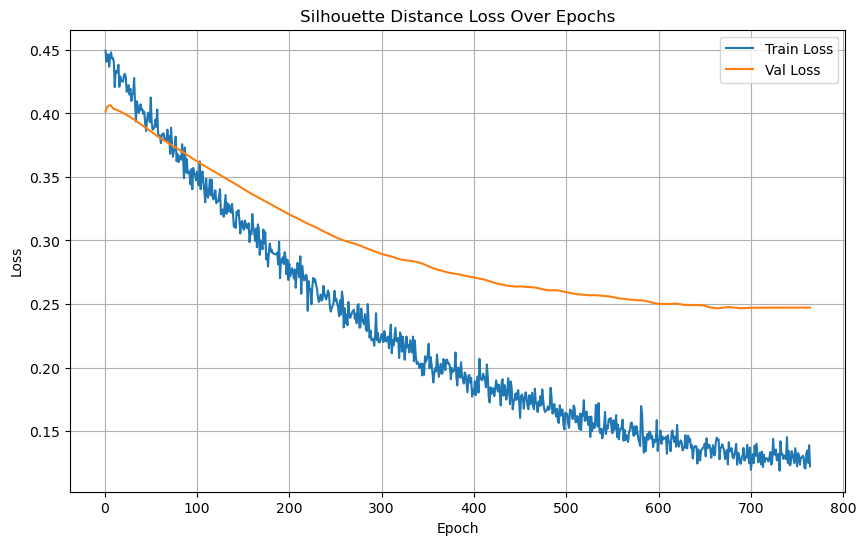

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/2314], Loss: 0.1193
Test Batch [20/2314], Loss: 0.1546
Test Batch [30/2314], Loss: 0.5000
Test Batch [40/2314], Loss: 0.1276
Test Batch [50/2314], Loss: 0.5000
Test Batch [60/2314], Loss: 0.5000
Test Batch [70/2314], Loss: 0.5000
Test Batch [80/2314], Loss: 0.1578


Test Batch [90/2314], Loss: 0.5000
Test Batch [100/2314], Loss: 0.0593
Test Batch [110/2314], Loss: 0.5000
Test Batch [120/2314], Loss: 0.1905
Test Batch [130/2314], Loss: 0.5000
Test Batch [140/2314], Loss: 0.5000
Test Batch [150/2314], Loss: 0.5000


Test Batch [160/2314], Loss: 0.1628
Test Batch [170/2314], Loss: 0.5000
Test Batch [180/2314], Loss: 0.5000
Test Batch [190/2314], Loss: 0.5000
Test Batch [200/2314], Loss: 0.1670
Test Batch [210/2314], Loss: 0.5000
Test Batch [220/2314], Loss: 0.5000


Test Batch [230/2314], Loss: 0.1000
Test Batch [240/2314], Loss: 0.0447
Test Batch [250/2314], Loss: 0.1294
Test Batch [260/2314], Loss: 0.5000
Test Batch [270/2314], Loss: 0.5000
Test Batch [280/2314], Loss: 0.5000
Test Batch [290/2314], Loss: 0.1722


Test Batch [300/2314], Loss: 0.0517
Test Batch [310/2314], Loss: 0.5000
Test Batch [320/2314], Loss: 0.0852
Test Batch [330/2314], Loss: 0.5000
Test Batch [340/2314], Loss: 0.5000
Test Batch [350/2314], Loss: 0.1988
Test Batch [360/2314], Loss: 0.1067
Test Batch [370/2314], Loss: 0.1301


Test Batch [380/2314], Loss: 0.0724
Test Batch [390/2314], Loss: 0.5000
Test Batch [400/2314], Loss: 0.5000
Test Batch [410/2314], Loss: 0.0501
Test Batch [420/2314], Loss: 0.0706
Test Batch [430/2314], Loss: 0.1331
Test Batch [440/2314], Loss: 0.5000


Test Batch [450/2314], Loss: 0.0980
Test Batch [460/2314], Loss: 0.5000
Test Batch [470/2314], Loss: 0.1541
Test Batch [480/2314], Loss: 0.5000
Test Batch [490/2314], Loss: 0.0933


Test Batch [500/2314], Loss: 0.0772
Test Batch [510/2314], Loss: 0.1144
Test Batch [520/2314], Loss: 0.0954
Test Batch [530/2314], Loss: 0.5000
Test Batch [540/2314], Loss: 0.0544
Test Batch [550/2314], Loss: 0.0700


Test Batch [560/2314], Loss: 0.5000
Test Batch [570/2314], Loss: 0.5000
Test Batch [580/2314], Loss: 0.1229
Test Batch [590/2314], Loss: 0.0593
Test Batch [600/2314], Loss: 0.5000


Test Batch [610/2314], Loss: 0.5000
Test Batch [620/2314], Loss: 0.1514
Test Batch [630/2314], Loss: 0.0328
Test Batch [640/2314], Loss: 0.1384
Test Batch [650/2314], Loss: 0.0201
Test Batch [660/2314], Loss: 0.0206


Test Batch [670/2314], Loss: 0.1471
Test Batch [680/2314], Loss: 0.5000
Test Batch [690/2314], Loss: 0.0756
Test Batch [700/2314], Loss: 0.1757
Test Batch [710/2314], Loss: 0.5000
Test Batch [720/2314], Loss: 0.5000
Test Batch [730/2314], Loss: 0.5000


Test Batch [740/2314], Loss: 0.0979
Test Batch [750/2314], Loss: 0.1491
Test Batch [760/2314], Loss: 0.0282
Test Batch [770/2314], Loss: 0.5000
Test Batch [780/2314], Loss: 0.0603
Test Batch [790/2314], Loss: 0.1581


Test Batch [800/2314], Loss: 0.0953
Test Batch [810/2314], Loss: 0.5000
Test Batch [820/2314], Loss: 0.1297
Test Batch [830/2314], Loss: 0.0564
Test Batch [840/2314], Loss: 0.5000
Test Batch [850/2314], Loss: 0.2326


Test Batch [860/2314], Loss: 0.5000
Test Batch [870/2314], Loss: 0.1242
Test Batch [880/2314], Loss: 0.0669
Test Batch [890/2314], Loss: 0.5000
Test Batch [900/2314], Loss: 0.5000
Test Batch [910/2314], Loss: 0.0377
Test Batch [920/2314], Loss: 0.5000
Test Batch [930/2314], Loss: 0.1132


Test Batch [940/2314], Loss: 0.1399
Test Batch [950/2314], Loss: 0.0524
Test Batch [960/2314], Loss: 0.0300
Test Batch [970/2314], Loss: 0.5000
Test Batch [980/2314], Loss: 0.5000
Test Batch [990/2314], Loss: 0.1325
Test Batch [1000/2314], Loss: 0.5000
Test Batch [1010/2314], Loss: 0.0919


Test Batch [1020/2314], Loss: 0.0341
Test Batch [1030/2314], Loss: 0.5000
Test Batch [1040/2314], Loss: 0.1441
Test Batch [1050/2314], Loss: 0.0323
Test Batch [1060/2314], Loss: 0.5000
Test Batch [1070/2314], Loss: 0.5000


Test Batch [1080/2314], Loss: 0.5000
Test Batch [1090/2314], Loss: 0.0281
Test Batch [1100/2314], Loss: 0.1131
Test Batch [1110/2314], Loss: 0.1495
Test Batch [1120/2314], Loss: 0.0343


Test Batch [1130/2314], Loss: 0.1203
Test Batch [1140/2314], Loss: 0.1857
Test Batch [1150/2314], Loss: 0.0406
Test Batch [1160/2314], Loss: 0.0277
Test Batch [1170/2314], Loss: 0.5000


Test Batch [1180/2314], Loss: 0.1442
Test Batch [1190/2314], Loss: 0.2214
Test Batch [1200/2314], Loss: 0.5000
Test Batch [1210/2314], Loss: 0.0349
Test Batch [1220/2314], Loss: 0.1555


Test Batch [1230/2314], Loss: 0.5000
Test Batch [1240/2314], Loss: 0.0823
Test Batch [1250/2314], Loss: 0.0305
Test Batch [1260/2314], Loss: 0.1882
Test Batch [1270/2314], Loss: 0.0717


Test Batch [1280/2314], Loss: 0.5000
Test Batch [1290/2314], Loss: 0.1103
Test Batch [1300/2314], Loss: 0.1370
Test Batch [1310/2314], Loss: 0.2251


Test Batch [1320/2314], Loss: 0.1820
Test Batch [1330/2314], Loss: 0.1649
Test Batch [1340/2314], Loss: 0.0497
Test Batch [1350/2314], Loss: 0.1518
Test Batch [1360/2314], Loss: 0.2255


Test Batch [1370/2314], Loss: 0.2404
Test Batch [1380/2314], Loss: 0.1870
Test Batch [1390/2314], Loss: 0.1478


Test Batch [1400/2314], Loss: 0.2002
Test Batch [1410/2314], Loss: 0.1724
Test Batch [1420/2314], Loss: 0.1846


Test Batch [1430/2314], Loss: 0.0340
Test Batch [1440/2314], Loss: 0.1581
Test Batch [1450/2314], Loss: 0.2087
Test Batch [1460/2314], Loss: 0.1885


Test Batch [1470/2314], Loss: 0.1795
Test Batch [1480/2314], Loss: 0.1487
Test Batch [1490/2314], Loss: 0.1848
Test Batch [1500/2314], Loss: 0.1146


Test Batch [1510/2314], Loss: 0.1189
Test Batch [1520/2314], Loss: 0.5000
Test Batch [1530/2314], Loss: 0.1268
Test Batch [1540/2314], Loss: 0.1482


Test Batch [1550/2314], Loss: 0.1444
Test Batch [1560/2314], Loss: 0.1413
Test Batch [1570/2314], Loss: 0.1713
Test Batch [1580/2314], Loss: 0.1647


Test Batch [1590/2314], Loss: 0.1995
Test Batch [1600/2314], Loss: 0.0937
Test Batch [1610/2314], Loss: 0.1126
Test Batch [1620/2314], Loss: 0.1309


Test Batch [1630/2314], Loss: 0.1387
Test Batch [1640/2314], Loss: 0.1817
Test Batch [1650/2314], Loss: 0.0737
Test Batch [1660/2314], Loss: 0.1459


Test Batch [1670/2314], Loss: 0.1404
Test Batch [1680/2314], Loss: 0.2059
Test Batch [1690/2314], Loss: 0.2022
Test Batch [1700/2314], Loss: 0.1857


Test Batch [1710/2314], Loss: 0.1597
Test Batch [1720/2314], Loss: 0.0810
Test Batch [1730/2314], Loss: 0.1216
Test Batch [1740/2314], Loss: 0.5000
Test Batch [1750/2314], Loss: 0.0493
Test Batch [1760/2314], Loss: 0.1163
Test Batch [1770/2314], Loss: 0.0999


Test Batch [1780/2314], Loss: 0.1253
Test Batch [1790/2314], Loss: 0.1019
Test Batch [1800/2314], Loss: 0.1164
Test Batch [1810/2314], Loss: 0.1271
Test Batch [1820/2314], Loss: 0.1372
Test Batch [1830/2314], Loss: 0.5000


Test Batch [1840/2314], Loss: 0.1507
Test Batch [1850/2314], Loss: 0.1332
Test Batch [1860/2314], Loss: 0.1559
Test Batch [1870/2314], Loss: 0.1707
Test Batch [1880/2314], Loss: 0.0939


Test Batch [1890/2314], Loss: 0.1107
Test Batch [1900/2314], Loss: 0.1839
Test Batch [1910/2314], Loss: 0.2169
Test Batch [1920/2314], Loss: 0.1855


Test Batch [1930/2314], Loss: 0.1352
Test Batch [1940/2314], Loss: 0.1985
Test Batch [1950/2314], Loss: 0.5000
Test Batch [1960/2314], Loss: 0.1333
Test Batch [1970/2314], Loss: 0.1618
Test Batch [1980/2314], Loss: 0.1560
Test Batch [1990/2314], Loss: 0.1212


Test Batch [2000/2314], Loss: 0.1668
Test Batch [2010/2314], Loss: 0.1160
Test Batch [2020/2314], Loss: 0.1502
Test Batch [2030/2314], Loss: 0.1080
Test Batch [2040/2314], Loss: 0.1520


Test Batch [2050/2314], Loss: 0.2503
Test Batch [2060/2314], Loss: 0.1349
Test Batch [2070/2314], Loss: 0.1086
Test Batch [2080/2314], Loss: 0.5000
Test Batch [2090/2314], Loss: 0.5000
Test Batch [2100/2314], Loss: 0.5000
Test Batch [2110/2314], Loss: 0.1545


Test Batch [2120/2314], Loss: 0.1648
Test Batch [2130/2314], Loss: 0.0608
Test Batch [2140/2314], Loss: 0.1650
Test Batch [2150/2314], Loss: 0.5000
Test Batch [2160/2314], Loss: 0.5000
Test Batch [2170/2314], Loss: 0.0142
Test Batch [2180/2314], Loss: 0.1278


Test Batch [2190/2314], Loss: 0.0656
Test Batch [2200/2314], Loss: 0.1877
Test Batch [2210/2314], Loss: 0.0298
Test Batch [2220/2314], Loss: 0.5000
Test Batch [2230/2314], Loss: 0.0278
Test Batch [2240/2314], Loss: 0.5000


Test Batch [2250/2314], Loss: 0.5000
Test Batch [2260/2314], Loss: 0.5000
Test Batch [2270/2314], Loss: 0.1931
Test Batch [2280/2314], Loss: 0.1606
Test Batch [2290/2314], Loss: 0.5000
Test Batch [2300/2314], Loss: 0.5000


Test Batch [2310/2314], Loss: 0.1190

Test Loss: 0.2331


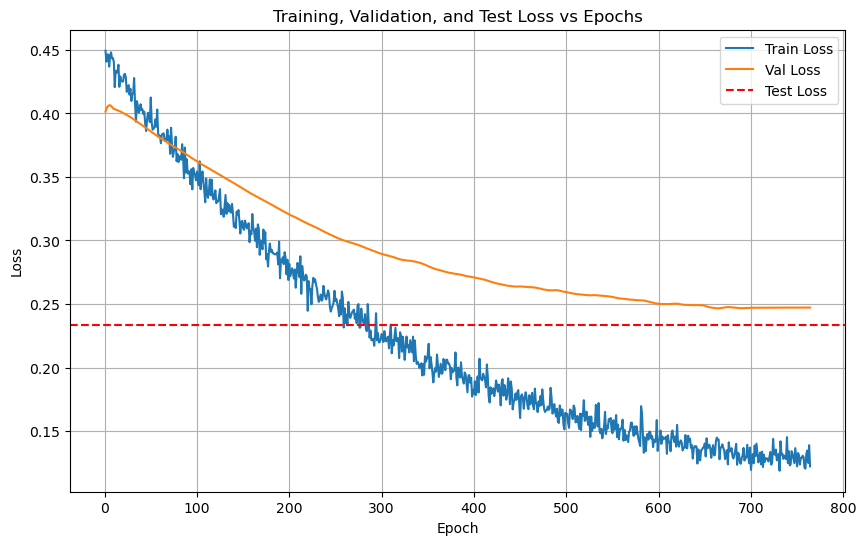

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/2314 for test dataset.


  Processed batch 20/2314 for test dataset.


  Processed batch 30/2314 for test dataset.
  Processed batch 40/2314 for test dataset.
  Processed batch 50/2314 for test dataset.


  Processed batch 60/2314 for test dataset.


  Processed batch 70/2314 for test dataset.
  Processed batch 80/2314 for test dataset.


  Processed batch 90/2314 for test dataset.
  Processed batch 100/2314 for test dataset.


  Processed batch 110/2314 for test dataset.
  Processed batch 120/2314 for test dataset.


  Processed batch 130/2314 for test dataset.
  Processed batch 140/2314 for test dataset.


  Processed batch 150/2314 for test dataset.
  Processed batch 160/2314 for test dataset.


  Processed batch 170/2314 for test dataset.
  Processed batch 180/2314 for test dataset.


  Processed batch 190/2314 for test dataset.
  Processed batch 200/2314 for test dataset.


  Processed batch 210/2314 for test dataset.
  Processed batch 220/2314 for test dataset.


  Processed batch 230/2314 for test dataset.
  Processed batch 240/2314 for test dataset.


  Processed batch 250/2314 for test dataset.
  Processed batch 260/2314 for test dataset.


  Processed batch 270/2314 for test dataset.


  Processed batch 280/2314 for test dataset.
  Processed batch 290/2314 for test dataset.


  Processed batch 300/2314 for test dataset.
  Processed batch 310/2314 for test dataset.


  Processed batch 320/2314 for test dataset.
  Processed batch 330/2314 for test dataset.


  Processed batch 340/2314 for test dataset.


  Processed batch 350/2314 for test dataset.
  Processed batch 360/2314 for test dataset.
  Processed batch 370/2314 for test dataset.


  Processed batch 380/2314 for test dataset.


  Processed batch 390/2314 for test dataset.
  Processed batch 400/2314 for test dataset.
  Processed batch 410/2314 for test dataset.


  Processed batch 420/2314 for test dataset.
  Processed batch 430/2314 for test dataset.
  Processed batch 440/2314 for test dataset.
  Processed batch 450/2314 for test dataset.


  Processed batch 460/2314 for test dataset.
  Processed batch 470/2314 for test dataset.
  Processed batch 480/2314 for test dataset.
  Processed batch 490/2314 for test dataset.


  Processed batch 500/2314 for test dataset.
  Processed batch 510/2314 for test dataset.
  Processed batch 520/2314 for test dataset.
  Processed batch 530/2314 for test dataset.


  Processed batch 540/2314 for test dataset.
  Processed batch 550/2314 for test dataset.
  Processed batch 560/2314 for test dataset.
  Processed batch 570/2314 for test dataset.


  Processed batch 580/2314 for test dataset.
  Processed batch 590/2314 for test dataset.
  Processed batch 600/2314 for test dataset.
  Processed batch 610/2314 for test dataset.


  Processed batch 620/2314 for test dataset.
  Processed batch 630/2314 for test dataset.
  Processed batch 640/2314 for test dataset.
  Processed batch 650/2314 for test dataset.


  Processed batch 660/2314 for test dataset.
  Processed batch 670/2314 for test dataset.
  Processed batch 680/2314 for test dataset.
  Processed batch 690/2314 for test dataset.


  Processed batch 700/2314 for test dataset.
  Processed batch 710/2314 for test dataset.
  Processed batch 720/2314 for test dataset.
  Processed batch 730/2314 for test dataset.


  Processed batch 740/2314 for test dataset.
  Processed batch 750/2314 for test dataset.
  Processed batch 760/2314 for test dataset.
  Processed batch 770/2314 for test dataset.


  Processed batch 780/2314 for test dataset.
  Processed batch 790/2314 for test dataset.
  Processed batch 800/2314 for test dataset.
  Processed batch 810/2314 for test dataset.


  Processed batch 820/2314 for test dataset.
  Processed batch 830/2314 for test dataset.
  Processed batch 840/2314 for test dataset.


  Processed batch 850/2314 for test dataset.
  Processed batch 860/2314 for test dataset.
  Processed batch 870/2314 for test dataset.
  Processed batch 880/2314 for test dataset.


  Processed batch 890/2314 for test dataset.
  Processed batch 900/2314 for test dataset.
  Processed batch 910/2314 for test dataset.
  Processed batch 920/2314 for test dataset.


  Processed batch 930/2314 for test dataset.
  Processed batch 940/2314 for test dataset.
  Processed batch 950/2314 for test dataset.
  Processed batch 960/2314 for test dataset.


  Processed batch 970/2314 for test dataset.
  Processed batch 980/2314 for test dataset.
  Processed batch 990/2314 for test dataset.
  Processed batch 1000/2314 for test dataset.


  Processed batch 1010/2314 for test dataset.
  Processed batch 1020/2314 for test dataset.
  Processed batch 1030/2314 for test dataset.
  Processed batch 1040/2314 for test dataset.


  Processed batch 1050/2314 for test dataset.
  Processed batch 1060/2314 for test dataset.
  Processed batch 1070/2314 for test dataset.
  Processed batch 1080/2314 for test dataset.


  Processed batch 1090/2314 for test dataset.
  Processed batch 1100/2314 for test dataset.
  Processed batch 1110/2314 for test dataset.
  Processed batch 1120/2314 for test dataset.


  Processed batch 1130/2314 for test dataset.
  Processed batch 1140/2314 for test dataset.
  Processed batch 1150/2314 for test dataset.
  Processed batch 1160/2314 for test dataset.


  Processed batch 1170/2314 for test dataset.
  Processed batch 1180/2314 for test dataset.
  Processed batch 1190/2314 for test dataset.
  Processed batch 1200/2314 for test dataset.


  Processed batch 1210/2314 for test dataset.
  Processed batch 1220/2314 for test dataset.
  Processed batch 1230/2314 for test dataset.
  Processed batch 1240/2314 for test dataset.


  Processed batch 1250/2314 for test dataset.
  Processed batch 1260/2314 for test dataset.
  Processed batch 1270/2314 for test dataset.
  Processed batch 1280/2314 for test dataset.


  Processed batch 1290/2314 for test dataset.
  Processed batch 1300/2314 for test dataset.
  Processed batch 1310/2314 for test dataset.
  Processed batch 1320/2314 for test dataset.


  Processed batch 1330/2314 for test dataset.
  Processed batch 1340/2314 for test dataset.
  Processed batch 1350/2314 for test dataset.
  Processed batch 1360/2314 for test dataset.


  Processed batch 1370/2314 for test dataset.
  Processed batch 1380/2314 for test dataset.
  Processed batch 1390/2314 for test dataset.
  Processed batch 1400/2314 for test dataset.


  Processed batch 1410/2314 for test dataset.
  Processed batch 1420/2314 for test dataset.
  Processed batch 1430/2314 for test dataset.
  Processed batch 1440/2314 for test dataset.


  Processed batch 1450/2314 for test dataset.
  Processed batch 1460/2314 for test dataset.
  Processed batch 1470/2314 for test dataset.
  Processed batch 1480/2314 for test dataset.


  Processed batch 1490/2314 for test dataset.
  Processed batch 1500/2314 for test dataset.
  Processed batch 1510/2314 for test dataset.
  Processed batch 1520/2314 for test dataset.


  Processed batch 1530/2314 for test dataset.
  Processed batch 1540/2314 for test dataset.
  Processed batch 1550/2314 for test dataset.
  Processed batch 1560/2314 for test dataset.


  Processed batch 1570/2314 for test dataset.
  Processed batch 1580/2314 for test dataset.
  Processed batch 1590/2314 for test dataset.
  Processed batch 1600/2314 for test dataset.


  Processed batch 1610/2314 for test dataset.
  Processed batch 1620/2314 for test dataset.
  Processed batch 1630/2314 for test dataset.
  Processed batch 1640/2314 for test dataset.


  Processed batch 1650/2314 for test dataset.
  Processed batch 1660/2314 for test dataset.
  Processed batch 1670/2314 for test dataset.
  Processed batch 1680/2314 for test dataset.


  Processed batch 1690/2314 for test dataset.
  Processed batch 1700/2314 for test dataset.
  Processed batch 1710/2314 for test dataset.


  Processed batch 1720/2314 for test dataset.
  Processed batch 1730/2314 for test dataset.
  Processed batch 1740/2314 for test dataset.
  Processed batch 1750/2314 for test dataset.


  Processed batch 1760/2314 for test dataset.
  Processed batch 1770/2314 for test dataset.
  Processed batch 1780/2314 for test dataset.
  Processed batch 1790/2314 for test dataset.


  Processed batch 1800/2314 for test dataset.
  Processed batch 1810/2314 for test dataset.
  Processed batch 1820/2314 for test dataset.
  Processed batch 1830/2314 for test dataset.


  Processed batch 1840/2314 for test dataset.
  Processed batch 1850/2314 for test dataset.
  Processed batch 1860/2314 for test dataset.
  Processed batch 1870/2314 for test dataset.


  Processed batch 1880/2314 for test dataset.
  Processed batch 1890/2314 for test dataset.
  Processed batch 1900/2314 for test dataset.
  Processed batch 1910/2314 for test dataset.


  Processed batch 1920/2314 for test dataset.
  Processed batch 1930/2314 for test dataset.
  Processed batch 1940/2314 for test dataset.
  Processed batch 1950/2314 for test dataset.


  Processed batch 1960/2314 for test dataset.
  Processed batch 1970/2314 for test dataset.
  Processed batch 1980/2314 for test dataset.
  Processed batch 1990/2314 for test dataset.


  Processed batch 2000/2314 for test dataset.
  Processed batch 2010/2314 for test dataset.
  Processed batch 2020/2314 for test dataset.
  Processed batch 2030/2314 for test dataset.


  Processed batch 2040/2314 for test dataset.
  Processed batch 2050/2314 for test dataset.
  Processed batch 2060/2314 for test dataset.
  Processed batch 2070/2314 for test dataset.


  Processed batch 2080/2314 for test dataset.
  Processed batch 2090/2314 for test dataset.
  Processed batch 2100/2314 for test dataset.
  Processed batch 2110/2314 for test dataset.


  Processed batch 2120/2314 for test dataset.
  Processed batch 2130/2314 for test dataset.
  Processed batch 2140/2314 for test dataset.
  Processed batch 2150/2314 for test dataset.


  Processed batch 2160/2314 for test dataset.
  Processed batch 2170/2314 for test dataset.
  Processed batch 2180/2314 for test dataset.
  Processed batch 2190/2314 for test dataset.


  Processed batch 2200/2314 for test dataset.
  Processed batch 2210/2314 for test dataset.
  Processed batch 2220/2314 for test dataset.
  Processed batch 2230/2314 for test dataset.


  Processed batch 2240/2314 for test dataset.
  Processed batch 2250/2314 for test dataset.
  Processed batch 2260/2314 for test dataset.
  Processed batch 2270/2314 for test dataset.


  Processed batch 2280/2314 for test dataset.
  Processed batch 2290/2314 for test dataset.
  Processed batch 2300/2314 for test dataset.
  Processed batch 2310/2314 for test dataset.


Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (45, 128)
Train labels shape: (45,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (148062, 128)
Test labels shape: (148062,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 91.11%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.56      1.00      0.71         5
           4       1.00      0.60      0.75         5
           5       1.00      0.80      0.89         5
           6       1.00      1.00      1.00         5
           7       1.00      0.80      0.89         5
           8       1.00      1.00      1.00         5

    accuracy                           0.91        45
   macro avg       0.95      0.91      0.92        45
weighted avg       0.95      0.91      0.92        45


LOG: Evaluating on the test set...
Test Accuracy: 94.77%



Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     65961
           1       0.97      0.79      0.87      7588
           2       0.64      0.90      0.75      3080
           3       0.56      0.97      0.71      2675
           4       0.81      0.79      0.80      6574
           5       0.80      0.96      0.87      9238
           6       0.93      0.80      0.86      7277
           7       1.00      0.94      0.97     42816
           8       0.98      0.99      0.99      2853

    accuracy                           0.95    148062
   macro avg       0.85      0.91      0.87    148062
weighted avg       0.96      0.95      0.95    148062

Saved SCL_SDL+LRM predictions and true labels to model_predictions


## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (45, 128)
Train labels shape: (45,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (148062, 128)
Test labels shape: (148062,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.3600  |  Val Loss: 2.2730
Validation loss improved from inf to 2.2730.
[Epoch 2/1000] Train Loss: 2.3393  |  Val Loss: 2.2578
Validation loss improved from 2.2730 to 2.2578.
[Epoch 3/1000] Train Loss: 2.3188  |  Val Loss: 2.2427
Validation loss improved from 2.2578 to 2.2427.
[Epoch 4/1000] Train Loss: 2.2984  |  Val Loss: 2.2277
Validation loss improved from 2.2427 to 2.2277.
[Epoch 5/1000] Train Loss: 2.2779  |  Val Loss: 2.2128
Validation loss improved from 2.2277 to 2.2128.
[Epoch 6/1000] Train Loss: 2.2575  |  Val Loss: 2.1981
Validation loss improved from 2.2128 to 2.1981.
[Epoch 7/1000] Train Loss: 2.2372  |  Val Loss: 2.1833
Validation loss improved from 2.1981 to 2.1833.
[Epoch 8/1000] Train Loss: 2.2172  |  Val Loss: 2.1686
Validation loss improved from 2.1833 to 2.1686.
[Epoch 9/1000] Train Loss: 2.1973  |  Val Loss: 2.1540
Validation loss improved from 2.1686 to 2.1540.
[Epoch 10/1000] Train Loss: 2.1776  |  Val Loss: 2.1393
Validation loss impr

[Epoch 63/1000] Train Loss: 1.3851  |  Val Loss: 1.5645
Validation loss improved from 1.5724 to 1.5645.
[Epoch 64/1000] Train Loss: 1.3742  |  Val Loss: 1.5565
Validation loss improved from 1.5645 to 1.5565.
[Epoch 65/1000] Train Loss: 1.3636  |  Val Loss: 1.5486
Validation loss improved from 1.5565 to 1.5486.
[Epoch 66/1000] Train Loss: 1.3530  |  Val Loss: 1.5408
Validation loss improved from 1.5486 to 1.5408.
[Epoch 67/1000] Train Loss: 1.3424  |  Val Loss: 1.5330
Validation loss improved from 1.5408 to 1.5330.
[Epoch 68/1000] Train Loss: 1.3319  |  Val Loss: 1.5252
Validation loss improved from 1.5330 to 1.5252.
[Epoch 69/1000] Train Loss: 1.3214  |  Val Loss: 1.5175
Validation loss improved from 1.5252 to 1.5175.
[Epoch 70/1000] Train Loss: 1.3109  |  Val Loss: 1.5098
Validation loss improved from 1.5175 to 1.5098.
[Epoch 71/1000] Train Loss: 1.3005  |  Val Loss: 1.5021
Validation loss improved from 1.5098 to 1.5021.
[Epoch 72/1000] Train Loss: 1.2902  |  Val Loss: 1.4945
Validati

[Epoch 136/1000] Train Loss: 0.7708  |  Val Loss: 1.1082
Validation loss improved from 1.1127 to 1.1082.
[Epoch 137/1000] Train Loss: 0.7645  |  Val Loss: 1.1036
Validation loss improved from 1.1082 to 1.1036.
[Epoch 138/1000] Train Loss: 0.7582  |  Val Loss: 1.0990
Validation loss improved from 1.1036 to 1.0990.
[Epoch 139/1000] Train Loss: 0.7520  |  Val Loss: 1.0945
Validation loss improved from 1.0990 to 1.0945.
[Epoch 140/1000] Train Loss: 0.7459  |  Val Loss: 1.0899
Validation loss improved from 1.0945 to 1.0899.
[Epoch 141/1000] Train Loss: 0.7398  |  Val Loss: 1.0854
Validation loss improved from 1.0899 to 1.0854.
[Epoch 142/1000] Train Loss: 0.7337  |  Val Loss: 1.0809
Validation loss improved from 1.0854 to 1.0809.
[Epoch 143/1000] Train Loss: 0.7277  |  Val Loss: 1.0764
Validation loss improved from 1.0809 to 1.0764.
[Epoch 144/1000] Train Loss: 0.7217  |  Val Loss: 1.0720
Validation loss improved from 1.0764 to 1.0720.
[Epoch 145/1000] Train Loss: 0.7158  |  Val Loss: 1.067

[Epoch 211/1000] Train Loss: 0.3944  |  Val Loss: 0.8425
Validation loss improved from 0.8450 to 0.8425.
[Epoch 212/1000] Train Loss: 0.3907  |  Val Loss: 0.8399
Validation loss improved from 0.8425 to 0.8399.
[Epoch 213/1000] Train Loss: 0.3869  |  Val Loss: 0.8374
Validation loss improved from 0.8399 to 0.8374.
[Epoch 214/1000] Train Loss: 0.3832  |  Val Loss: 0.8349
Validation loss improved from 0.8374 to 0.8349.
[Epoch 215/1000] Train Loss: 0.3795  |  Val Loss: 0.8325
Validation loss improved from 0.8349 to 0.8325.
[Epoch 216/1000] Train Loss: 0.3758  |  Val Loss: 0.8300
Validation loss improved from 0.8325 to 0.8300.
[Epoch 217/1000] Train Loss: 0.3722  |  Val Loss: 0.8276
Validation loss improved from 0.8300 to 0.8276.
[Epoch 218/1000] Train Loss: 0.3686  |  Val Loss: 0.8252
Validation loss improved from 0.8276 to 0.8252.
[Epoch 219/1000] Train Loss: 0.3651  |  Val Loss: 0.8229
Validation loss improved from 0.8252 to 0.8229.
[Epoch 220/1000] Train Loss: 0.3615  |  Val Loss: 0.820

[Epoch 291/1000] Train Loss: 0.1772  |  Val Loss: 0.6926
Validation loss improved from 0.6939 to 0.6926.
[Epoch 292/1000] Train Loss: 0.1754  |  Val Loss: 0.6913
Validation loss improved from 0.6926 to 0.6913.
[Epoch 293/1000] Train Loss: 0.1737  |  Val Loss: 0.6901
Validation loss improved from 0.6913 to 0.6901.
[Epoch 294/1000] Train Loss: 0.1719  |  Val Loss: 0.6888
Validation loss improved from 0.6901 to 0.6888.
[Epoch 295/1000] Train Loss: 0.1702  |  Val Loss: 0.6875
Validation loss improved from 0.6888 to 0.6875.
[Epoch 296/1000] Train Loss: 0.1685  |  Val Loss: 0.6863
Validation loss improved from 0.6875 to 0.6863.
[Epoch 297/1000] Train Loss: 0.1669  |  Val Loss: 0.6851
Validation loss improved from 0.6863 to 0.6851.
[Epoch 298/1000] Train Loss: 0.1652  |  Val Loss: 0.6839
Validation loss improved from 0.6851 to 0.6839.
[Epoch 299/1000] Train Loss: 0.1636  |  Val Loss: 0.6827
Validation loss improved from 0.6839 to 0.6827.
[Epoch 300/1000] Train Loss: 0.1620  |  Val Loss: 0.681

[Epoch 365/1000] Train Loss: 0.0898  |  Val Loss: 0.6299
Validation loss improved from 0.6304 to 0.6299.
[Epoch 366/1000] Train Loss: 0.0891  |  Val Loss: 0.6294
Validation loss improved from 0.6299 to 0.6294.
[Epoch 367/1000] Train Loss: 0.0883  |  Val Loss: 0.6290
Validation loss improved from 0.6294 to 0.6290.
[Epoch 368/1000] Train Loss: 0.0876  |  Val Loss: 0.6285
Validation loss improved from 0.6290 to 0.6285.
[Epoch 369/1000] Train Loss: 0.0868  |  Val Loss: 0.6281
Validation loss improved from 0.6285 to 0.6281.
[Epoch 370/1000] Train Loss: 0.0861  |  Val Loss: 0.6277
Validation loss improved from 0.6281 to 0.6277.
[Epoch 371/1000] Train Loss: 0.0854  |  Val Loss: 0.6272
Validation loss improved from 0.6277 to 0.6272.
[Epoch 372/1000] Train Loss: 0.0847  |  Val Loss: 0.6268
Validation loss improved from 0.6272 to 0.6268.
[Epoch 373/1000] Train Loss: 0.0840  |  Val Loss: 0.6264
Validation loss improved from 0.6268 to 0.6264.
[Epoch 374/1000] Train Loss: 0.0833  |  Val Loss: 0.625

[Epoch 447/1000] Train Loss: 0.0495  |  Val Loss: 0.6075
Validation loss improved from 0.6076 to 0.6075.
[Epoch 448/1000] Train Loss: 0.0492  |  Val Loss: 0.6073
Validation loss improved from 0.6075 to 0.6073.
[Epoch 449/1000] Train Loss: 0.0489  |  Val Loss: 0.6072
Validation loss improved from 0.6073 to 0.6072.
[Epoch 450/1000] Train Loss: 0.0486  |  Val Loss: 0.6070
Validation loss improved from 0.6072 to 0.6070.
[Epoch 451/1000] Train Loss: 0.0482  |  Val Loss: 0.6069
Validation loss improved from 0.6070 to 0.6069.
[Epoch 452/1000] Train Loss: 0.0479  |  Val Loss: 0.6068
Validation loss improved from 0.6069 to 0.6068.
[Epoch 453/1000] Train Loss: 0.0476  |  Val Loss: 0.6066
Validation loss improved from 0.6068 to 0.6066.
[Epoch 454/1000] Train Loss: 0.0473  |  Val Loss: 0.6065
Validation loss improved from 0.6066 to 0.6065.
[Epoch 455/1000] Train Loss: 0.0470  |  Val Loss: 0.6064
Validation loss improved from 0.6065 to 0.6064.
[Epoch 456/1000] Train Loss: 0.0468  |  Val Loss: 0.606

[Epoch 521/1000] Train Loss: 0.0321  |  Val Loss: 0.6029
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 522/1000] Train Loss: 0.0319  |  Val Loss: 0.6029
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 523/1000] Train Loss: 0.0318  |  Val Loss: 0.6029
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 524/1000] Train Loss: 0.0316  |  Val Loss: 0.6030
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 525/1000] Train Loss: 0.0314  |  Val Loss: 0.6030
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 526/1000] Train Loss: 0.0313  |  Val Loss: 0.6030
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 527/1000] Train Loss: 0.0311  |  Val Loss: 0.6030
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 528/1000] Train Loss: 0.0310  |  Val Loss: 0.6030
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 529/1000] Train Loss: 0.0308  |  Val Loss: 0.6030
!! Validation loss did NOT improve !! Patience: 

[Epoch 596/1000] Train Loss: 0.0224  |  Val Loss: 0.6043
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 597/1000] Train Loss: 0.0223  |  Val Loss: 0.6043
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 598/1000] Train Loss: 0.0222  |  Val Loss: 0.6043
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 599/1000] Train Loss: 0.0221  |  Val Loss: 0.6043
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 600/1000] Train Loss: 0.0220  |  Val Loss: 0.6044
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 601/1000] Train Loss: 0.0219  |  Val Loss: 0.6044
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 602/1000] Train Loss: 0.0218  |  Val Loss: 0.6044
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 603/1000] Train Loss: 0.0218  |  Val Loss: 0.6045
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 604/1000] Train Loss: 0.0217  |  Val Loss: 0.6045
!! Validation loss did NOT improve !! Patience:

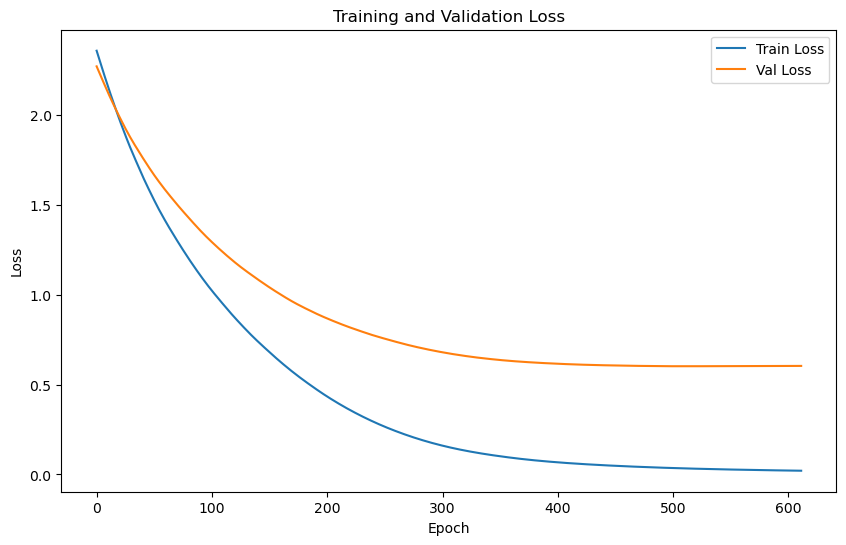

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.3677 | Test Accuracy: 91.04%


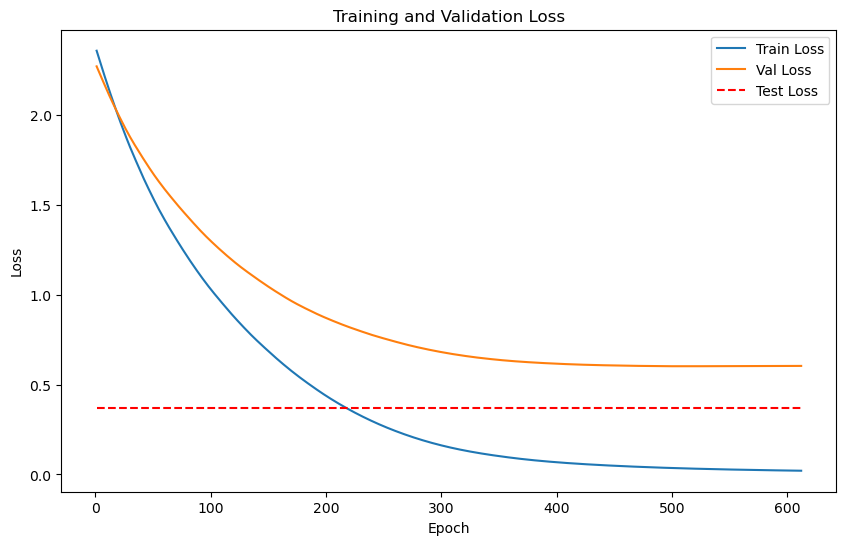

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


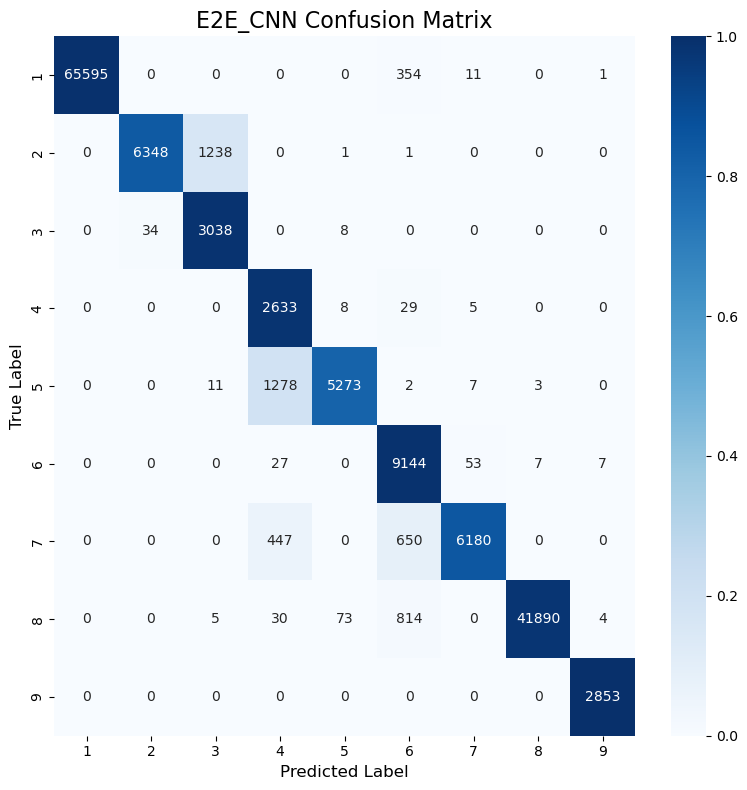

Classification Accuracy: 96.55%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


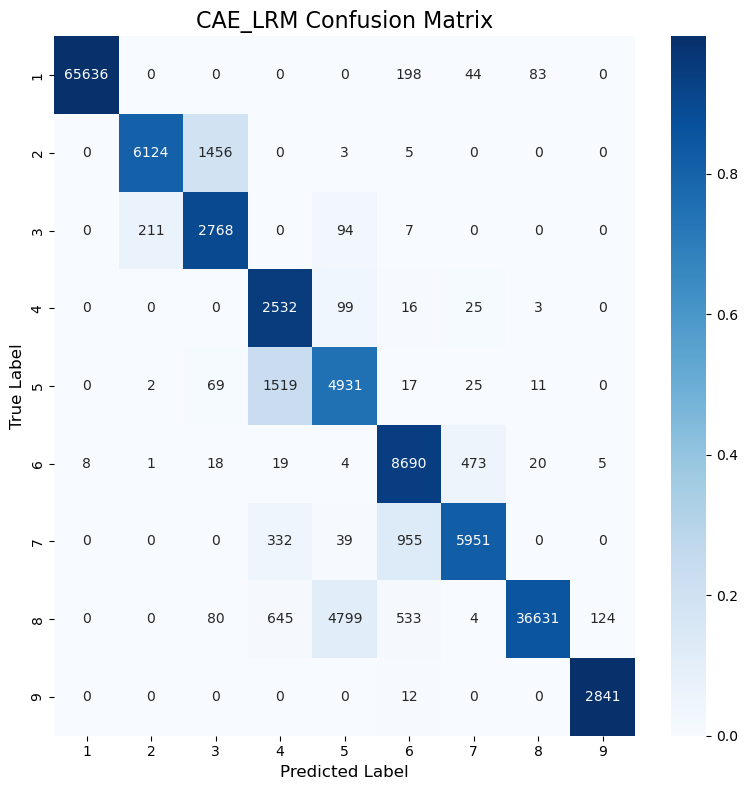

Classification Accuracy: 91.92%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


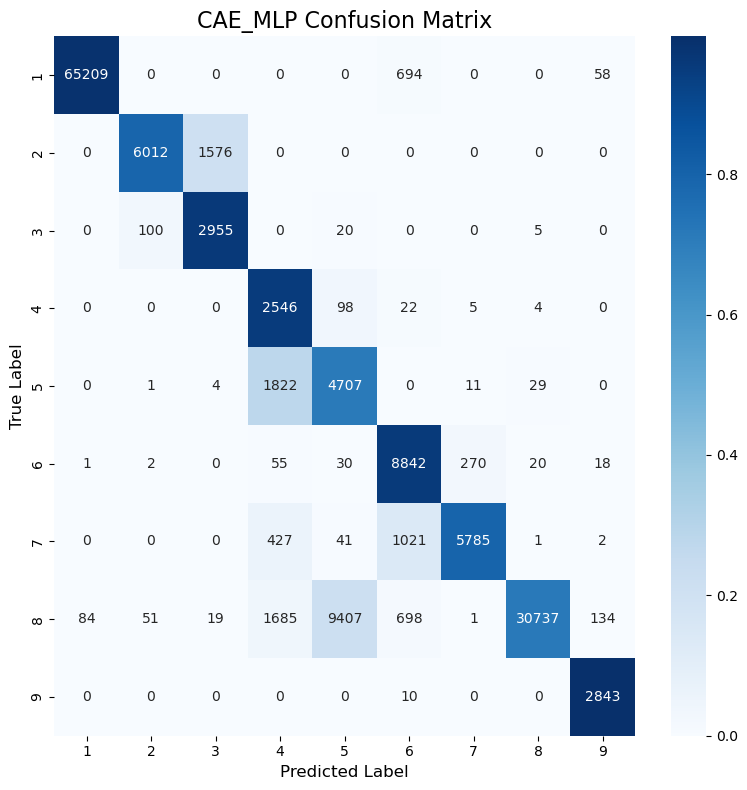

Classification Accuracy: 87.56%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


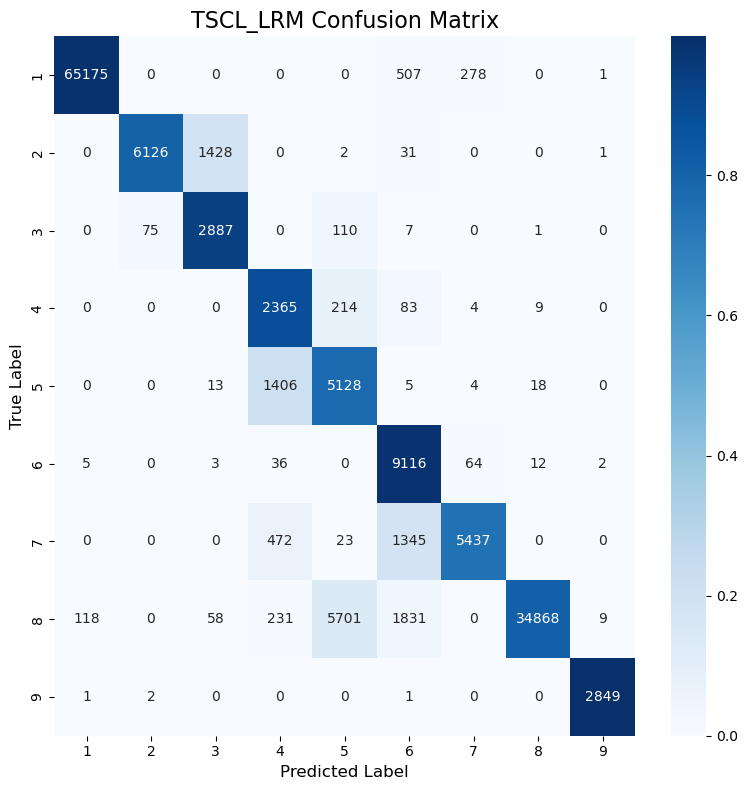

Classification Accuracy: 90.47%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


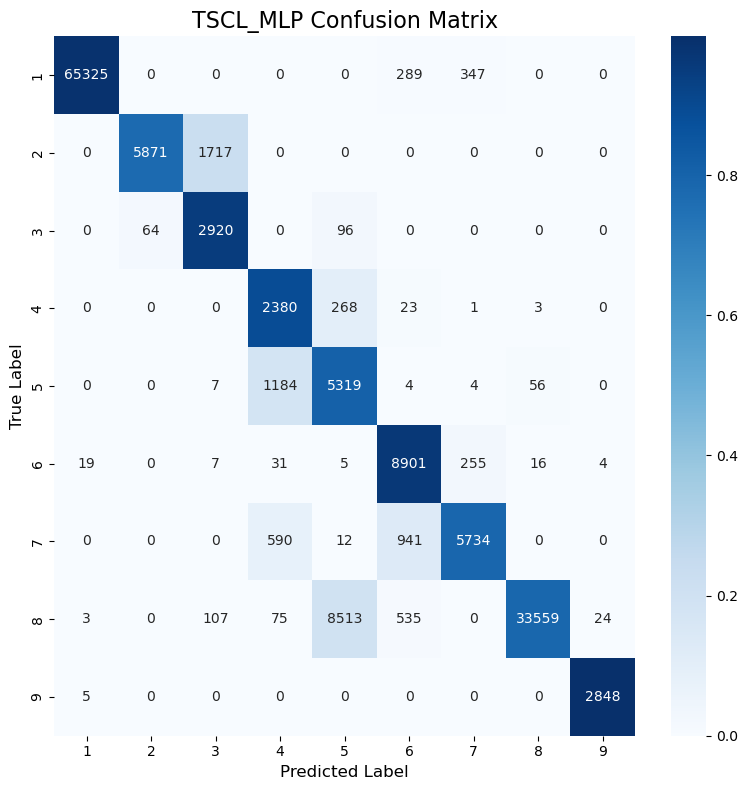

Classification Accuracy: 89.73%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


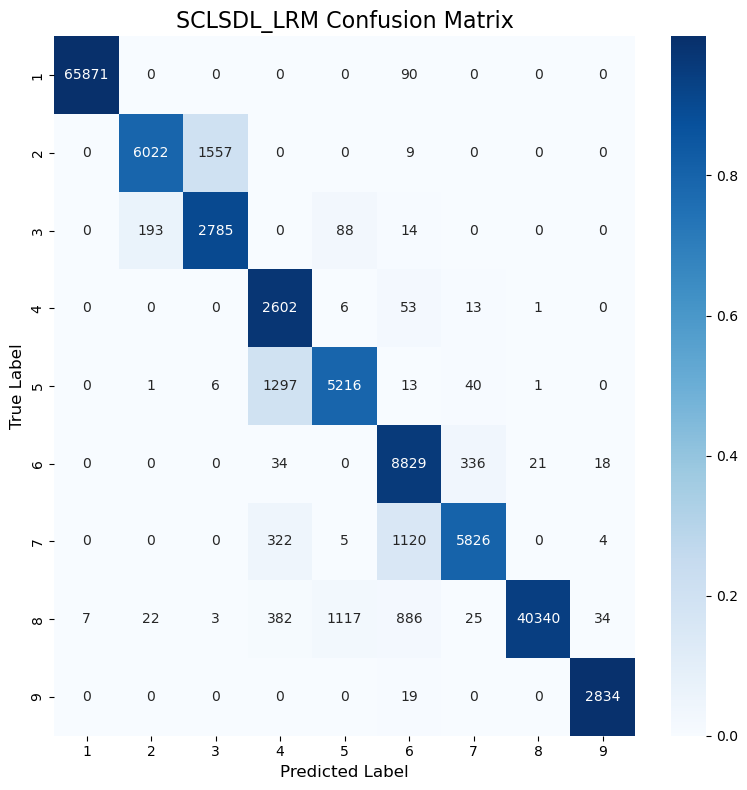

Classification Accuracy: 94.77%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


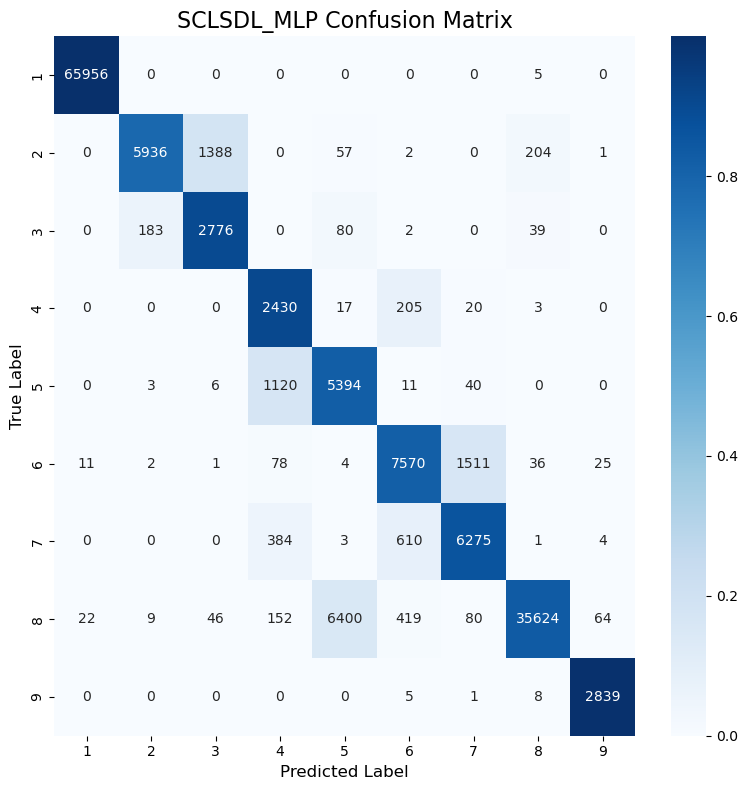

Classification Accuracy: 91.04%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          96.55
1    LRM (CAE)          91.92
2    MLP (CAE)          87.56
3     TSCL LRM          90.47
4     TSCL MLP          89.73
5  SCL_SDL LRM          94.77
6  SCL_SDL MLP          91.04

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          96.55
5  SCL_SDL LRM          94.77
1    LRM (CAE)          91.92
6  SCL_SDL MLP          91.04
3     TSCL LRM          90.47
4     TSCL MLP          89.73
2    MLP (CAE)          87.56
